#### 导入数据和数据预处理

In [2]:
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import ttest_1samp
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Construction of Panel Data
# 读取数据，确保 stock_code 为字符串
esg_df = pd.read_csv(
    "merged_yearly_stock_data_all.csv",
    dtype={"stock_code": str},
    low_memory=False
)
esg_df = esg_df.drop(columns = ["Coname"])

# 补全股票代码到6位（防止有 1 变成 '000001'）
esg_df["stock_code"] = esg_df["stock_code"].str.zfill(6)

# 确保年份是整数
esg_df["Year"] = esg_df["Year"].astype(int)


**收益率与风险数据**  
内容：此数据为A股股票从<u>2005年1月4日到2024年5月17日</u>的日收益率数据。我们可以根据这个数据算出相关的股票风险。
* Date: 日期
* stock_code：股票代码
* return股票：回报

In [5]:
df = pd.read_csv("20240517_price_dayReturn.csv")

# 把宽表转成长表
stock_return = df.melt(
    id_vars=["Date"],        # 不动的列 哪些列保持不变（标识符列）
    var_name="stock_code",          # 新列名（原来的股票代码列名），原来的列名会放到新建的列
    value_name="return"      # 新列名（原来的数值）
)

# 把 zip 转成字符串，并补零到6位
stock_return["stock_code"] = stock_return["stock_code"].astype(str).str.zfill(6)
stock_return["Date"] = pd.to_datetime(stock_return["Date"], format = "%Y%m%d")
# 看前几行
print(stock_return.head())

        Date stock_code    return
0 2005-01-04     000005 -3.181818
1 2005-01-05     000005  2.347418
2 2005-01-06     000005 -0.458716
3 2005-01-07     000005  5.069124
4 2005-01-10     000005  3.070175


##### 去掉不参与的年份
* 去掉没有ESG_score评分的年份。

In [7]:
# 计算公司不同年份的coverage ratio
# 每年全部公司数
yearly_total = (
    esg_df.groupby("Year")["stock_code"]
    .nunique()
    .reset_index()
    .rename(columns={"stock_code": "Total_Firms"})
)

# 每年有ESG评级的公司数
yearly_esg = (
    esg_df[esg_df["ESG_Score"].notna()]
    .groupby("Year")["stock_code"]
    .nunique()
    .reset_index()
    .rename(columns={"stock_code": "Firms_with_ESG"})
)

# 合并并计算coverage ratio（百分比）
coverage_ratio = pd.merge(yearly_total, yearly_esg, on="Year", how="left")
coverage_ratio["Coverage_Ratio(%)"] = (
    coverage_ratio["Firms_with_ESG"] / coverage_ratio["Total_Firms"] * 100
)

# print(coverage_ratio)

In [8]:
# 去掉2005, 2006, 2023,和 2024年的数据
esg_df = esg_df[~esg_df["Year"].isin([2005, 2006,2023,2024])]

# 设置多重索引 (公司 × 年份)
panel_df = esg_df.set_index(["stock_code", "Year"]).sort_index()

In [10]:
print(esg_df.columns)

Index(['Year', 'stock_code', 'market_cap', 'price_day_return',
       'Price_book_ratio', '证券简称', '上市日期', '摘牌日期',
       '所属Wind行业代码(2004) [行业级别] 一级行业', '所属Wind行业代码(2004) [行业级别] 二级行业',
       '所属Wind行业代码(2004) [行业级别] 三级行业', '所属Wind行业代码(2004) [行业级别] 四级行业',
       'exchange', 'ESG_Score', 'ESG_Rank', 'E_Score', 'E_Rank', 'S_Score',
       'S_Rank', 'G_Score', 'G_Rank'],
      dtype='object')


##### ESG Coverage Ratio 计算

In [13]:

# 每年全部公司数
yearly_total = (
    esg_df.groupby("Year")["stock_code"]
    .nunique()
    .reset_index()
    .rename(columns={"stock_code": "Total_Firms"})
)

# 每年有ESG评级的公司数
yearly_esg = (
    esg_df[esg_df["ESG_Score"].notna()]
    .groupby("Year")["stock_code"]
    .nunique()
    .reset_index()
    .rename(columns={"stock_code": "Firms_with_ESG"})
)

# 计算每年平均ESG、E、S、G分数
yearly_scores = (
    esg_df[esg_df["ESG_Score"].notna()]
    .groupby("Year")
    .agg({
        "ESG_Score": "mean",
        "E_Score": "mean", 
        "S_Score": "mean",
        "G_Score": "mean"
    })
    .reset_index()
    .rename(columns={
        "ESG_Score": "Avg_ESG_Score",
        "E_Score": "Avg_E_Score",
        "S_Score": "Avg_S_Score", 
        "G_Score": "Avg_G_Score"
    })
)

# 合并所有结果
coverage_ratio = pd.merge(yearly_total, yearly_esg, on="Year", how="left")
coverage_ratio = pd.merge(coverage_ratio, yearly_scores, on="Year", how="left")
coverage_ratio["Coverage_Ratio(%)"] = (
    coverage_ratio["Firms_with_ESG"] / coverage_ratio["Total_Firms"] * 100
)

# 对数值列保留两位小数
numeric_columns = ['Coverage_Ratio(%)', 'Avg_ESG_Score', 'Avg_E_Score', 'Avg_S_Score', 'Avg_G_Score']
coverage_ratio[numeric_columns] = coverage_ratio[numeric_columns].round(2)


print(coverage_ratio)

    Year  Total_Firms  Firms_with_ESG  Avg_ESG_Score  Avg_E_Score  \
0   2007         5076            1396          18.74         6.07   
1   2008         5076            1454          21.11         7.68   
2   2009         5076            1592          20.83         7.85   
3   2010         5076            1924          18.60         7.29   
4   2011         5076            2158          18.88         7.18   
5   2012         5076            2281          22.75         8.37   
6   2013         5076            2330          23.77         9.07   
7   2014         5076            2446          23.87         9.70   
8   2015         5084            2644          24.55        10.03   
9   2016         5084            2955          24.75        10.48   
10  2017         5084            3311          26.00        12.10   
11  2018         5084            3414          27.21        13.24   
12  2019         5084            3647          27.32        13.29   
13  2020         5084            4

In [14]:
# 对数值列保留两位小数
numeric_columns = ['Coverage_Ratio(%)', 'Avg_ESG_Score', 'Avg_E_Score', 'Avg_S_Score', 'Avg_G_Score']
coverage_ratio[numeric_columns] = coverage_ratio[numeric_columns].round(2)

# 对增长率列也保留两位小数
growth_columns = [col for col in coverage_ratio.columns if 'Growth' in col]
coverage_ratio[growth_columns] = coverage_ratio[growth_columns].round(2)

print("完整数据表（包含增长率）：")
print(coverage_ratio.to_string())

# 输出关键统计信息
print("\n关键增长率统计信息：")
print("=" * 60)

# 计算整个期间的总增长率
start_year = coverage_ratio['Year'].min()
end_year = coverage_ratio['Year'].max()

metrics = ['Avg_ESG_Score', 'Avg_E_Score', 'Avg_S_Score', 'Avg_G_Score', 'Coverage_Ratio(%)']

for metric in metrics:
    start_value = coverage_ratio[metric].iloc[0]
    end_value = coverage_ratio[metric].iloc[-1]
    total_growth = ((end_value - start_value) / start_value) * 100
    
    # 计算年均复合增长率
    cagr = ((end_value / start_value) ** (1 / (end_year - start_year)) - 1) * 100
    
    print(f"{metric} ({start_year}-{end_year}):")
    print(f"  起始值: {start_value:.2f}")
    print(f"  结束值: {end_value:.2f}")
    print(f"  总增长率: {total_growth:.2f}%")
    print(f"  年均复合增长率: {cagr:.2f}%")
    print("-" * 40)


完整数据表（包含增长率）：
    Year  Total_Firms  Firms_with_ESG  Avg_ESG_Score  Avg_E_Score  Avg_S_Score  Avg_G_Score  Coverage_Ratio(%)
0   2007         5076            1396          18.74         6.07        13.00        25.36              27.50
1   2008         5076            1454          21.11         7.68        15.95        26.19              28.64
2   2009         5076            1592          20.83         7.85        16.29        24.36              31.36
3   2010         5076            1924          18.60         7.29        17.52        19.27              37.90
4   2011         5076            2158          18.88         7.18        18.01        19.61              42.51
5   2012         5076            2281          22.75         8.37        21.89        23.52              44.94
6   2013         5076            2330          23.77         9.07        22.83        25.60              45.90
7   2014         5076            2446          23.87         9.70        22.98        25.79       

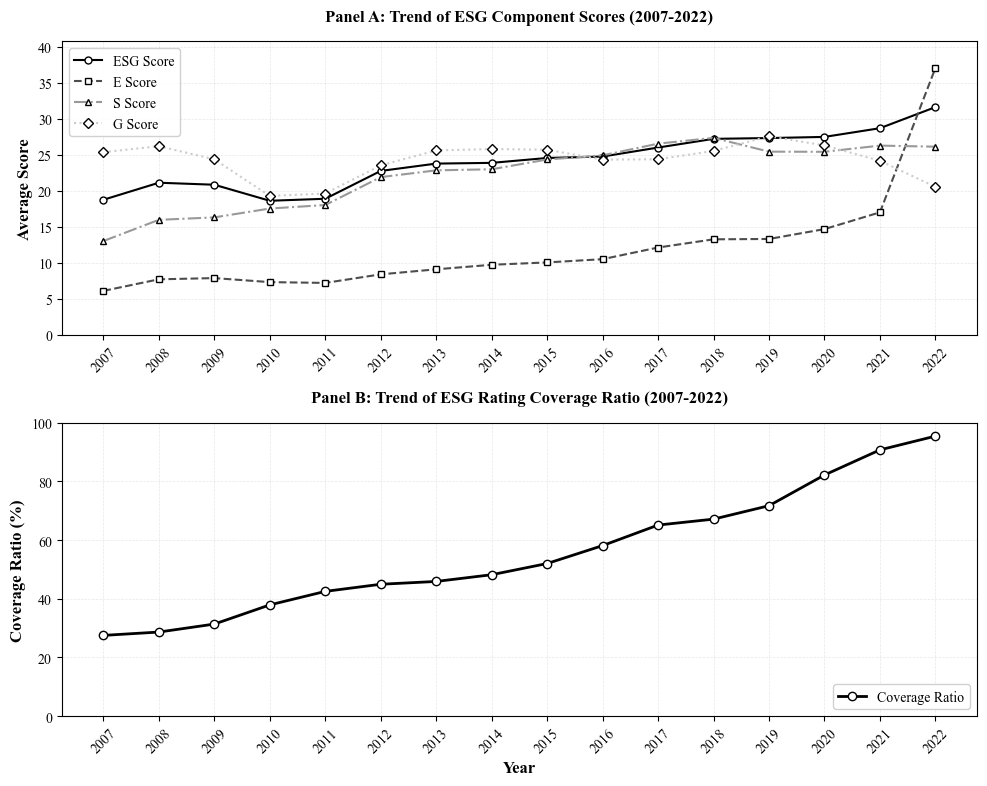

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 设置Times New Roman字体和期刊风格
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

# 创建图形和两个子图，调整间距
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3)  # 增加子图间距

# 第一个面板：ESG分数趋势
years = coverage_ratio['Year']
esg_scores = coverage_ratio['Avg_ESG_Score']
e_scores = coverage_ratio['Avg_E_Score']
s_scores = coverage_ratio['Avg_S_Score']
g_scores = coverage_ratio['Avg_G_Score']

# 使用黑白风格的线条和标记
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['black', '0.3', '0.6', '0.8']  # 不同灰度的黑色

# 绘制ESG各维度分数趋势
ax1.plot(years, esg_scores, linestyle=line_styles[0], marker=markers[0], 
         label='ESG Score', color=colors[0], markeredgecolor='black', markerfacecolor='white')
ax1.plot(years, e_scores, linestyle=line_styles[1], marker=markers[1], 
         label='E Score', color=colors[1], markeredgecolor='black', markerfacecolor='white')
ax1.plot(years, s_scores, linestyle=line_styles[2], marker=markers[2], 
         label='S Score', color=colors[2], markeredgecolor='black', markerfacecolor='white')
ax1.plot(years, g_scores, linestyle=line_styles[3], marker=markers[3], 
         label='G Score', color=colors[3], markeredgecolor='black', markerfacecolor='white')

# 设置第一个面板的格式
ax1.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax1.set_title('Panel A: Trend of ESG Component Scores (2007-2022)', fontsize=12, fontweight='bold', pad=15)
ax1.legend(loc='upper left', frameon=True, fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)
ax1.set_ylim(0, max([esg_scores.max(), e_scores.max(), s_scores.max(), g_scores.max()]) * 1.1)
ax1.tick_params(axis='both', which='major', labelsize=10)

# 第二个面板：覆盖率趋势
coverage_ratio_pct = coverage_ratio['Coverage_Ratio(%)']

ax2.plot(years, coverage_ratio_pct, linestyle='-', marker='o', linewidth=2, 
         label='Coverage Ratio', color='black', markeredgecolor='black', 
         markerfacecolor='white', markersize=6)

# 设置第二个面板的格式
ax2.set_ylabel('Coverage Ratio (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_title('Panel B: Trend of ESG Rating Coverage Ratio (2007-2022)', fontsize=12, fontweight='bold', pad=15)
ax2.legend(loc='lower right', frameon=True, fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax2.set_xticks(years)
ax2.set_xticklabels(years, rotation=45)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='both', which='major', labelsize=10)

# 调整布局
plt.tight_layout()

# 保存图形（高分辨率，适合发表）
# plt.savefig('Figure_ESG_Trends_BlackWhite.png', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')
# plt.savefig('Figure_ESG_Trends_BlackWhite.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none')

plt.show()

#### Coverage Bias Check

##### 整体数据
存在显著不同

In [18]:
df_has_esg = esg_df[esg_df["ESG_Score"].notna()].copy()
df_no_esg  = esg_df[esg_df["ESG_Score"].isna()].copy()

In [19]:
import pandas as pd
import numpy as np

# 假设您的DataFrame叫做 esg_df
# 首先创建有ESG和无ESG的两个子集
df_has_esg = esg_df[esg_df["ESG_Score"].notna()].copy()
df_no_esg = esg_df[esg_df["ESG_Score"].isna()].copy()

print("=" * 60)
print("数据完整性检查: 有ESG评分 vs 无ESG评分的公司")
print("=" * 60)

# 要检查的变量列表
variables = ["market_cap", "Price_book_ratio", "price_day_return"]

for var in variables:
    print(f"\n--- {var} ---")
    
    # 检查有ESG评分的公司
    has_esg_total = len(df_has_esg)
    has_esg_non_zero_non_na = df_has_esg[var].notna() & (df_has_esg[var] != 0)
    has_esg_count_valid = has_esg_non_zero_non_na.sum()
    has_esg_count_invalid = has_esg_total - has_esg_count_valid
    
    print(f"有ESG评级的公司 (总数: {has_esg_total:,})")
    print(f"  - 有效值(非零且非空): {has_esg_count_valid:,} ({has_esg_count_valid/has_esg_total*100:.1f}%)")
    print(f"  - 无效值(零或空值): {has_esg_count_invalid:,} ({has_esg_count_invalid/has_esg_total*100:.1f}%)")
    
    # 检查无ESG评分的公司
    no_esg_total = len(df_no_esg)
    no_esg_non_zero_non_na = df_no_esg[var].notna() & (df_no_esg[var] != 0)
    no_esg_count_valid = no_esg_non_zero_non_na.sum()
    no_esg_count_invalid = no_esg_total - no_esg_count_valid
    
    print(f"无ESG评级的公司 (总数: {no_esg_total:,})")
    print(f"  - 有效值(非零且非空): {no_esg_count_valid:,} ({no_esg_count_valid/no_esg_total*100:.1f}%)")
    print(f"  - 无效值(零或空值): {no_esg_count_invalid:,} ({no_esg_count_invalid/no_esg_total*100:.1f}%)")
    
    # 显示一些具体的无效值统计
    if no_esg_count_invalid > 0:
        no_esg_zeros = (df_no_esg[var] == 0).sum()
        no_esg_nans = df_no_esg[var].isna().sum()
        print(f"  - 细分无效值 → 零值: {no_esg_zeros:,}, 空值: {no_esg_nans:,}")

print("\n" + "=" * 60)
print("数据清洗建议:")
print("1. 识别出无效值比例过高的变量")
print("2. 考虑使用其他变量替代或进行插值处理")
print("3. 对于零值，需要判断是真实值还是缺失值")
print("=" * 60)

# 可选: 查看一些基本的描述性统计，了解有效数据的分布
print("\n有效数据的描述性统计 (仅限非零非空值):")
for var in variables:
    print(f"\n--- {var} ---")
    valid_data_has_esg = df_has_esg.loc[df_has_esg[var].notna() & (df_has_esg[var] != 0), var]
    valid_data_no_esg = df_no_esg.loc[df_no_esg[var].notna() & (df_no_esg[var] != 0), var]
    
    print(f"有ESG评级: 数量={len(valid_data_has_esg):,}, "
          f"均值={valid_data_has_esg.mean():.2f}, "
          f"中位数={valid_data_has_esg.median():.2f}")
    
    print(f"无ESG评级: 数量={len(valid_data_no_esg):,}, "
          f"均值={valid_data_no_esg.mean():.2f}, "
          f"中位数={valid_data_no_esg.median():.2f}")

数据完整性检查: 有ESG评分 vs 无ESG评分的公司

--- market_cap ---
有ESG评级的公司 (总数: 45,199)
  - 有效值(非零且非空): 44,206 (97.8%)
  - 无效值(零或空值): 993 (2.2%)
无ESG评级的公司 (总数: 36,081)
  - 有效值(非零且非空): 0 (0.0%)
  - 无效值(零或空值): 36,081 (100.0%)
  - 细分无效值 → 零值: 36,017, 空值: 64

--- Price_book_ratio ---
有ESG评级的公司 (总数: 45,199)
  - 有效值(非零且非空): 28,798 (63.7%)
  - 无效值(零或空值): 16,401 (36.3%)
无ESG评级的公司 (总数: 36,081)
  - 有效值(非零且非空): 12 (0.0%)
  - 无效值(零或空值): 36,069 (100.0%)
  - 细分无效值 → 零值: 1,240, 空值: 34,829

--- price_day_return ---
有ESG评级的公司 (总数: 45,199)
  - 有效值(非零且非空): 44,184 (97.8%)
  - 无效值(零或空值): 1,015 (2.2%)
无ESG评级的公司 (总数: 36,081)
  - 有效值(非零且非空): 0 (0.0%)
  - 无效值(零或空值): 36,081 (100.0%)
  - 细分无效值 → 零值: 35,921, 空值: 160

数据清洗建议:
1. 识别出无效值比例过高的变量
2. 考虑使用其他变量替代或进行插值处理
3. 对于零值，需要判断是真实值还是缺失值

有效数据的描述性统计 (仅限非零非空值):

--- market_cap ---
有ESG评级: 数量=44,206, 均值=11674120627.91, 中位数=3733432856.00
无ESG评级: 数量=0, 均值=nan, 中位数=nan

--- Price_book_ratio ---
有ESG评级: 数量=28,798, 均值=inf, 中位数=3.12
无ESG评级: 数量=12, 均值=0.25, 中位数=0.11

--- price_day_return ---

In [20]:
# 首先定义一个“有效上市公司”的样本
# 标准：拥有基本的财务和市场数据
valid_firm_criteria = (
    esg_df['market_cap'].notna() &
    (esg_df['market_cap'] > 0) &
    esg_df['price_day_return'].notna()
)

# 在这个有效的样本中，再区分有ESG和无ESG的公司
df_analysis_sample = esg_df[valid_firm_criteria].copy()
df_has_esg = df_analysis_sample[df_analysis_sample["ESG_Score"].notna()].copy()
df_no_esg = df_analysis_sample[df_analysis_sample["ESG_Score"].isna()].copy()

print(f"原始总样本: {len(esg_df):,}")
print(f"有效上市公司样本: {len(df_analysis_sample):,}")
print(f"有效样本中有ESG评级的公司: {len(df_has_esg):,}")
print(f"有效样本中无ESG评级的公司: {len(df_no_esg):,}")

原始总样本: 81,280
有效上市公司样本: 44,206
有效样本中有ESG评级的公司: 44,206
有效样本中无ESG评级的公司: 0


In [21]:
# === 描述性统计（总体，不分年份）===
desc_has = df_has_esg[["market_cap","Price_book_ratio","price_day_return"]].describe()
desc_no  = df_no_esg[["market_cap","Price_book_ratio","price_day_return"]].describe()

print("\n====== 有ESG公司：描述性统计 ======")
print(desc_has)

print("\n====== 无ESG公司：描述性统计 ======")
print(desc_no)



====== 有ESG公司：描述性统计 ======
         market_cap  Price_book_ratio  price_day_return
count  4.420600e+04      2.878700e+04      44206.000000
mean   1.167412e+10               inf          0.090127
std    5.146187e+10               NaN          0.264475
min    9.514286e+05     -1.248206e+03         -0.708160
25%    1.860244e+09      1.911214e+00         -0.070708
50%    3.733433e+09      3.118663e+00          0.047489
75%    7.947171e+09      5.246692e+00          0.207358
max    2.480000e+12               inf          7.935155

====== 无ESG公司：描述性统计 ======
       market_cap  Price_book_ratio  price_day_return
count         0.0               0.0               0.0
mean          NaN               NaN               NaN
std           NaN               NaN               NaN
min           NaN               NaN               NaN
25%           NaN               NaN               NaN
50%           NaN               NaN               NaN
75%           NaN               NaN               NaN
max     

In [22]:
vars_to_test = ["market_cap","Price_book_ratio","price_day_return"]

results = []
for var in vars_to_test:
    data_has = df_has_esg[var].dropna()
    data_no  = df_no_esg[var].dropna()
    
    t_stat, p_val = ttest_ind(data_has, data_no, equal_var=False)
    conclusion = "显著差异" if p_val < 0.05 else "无显著差异"
    
    results.append([var, data_has.mean(), data_no.mean(), t_stat, p_val, conclusion])

results_df = pd.DataFrame(results, columns=[
    "Variable","Mean_HasESG","Mean_NoESG","t_stat","p_val","Conclusion"
])

print(results_df)

           Variable   Mean_HasESG  Mean_NoESG  t_stat  p_val Conclusion
0        market_cap  1.167412e+10         NaN     NaN    NaN      无显著差异
1  Price_book_ratio           inf         NaN     NaN    NaN      无显著差异
2  price_day_return  9.012677e-02         NaN     NaN    NaN      无显著差异


##### 各个年份数据
各个年份的“has ESG score”和"No has ESG Score"的公司在"Market_cap"，"Price_book_ratio"，和“price_day_return”也存在显著不同。

In [24]:
# T-test
# 构造 HasESG dummy
esg_df["Has_ESG"] = esg_df["ESG_Score"].notna().astype(int)

# 需要检验的变量
vars_to_test = ["market_cap", "Price_book_ratio", "price_day_return"]

results = []

for year, group in esg_df.groupby("Year"):
    for var in vars_to_test:
        data_has = group.loc[group["Has_ESG"]==1, var].dropna()
        data_no  = group.loc[group["Has_ESG"]==0, var].dropna()

        if len(data_has) > 5 and len(data_no) > 5:  # 确保两组都有样本
            # t-test
            t_stat, p_val_t = ttest_ind(data_has, data_no, equal_var=False)
            # 自动结论（用 t-test）
            conclusion = "显著差异" if p_val_t < 0.05 else "无显著差异"

            results.append([year, var, len(data_has), len(data_no), 
                            data_has.mean(), data_no.mean(),
                            t_stat, p_val_t, conclusion])

results_df = pd.DataFrame(results, columns=[
    "Year","Variable","N_HasESG","N_NoESG",
    "Mean_HasESG","Mean_NoESG",
    "t_stat","p_val_t","Conclusion"
])

# 展示结果
print("There is no price_book_ratio since 2007 unthil 2015.")
print(results_df[["Year","Variable","N_HasESG","Mean_NoESG","p_val_t","Conclusion"]])

There is no price_book_ratio since 2007 unthil 2015.
    Year          Variable  N_HasESG  Mean_NoESG        p_val_t Conclusion
0   2007        market_cap      1396    0.000000   7.795532e-48       显著差异
1   2007  price_day_return      1396    0.000000   0.000000e+00       显著差异
2   2008        market_cap      1454    0.000000   2.762226e-38       显著差异
3   2008  price_day_return      1454    0.000000  1.345660e-282       显著差异
4   2009        market_cap      1592    0.000000   1.669601e-28       显著差异
5   2009  price_day_return      1592    0.000000   0.000000e+00       显著差异
6   2010        market_cap      1924    0.000000   1.808571e-17       显著差异
7   2010  price_day_return      1924    0.000000  3.178660e-120       显著差异
8   2011        market_cap      2158    0.000000   1.614541e-14       显著差异
9   2011  price_day_return      2158    0.000000  5.697171e-265       显著差异
10  2012        market_cap      2281    0.000000   3.048978e-14       显著差异
11  2012  price_day_return      2281    0.00000

##### Logit Regression
整体检验看时候更高的"Market_cap"，"Price_book_ratio"，和“price_day_return”是否可以预测“has_ESG_score”。


In [26]:
# 计算缺失或为0的比例
def missing_or_zero_ratio(series):
    return ((series.isna()) | (series == 0)).mean()

# 在 Has_ESG=0 的公司中
no_esg = esg_df[esg_df["Has_ESG"] == 0]
missing_ratio = no_esg[["market_cap", "Price_book_ratio", "price_day_return"]].apply(missing_or_zero_ratio)

print("在 Has_ESG=0 的公司中，各变量缺失或为0的比例：")
print((missing_ratio * 100).round(2).astype(str) + "%")

# 在 Has_ESG=1 的公司中
has_esg = esg_df[esg_df["Has_ESG"] == 1]
missing_ratio = has_esg[["market_cap", "Price_book_ratio", "price_day_return"]].apply(missing_or_zero_ratio)

print("在 Has_ESG=1 的公司中，各变量缺失或为0的比例：")
print((missing_ratio * 100).round(2).astype(str) + "%")

# # 按年份分组，检查重复的数量
# dup_stats = (
#     esg_df.groupby("Year")
#     .apply(lambda g: pd.Series({
#         "dup_stock_code": g["stock_code"].duplicated().sum(),
#         "dup_sec_name": g["证券简称"].duplicated().sum()
#     }))
# )

# print("每年重复的 stock_code 和 证券简称 数量：")
# print(dup_stats)


在 Has_ESG=0 的公司中，各变量缺失或为0的比例：
market_cap          100.0%
Price_book_ratio    99.97%
price_day_return    100.0%
dtype: object
在 Has_ESG=1 的公司中，各变量缺失或为0的比例：
market_cap            2.2%
Price_book_ratio    36.29%
price_day_return     2.25%
dtype: object


In [27]:
esg_logit_reg = esg_df.copy()

# 1) 构造因变量 & 自变量
esg_logit_reg["log_mktcap"] = np.log(esg_df["market_cap"].replace(0, np.nan))

# 2) 只保留回归需要的列；清理 NaN/inf
reg_df = esg_logit_reg[["Has_ESG","price_day_return","Year"]].copy()
print(reg_df["Has_ESG"].describe())
reg_df = reg_df.replace([np.inf, -np.inf], np.nan).dropna()

# 3) Logit + 年份固定效应（C(Year)）
model = smf.logit(
    formula="Has_ESG ~ price_day_return + C(Year)",
    data=reg_df
).fit()

print(model.summary())

count    81280.000000
mean         0.556090
std          0.496847
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Has_ESG, dtype: float64
Optimization terminated successfully.
         Current function value: 0.544142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Has_ESG   No. Observations:                81120
Model:                          Logit   Df Residuals:                    81103
Method:                           MLE   Df Model:                           16
Date:                Fri, 21 Nov 2025   Pseudo R-squ.:                  0.2075
Time:                        00:41:23   Log-Likelihood:                -44141.
converged:                       True   LL-Null:                       -55696.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|

# Classic Fama-French style

##### 数据预处理 Test Idea

**Idea**: 
|Step|Details|
|-----|-----| 
|Step 1: 横截面排序|- 在每一年，把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。<br>- 把它们分成 10 组 (deciles) 或 5 组 (quintiles)。<br>    - D1（最低 ESG） … D10（最高 ESG）。<br>- 这样，每年都会形成 10 个投资组合。<br>|
|Step 2: 计算组合收益|- 对于每个组合，计算下一期（比如下一年）的 平均收益率。<br>- 如果你有 日收益率 (price_day_return)，就先按日收益率计算年化收益，再取平均。<br>- 如果有月度数据，就用月度收益做。|
|Step 3: ESG 因子 (High minus Low, H–L)|- 这就是类似 HML (High minus Low) 的做法。|
|Step 4: 因子检验|- 简单检验：看 High vs. Low 的平均收益差异是否显著（t-test）。<br>- 资产定价检验：把 ESG 因子拿去和 Fama–French 3 因子或 5 因子做回归，看看 ESG 因子有没有额外的 alpha。|
|Step 5: 拆分 E / S / G|- 不只是用总的 ESG 分数，还要单独对 E 分数、S 分数、G 分数重复同样的排序检验。<br>- 这样可以看：是环境（E）最能解释收益？还是社会责任（S）？还是治理（G）？|

In [31]:
# 筛选出有 ESG_Score 的公司
df_with_esg = esg_df[esg_df["ESG_Score"].notna()].copy()
## 结果检查
#int(df_with_esg.head())

def missing_or_zero_ratio(s: pd.Series) -> float:
    return ((s.isna()) | (s == 0)).mean()

# 计算缺失或为0的比例
missing_ratio = df_with_esg[["market_cap", "Price_book_ratio", "price_day_return"]].apply(missing_or_zero_ratio)

print("在公司中，各变量缺失或为0的比例：")
print((missing_ratio * 100).round(2).astype(str) + "%")

在公司中，各变量缺失或为0的比例：
market_cap            2.2%
Price_book_ratio    36.29%
price_day_return     2.25%
dtype: object


In [32]:
# 处理缺失值：
df_clean = df_with_esg.copy()
# 对于较少的，先去掉 market_cap 和 price_day_return 缺失的行
for col in ["market_cap", "Price_book_ratio","price_day_return"]:
    df_clean.loc[df_clean[col] == 0, col] = np.nan
df_clean = df_clean.dropna(subset=["market_cap", "price_day_return"])

# 对于较多的（Price_book_ratio），用行业中位数（跨年）来填充缺失值
df_clean["Price_book_ratio"] = (
    df_clean.groupby("所属Wind行业代码(2004) [行业级别] 一级行业")["Price_book_ratio"]
    .transform(lambda s: s.fillna(s.median()))
)

In [33]:
# # 选择行业中位数填充
# # 统计函数
# def miss_ratio(s): 
#     return s.isna().mean()

# print("填充前缺失率：", (df["Price_book_ratio"].isna().mean()*100).round(2), "%")

# # 记录每一步填充了多少
# missing_before = df["Price_book_ratio"].isna().sum()

# # 1) 年 × 行业 中位数填充
# grp_cols = ["Year", "所属Wind行业代码(2004) [行业级别] 一级行业"]  # 或改成“一级行业名称”
# df["Price_book_ratio"] = (
#     df.groupby(grp_cols)["Price_book_ratio"]
#       .transform(lambda s: s.fillna(s.median()))
# )
# filled_1 = missing_before - df["Price_book_ratio"].isna().sum()
# print(f"Step1 年×行业中位数填充：填充了 {filled_1} 条；剩余缺失率 {(df['Price_book_ratio'].isna().mean()*100).round(2)}%")

# # 2) 仅按 年 中位数填充（上一层仍未补上的）
# df["Price_book_ratio"] = (
#     df.groupby("Year")["Price_book_ratio"]
#       .transform(lambda s: s.fillna(s.median()))
# )
# filled_2 = missing_before - filled_1 - df["Price_book_ratio"].isna().sum()
# print(f"Step2 年中位数填充：新增填充 {filled_2} 条；剩余缺失率 {(df['Price_book_ratio'].isna().mean()*100).round(2)}%")

# # 3) 仅按 行业 跨年中位数填充（再补一轮）
# ind_col = "所属Wind行业代码(2004) [行业级别] 一级行业"  # 或“一级行业名称”
# df["Price_book_ratio"] = (
#     df.groupby(ind_col)["Price_book_ratio"]
#       .transform(lambda s: s.fillna(s.median()))
# )
# filled_3 = missing_before - filled_1 - filled_2 - df["Price_book_ratio"].isna().sum()
# print(f"Step3 行业中位数填充：新增填充 {filled_3} 条；剩余缺失率 {(df['Price_book_ratio'].isna().mean()*100).round(2)}%")

# # 4) 兜底：全样本中位数
# if df["Price_book_ratio"].isna().any():
#     global_med = df["Price_book_ratio"].median()
#     df["Price_book_ratio"] = df["Price_book_ratio"].fillna(global_med)

# print("最终缺失率：", (df["Price_book_ratio"].isna().mean()*100).round(2), "%")

# # 可选：看看哪些 年×行业 组是“全缺失”，便于理解为什么第一步补不上
# pb_check = (
#     df.groupby(["Year", ind_col])["Price_book_ratio"]
#       .agg(n="size", nonmissing=lambda s: s.notna().sum())
#       .reset_index()
# )
# all_missing = pb_check[pb_check["nonmissing"] == 0]
# if not all_missing.empty:
#     print("\n这些 年×行业 组合 PB 完全缺失（第一步无法补）：")
#     print(all_missing.head(20))


In [34]:
missing_ratio = df_clean[["market_cap", "Price_book_ratio", "price_day_return"]].apply(missing_or_zero_ratio)

print("在公司中，各变量缺失或为0的比例：")
print((missing_ratio * 100).round(2).astype(str) + "%")

在公司中，各变量缺失或为0的比例：
market_cap          0.0%
Price_book_ratio    0.0%
price_day_return    0.0%
dtype: object


## ESG Score H-L 组合检测
结论：ESG, S and G Score can delivery higher return. 
探索经济意义：
* 年化超额收益：
    * 整体趋势向下：除了个别年份存在positive return外，ESG投资的H-L（decile = 5）策略并未存在显著的正向回报。甚至于可以说，做空ESG H-L的策略可以获得正向的回报。
    * 极个别ESG投资及相关的H-L策略回报为正数的年份几乎都和国家的政策相关。因此A股票市场的投资者似乎并未认识到ESG的溢价，股票的增长大多和国家的政策驱动相关。

|Strategy|Positive Years|
|:-----|:-----|
|ESG H-L|2009, 2010, 2016, 2017, 2018, 2019, 2020|
|E H-L|2008, 2013, 2016, 2017, 2018, 2020, 2021|
|S H-L|2011, 2016, 2017, 2018, 2019, 2022|
|G H-L|2009, 2011, 2014, 2017, 2018, 2022|
* 波动率 & 夏普比率。
* 换手率



##### **数据构建**
**ESG数据和daily_return的结合**   
有了daily_return的数据就可以计算<u>波动率，夏普比率</u>等。并且可以进一步探究ESG概念资产组合在<u>风险分化</u>方面的效果。

## Extra Return 假设检验

In [38]:
print(df_with_esg[["Year","stock_code","market_cap","ESG_Score","E_Score","S_Score","G_Score"]].head(3))
print("____________________________________________________________________________________")
print(df_with_esg.columns)
print("\n")
print(stock_return.head(3))
print("____________________________________________________________________________________")
print(stock_return.columns)

       Year stock_code    market_cap  ESG_Score  E_Score  S_Score  G_Score
10152  2007     000001  4.541106e+10    16.2574   4.3057   6.9942  42.5014
10153  2007     000002  1.130000e+11    28.1900   1.5741  35.0383  44.5783
10154  2007     000004  4.775097e+08    16.8875   1.4835  18.5390  29.6813
____________________________________________________________________________________
Index(['Year', 'stock_code', 'market_cap', 'price_day_return',
       'Price_book_ratio', '证券简称', '上市日期', '摘牌日期',
       '所属Wind行业代码(2004) [行业级别] 一级行业', '所属Wind行业代码(2004) [行业级别] 二级行业',
       '所属Wind行业代码(2004) [行业级别] 三级行业', '所属Wind行业代码(2004) [行业级别] 四级行业',
       'exchange', 'ESG_Score', 'ESG_Rank', 'E_Score', 'E_Rank', 'S_Score',
       'S_Rank', 'G_Score', 'G_Rank', 'Has_ESG'],
      dtype='object')


        Date stock_code    return
0 2005-01-04     000005 -3.181818
1 2005-01-05     000005  2.347418
2 2005-01-06     000005 -0.458716
_________________________________________________________________________

### ESG Score 简单检验：显著
简单检验：看 High vs. Low 的平均收益差异是否显著（t-test）。

#### 假设检验

##### 一组简单检验
10个decile，significance level = 10%
特点：
* 10 decile
* 平均加权（频次：年）
* 平均回报（频次：年平均）

In [42]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["ESG_decile"] = (
    df_with_esg.groupby("Year")["ESG_Score"]
    .transform(lambda x: pd.qcut(-x, 10, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "ESG_Score", "ESG_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
esg_portfolio_returns = (
    df_with_esg.groupby(["Year", "ESG_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="ESG_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(esg_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
esg_hl_series = esg_portfolio_returns[1] - esg_portfolio_returns[10]
esg_hl_series.name = "ESG_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== ESG High–Low (D1 - D10) 因子：逐年收益 ======")
print(esg_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
esg_hl_mean = esg_hl_series.mean()
esg_hl_std  = esg_hl_series.std()
print(f"\nESG_HL 平均收益: {esg_hl_mean:.6f}, 标准差: {esg_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(esg_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
ESG_decile        1         2         3         4         5         6   \
Year                                                                     
2007        0.539153  0.532938  0.512098  0.528154  0.501018  0.520168   
2008       -0.282921 -0.282628 -0.255144 -0.279244 -0.279743 -0.243727   
2009        0.397752  0.369794  0.387612  0.400654  0.375957  0.410344   
2010        0.088432  0.114457  0.096705  0.100584  0.126485  0.111351   
2011       -0.117044 -0.122759 -0.134714 -0.116071 -0.137254 -0.119019   

ESG_decile        7         8         9         10  
Year                                                
2007        0.579865  0.516999  0.541819  0.498153  
2008       -0.224391 -0.263745 -0.209451 -0.210865  
2009        0.419786  0.391779  0.371067  0.306247  
2010        0.083544  0.105985  0.062301  0.034736  
2011       -0.123745 -0.096762 -0.099902 -0.087123  

====== ESG High–Low 

##### 二组简单检验
5个decile，significance level = 5%
特点：
* 5 decile
* 平均加权（频次：年）
* 平均回报（频次：年平均）

In [44]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成5组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["ESG_decile"] = (
    df_with_esg.groupby("Year")["ESG_Score"]
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D5
# print(df_with_esg[["Year", "stock_code", "ESG_Score", "ESG_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
esg_portfolio_returns = (
    df_with_esg.groupby(["Year", "ESG_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="ESG_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(esg_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D5）
esg_hl_series = esg_portfolio_returns[1] - esg_portfolio_returns[5]
esg_hl_series.name = "ESG_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== ESG High–Low (D1 - D5) 因子：逐年收益 ======")
print(esg_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
esg_hl_mean = esg_hl_series.mean()
esg_hl_std  = esg_hl_series.std()
print(f"\nESG_HL 平均收益: {esg_hl_mean:.6f}, 标准差: {esg_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(esg_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.05 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
ESG_decile         1         2         3         4         5
Year                                                        
2007        0.536046  0.520155  0.510627  0.548319  0.519907
2008       -0.282775 -0.267236 -0.261735 -0.244001 -0.210161
2009        0.383817  0.394133  0.393151  0.405782  0.338555
2010        0.101410  0.098650  0.118918  0.094735  0.048483
2011       -0.119901 -0.125415 -0.128136 -0.110222 -0.093512

====== ESG High–Low (D1 - D5) 因子：逐年收益 ======
Year
2007    0.016138
2008   -0.072614
2009    0.045262
2010    0.052928
2011   -0.026389
Name: ESG_HL, dtype: float64

ESG_HL 平均收益: -0.031773, 标准差: 0.042763
t-test: t = -2.972, p = 0.009  (显著)


##### 三组简单检验
特点：
* 5 decile
* 市值加权（频次：年）
* 复利回报（频次：天 和 年累积）
* alpha = 10% （年度显著，日度不显著）

In [46]:
# 1) 年内分组（D1=最好，D5=最差）
df_with_esg["ESG_decile"] = (
    df_with_esg.groupby("Year")["ESG_Score"]
    # 把df_with_esg切成小组，并提取每年的ESG_score。
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
    # transform和.apply()等不同，会返回一个和原始DF长度一样的索引。它的含义是对于每个分组单独执行一个函数。然后把结果展开会原来的行数。
    # pd.qcut()按照分位切箱，它输出的结果是一个series或者其他格式，作用于(pd.quct(x))里的数据。
)
# 含义：把df_with_esg按照年分组，并且对于每年（每组）的esg_score进行一个分位数函数。

# 2) 把“年频标签 + 市值”合并到日频收益表上
# 假设 stock_return 有列: Date(YYYYMMDD或日期), stock_code, return(单日收益)
stock_return["Year"] = stock_return["Date"].dt.year #创立"Year" col方便和 df_with_esg的年频次数据对其。
df_with_esg["stock_code"] = df_with_esg["stock_code"].astype(str).str.zfill(6)

use_cols = ["Year", "stock_code", "ESG_decile", "market_cap"] #需要用的columns
merged = stock_return.merge(df_with_esg[use_cols], on=["Year", "stock_code"], how="inner") #创建新数据囊括两张表格内容。

# 3) 每天、每个 decile 的“市值加权”日收益
# 定义函数wret(g)
# 内容：对一个分组（同一天、同一个 ESG_decile 的股票集合）计算市值加权平均收益。
def _vwret(g):
    w = np.clip(g["market_cap"].to_numpy(), 0, None) # 把市值的大小限制在0以上。
    r = g["return"].to_numpy() / 100.0   # 把百分数转成小数
    if w.sum() == 0 or np.all(np.isnan(w)):  # 避免全 0 或 NaN
        return np.nanmean(r) # 如果以上两种情况存在，就返回average return（忽略NaN）
    return np.average(r, weights=w) # 否则返回weighted return，加权回报

# 计算每天的weighted_return 
esg_daily_vw = (
    merged.dropna(subset=["return", "market_cap"]) #去掉没有收益和数值的列
          .groupby(["Date", "ESG_decile"]) # 按照年份和 ESG_decile分组
          .apply(_vwret) #每一组进行weighed_return的计算
          .reset_index(name="day_ret")
)

# 4A) 想要“年度复利收益”用于显著性检验：
esg_daily_vw["Year"] = esg_daily_vw["Date"].dt.year
# 计算年度加权复利回报
esg_annual_vw = (
    esg_daily_vw.assign(log1p=np.log1p(esg_daily_vw["day_ret"]))
            # .assign(新列名 = 表达式, ...)用来新增列。
            # np.log1p是把天简单收益变成log(1+x)对数收益，对数收益可以直接相加。
            .groupby(["Year", "ESG_decile"])["log1p"].sum()
            # 计算对数收益之和。
            .pipe(lambda s: np.expm1(s))  # = (1+r)连乘 - 1 的稳定写法
            # .pipe()：把签名series的内容，作为第一个参数传给function 并返回函数结果。
            # 链式结构专属：res = s.pipe(np.log1p) 等价于 res = np.log1p(s)
            # 函数 np.expm1() 代表expm1(s)=es−1
            .reset_index(name="annual_return")
            # 把结果改为annual_return
            .pivot(index="Year", columns="ESG_decile", values="annual_return")
            # pivot 就是 表格旋转，让数据从 长表（long format） 变成 宽表（wide format）。
            # Year作为索引，ESG_decile作为列名字，数值是年度回报。
)

# 4B) 如果你只想“日度统计/波动率”：
# wide = daily_vw.pivot(index="Date", columns="ESG_decile", values="day_ret")
# hl_daily = (wide[1] - wide[5]).dropna()
# ann_vol = hl_daily.std() * np.sqrt(252)

print("\n====== ESG decile portfolios (年累积收益率) ======")
print(esg_annual_vw)   # ✅ 打印完整结果，不截断

# Step 3: 构造 ESG High–Low 因子（D1 - D5）
print("\n====== ESG High–Low (D1 - D5) 因子：逐年收益 ======")
print(esg_hl_series)   # ✅ 打印完整结果，不截断



====== ESG decile portfolios (年累积收益率) ======
ESG_decile         1         2         3         4         5
Year                                                        
2007        2.109253  2.292819  2.339299  2.035825  2.247219
2008       -0.591535 -0.594845 -0.610561 -0.629063 -0.566152
2009        1.116042  1.316293  1.228854  1.419178  1.068602
2010       -0.031951 -0.044937  0.026586  0.051751 -0.096357
2011       -0.170278 -0.273407 -0.221398 -0.212638 -0.161331
2012        0.023546  0.090791  0.104394  0.070065  0.107118
2013       -0.028103  0.005813  0.172216  0.159770  0.284675
2014        0.471727  0.614995  0.631840  0.577874  0.533047
2015        0.317334  0.391506  0.315259  0.649642  0.563229
2016       -0.000956 -0.039293 -0.093775 -0.093458 -0.098400
2017        0.162731  0.229141  0.047055  0.130776  0.052852
2018       -0.221871 -0.149019 -0.221083 -0.253625 -0.263439
2019        0.499793  0.355773  0.319400  0.240787  0.451608
2020        0.529793  0.213392  0.22566

In [327]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl

# =============================
# 1) 全局学术设置
# =============================
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# =============================
# 2) 准备数据：
# hl_daily: ESG High-Low (D1 - D5) 日度收益 Series
# ff_factors: 包含 MKT, SMB, HML, RMW, CMA 五因子（按日）
# =============================

# （示例）把日度数据变成月度
hl_monthly = (
    hl_daily.groupby([hl_daily.index.year, hl_daily.index.month])
            .apply(lambda x: (1 + x).prod() - 1)
)
hl_monthly.index = pd.to_datetime(
    hl_monthly.index.map(lambda x: f"{x[0]}-{x[1]}-01")
)

ff_monthly = ff_factors.resample("M").apply(lambda x: (1 + x/100).prod() - 1)

# 对齐
data = pd.concat([hl_monthly.rename("HL"), ff_monthly], axis=1).dropna()

# =============================
# 3) Rolling Alpha Function
# =============================
window = 36   # 36-month rolling window

rolling_alpha = []

for i in range(window, len(data)):
    sub = data.iloc[i-window:i]               # 滚动子样本
    y = sub["HL"]
    X = sub[["MKT", "SMB", "HML", "RMW", "CMA"]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    rolling_alpha.append(model.params["const"])

# 对齐日期
alpha_index = data.index[window:]
rolling_alpha = pd.Series(rolling_alpha, index=alpha_index)

# =============================
# 4) 绘图：Rolling Alpha
# =============================
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(alpha_index, rolling_alpha, color="black", linewidth=1.4)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_title("Figure X. Rolling 36-Month Alpha of ESG High–Low Factor",
             fontsize=13, fontweight="bold", pad=10)
ax.set_ylabel("Rolling Alpha", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


NameError: name 'hl_daily' is not defined

In [47]:
# HL（D1 - D5）逐年（复利）收益 & t检验
esg_hl_series = esg_annual_vw[1] - esg_annual_vw[5] #构建 H-L 因子
esg_hl_series_5 = esg_annual_vw[1] - esg_annual_vw[5] #构建 H-L 因子
tstat, pval = ttest_1samp(esg_hl_series.dropna(), 0.0) # 单样本t检验，假设alpha = 0 

# ====== Step 5：显著性检验（年度 HL 序列）======

# 丢 NaN
esg_hl_series = esg_hl_series.dropna()

# 简单统计
esg_hl_mean = esg_hl_series.mean()
esg_hl_std  = esg_hl_series.std(ddof=1)

# Step 6: 简单统计 & 显著性检验
print("\n====== ESG High–Low (D1 - D5) 因子：总体统计 ======")
print(f"平均收益: {esg_hl_mean:.6f}, 标准差: {esg_hl_std:.6f}")

tstat, pval = ttest_1samp(esg_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f} "
      f"({'显著' if pval < 0.10 else '不显著'})")

# 把日度 D1、D5 以及 HL 取出来
wide = esg_daily_vw.pivot(index="Date", columns="ESG_decile", values="day_ret").sort_index()
esg_hl_daily = (wide[1] - wide[5]).dropna()

# 日度统计与年化指标
esg_mu_d   = esg_hl_daily.mean()
esg_vol_d  = esg_hl_daily.std(ddof=1)
esg_mu_ann = esg_mu_d * 252
esg_vol_ann= esg_vol_d * np.sqrt(252)

print("\n====== ESG High–Low (D1 - D5) 日度：统计量 ======")
print(f"日均: {esg_mu_d:.6f}, 日波动: {esg_vol_d:.6f}  |  年化均值: {esg_mu_ann:.6f}, 年化波动: {esg_vol_ann:.6f}")

# 对“日度 HL”做均值检验（是否显著不为 0）
tstat_d, pval_d = ttest_1samp(esg_hl_daily, 0.0)
print(f"t-test（日度HL）: t = {tstat_d:.3f}, p = {pval_d:.3f}  "
      f"({'显著' if pval_d < 0.10 else '不显著'})")


====== ESG High–Low (D1 - D5) 因子：总体统计 ======
平均收益: -0.049960, 标准差: 0.142910
t-test: t = -1.398, p = 0.182 (不显著)

====== ESG High–Low (D1 - D5) 日度：统计量 ======
日均: -0.000163, 日波动: 0.006118  |  年化均值: -0.041112, 年化波动: 0.097128
t-test（日度HL）: t = -1.663, p = 0.096  (显著)


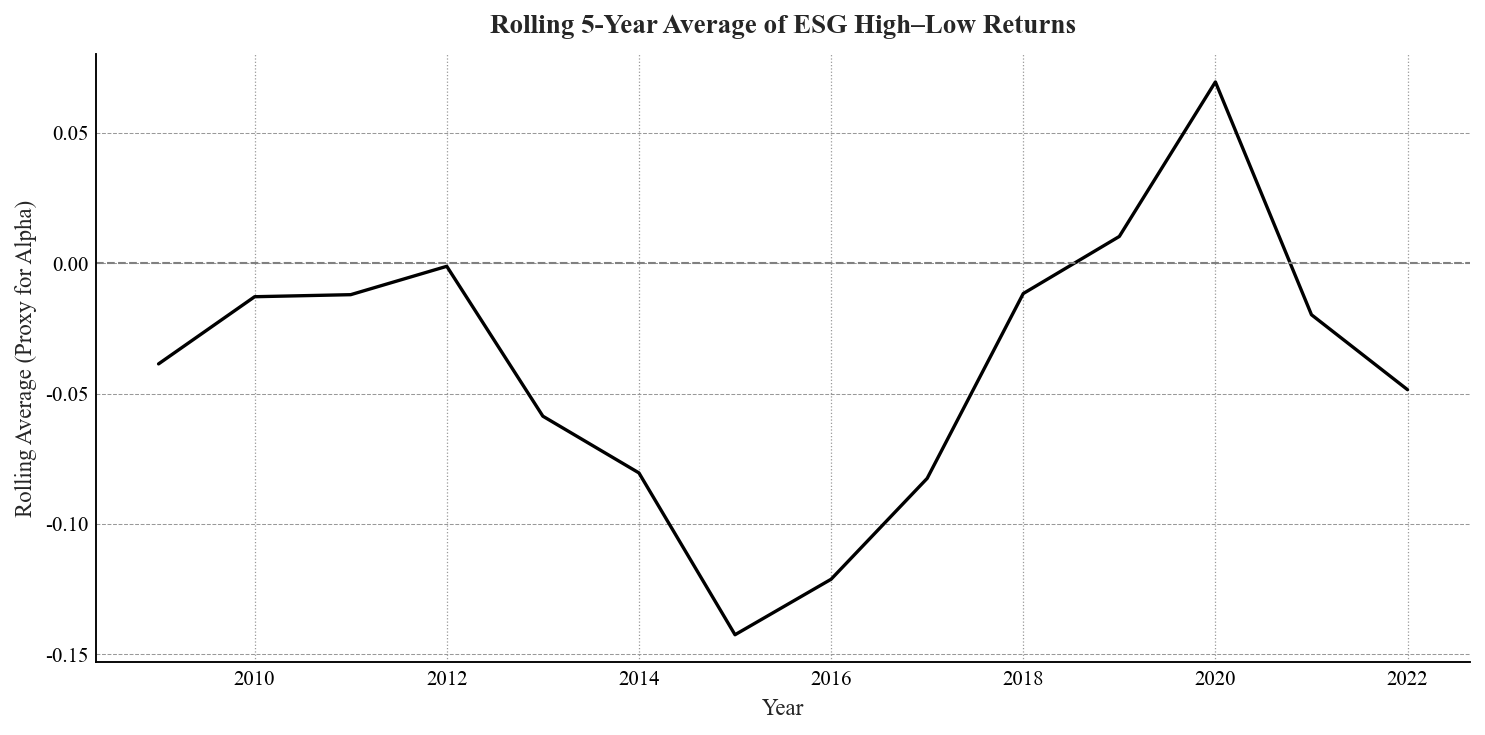

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1) 学术风设置
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# 2) 你的年度 H-L series（确保 index 是年份）
hl = esg_hl_series.copy()
hl.index = hl.index.astype(int)

# 3) Rolling alpha（用 rolling mean 近似 alpha）
rolling_alpha = hl.rolling(window=5, min_periods=3).mean()

# 4) 绘图
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(rolling_alpha.index, rolling_alpha, color="black", linewidth=1.6)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_title("Rolling 5-Year Average of ESG High–Low Returns",
             fontsize=13, fontweight="bold", pad=10)
ax.set_ylabel("Rolling Average (Proxy for Alpha)", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


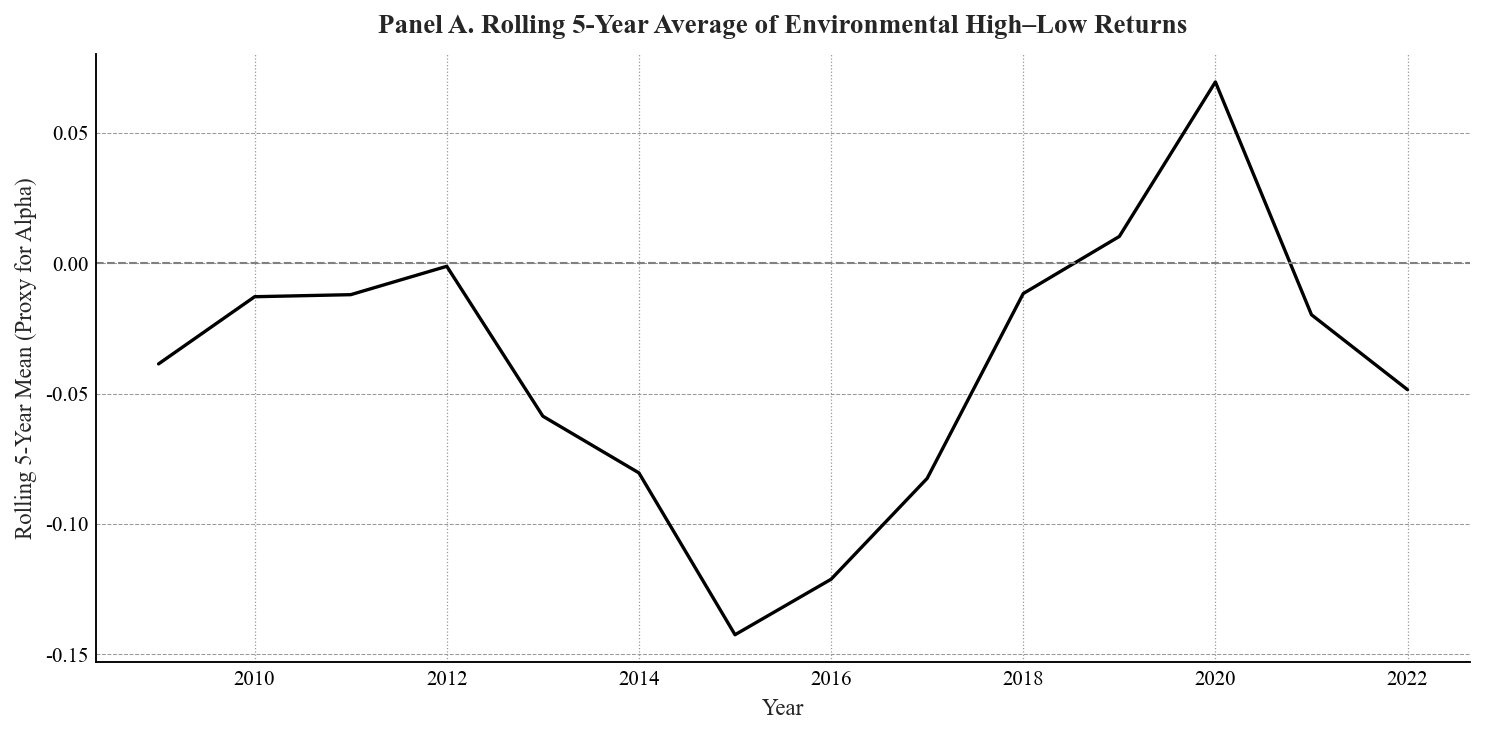

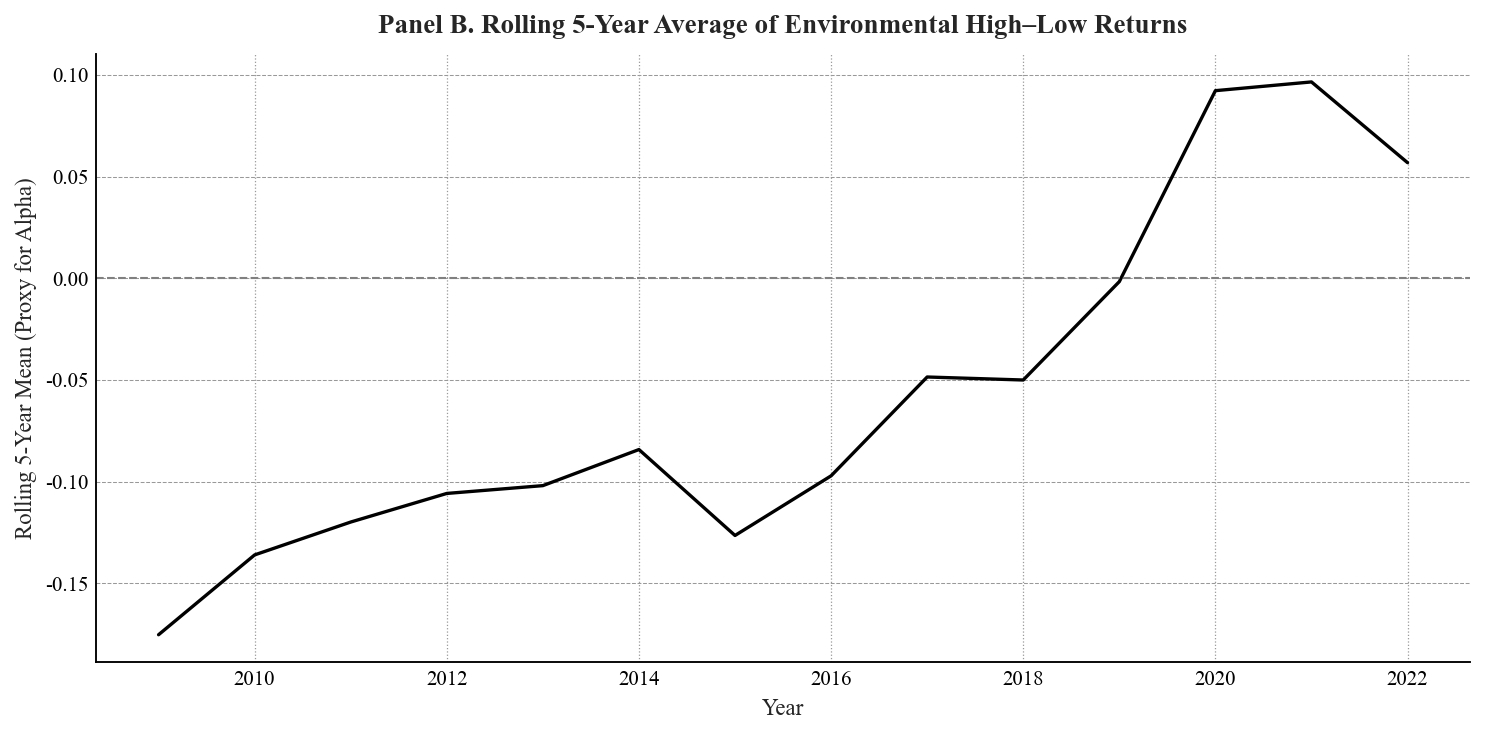

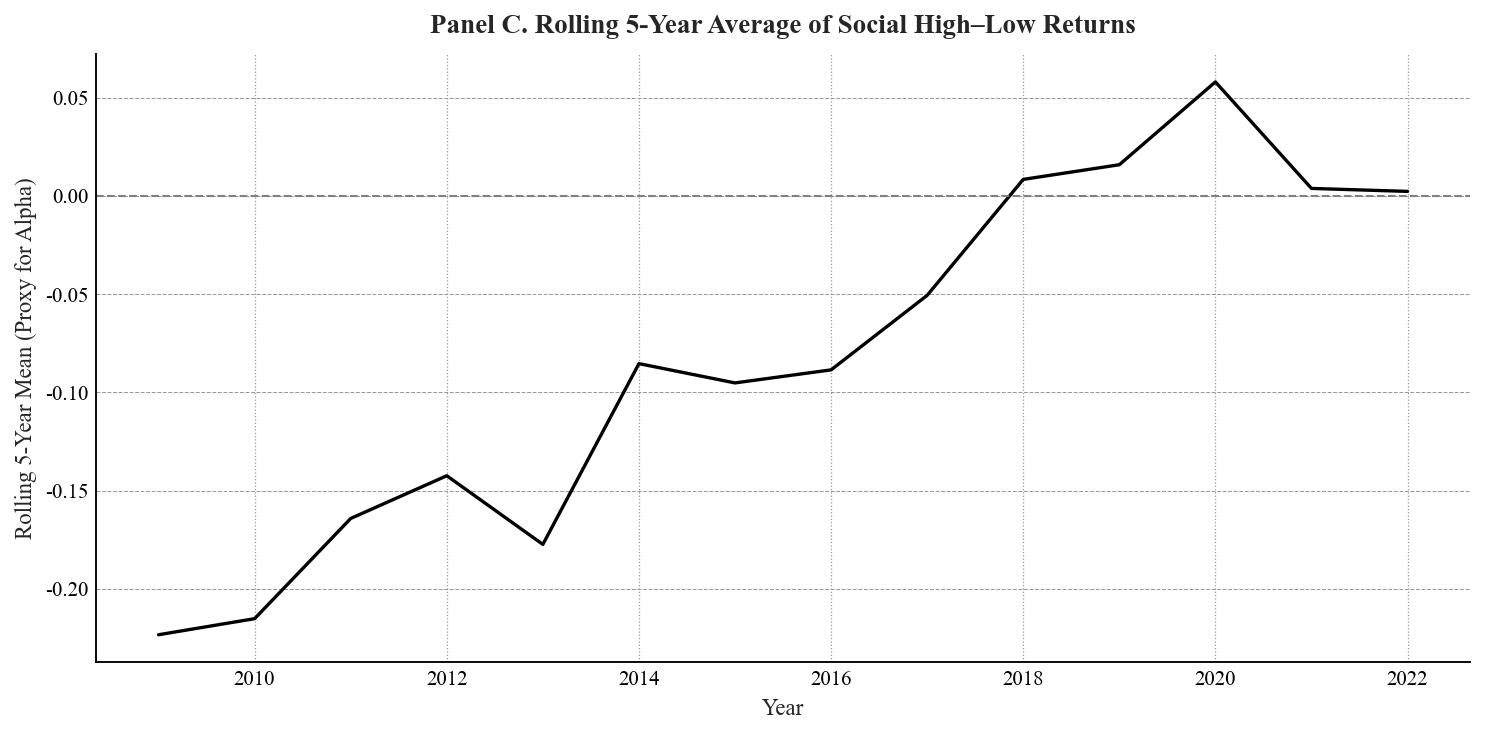

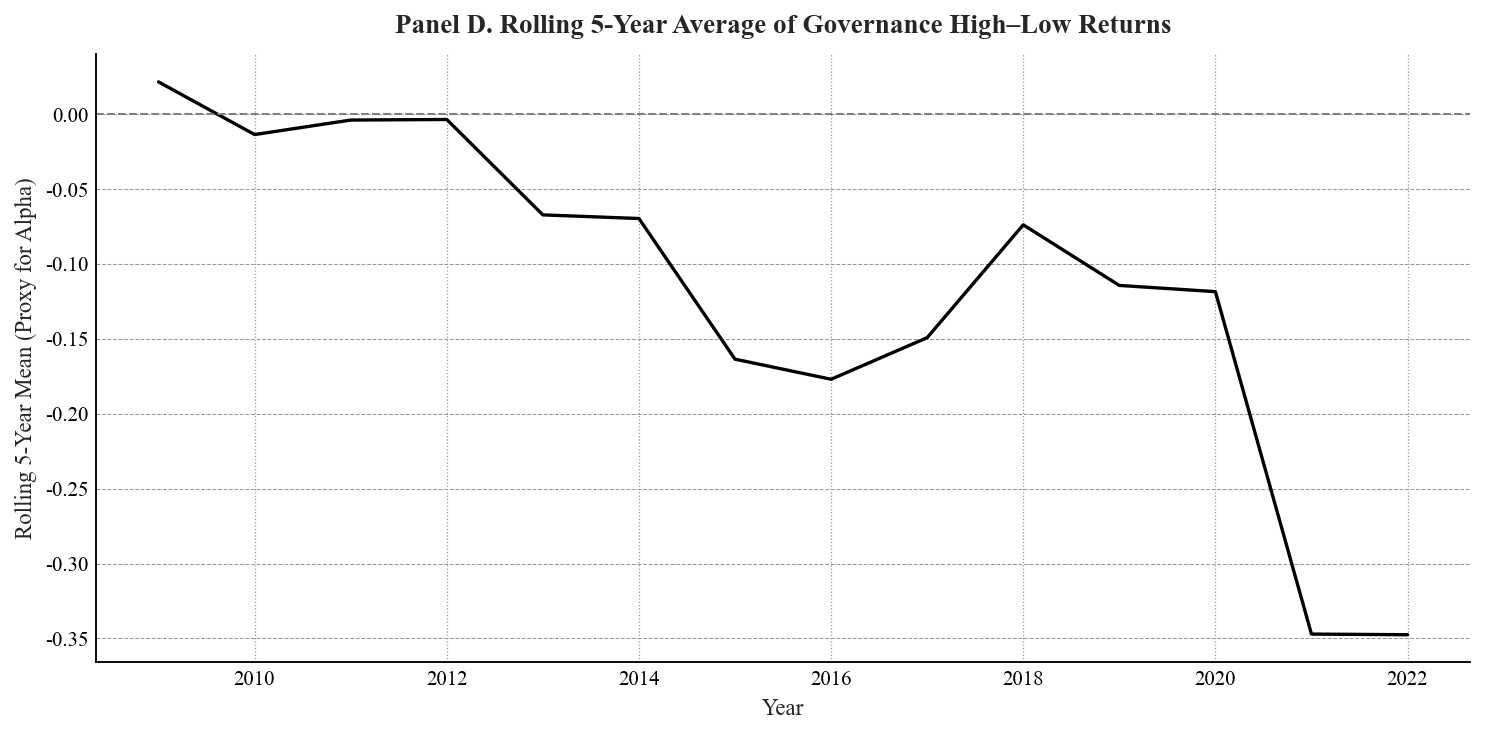

In [340]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 全局学术格式设置
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

def plot_rolling_alpha(series, title):
    """
    series: pandas Series, index 为年份, value 为 yearly H–L return
    title: 图的标题，例如 "Rolling 5-Year Average of E High–Low Returns"
    """
    hl = series.copy()
    hl.index = hl.index.astype(int)

    # Rolling (window=5 years)
    rolling_alpha = hl.rolling(window=5, min_periods=3).mean()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(rolling_alpha.index, rolling_alpha, color="black", linewidth=1.6)

    # 0 baseline
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)

    ax.set_title(title, fontsize=13, fontweight="bold", pad=10)
    ax.set_ylabel("Rolling 5-Year Mean (Proxy for Alpha)", fontsize=11)
    ax.set_xlabel("Year", fontsize=11)

    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_rolling_alpha(esg_hl_series, 
                   "Panel A. Rolling 5-Year Average of Environmental High–Low Returns")
    
plot_rolling_alpha(e_hl_series, 
                   "Panel B. Rolling 5-Year Average of Environmental High–Low Returns")

plot_rolling_alpha(s_hl_series, 
                   "Panel C. Rolling 5-Year Average of Social High–Low Returns")

plot_rolling_alpha(g_hl_series, 
                   "Panel D. Rolling 5-Year Average of Governance High–Low Returns")



#### 经济意义

* 超额收益：整体趋势下行，从 2010 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.7。在2015年到2020年，这条曲线逐年上升。直到2021年又突然下降。--> 政策因素影响曲线变化
* 波动率 & 夏普比率：波动率总体而言较小，但是由于总体收益的变动，夏普比率依然有非常高的负数概率。-> 多样化，但是负回报
* 换手率：换手率接近 88%，持仓成本过高。侧面反映出ESG 因子在中国市场中的稳定性不足，公司间排名波动大。--> 不稳定


##### **年超额收益**
整体趋势：整体趋势下行
* 从 2010 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.58
    * 这说明：在2015年之前**高 ESG 投资组合的表现不如低 ESG 投资组合**，长期下来累计收益是负的。如果一个投资者长期做 “多高 ESG / 空低 ESG” 策略，是亏钱的，在2015年钱。
* 在2015年到2020年，这条曲线逐年上升。直到2021年又突然下降。
    * 反思：2021年发生的疫情可能和曲线的突然变化有直接关系。

总结：在中国 A 股，长期内市场机制还未充分体现 ESG 的正向价值，所以表现为 ESG 高分组合长期并不显著为正。不过2015年的异常变化说明，政策相关因素会对于ESG H-L的测率产生显著影响。

In [50]:
# ===============================
# 参数：年度H-L 的日频均值年化设置
# ===============================

# -------------------------------
# (1) 年化超额收益 & 累计收益
# hl_series: index=Year, value=年度内日收益平均值(%)的高减低(H-L)
# 年化 = (1 + 日均收益)^交易日数 - 1
# -------------------------------
esg_annual_return = esg_hl_series.copy()    # 转成小数


# 累计收益 = (1 + 每年收益) 连乘
esg_cum_return = (1.0 + esg_annual_return).cumprod() - 1.0

esg_annual_ret_df = pd.DataFrame({
    "Year": esg_annual_return.index.astype(int),
    "annual_return": esg_annual_return.values,      # 小数
    "cumulative_return": esg_cum_return.values      # 小数
})

# 也可转回百分比展示：
esg_annual_ret_df_pct = esg_annual_ret_df.copy()
esg_annual_ret_df_pct["annual_return(%)"] = esg_annual_ret_df_pct["annual_return"] * 100
esg_annual_ret_df_pct["cumulative_return(%)"] = esg_annual_ret_df_pct["cumulative_return"] * 100
esg_annual_ret_df_pct = esg_annual_ret_df_pct[["Year", "annual_return(%)", "cumulative_return(%)"]]
print("\n=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===")
print(esg_annual_ret_df_pct)

# Year with Positive Return: 
esg_positive_years = esg_annual_ret_df_pct[esg_annual_ret_df_pct["annual_return(%)"]>=0]
print("\n=== 收益为正数的年份===")
print("Year with Postitive Return: ", 
      esg_positive_years["Year"].to_list()) 


=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===
    Year  annual_return(%)  cumulative_return(%)
0   2007        -13.796607            -13.796607
1   2008         -2.538308            -15.984715
2   2009          4.744029            -11.999006
3   2010          6.440577             -6.331234
4   2011         -0.894650             -7.169242
5   2012         -8.357225            -14.927317
6   2013        -31.277824            -41.536202
7   2014         -6.131968            -45.121183
8   2015        -24.589448            -58.615581
9   2016          9.744359            -54.582935
10  2017         10.987872            -49.592566
11  2018          4.156793            -47.497233
12  2019          4.818437            -44.967420
13  2020          5.040035            -42.193759
14  2021        -34.897638            -62.366772
15  2022         -3.384981            -63.640650

=== 收益为正数的年份===
Year with Postitive Return:  [2009, 2010, 2016, 2017, 2018, 2019, 2020]


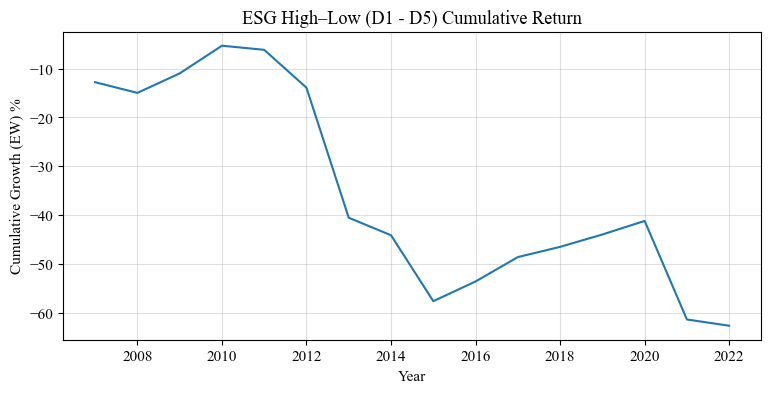

In [51]:
# 累积收益曲线
plt.figure(figsize=(9,4))
(1+esg_annual_ret_df_pct.set_index("Year")["cumulative_return(%)"]).plot() #绘画对象
plt.title("ESG High–Low (D1 - D5) Cumulative Return") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Cumulative Growth (EW) %") #Y轴名称
# plt.xticks(annual_ret_df_pct["Year"]) #X坐标轴
plt.grid(alpha=0.4)
plt.show()

##### **波动率 & 夏普比率**
整体夏普比率 (Sharpe Ratio)和波动率（Volatility）：
* Long-term Annual Return Volatility = 0.5447。
* Sharp Ratio = -1.13，远小于 0，意味着长期来看，高 ESG 组合相对低 ESG 组合并没有提供额外的风险补偿，反而表现出负收益。

年度夏普比率 (Annual Sharp Ratio)：
* Annual Volatility = 0.057 ~ 0.135，年收益率长久低于A股主板的年度股票波动率35%~，，说明高 ESG 组合相对低 ESG 组合可以提供更小的风险。
* Sharp Ratio = -2.929 ~ 2.045，反应了sharp ratio的波动性。
    * 在16年中，有7年有positive return，有9年有negative return。总体而言，negative return的年数大于positive return的年份。
    * 虽然存在风险调整后收益较高的年份，但总体上负 Sharp Ratio 出现更频繁，说明该策略缺乏长期稳定性。



===========================累积波动率 和 夏普比率===========================
Cumulative Return: -0.6364
Annual Return Volatility: 0.5535
Sharpe Ratio (rf=0): -1.1498

===========================每年波动率 和 夏普比率===========================
      annual_return  volatility  sharp_ratio
Year                                        
2007      -0.137966    0.116848    -1.180730
2008      -0.025383    0.139827    -0.181533
2009       0.047440    0.074436     0.637327
2010       0.064406    0.106542     0.604513
2011      -0.008947    0.066466    -0.134602
2012      -0.083572    0.069736    -1.198408
2013      -0.312778    0.111597    -2.802740
2014      -0.061320    0.071771    -0.854381
2015      -0.245894    0.089334    -2.752526
2016       0.097444    0.094891     1.026897
2017       0.109879    0.056043     1.960630
2018       0.041568    0.109383     0.380022
2019       0.048184    0.084470     0.570434
2020       0.050400    0.110910     0.454424
2021      -0.348976    0.111981    -3.116386
2022      

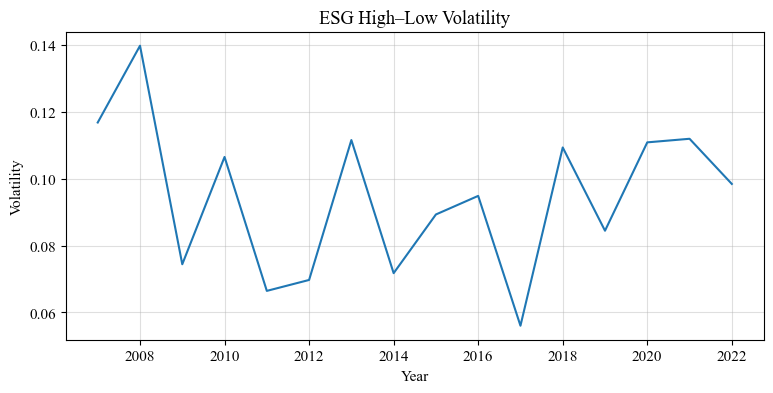

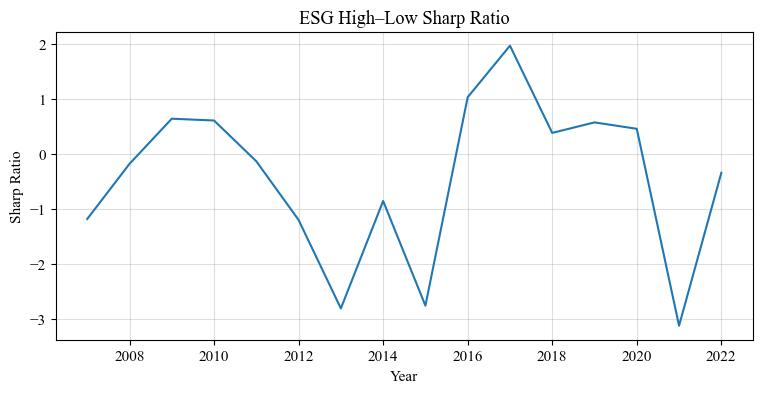

In [53]:
# ========== 1. 年波动率与夏普比率 ==========
print(f"\n===========================累积波动率 和 夏普比率===========================")
esg_mean_return = (1+esg_annual_return).product()-1
print(f"Cumulative Return: {esg_mean_return:.4f}")

esg_volatility = esg_annual_return.std()*np.sqrt(2022-2007)  # 样本标准差
print(f"Annual Return Volatility: {esg_volatility:.4f}")

# 如果假设无风险利率 rf = 0
esg_sharpe_ratio = esg_mean_return / esg_volatility
print(f"Sharpe Ratio (rf=0): {esg_sharpe_ratio:.4f}")

# ========== 2. 每年波动率与夏普比率 ==========
print(f"\n===========================每年波动率 和 夏普比率===========================")
# 1. 先从 hl_daily（日度 HL 收益）提取年份
esg_hl_daily_year = esg_hl_daily.copy()
esg_hl_daily_year.index = pd.to_datetime(esg_hl_daily_year.index)  # 确保日期是 datetime 类型
esg_hl_daily_year = esg_hl_daily_year.to_frame("hl_ret")
esg_hl_daily_year["Year"] = esg_hl_daily_year.index.year

# 2. 按年份计算波动率（这里用样本标准差）
esg_yearly_vol = esg_hl_daily_year.groupby("Year")["hl_ret"].std(ddof=1)* np.sqrt(252)

# 3. 合并到 annual_return 里
esg_annual_df = esg_annual_return.to_frame("annual_return")
esg_annual_df["volatility"] = esg_yearly_vol
esg_annual_df["sharp_ratio"] = esg_annual_df["annual_return"]/esg_annual_df["volatility"]


print(esg_annual_df)
print(f"\nAverage Volatility", round(esg_annual_df["volatility"].mean(),4))
print(f"The volatility is range from {esg_annual_df['volatility'].min():.4f} to {esg_annual_df['volatility'].max():.4f}.\n")

print(f"\nAverage Annual Sharp Ratio", round(esg_annual_df["sharp_ratio"].mean(),4))
esg_positive_years = esg_annual_df[esg_annual_df['sharp_ratio'] >= 0].index.tolist()
print(f"The number of years with positive Sharpe ratio is {len(esg_positive_years)}: {esg_positive_years}")
esg_negative_years = esg_annual_df[esg_annual_df['sharp_ratio'] <= 0].index.tolist()
print(f"The number of years with negative Sharpe ratio is {len(esg_negative_years)}: {esg_negative_years}")
print(f"The sharp ratio is range from {esg_annual_df['sharp_ratio'].min():.4f} to {esg_annual_df['sharp_ratio'].max():.4f}.")

# 波动率
plt.figure(figsize=(9,4))
(esg_annual_df["volatility"]).plot() #绘画对象
plt.title("ESG High–Low Volatility") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Volatility") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

# 夏普比率
plt.figure(figsize=(9,4))
(esg_annual_df["sharp_ratio"]).plot() #绘画对象
plt.title("ESG High–Low Sharp Ratio") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Sharp Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

##### **换手率** 
* 换手率的范围是 0.7663 到 1.0212。平均换手率为88.8%。
    * 高持仓成本：这说明几乎每年都有将近九成的组合成分股被替换。也就是说，ESG因子组合的持仓稳定性较低。高换手率意味着 ESG 组合缺乏持续性，说明 ESG 排名靠前/靠后的公司变化较快。
    * 稳定性不足：ESG 因子在中国市场中的 稳定性不足，公司间排名波动大。
    * 趋势下降：总体而言，换手率每年逐渐下降。

    Year  Turnover_Long  Turnover_Short  Turnover_LongShort
0   2008       0.814433        1.230241            1.022337
1   2009       0.683386        1.203762            0.943574
2   2010       0.888312        1.179221            1.033766
3   2011       0.733796        0.956019            0.844907
4   2012       0.833698        1.122807            0.978253
5   2013       0.671674        0.965665            0.818670
6   2014       0.751020        1.106339            0.928680
7   2015       0.705104        1.103970            0.904537
8   2016       0.673435        1.116751            0.895093
9   2017       0.739065        1.025680            0.882372
10  2018       0.714495        0.926794            0.820644
11  2019       0.628767        0.990411            0.809589
12  2020       0.552632        1.059809            0.806220
13  2021       0.614301        1.130011            0.872156
14  2022       0.718847        1.143151            0.930999

The average turnover rate is 0.8995.
Th

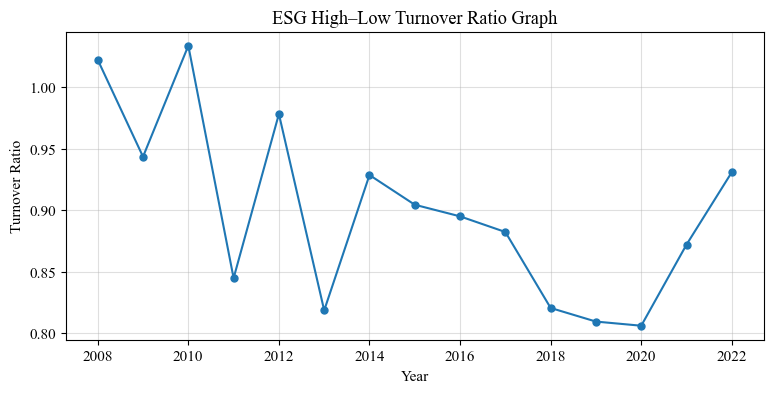

In [55]:
# 计算换手率
def calc_turnover_ls(df, group_col="ESG_decile", long_decile=1, short_decile=5):
    turnover_list = []
    years = sorted(df["Year"].unique())
    
    for i in range(1, len(years)): # 重复从第一年 到 最后一年
        prev_year = years[i-1]
        curr_year = years[i]
        
        # Long 组合（D1）
        prev_long = set(df[(df["Year"]==prev_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = previous year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        curr_long = set(df[(df["Year"]==curr_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = current year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        turnover_long = (len(curr_long - prev_long) + len(prev_long - curr_long)) / max(1, len(curr_long))
        # 解释：len(curr_long - prev_long)：今天有但是过去没有long的。
        # len(prev_long - curr_long) 去年有，但是今年没有的股票。
        # len(curr_long - prev_long) + len(prev_long - curr_long)：新进股票数 + 退出股票数 = 这一年组合发生变动的股票总数。
        # 除以当前组合的股票总数（避免除以 0）
        
        # Short 组合（D5）
        prev_short = set(df[(df["Year"]==prev_year) & (df[group_col]==short_decile)]["stock_code"])
        curr_short = set(df[(df["Year"]==curr_year) & (df[group_col]==short_decile)]["stock_code"])
        turnover_short = (len(curr_short - prev_short) + len(prev_short - curr_short)) / max(1, len(curr_short))
        
        # Long–Short 组合换手率
        turnover_ls = 0.5 * (turnover_long + turnover_short)
        
        turnover_list.append({
            "Year": curr_year,
            "Turnover_Long": turnover_long,
            "Turnover_Short": turnover_short,
            "Turnover_LongShort": turnover_ls
        })
    
    return pd.DataFrame(turnover_list)

# 运行
esg_turnover_ls_df = calc_turnover_ls(df_with_esg, "ESG_decile", long_decile=1, short_decile=5)
print(esg_turnover_ls_df)
print(f"\nThe average turnover rate is {esg_turnover_ls_df['Turnover_LongShort'].mean():.4f}.")
print(f"The turnover rate is range from {esg_turnover_ls_df['Turnover_LongShort'].min():.4f} to {esg_turnover_ls_df['Turnover_LongShort'].max():.4f}.")

# 换手率
plt.figure(figsize=(9,4))
(esg_turnover_ls_df.set_index('Year')['Turnover_LongShort']).plot(marker='o') #绘画对象
plt.title("ESG High–Low Turnover Ratio Graph") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Turnover Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

### E Score 简单检验：不显著
简单检验：看 High vs. Low 的平均收益差异是否显著（t-test）。

#### 假设检验

##### 一组简单检验
10个decile，significance level = 10%

In [59]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["E_decile"] = (
    df_with_esg.groupby("Year")["E_Score"]
    .transform(lambda x: pd.qcut(-x, 10, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "E_Score", "E_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
e_portfolio_returns = (
    df_with_esg.groupby(["Year", "E_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="E_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(e_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
e_hl_series = e_portfolio_returns[1] - e_portfolio_returns[10]
e_hl_series.name = "E_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== E High–Low (D1 - D10) 因子：逐年收益 ======")
print(e_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
e_hl_mean = e_hl_series.mean()
e_hl_std  = e_hl_series.std()
print(f"\nE_HL 平均收益: {e_hl_mean:.6f}, 标准差: {e_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(e_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
E_decile        1         2         3         4         5         6   \
Year                                                                   
2007      0.530206  0.564900  0.549551  0.507546  0.528486  0.502869   
2008     -0.306101 -0.278280 -0.219655 -0.237051 -0.247446 -0.219848   
2009      0.409500  0.354531  0.379964  0.371721  0.372987  0.420925   
2010      0.075735  0.091013  0.090487  0.102998  0.122256  0.142253   
2011     -0.123288 -0.123669 -0.129626 -0.120026 -0.111104 -0.131342   

E_decile        7         8         9         10  
Year                                              
2007      0.551777  0.511850  0.481698       NaN  
2008     -0.276054 -0.274844 -0.274387 -0.232817  
2009      0.401751  0.352668  0.353107       NaN  
2010      0.009076  0.066838  0.075302       NaN  
2011     -0.097458 -0.095391 -0.079202       NaN  

====== E High–Low (D1 - D10) 因子：逐年收益 ======
Year

##### 二组简单检验
5个decile，significance level = 5%

In [61]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["E_decile"] = (
    df_with_esg.groupby("Year")["E_Score"]
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "E_Score", "E_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
e_portfolio_returns = (
    df_with_esg.groupby(["Year", "E_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="E_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(e_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
e_hl_series = e_portfolio_returns[1] - e_portfolio_returns[5]
e_hl_series.name = "E_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== E High–Low (D1 - D10) 因子：逐年收益 ======")
print(e_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
e_hl_mean = e_hl_series.mean()
e_hl_std  = e_hl_series.std()
print(f"\nE_HL 平均收益: {e_hl_mean:.6f}, 标准差: {e_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(e_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.05 else '不显著'})")

e_hl_series_5 = e_hl_series 

Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
E_decile         1         2         3         4         5
Year                                                      
2007      0.547672  0.523513  0.528486  0.533683  0.498558
2008     -0.291597 -0.228135 -0.232984 -0.274970 -0.251991
2009      0.381427  0.376275  0.394704  0.401751  0.352961
2010      0.083433  0.096903  0.131297  0.009076  0.071230
2011     -0.123479 -0.124826 -0.125198 -0.097458 -0.086896

====== E High–Low (D1 - D10) 因子：逐年收益 ======
Year
2007    0.049114
2008   -0.039606
2009    0.028466
2010    0.012203
2011   -0.036583
Name: E_HL, dtype: float64

E_HL 平均收益: -0.004508, 标准差: 0.032467
t-test: t = -0.555, p = 0.587  (不显著)


##### 三组简单检验
特点：
* 5 decile
* 市值加权（频次：年）
* 复利回报（频次：天 和 年累积）
* alpha = 10%

In [63]:
# 1) 年内分组（D1=最好，D5=最差）
df_with_esg["E_decile"] = (
    df_with_esg.groupby("Year")["E_Score"]
    # 把df_with_esg切成小组，并提取每年的ESG_score。
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
    # transform和.apply()等不同，会返回一个和原始DF长度一样的索引。它的含义是对于每个分组单独执行一个函数。然后把结果展开会原来的行数。
    # pd.qcut()按照分位切箱，它输出的结果是一个series或者其他格式，作用于(pd.quct(x))里的数据。
)
# 含义：把df_with_esg按照年分组，并且对于每年（每组）的esg_score进行一个分位数函数。

# 2) 把“年频标签 + 市值”合并到日频收益表上
# 假设 stock_return 有列: Date(YYYYMMDD或日期), stock_code, return(单日收益)
stock_return["Year"] = stock_return["Date"].dt.year #创立"Year" col方便和 df_with_esg的年频次数据对其。
df_with_esg["stock_code"] = df_with_esg["stock_code"].astype(str).str.zfill(6)

use_cols = ["Year", "stock_code", "E_decile", "market_cap"] #需要用的columns
merged = stock_return.merge(df_with_esg[use_cols], on=["Year", "stock_code"], how="inner") #创建新数据囊括两张表格内容。

# 3) 每天、每个 decile 的“市值加权”日收益
# 定义函数wret(g)
# 内容：对一个分组（同一天、同一个 ESG_decile 的股票集合）计算市值加权平均收益。
def _vwret(g):
    w = np.clip(g["market_cap"].to_numpy(), 0, None) # 把市值的大小限制在0以上。
    r = g["return"].to_numpy() / 100.0   # 把百分数转成小数
    if w.sum() == 0 or np.all(np.isnan(w)):  # 避免全 0 或 NaN
        return np.nanmean(r) # 如果以上两种情况存在，就返回average return（忽略NaN）
    return np.average(r, weights=w) # 否则返回weighted return，加权回报

# 计算每天的weighted_return 
e_daily_vw = (
    merged.dropna(subset=["return", "market_cap"]) #去掉没有收益和数值的列
          .groupby(["Date", "E_decile"]) # 按照年份和 ESG_decile分组
          .apply(_vwret) #每一组进行weighed_return的计算
          .reset_index(name="day_ret")
)

# 4A) 想要“年度复利收益”用于显著性检验：
e_daily_vw["Year"] = e_daily_vw["Date"].dt.year
# 计算年度加权复利回报
e_annual_vw = (
    e_daily_vw.assign(log1p=np.log1p(e_daily_vw["day_ret"]))
            # .assign(新列名 = 表达式, ...)用来新增列。
            # np.log1p是把天简单收益变成log(1+x)对数收益，对数收益可以直接相加。
            .groupby(["Year", "E_decile"])["log1p"].sum()
            # 计算对数收益之和。
            .pipe(lambda s: np.expm1(s))  # = (1+r)连乘 - 1 的稳定写法
            # .pipe()：把签名series的内容，作为第一个参数传给function 并返回函数结果。
            # 链式结构专属：res = s.pipe(np.log1p) 等价于 res = np.log1p(s)
            # 函数 np.expm1() 代表expm1(s)=es−1
            .reset_index(name="annual_return")
            # 把结果改为annual_return
            .pivot(index="Year", columns="E_decile", values="annual_return")
            # pivot 就是 表格旋转，让数据从 长表（long format） 变成 宽表（wide format）。
            # Year作为索引，ESG_decile作为列名字，数值是年度回报。
)

# 4B) 如果你只想“日度统计/波动率”：
# wide = daily_vw.pivot(index="Date", columns="ESG_decile", values="day_ret")
# hl_daily = (wide[1] - wide[5]).dropna()
# ann_vol = hl_daily.std() * np.sqrt(252)

# HL（D1 - D5）逐年（复利）收益 & t检验
e_hl_series = e_annual_vw[1] - e_annual_vw[5] #构建 H-L 因子
tstat, pval = ttest_1samp(e_hl_series.dropna(), 0.0) # 单样本t检验，假设alpha = 0 


print("\n====== E decile portfolios (年累积收益率) ======")
print(e_annual_vw)   # ✅ 打印完整结果，不截断

# Step 3: 构造 ESG High–Low 因子（D1 - D5）
print("\n====== E High–Low (D1 - D5) 因子：逐年收益 ======")
print(e_hl_series)   # ✅ 打印完整结果，不截断



====== E decile portfolios (年累积收益率) ======
E_decile         1         2         3         4         5
Year                                                      
2007      2.208726  2.093534  2.243172  2.186480  2.359790
2008     -0.611762 -0.590293 -0.560725 -0.606593 -0.621357
2009      1.064336  1.277562  1.283605  1.211806  1.448987
2010     -0.095862  0.010730  0.079723 -0.066617 -0.077585
2011     -0.256829 -0.163973 -0.191153 -0.241194 -0.201559
2012      0.047757  0.109290  0.033499  0.120284  0.128468
2013      0.035398 -0.002484  0.104058  0.345272  0.006605
2014      0.480148  0.590554  0.561866  0.448296  0.776032
2015      0.323656  0.362693  0.548689  0.341096  0.553304
2016     -0.012539 -0.036047 -0.043607 -0.089269 -0.103992
2017      0.210405  0.187701  0.166671  0.056416  0.048008
2018     -0.219809 -0.188714 -0.197065 -0.211372 -0.241201
2019      0.411685  0.348799  0.377113  0.288423  0.465580
2020      0.578510  0.266196  0.195183  0.351001  0.338430
2021      0.

In [64]:
# ====== Step 5：显著性检验（年度 HL 序列）======

# 丢 NaN
e_hl_series = e_hl_series.dropna()

# 简单统计
e_hl_mean = e_hl_series.mean()
e_hl_std  = e_hl_series.std(ddof=1)

# Step 6: 简单统计 & 显著性检验
print("\n====== E High–Low (D1 - D5) 因子：总体统计 ======")
print(f"平均收益: {e_hl_mean:.6f}, 标准差: {e_hl_std:.6f}")

tstat, pval = ttest_1samp(e_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f} "
      f"({'显著' if pval < 0.10 else '不显著'})")

# 把日度 D1、D5 以及 HL 取出来
wide = e_daily_vw.pivot(index="Date", columns="E_decile", values="day_ret").sort_index()
e_hl_daily = (wide[1] - wide[5]).dropna()

# 日度统计与年化指标
e_mu_d   = e_hl_daily.mean()
e_vol_d  = e_hl_daily.std(ddof=1)
e_mu_ann = e_mu_d * 252
e_vol_ann= e_vol_d * np.sqrt(252)

print("\n====== E High–Low (D1 - D5) 日度：统计量 ======")
print(f"日均: {e_mu_d:.6f}, 日波动: {e_vol_d:.6f}  |  年化均值: {e_mu_ann:.6f}, 年化波动: {e_vol_ann:.6f}")

# 对“日度 HL”做均值检验（是否显著不为 0）
tstat_d, pval_d = ttest_1samp(e_hl_daily, 0.0)
print(f"t-test（日度HL）: t = {tstat_d:.3f}, p = {pval_d:.3f}  "
      f"({'显著' if pval_d < 0.10 else '不显著'})")


====== E High–Low (D1 - D5) 因子：总体统计 ======
平均收益: -0.039935, 标准差: 0.164555
t-test: t = -0.971, p = 0.347 (不显著)

====== E High–Low (D1 - D5) 日度：统计量 ======
日均: -0.000080, 日波动: 0.005930  |  年化均值: -0.020057, 年化波动: 0.094133
t-test（日度HL）: t = -0.837, p = 0.403  (不显著)


#### 经济意义

* 超额收益：整体趋势下行，从 2010 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.7。在2015年之后，这条曲线逐年上升。直到2021年小幅度下降。--> 政策因素影响曲线变化
* 波动率 & 夏普比率：波动率总体而言较小，但是由于总体收益的变动，夏普比率依然有非常高的负数概率。-> 多样化，但是负回报
* 换手率：换手率接近 60%，持仓成本过高。侧面反映出E 因子在中国市场中的稳定性不足，公司间排名波动大。--> 不稳定
    * 为什么E H-L的换手率会在2022年突然上升？


##### **年超额收益**
整体趋势：整体趋势下行
* 从 2010 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.7
    * 这说明：在2015年之前**高 E 投资组合的表现不如低 E 投资组合**，长期下来累计收益是负的。如果一个投资者长期做 “多高 E / 空低 E” 策略，是亏钱的，在2015年前。
* 在2015年到2022年，这条曲线逐年上升。直到2021年又微小下降。
    * 反思：2015年是否发生了特别的事情，导致了特别的变化。

总结：在中国 A 股，长期内市场机制还未充分体现 E 的正向价值，所以表现为 E 高分组合长期并不显著为正。不过2015年的异常变化说明，政策相关因素会对于E H-L的测率产生显著影响。  
**其他观察：** E H-L 组合收益的变化和 ESG H-L 组合收益的变化非常的相似。他们都在相同的年份上涨。有没有可能相同的因素影响了 ESG H-L 和 E H-L的变化。

In [67]:
# ===============================
# 参数：年度H-L 的日频均值年化设置
# ===============================

# -------------------------------
# (1) 年化超额收益 & 累计收益
# hl_series: index=Year, value=年度内日收益平均值(%)的高减低(H-L)
# 年化 = (1 + 日均收益)^交易日数 - 1
# -------------------------------
e_annual_return = e_hl_series.copy()    # 转成小数


# 累计收益 = (1 + 每年收益) 连乘
e_cum_return = (1.0 + e_annual_return).cumprod() - 1.0

e_annual_ret_df = pd.DataFrame({
    "Year": e_annual_return.index.astype(int),
    "annual_return": e_annual_return.values,      # 小数
    "cumulative_return": e_cum_return.values      # 小数
})

# 也可转回百分比展示：
e_annual_ret_df_pct = e_annual_ret_df.copy()
e_annual_ret_df_pct["annual_return(%)"] = e_annual_ret_df_pct["annual_return"] * 100
e_annual_ret_df_pct["cumulative_return(%)"] = e_annual_ret_df_pct["cumulative_return"] * 100
e_annual_ret_df_pct = e_annual_ret_df_pct[["Year", "annual_return(%)", "cumulative_return(%)"]]
print("\n=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===")
print(e_annual_ret_df_pct)

# Year with Positive Return: 
positive_years = e_annual_ret_df_pct[e_annual_ret_df_pct["annual_return(%)"]>=0]
print("\n=== 收益为正数的年份===")
print("Year with Postitive Return: ", 
      positive_years["Year"].to_list()) 


=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===
    Year  annual_return(%)  cumulative_return(%)
0   2007        -15.106401            -15.106401
1   2008          0.959422            -14.291913
2   2009        -38.465108            -47.259621
3   2010         -1.827734            -48.223575
4   2011         -5.526951            -51.085232
5   2012         -8.071062            -55.033174
6   2013          2.879297            -53.738445
7   2014        -29.588439            -67.426517
8   2015        -22.964799            -74.906952
9   2016          9.145307            -72.612116
10  2017         16.239646            -68.164420
11  2018          2.139219            -67.483387
12  2019         -5.389504            -69.235872
13  2020         24.007974            -61.850028
14  2021         11.294184            -57.541299
15  2022         -3.620525            -59.078527

=== 收益为正数的年份===
Year with Postitive Return:  [2008, 2013, 2016, 2017, 2018, 2020, 2021]


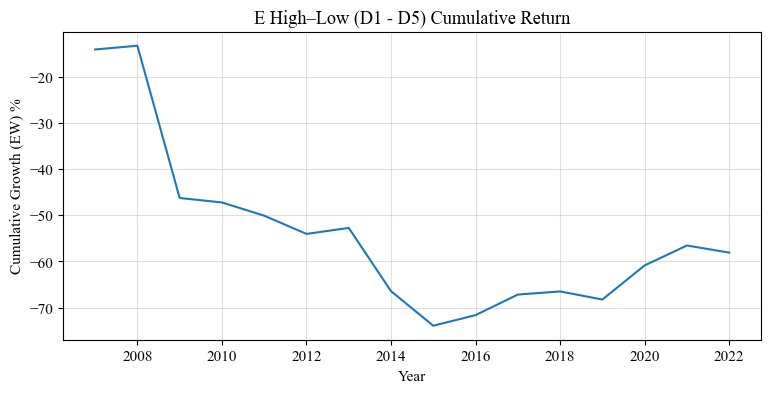

In [68]:
# 累积收益曲线
plt.figure(figsize=(9,4))
(1+e_annual_ret_df_pct.set_index("Year")["cumulative_return(%)"]).plot() #绘画对象
plt.title("E High–Low (D1 - D5) Cumulative Return") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Cumulative Growth (EW) %") #Y轴名称
# plt.xticks(annual_ret_df_pct["Year"]) #X坐标轴
plt.grid(alpha=0.4)
plt.show()

##### **波动率 & 夏普比率**
整体夏普比率 (Sharpe Ratio)和波动率（Volatility）：
* Yearly Return's Volatility = 0.6186。
* Sharp Ratio = -0.89，小于 0，意味着长期来看，高 ESG 组合相对低 ESG 组合并没有提供额外的风险补偿，反而表现出负收益。

年度夏普比率 (Annual Sharp Ratio)：
* Annual Volatility = 0.071 ~ 0.152，年收益率长久低于A股主板的年度股票波动率35%~，说明高 ESG 组合相对低 ESG 组合可以提供更小的风险。
* Sharp Ratio = -3.726 ~ 2.296，反应了sharp ratio的波动性。
    * 在16年中，有7年有positive return，有9年有negative return。总体而言，negative return的年数大于positive return的年份。
    * Sharp ratio总体而言有上升的趋势，说明最近人们逐渐意识到了E H-L的重要性。


===========================累积波动率 和 夏普比率===========================
Cumulative Return: -0.5908
Annual Return Volatility: 0.6373
Sharpe Ratio (rf=0): -0.9270

===========================每年波动率 和 夏普比率===========================
      annual_return  volatility  sharp_ratio
Year                                        
2007      -0.151064    0.107914    -1.399852
2008       0.009594    0.108107     0.088748
2009      -0.384651    0.103144    -3.729254
2010      -0.018277    0.081215    -0.225049
2011      -0.055270    0.071214    -0.776106
2012      -0.080711    0.078369    -1.029876
2013       0.028793    0.117819     0.244384
2014      -0.295884    0.098560    -3.002089
2015      -0.229648    0.104926    -2.188669
2016       0.091453    0.073261     1.248314
2017       0.162396    0.070722     2.296271
2018       0.021392    0.083277     0.256880
2019      -0.053895    0.083576    -0.644859
2020       0.240080    0.104866     2.289398
2021       0.112942    0.098314     1.148788
2022      

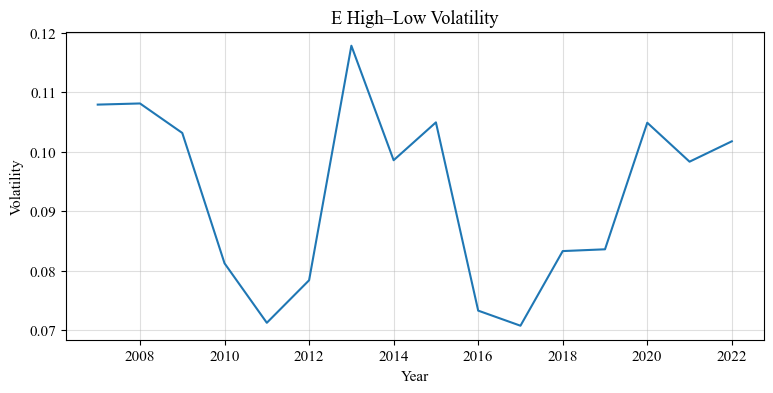

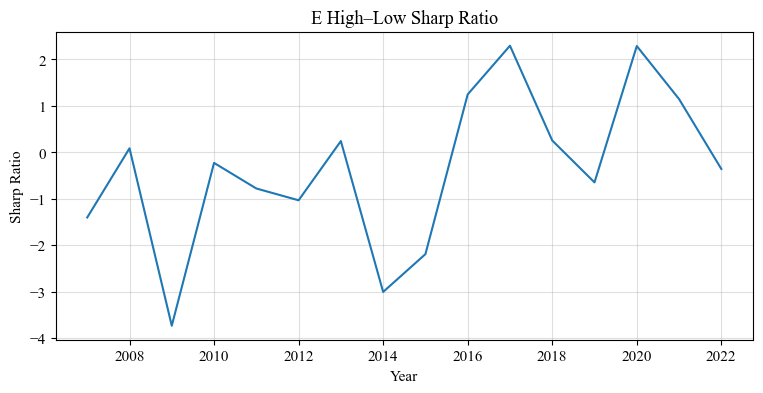

In [70]:
# ========== 1. 年波动率与夏普比率 ==========
print(f"\n===========================累积波动率 和 夏普比率===========================")
e_mean_return = (1+e_annual_return).product()-1
print(f"Cumulative Return: {e_mean_return:.4f}")

e_volatility = e_annual_return.std()*np.sqrt(2022-2007)  # 样本标准差
print(f"Annual Return Volatility: {e_volatility:.4f}")

# 如果假设无风险利率 rf = 0
e_sharpe_ratio = e_mean_return / e_volatility
print(f"Sharpe Ratio (rf=0): {e_sharpe_ratio:.4f}")

# ========== 2. 每年波动率与夏普比率 ==========
print(f"\n===========================每年波动率 和 夏普比率===========================")
# 1. 先从 hl_daily（日度 HL 收益）提取年份
e_hl_daily_year = e_hl_daily.copy()
e_hl_daily_year.index = pd.to_datetime(e_hl_daily_year.index)  # 确保日期是 datetime 类型
e_hl_daily_year = e_hl_daily_year.to_frame("hl_ret")
e_hl_daily_year["Year"] = e_hl_daily_year.index.year

# 2. 按年份计算波动率（这里用样本标准差）
e_yearly_vol = e_hl_daily_year.groupby("Year")["hl_ret"].std(ddof=1)* np.sqrt(252)

# 3. 合并到 annual_return 里
e_annual_df = e_annual_return.to_frame("annual_return")
e_annual_df["volatility"] = e_yearly_vol
e_annual_df["sharp_ratio"] = e_annual_df["annual_return"]/e_annual_df["volatility"]

print(e_annual_df)
print(f"\nAverage Volatility", round(e_annual_df["volatility"].mean(),4))
print(f"The volatility is range from {e_annual_df['volatility'].min():.4f} to {e_annual_df['volatility'].max():.4f}.\n")

print(f"\nAverage Annual Sharp Ratio", round(e_annual_df["sharp_ratio"].mean(),4))
e_positive_years = e_annual_df[e_annual_df['sharp_ratio'] >= 0].index.tolist()
print(f"The number of years with positive Sharpe ratio is {len(e_positive_years)}: {e_positive_years}")
e_negative_years = e_annual_df[e_annual_df['sharp_ratio'] <= 0].index.tolist()
print(f"The number of years with negative Sharpe ratio is {len(e_negative_years)}: {e_negative_years}")
print(f"The sharp ratio is range from {e_annual_df['sharp_ratio'].min():.4f} to {e_annual_df['sharp_ratio'].max():.4f}.")


# 波动率
plt.figure(figsize=(9,4))
(e_annual_df["volatility"]).plot() #绘画对象
plt.title("E High–Low Volatility") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Volatility") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

# 夏普比率
plt.figure(figsize=(9,4))
(e_annual_df["sharp_ratio"]).plot() #绘画对象
plt.title("E High–Low Sharp Ratio") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Sharp Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

##### **换手率** 
* 换手率的范围是 0.4716 到 1.1203。平均换手率为60.22%。
    * 高持仓成本：这说明几乎每年都有将近六成的组合成分股被替换。也就是说，E因子组合的持仓稳定性较低。高换手率意味着 E 组合缺乏持续性，说明 E 排名靠前/靠后的公司变化较快。
    * 稳定性不足：E 因子在中国市场中的 稳定性不足，公司间排名波动大。
    * 趋势下降：总体而言，换手率在2021之前年相对稳定，只是2022年突然变化。这是由于在2021年期间进行的碳排放在2022年时逐步落实，让所有企业的E打分都大幅提高。这反应了政策因素对于股票变动的影响。

    Year  Turnover_Long  Turnover_Short  Turnover_LongShort
0   2008       0.895082        0.487085            0.691083
1   2009       0.428135        0.987500            0.707817
2   2010       0.514139        0.795699            0.654919
3   2011       0.766744        0.504950            0.635847
4   2012       0.638950        0.674107            0.656528
5   2013       0.444206        0.939086            0.691646
6   2014       0.417004        0.760000            0.588502
7   2015       0.428571        0.755319            0.591945
8   2016       0.486486        0.722420            0.604453
9   2017       0.622754        0.705660            0.664207
10  2018       0.631040        0.522581            0.576810
11  2019       0.365753        0.699176            0.532465
12  2020       0.485646        0.746959            0.616302
13  2021       0.449621        0.900325            0.674973
14  2022       1.121730        1.159959            1.140845

The average turnover rate is 0.6686.
Th

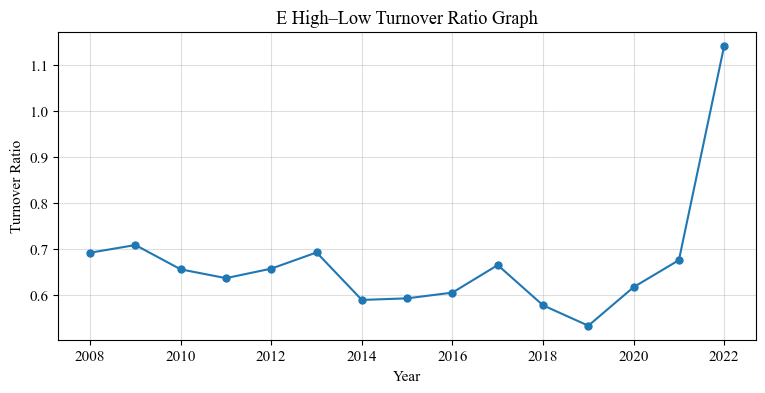

In [72]:
# 计算换手率
def calc_turnover_ls(df, group_col="E_decile", long_decile=1, short_decile=5):
    turnover_list = []
    years = sorted(df["Year"].unique())
    
    for i in range(1, len(years)): # 重复从第一年 到 最后一年
        prev_year = years[i-1]
        curr_year = years[i]
        
        # Long 组合（D1）
        prev_long = set(df[(df["Year"]==prev_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = previous year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        curr_long = set(df[(df["Year"]==curr_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = current year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        turnover_long = (len(curr_long - prev_long) + len(prev_long - curr_long)) / max(1, len(curr_long))
        # 解释：len(curr_long - prev_long)：今天有但是过去没有long的。
        # len(prev_long - curr_long) 去年有，但是今年没有的股票。
        # len(curr_long - prev_long) + len(prev_long - curr_long)：新进股票数 + 退出股票数 = 这一年组合发生变动的股票总数。
        # 除以当前组合的股票总数（避免除以 0）
        
        # Short 组合（D5）
        prev_short = set(df[(df["Year"]==prev_year) & (df[group_col]==short_decile)]["stock_code"])
        curr_short = set(df[(df["Year"]==curr_year) & (df[group_col]==short_decile)]["stock_code"])
        turnover_short = (len(curr_short - prev_short) + len(prev_short - curr_short)) / max(1, len(curr_short))
        
        # Long–Short 组合换手率
        turnover_ls = 0.5 * (turnover_long + turnover_short)
        
        turnover_list.append({
            "Year": curr_year,
            "Turnover_Long": turnover_long,
            "Turnover_Short": turnover_short,
            "Turnover_LongShort": turnover_ls
        })
    
    return pd.DataFrame(turnover_list)

# 运行
e_turnover_ls_df = calc_turnover_ls(df_with_esg, "E_decile", long_decile=1, short_decile=5)
print(e_turnover_ls_df)
print(f"\nThe average turnover rate is {e_turnover_ls_df['Turnover_LongShort'].mean():.4f}.")
print(f"The turnover rate is range from {e_turnover_ls_df['Turnover_LongShort'].min():.4f} to {e_turnover_ls_df['Turnover_LongShort'].max():.4f}.")

# 换手率
plt.figure(figsize=(9,4))
(e_turnover_ls_df.set_index('Year')['Turnover_LongShort']).plot(marker='o') #绘画对象
plt.title("E High–Low Turnover Ratio Graph") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Turnover Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

### S Score 简单检验：显著
简单检验：看 High vs. Low 的平均收益差异是否显著（t-test）。

#### 假设检验

##### 一组简单检验
10个decile，significance level = 10%

In [76]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["S_decile"] = (
    df_with_esg.groupby("Year")["S_Score"]
    .transform(lambda x: pd.qcut(-x, 10, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "E_Score", "E_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
s_portfolio_returns = (
    df_with_esg.groupby(["Year", "S_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="S_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(s_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
s_hl_series = s_portfolio_returns[1] - s_portfolio_returns[10]
s_hl_series.name = "S_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== S High–Low (D1 - D10) 因子：逐年收益 ======")
print(s_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
s_hl_mean = s_hl_series.mean()
s_hl_std  = s_hl_series.std()
print(f"\nE_HL 平均收益: {s_hl_mean:.6f}, 标准差: {s_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(s_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
S_decile        1         2         3         4         5         6   \
Year                                                                   
2007      0.541792  0.524763  0.542314  0.542682  0.545339  0.553531   
2008     -0.267332 -0.283402 -0.240794 -0.246810 -0.210536 -0.266574   
2009      0.352179  0.370859  0.403096  0.406397  0.372397  0.391588   
2010      0.104469  0.102682  0.105914  0.094591  0.116897  0.099127   
2011     -0.105014 -0.118604 -0.115647 -0.123577 -0.120217 -0.118877   

S_decile        7         8         9         10  
Year                                              
2007      0.512248  0.500435  0.508577  0.498494  
2008     -0.267238 -0.285980 -0.227872 -0.235191  
2009      0.393474  0.375837  0.367537  0.397341  
2010      0.093523  0.081044  0.064263  0.061825  
2011     -0.112061 -0.104896 -0.115799 -0.119681  

====== S High–Low (D1 - D10) 因子：逐年收益 ======
Year

##### 二组简单检验
5个decile，significance level = 5%

In [78]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["S_decile"] = (
    df_with_esg.groupby("Year")["S_Score"]
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "S_Score", "S_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
s_portfolio_returns = (
    df_with_esg.groupby(["Year", "S_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="S_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(s_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
s_hl_series = s_portfolio_returns[1] - s_portfolio_returns[5]
s_hl_series.name = "S_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== S High–Low (D1 - D10) 因子：逐年收益 ======")
print(s_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
s_hl_mean = s_hl_series.mean()
s_hl_std  = s_hl_series.std()
print(f"\nE_HL 平均收益: {s_hl_mean:.6f}, 标准差: {s_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(s_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 5 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
S_decile         1         2         3         4         5
Year                                                      
2007      0.533277  0.542499  0.549450  0.506320  0.503518
2008     -0.275339 -0.243812 -0.238555 -0.276577 -0.231544
2009      0.361490  0.404746  0.381993  0.384656  0.382486
2010      0.103578  0.100238  0.108012  0.087300  0.063041
2011     -0.111809 -0.119602 -0.119547 -0.108470 -0.117740

====== S High–Low (D1 - D10) 因子：逐年收益 ======
Year
2007    0.029760
2008   -0.043795
2009   -0.020996
2010    0.040537
2011    0.005931
Name: S_HL, dtype: float64

E_HL 平均收益: -0.012359, 标准差: 0.027195
t-test: t = -1.818, p = 0.089  (显著)


##### 三组简单检验
特点：
* 5 decile
* 市值加权（频次：年）
* 复利回报（频次：天 和 年累积）
* alpha = 10%

In [80]:
# 1) 年内分组（D1=最好，D5=最差）
df_with_esg["S_decile"] = (
    df_with_esg.groupby("Year")["S_Score"]
    # 把df_with_esg切成小组，并提取每年的ESG_score。
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
    # transform和.apply()等不同，会返回一个和原始DF长度一样的索引。它的含义是对于每个分组单独执行一个函数。然后把结果展开会原来的行数。
    # pd.qcut()按照分位切箱，它输出的结果是一个series或者其他格式，作用于(pd.quct(x))里的数据。
)
# 含义：把df_with_esg按照年分组，并且对于每年（每组）的esg_score进行一个分位数函数。

# 2) 把“年频标签 + 市值”合并到日频收益表上
# 假设 stock_return 有列: Date(YYYYMMDD或日期), stock_code, return(单日收益)
stock_return["Year"] = stock_return["Date"].dt.year #创立"Year" col方便和 df_with_esg的年频次数据对其。
df_with_esg["stock_code"] = df_with_esg["stock_code"].astype(str).str.zfill(6)

use_cols = ["Year", "stock_code", "S_decile", "market_cap"] #需要用的columns
merged = stock_return.merge(df_with_esg[use_cols], on=["Year", "stock_code"], how="inner") #创建新数据囊括两张表格内容。

# 3) 每天、每个 decile 的“市值加权”日收益
# 定义函数wret(g)
# 内容：对一个分组（同一天、同一个 ESG_decile 的股票集合）计算市值加权平均收益。
def _vwret(g):
    w = np.clip(g["market_cap"].to_numpy(), 0, None) # 把市值的大小限制在0以上。
    r = g["return"].to_numpy() / 100.0   # 把百分数转成小数
    if w.sum() == 0 or np.all(np.isnan(w)):  # 避免全 0 或 NaN
        return np.nanmean(r) # 如果以上两种情况存在，就返回average return（忽略NaN）
    return np.average(r, weights=w) # 否则返回weighted return，加权回报

# 计算每天的weighted_return 
s_daily_vw = (
    merged.dropna(subset=["return", "market_cap"]) #去掉没有收益和数值的列
          .groupby(["Date", "S_decile"]) # 按照年份和 ESG_decile分组
          .apply(_vwret) #每一组进行weighed_return的计算
          .reset_index(name="day_ret")
)

# 4A) 想要“年度复利收益”用于显著性检验：
s_daily_vw["Year"] = s_daily_vw["Date"].dt.year
# 计算年度加权复利回报
s_annual_vw = (
    s_daily_vw.assign(log1p=np.log1p(s_daily_vw["day_ret"]))
            # .assign(新列名 = 表达式, ...)用来新增列。
            # np.log1p是把天简单收益变成log(1+x)对数收益，对数收益可以直接相加。
            .groupby(["Year", "S_decile"])["log1p"].sum()
            # 计算对数收益之和。
            .pipe(lambda s: np.expm1(s))  # = (1+r)连乘 - 1 的稳定写法
            # .pipe()：把签名series的内容，作为第一个参数传给function 并返回函数结果。
            # 链式结构专属：res = s.pipe(np.log1p) 等价于 res = np.log1p(s)
            # 函数 np.expm1() 代表expm1(s)=es−1
            .reset_index(name="annual_return")
            # 把结果改为annual_return
            .pivot(index="Year", columns="S_decile", values="annual_return")
            # pivot 就是 表格旋转，让数据从 长表（long format） 变成 宽表（wide format）。
            # Year作为索引，ESG_decile作为列名字，数值是年度回报。
)

# 4B) 如果你只想“日度统计/波动率”：
# wide = daily_vw.pivot(index="Date", columns="ESG_decile", values="day_ret")
# hl_daily = (wide[1] - wide[5]).dropna()
# ann_vol = hl_daily.std() * np.sqrt(252)

# HL（D1 - D5）逐年（复利）收益 & t检验
s_hl_series = s_annual_vw[1] - s_annual_vw[5] #构建 H-L 因子
tstat, pval = ttest_1samp(s_hl_series.dropna(), 0.0) # 单样本t检验，假设alpha = 0 

print("\n====== S decile portfolios (年累积收益率) ======")
print(s_annual_vw)   # ✅ 打印完整结果，不截断

# Step 3: 构造 ESG High–Low 因子（D1 - D5）
print("\n====== S High–Low (D1 - D5) 因子：逐年收益 ======")
print(s_hl_series)   # ✅ 打印完整结果，不截断
s_hl_series_5 = s_hl_series


====== S decile portfolios (年累积收益率) ======
S_decile         1         2         3         4         5
Year                                                      
2007      2.060620  2.079668  2.447911  2.282295  2.252259
2008     -0.600808 -0.565065 -0.603201 -0.643245 -0.586243
2009      1.045778  1.404604  1.360912  1.135922  1.509824
2010     -0.096784  0.053070 -0.002099 -0.049716  0.093912
2011     -0.150775 -0.246897 -0.267376 -0.243446 -0.190648
2012      0.049021  0.102301  0.063348  0.084445  0.131931
2013     -0.020852  0.052254  0.114197  0.152706  0.168540
2014      0.574263  0.600068  0.530533  0.544379  0.578109
2015      0.354192  0.240680  0.487067  0.561852  0.593961
2016     -0.004205 -0.056338 -0.075660 -0.085840 -0.077293
2017      0.193432  0.106390  0.146542  0.121713  0.086643
2018     -0.167580 -0.219515 -0.205460 -0.212248 -0.273372
2019      0.409172  0.388551  0.383327  0.287437  0.375716
2020      0.315399  0.210013  0.417989  0.568651  0.344362
2021      0.

In [81]:

# ====== Step 5：显著性检验（年度 HL 序列）======

# 丢 NaN
s_hl_series = s_hl_series.dropna()

# 简单统计
s_hl_mean = s_hl_series.mean()
s_hl_std  = s_hl_series.std(ddof=1)

# Step 6: 简单统计 & 显著性检验
print("\n====== S High–Low (D1 - D5) 因子：总体统计 ======")
print(f"平均收益: {s_hl_mean:.6f}, 标准差: {s_hl_std:.6f}")

tstat, pval = ttest_1samp(s_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f} "
      f"({'显著' if pval < 0.10 else '不显著'})")

# 把日度 D1、D5 以及 HL 取出来
wide = s_daily_vw.pivot(index="Date", columns="S_decile", values="day_ret").sort_index()
s_hl_daily = (wide[1] - wide[5]).dropna()

# 日度统计与年化指标
s_mu_d   = s_hl_daily.mean()
s_vol_d  = s_hl_daily.std(ddof=1)
s_mu_ann = s_mu_d * 252
s_vol_ann= s_vol_d * np.sqrt(252)

print("\n====== S High–Low (D1 - D5) 日度：统计量 ======")
print(f"日均: {s_mu_d:.6f}, 日波动: {s_vol_d:.6f}  |  年化均值: {s_mu_ann:.6f}, 年化波动: {s_vol_ann:.6f}")

# 对“日度 HL”做均值检验（是否显著不为 0）
tstat_d, pval_d = ttest_1samp(s_hl_daily, 0.0)
print(f"t-test（日度HL）: t = {tstat_d:.3f}, p = {pval_d:.3f}  "
      f"({'显著' if pval_d < 0.10 else '不显著'})")


====== S High–Low (D1 - D5) 因子：总体统计 ======
平均收益: -0.071601, 标准差: 0.160707
t-test: t = -1.782, p = 0.095 (显著)

====== S High–Low (D1 - D5) 日度：统计量 ======
日均: -0.000200, 日波动: 0.006766  |  年化均值: -0.050438, 年化波动: 0.107409
t-test（日度HL）: t = -1.845, p = 0.065  (显著)


#### 经济意义

* 超额收益：整体趋势下行，从 2007 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.8。在2015年之后，这条曲线逐年上升。直到2021年小幅度下降。--> 政策因素影响曲线变化
    * 这种变化和 E H-L的变化非常一致。
* 波动率 & 夏普比率：波动率总体而言较小，但是由于总体收益的变动，夏普比率依然有非常高的负数概率。-> 多样化，但是负回报
* 换手率：换手率接近 92%，持仓成本过高。侧面反映SE 因子在中国市场中的稳定性不足，公司间排名波动大。--> 不稳定
    * 为什么S H-L的换手率会在2021和年突然上升（在2021年前的稳定下降之后）？


##### **年超额收益**
整体趋势：整体趋势下行
* 从 2007 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.78
    * 2007 - 2009 期间曲线突然之间骤然下降。2009年 相关G H-L因子的变化导致了这种情况，当年的return为-47.70%。 --> 什么相关因素导致了如何剧烈的变化。
    * 这说明：在2015年之前**高 S 投资组合的表现不如低 S 投资组合**，长期下来累计收益是负的。如果一个投资者长期做 “多高 E / 空低 E” 策略，是亏钱的，在2015年前。
* 在2015年到2022年，这条曲线逐年上升。直到2021年又微小下降。
    * 反思：2015年是否发生了特别的事情，导致了特别的变化。

总结：在中国 A 股，长期内市场机制还未充分体现 S 的正向价值，所以表现为 S 高分组合长期并不显著为正。不过2015年的异常变化说明，政策相关因素会对于E H-L的测率产生显著影响。  
**其他观察：** S H-L, E H-L 组合收益的变化和 ESG H-L 组合收益的变化非常的相似。他们都在相同的年份上涨。有没有可能相同的因素影响了他们的变化。

In [84]:
# ===============================
# 参数：年度H-L 的日频均值年化设置
# ===============================

# -------------------------------
# (1) 年化超额收益 & 累计收益
# hl_series: index=Year, value=年度内日收益平均值(%)的高减低(H-L)
# 年化 = (1 + 日均收益)^交易日数 - 1
# -------------------------------
s_annual_return = s_hl_series.copy()    # 转成小数


# 累计收益 = (1 + 每年收益) 连乘
s_cum_return = (1.0 + s_annual_return).cumprod() - 1.0

s_annual_ret_df = pd.DataFrame({
    "Year": s_annual_return.index.astype(int),
    "annual_return": s_annual_return.values,      # 小数
    "cumulative_return": s_cum_return.values      # 小数
})

# 也可转回百分比展示：
s_annual_ret_df_pct = s_annual_ret_df.copy()
s_annual_ret_df_pct["annual_return(%)"] = s_annual_ret_df_pct["annual_return"] * 100
s_annual_ret_df_pct["cumulative_return(%)"] = s_annual_ret_df_pct["cumulative_return"] * 100
s_annual_ret_df_pct = s_annual_ret_df_pct[["Year", "annual_return(%)", "cumulative_return(%)"]]
print("\n=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===")
print(s_annual_ret_df_pct)

# Year with Positive Return: 
s_positive_years = s_annual_ret_df_pct[s_annual_ret_df_pct["annual_return(%)"]>=0]
print("\n=== 收益为正数的年份===")
print("Year with Postitive Return: ", 
      s_positive_years["Year"].to_list()) 


=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===
    Year  annual_return(%)  cumulative_return(%)
0   2007        -19.163916            -19.163916
1   2008         -1.456420            -20.341229
2   2009        -46.404609            -57.306570
3   2010        -19.069618            -65.448044
4   2011          3.987291            -64.070358
5   2012         -8.290923            -67.049256
6   2013        -18.939217            -73.289869
7   2014         -0.384567            -73.392588
8   2015        -23.976834            -79.772203
9   2016          7.308841            -78.293785
10  2017         10.678857            -75.975809
11  2018         10.579198            -73.434243
12  2019          3.345602            -72.545458
13  2020         -2.896260            -73.340613
14  2021        -19.801339            -78.619529
15  2022          9.922088            -76.498139

=== 收益为正数的年份===
Year with Postitive Return:  [2011, 2016, 2017, 2018, 2019, 2022]


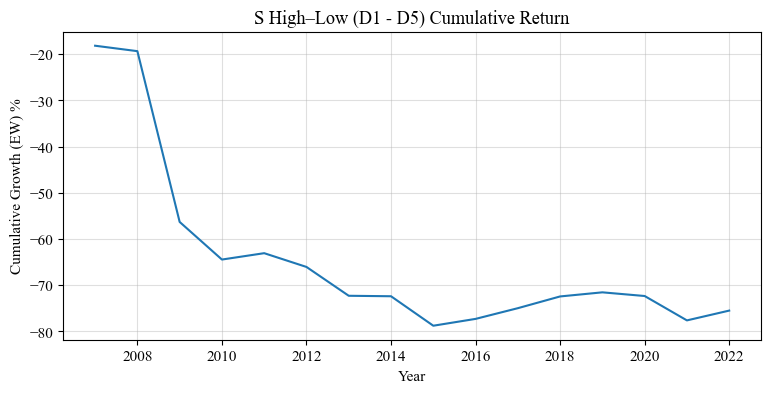

In [85]:
# 累积收益曲线
plt.figure(figsize=(9,4))
(1+s_annual_ret_df_pct.set_index("Year")["cumulative_return(%)"]).plot() #绘画对象
plt.title("S High–Low (D1 - D5) Cumulative Return") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Cumulative Growth (EW) %") #Y轴名称
# plt.xticks(annual_ret_df_pct["Year"]) #X坐标轴
plt.grid(alpha=0.4)
plt.show()

##### **波动率 & 夏普比率**
整体夏普比率 (Sharpe Ratio)和波动率（Volatility）：
* Yearly Return's Volatility = 0.6260。
* Sharp Ratio = -1.19，小于 0，意味着长期来看，高 S 组合相对低 S 组合并没有提供额外的风险补偿，反而表现出负收益。

年度夏普比率 (Annual Sharp Ratio)：
* Annual Volatility = 0.065 ~ 0.1774，年收益率长久低于A股主板的年度股票波动率35%~，说明高 S 组合相对低 S 组合可以提供更小的风险。
    * 并且随着时间变化Volatility逐渐减小。 
* Sharp Ratio = -4.257 ~ 1.264，反应了sharp ratio的波动性。
    * 在16年中，有6年有positive return，有10年有negative return。总体而言，negative return的年数大于positive return的年份。
    * Sharp ratio总体而言有上升的趋势，说明最近人们逐渐意识到了S H-L的重要性。--> 2021年的Sharp ratio有一个突然的下跌，主要由于G score的变化所导致的。


===========================累积波动率 和 夏普比率===========================
Cumulative Return: -0.7650
Annual Return Volatility: 0.6224
Sharpe Ratio (rf=0): -1.2291

===========================每年波动率 和 夏普比率===========================
      annual_return  volatility  sharp_ratio
Year                                        
2007      -0.191639    0.111138    -1.724331
2008      -0.014564    0.181451    -0.080265
2009      -0.464046    0.110231    -4.209753
2010      -0.190696    0.105727    -1.803671
2011       0.039873    0.065275     0.610847
2012      -0.082909    0.094560    -0.876791
2013      -0.189392    0.097828    -1.935970
2014      -0.003846    0.106468    -0.036120
2015      -0.239768    0.149421    -1.604647
2016       0.073088    0.083730     0.872906
2017       0.106789    0.084360     1.265869
2018       0.105792    0.100239     1.055396
2019       0.033456    0.077618     0.431034
2020      -0.028963    0.092705    -0.312417
2021      -0.198013    0.096195    -2.058456
2022      

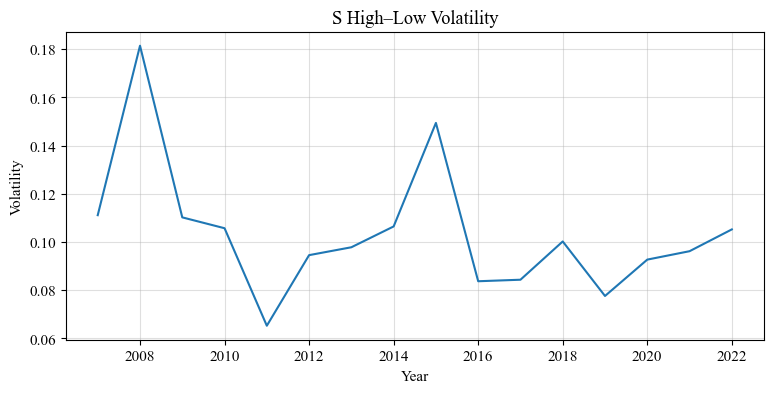

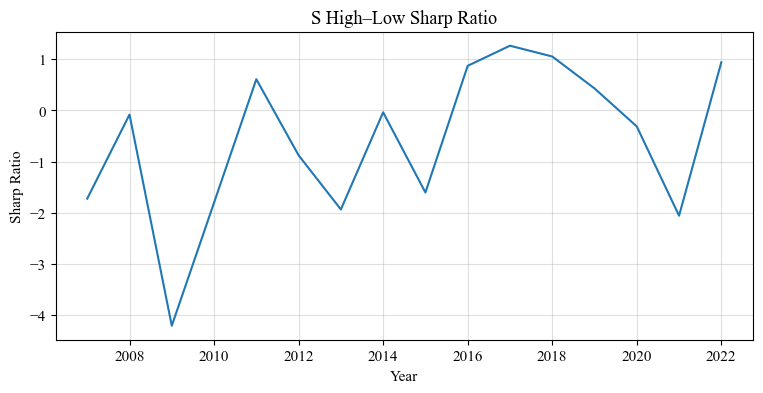

In [87]:
# ========== 1. 年波动率与夏普比率 ==========
print(f"\n===========================累积波动率 和 夏普比率===========================")
s_mean_return = (1+s_annual_return).product()-1
print(f"Cumulative Return: {s_mean_return:.4f}")

s_volatility = s_annual_return.std()*np.sqrt(2022-2007)  # 样本标准差
print(f"Annual Return Volatility: {s_volatility:.4f}")

# 如果假设无风险利率 rf = 0
s_sharpe_ratio = s_mean_return / s_volatility
print(f"Sharpe Ratio (rf=0): {s_sharpe_ratio:.4f}")

# ========== 2. 每年波动率与夏普比率 ==========
print(f"\n===========================每年波动率 和 夏普比率===========================")
# 1. 先从 hl_daily（日度 HL 收益）提取年份
s_hl_daily_year = s_hl_daily.copy()
s_hl_daily_year.index = pd.to_datetime(s_hl_daily_year.index)  # 确保日期是 datetime 类型
s_hl_daily_year = s_hl_daily_year.to_frame("hl_ret")
s_hl_daily_year["Year"] = s_hl_daily_year.index.year

# 2. 按年份计算波动率（这里用样本标准差）
s_yearly_vol = s_hl_daily_year.groupby("Year")["hl_ret"].std(ddof=1)* np.sqrt(252)

# 3. 合并到 annual_return 里
s_annual_df = s_annual_return.to_frame("annual_return")
s_annual_df["volatility"] = s_yearly_vol
s_annual_df["sharp_ratio"] = s_annual_df["annual_return"]/s_annual_df["volatility"]

print(s_annual_df)
print(f"\nAverage Volatility", round(s_annual_df["volatility"].mean(),4))
print(f"The volatility is range from {s_annual_df['volatility'].min():.4f} to {s_annual_df['volatility'].max():.4f}.\n")

print(f"\nAverage Annual Sharp Ratio", round(s_annual_df["sharp_ratio"].mean(),4))
positive_years = s_annual_df[s_annual_df['sharp_ratio'] >= 0].index.tolist()
print(f"The number of years with positive Sharpe ratio is {len(positive_years)}: {positive_years}")
negative_years = s_annual_df[s_annual_df['sharp_ratio'] <= 0].index.tolist()
print(f"The number of years with negative Sharpe ratio is {len(negative_years)}: {negative_years}")
print(f"The sharp ratio is range from {s_annual_df['sharp_ratio'].min():.4f} to {s_annual_df['sharp_ratio'].max():.4f}.")


# 波动率
plt.figure(figsize=(9,4))
(s_annual_df["volatility"]).plot() #绘画对象
plt.title("S High–Low Volatility") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Volatility") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

# 夏普比率
plt.figure(figsize=(9,4))
(s_annual_df["sharp_ratio"]).plot() #绘画对象
plt.title("S High–Low Sharp Ratio") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Sharp Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

##### **换手率** 
* 换手率的范围是 0.8053 到 1.0671。平均换手率为92.88%。
    * 高持仓成本：这说明几乎每年都有将近九成的组合成分股被替换。也就是说，S因子组合的持仓稳定性较低。高换手率意味着 S 组合缺乏持续性，说明 S 排名靠前/靠后的公司变化较快。
    * 稳定性不足：S 因子在中国市场中的 稳定性不足，公司间排名波动大。
    * 趋势下降：总体而言，换手率在2012-2020年逐年下降，代表排名逐渐稳定。
    * 突然上升：只是2021和2022年突然上升。2022年的上升达到了107%。这是由于两方面因素导致。
        * 评级低公司的排名变化：在S评级低的公司，可选消费品，能源，和信息技术的排名由之前的稳定，而突然的产生变化。尤其是房地产行业，它原本的S打分由2019年的倒数第一rank，提升到了2022年的倒数第四rank。
        * 评级高公司的排名变化：在S评级高的公司，必须消费品，能源，和公共事业之间的打分差距突然缩小。这一些列变化，导致了S打分突然的变动。
        

    Year  Turnover_Long  Turnover_Short  Turnover_LongShort
0   2008       1.027491        1.024055            1.025773
1   2009       0.689655        0.940439            0.815047
2   2010       0.976623        0.961039            0.968831
3   2011       0.937500        0.969907            0.953704
4   2012       1.021882        1.118421            1.070151
5   2013       0.899142        0.974249            0.936695
6   2014       0.873469        1.073620            0.973545
7   2015       0.875236        1.073724            0.974480
8   2016       0.808799        1.001692            0.905245
9   2017       0.781297        1.025680            0.903488
10  2018       0.778917        0.953148            0.866032
11  2019       0.809589        0.957534            0.883562
12  2020       0.677033        0.966507            0.821770
13  2021       0.778982        1.041170            0.910076
14  2022       1.011329        1.128733            1.070031

The average turnover rate is 0.9386.
Th

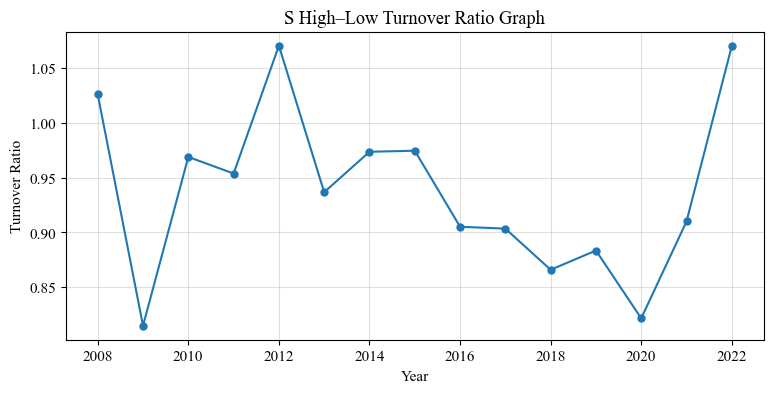

In [89]:
# 计算换手率
def calc_turnover_ls(df, group_col="S_decile", long_decile=1, short_decile=5):
    turnover_list = []
    years = sorted(df["Year"].unique())
    
    for i in range(1, len(years)): # 重复从第一年 到 最后一年
        prev_year = years[i-1]
        curr_year = years[i]
        
        # Long 组合（D1）
        prev_long = set(df[(df["Year"]==prev_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = previous year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        curr_long = set(df[(df["Year"]==curr_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = current year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        turnover_long = (len(curr_long - prev_long) + len(prev_long - curr_long)) / max(1, len(curr_long))
        # 解释：len(curr_long - prev_long)：今天有但是过去没有long的。
        # len(prev_long - curr_long) 去年有，但是今年没有的股票。
        # len(curr_long - prev_long) + len(prev_long - curr_long)：新进股票数 + 退出股票数 = 这一年组合发生变动的股票总数。
        # 除以当前组合的股票总数（避免除以 0）
        
        # Short 组合（D5）
        prev_short = set(df[(df["Year"]==prev_year) & (df[group_col]==short_decile)]["stock_code"])
        curr_short = set(df[(df["Year"]==curr_year) & (df[group_col]==short_decile)]["stock_code"])
        turnover_short = (len(curr_short - prev_short) + len(prev_short - curr_short)) / max(1, len(curr_short))
        
        # Long–Short 组合换手率
        turnover_ls = 0.5 * (turnover_long + turnover_short)
        
        turnover_list.append({
            "Year": curr_year,
            "Turnover_Long": turnover_long,
            "Turnover_Short": turnover_short,
            "Turnover_LongShort": turnover_ls
        })
    
    return pd.DataFrame(turnover_list)

# 运行
s_turnover_ls_df = calc_turnover_ls(df_with_esg, "S_decile", long_decile=1, short_decile=5)
print(s_turnover_ls_df)
print(f"\nThe average turnover rate is {s_turnover_ls_df['Turnover_LongShort'].mean():.4f}.")
print(f"The turnover rate is range from {s_turnover_ls_df['Turnover_LongShort'].min():.4f} to {s_turnover_ls_df['Turnover_LongShort'].max():.4f}.")

# 换手率
plt.figure(figsize=(9,4))
(s_turnover_ls_df.set_index('Year')['Turnover_LongShort']).plot(marker='o') #绘画对象
plt.title("S High–Low Turnover Ratio Graph") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Turnover Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

### G Score 简单检验：显著
简单检验：看 High vs. Low 的平均收益差异是否显著（t-test）。

#### 假设检验

##### 一组简单检验
10个decile，significance level = 10%

In [93]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 10组)
df_with_esg["G_decile"] = (
    df_with_esg.groupby("Year")["G_Score"]
    .transform(lambda x: pd.qcut(-x, 10, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "G_Score", "G_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
g_portfolio_returns = (
    df_with_esg.groupby(["Year", "G_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="G_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(g_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
g_hl_series = g_portfolio_returns[1] - g_portfolio_returns[10]
g_hl_series.name = "G_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== G High–Low (D1 - D10) 因子：逐年收益 ======")
print(g_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
g_hl_mean = g_hl_series.mean()
g_hl_std  = g_hl_series.std()
print(f"\nE_HL 平均收益: {g_hl_mean:.6f}, 标准差: {g_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(g_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
G_decile        1         2         3         4         5         6   \
Year                                                                   
2007      0.537240  0.523795  0.506299  0.515827  0.525518  0.480675   
2008     -0.285877 -0.286428 -0.277462 -0.272360 -0.301293 -0.281481   
2009      0.391963  0.397577  0.391663  0.396106  0.417368  0.417563   
2010      0.039853  0.085628  0.089094  0.084545  0.112927  0.089043   
2011     -0.101453 -0.122295 -0.134444 -0.141522 -0.152725 -0.108248   

G_decile        7         8         9         10  
Year                                              
2007      0.507046  0.574906  0.594170  0.504875  
2008     -0.266362 -0.214640 -0.154206 -0.191620  
2009      0.393284  0.383412  0.379162  0.263203  
2010      0.111765  0.124609  0.137497  0.049730  
2011     -0.108927 -0.119889 -0.081560 -0.083380  

====== G High–Low (D1 - D10) 因子：逐年收益 ======
Year

##### 二组简单检验
5个decile，significance level = 5%

In [95]:
# Step 1: 把所有有 ESG（或者 E / S / G）得分的公司，按得分从低到高排序。分成10组
# 在每一年内部排序 & 分组 (decile, 5组)
df_with_esg["G_decile"] = (
    df_with_esg.groupby("Year")["G_Score"]
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
)

# 结果检查：每年都应该有 D1–D10
# print(df_with_esg[["Year", "stock_code", "G_Score", "G_decile"]].head(20))
print("Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。")

# Step 2: 每个 decile 的平均收益率（这里用 price_day_return）
g_portfolio_returns = (
    df_with_esg.groupby(["Year", "G_decile"])["price_day_return"]
    .mean()
    .reset_index()
    .pivot(index="Year", columns="G_decile", values="price_day_return")
)

print("\n====== ESG decile portfolios (平均收益率) ======")
print(g_portfolio_returns.head())

# Step 3:构造 ESG High–Low 因子（D1 - D10）
g_hl_series = g_portfolio_returns[1] - g_portfolio_returns[5]
g_hl_series.name = "G_HL"

# 1) 计算逐年 H-L 收益（等权）
print("\n====== G High–Low (D1 - D10) 因子：逐年收益 ======")
print(g_hl_series.head())

# 2) 简单统计：均值、标准差、年化（如果 price_day_return 是日频的话可以按需要年化）
import numpy as np
g_hl_mean = g_hl_series.mean()
g_hl_std  = g_hl_series.std()
print(f"\nE_HL 平均收益: {g_hl_mean:.6f}, 标准差: {g_hl_std:.6f}")

# Step 4：显著性检验：H–L 的均值是否显著不为 0（t-test）
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(g_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f}  "
      f"({'显著' if pval < 0.10 else '不显著'})")

Decile = 1 是ESG最好的一组，Decile = 10 是ESG最差的一组。

====== ESG decile portfolios (平均收益率) ======
G_decile         1         2         3         4         5
Year                                                      
2007      0.530518  0.511080  0.503016  0.541097  0.549362
2008     -0.286151 -0.274902 -0.291387 -0.240590 -0.172978
2009      0.394761  0.393884  0.417465  0.388348  0.321001
2010      0.062681  0.086813  0.100985  0.118171  0.093500
2011     -0.111874 -0.137975 -0.130486 -0.114421 -0.082470

====== G High–Low (D1 - D10) 因子：逐年收益 ======
Year
2007   -0.018845
2008   -0.113174
2009    0.073761
2010   -0.030818
2011   -0.029404
Name: G_HL, dtype: float64

E_HL 平均收益: -0.077817, 标准差: 0.095234
t-test: t = -3.268, p = 0.005  (显著)


##### 三组简单检验
特点：
* 5 decile
* 市值加权（频次：年）
* 复利回报（频次：天 和 年累积）
* alpha = 10%

In [97]:
# 1) 年内分组（D1=最好，D5=最差）
df_with_esg["G_decile"] = (
    df_with_esg.groupby("Year")["G_Score"]
    # 把df_with_esg切成小组，并提取每年的G_score。
    .transform(lambda x: pd.qcut(-x, 5, labels=False, duplicates="drop") + 1)
    # transform和.apply()等不同，会返回一个和原始DF长度一样的索引。它的含义是对于每个分组单独执行一个函数。然后把结果展开会原来的行数。
    # pd.qcut()按照分位切箱，它输出的结果是一个series或者其他格式，作用于(pd.quct(x))里的数据。
)
# 含义：把df_with_esg按照年分组，并且对于每年（每组）的esg_score进行一个分位数函数。

# 2) 把“年频标签 + 市值”合并到日频收益表上
# 假设 stock_return 有列: Date(YYYYMMDD或日期), stock_code, return(单日收益)
stock_return["Year"] = stock_return["Date"].dt.year #创立"Year" col方便和 df_with_esg的年频次数据对其。
df_with_esg["stock_code"] = df_with_esg["stock_code"].astype(str).str.zfill(6)

use_cols = ["Year", "stock_code", "G_decile", "market_cap"] #需要用的columns
merged = stock_return.merge(df_with_esg[use_cols], on=["Year", "stock_code"], how="inner") #创建新数据囊括两张表格内容。

# 3) 每天、每个 decile 的“市值加权”日收益
# 定义函数wret(g)
# 内容：对一个分组（同一天、同一个 ESG_decile 的股票集合）计算市值加权平均收益。
def _vwret(g):
    w = np.clip(g["market_cap"].to_numpy(), 0, None) # 把市值的大小限制在0以上。
    r = g["return"].to_numpy() / 100.0   # 把百分数转成小数
    if w.sum() == 0 or np.all(np.isnan(w)):  # 避免全 0 或 NaN
        return np.nanmean(r) # 如果以上两种情况存在，就返回average return（忽略NaN）
    return np.average(r, weights=w) # 否则返回weighted return，加权回报

# 计算每天的weighted_return 
g_daily_vw = (
    merged.dropna(subset=["return", "market_cap"]) #去掉没有收益和数值的列
          .groupby(["Date", "G_decile"]) # 按照年份和 ESG_decile分组
          .apply(_vwret) #每一组进行weighed_return的计算
          .reset_index(name="day_ret")
)

# 4A) 想要“年度复利收益”用于显著性检验：
g_daily_vw["Year"] = g_daily_vw["Date"].dt.year
# 计算年度加权复利回报
g_annual_vw = (
    g_daily_vw.assign(log1p=np.log1p(g_daily_vw["day_ret"]))
            # .assign(新列名 = 表达式, ...)用来新增列。
            # np.log1p是把天简单收益变成log(1+x)对数收益，对数收益可以直接相加。
            .groupby(["Year", "G_decile"])["log1p"].sum()
            # 计算对数收益之和。
            .pipe(lambda s: np.expm1(s))  # = (1+r)连乘 - 1 的稳定写法
            # .pipe()：把签名series的内容，作为第一个参数传给function 并返回函数结果。
            # 链式结构专属：res = s.pipe(np.log1p) 等价于 res = np.log1p(s)
            # 函数 np.expm1() 代表expm1(s)=es−1
            .reset_index(name="annual_return")
            # 把结果改为annual_return
            .pivot(index="Year", columns="G_decile", values="annual_return")
            # pivot 就是 表格旋转，让数据从 长表（long format） 变成 宽表（wide format）。
            # Year作为索引，ESG_decile作为列名字，数值是年度回报。
)

# 4B) 如果你只想“日度统计/波动率”：
# wide = daily_vw.pivot(index="Date", columns="ESG_decile", values="day_ret")
# hl_daily = (wide[1] - wide[5]).dropna()
# ann_vol = hl_daily.std() * np.sqrt(252)

# HL（D1 - D5）逐年（复利）收益 & t检验
g_hl_series = g_annual_vw[1] - g_annual_vw[5] #构建 H-L 因子
tstat, pval = ttest_1samp(g_hl_series.dropna(), 0.0) # 单样本t检验，假设alpha = 0 

print("\n====== G decile portfolios (年累积收益率) ======")
print(g_annual_vw)   # ✅ 打印完整结果，不截断

# Step 3: 构造 ESG High–Low 因子（D1 - D5）
print("\n====== G High–Low (D1 - D5) 因子：逐年收益 ======")
print(g_hl_series)   # ✅ 打印完整结果，不截断
g_hl_series_5 = g_hl_series


====== G decile portfolios (年累积收益率) ======
G_decile         1         2         3         4         5
Year                                                      
2007      2.085095  2.258303  2.542068  2.095997  2.118588
2008     -0.612926 -0.571784 -0.605344 -0.599366 -0.601988
2009      1.269120  1.234538  1.441208  0.982802  1.160243
2010     -0.122608  0.105276 -0.047878  0.074735 -0.003546
2011     -0.205035 -0.178458 -0.164785 -0.277133 -0.239813
2012      0.069246  0.103608  0.090930  0.051914  0.100893
2013     -0.051661  0.203170  0.140990  0.222615  0.277627
2014      0.614017  0.563058  0.560371  0.474655  0.517242
2015      0.262887  0.356229  0.436501  0.728834  0.851438
2016     -0.041791 -0.059820 -0.085817 -0.067775 -0.009557
2017      0.196746  0.107956  0.153100 -0.036999  0.089587
2018     -0.181881 -0.252594 -0.208074 -0.247618 -0.229287
2019      0.348590  0.351960  0.398490  0.456769  0.454170
2020      0.233635  0.304724  0.525130  0.372677  0.842890
2021      0.

In [98]:

# ====== Step 5：显著性检验（年度 HL 序列）======

# 丢 NaN
g_hl_series = g_hl_series.dropna()

# 简单统计
g_hl_mean = g_hl_series.mean()
g_hl_std  = g_hl_series.std(ddof=1)

# Step 6: 简单统计 & 显著性检验
print("\n====== G High–Low (D1 - D5) 因子：总体统计 ======")
print(f"平均收益: {g_hl_mean:.6f}, 标准差: {g_hl_std:.6f}")

tstat, pval = ttest_1samp(g_hl_series.dropna(), 0.0)
print(f"t-test: t = {tstat:.3f}, p = {pval:.3f} "
      f"({'显著' if pval < 0.10 else '不显著'})")

# 把日度 D1、D5 以及 HL 取出来
wide = g_daily_vw.pivot(index="Date", columns="G_decile", values="day_ret").sort_index()
g_hl_daily = (wide[1] - wide[5]).dropna()

# 日度统计与年化指标
g_mu_d   = g_hl_daily.mean()
g_vol_d  = g_hl_daily.std(ddof=1)
g_mu_ann = g_mu_d * 252
g_vol_ann= g_vol_d * np.sqrt(252)

print("\n====== G High–Low (D1 - D5) 日度：统计量 ======")
print(f"日均: {g_mu_d:.6f}, 日波动: {g_vol_d:.6f}  |  年化均值: {g_mu_ann:.6f}, 年化波动: {g_vol_ann:.6f}")

# 对“日度 HL”做均值检验（是否显著不为 0）
tstat_d, pval_d = ttest_1samp(g_hl_daily, 0.0)
print(f"t-test（日度HL）: t = {tstat_d:.3f}, p = {pval_d:.3f}  "
      f"({'显著' if pval_d < 0.10 else '不显著'})")


====== G High–Low (D1 - D5) 因子：总体统计 ======
平均收益: -0.158451, 标准差: 0.354122
t-test: t = -1.790, p = 0.094 (显著)

====== G High–Low (D1 - D5) 日度：统计量 ======
日均: -0.000475, 日波动: 0.009490  |  年化均值: -0.119774, 年化波动: 0.150648
t-test（日度HL）: t = -3.124, p = 0.002  (显著)


#### 经济意义

* 超额收益：整体趋势下行，从 2007 年到 2015 年，这条曲线一路震荡下滑，到 2014 年已经接近 -0.71。在2015年之后，这条曲线趋于平稳。直到2020和2021两年继续下降大幅。--> 政策因素影响曲线变化
    * 为什么2015年，2020年，和2021年 G会突然大幅度下降？存在Large Tail Event。
* 波动率 & 夏普比率：波动率总体而言较小，但是由于总体收益的变动，夏普比率依然有非常高的负数概率。-> 多样化，但是负回报
* 换手率：换手率大于100%，持仓成本过高。侧面反映G 因子在中国市场中的稳定性不足，公司间排名波动大。--> 不稳定
    * 为什么G H-L的换手率会在2020和2021和年突然上升（在2021年前的稳定下降之后）？


##### **年超额收益**
整体趋势：整体趋势下行
* 从 2007 年到 2015 年，这条曲线一路震荡下滑，到 2015 年已经接近 -0.71，之后的2014-2019趋于平稳，直到2020和2021两年的突然下降。
    * 这说明：一直以来**高 G 投资组合的表现不如低 G 投资组合**，长期下来累计收益是负的。如果一个投资者长期做 “多高 G / 空低 G” 策略，是亏钱的。
    * 反思：为什么2015年，2020年，和2021年 G会突然下降？

总结：在中国 A 股，长期内市场机制还未充分体现 G 的正向价值，所以表现为 G 高分组合长期并不显著为正。G组合的收益变化非常的不稳定，表现为甚至有单年会有低于-95%的收益。
**其他观察：** S H-L, E H-L 组合收益的变化和 ESG H-L 组合收益的变化部分的相似。也存在2016年后的上涨，但是究竟什么因素导致了2020和2021两年收益率的突然下降？

In [101]:
# ===============================
# 参数：年度H-L 的日频均值年化设置
# ===============================

# -------------------------------
# (1) 年化超额收益 & 累计收益
# hl_series: index=Year, value=年度内日收益平均值(%)的高减低(H-L)
# 年化 = (1 + 日均收益)^交易日数 - 1
# -------------------------------
g_annual_return = g_hl_series.copy()    # 转成小数


# 累计收益 = (1 + 每年收益) 连乘
cum_return = (1.0 + g_annual_return).cumprod() - 1.0

g_annual_ret_df = pd.DataFrame({
    "Year": g_annual_return.index.astype(int),
    "annual_return": g_annual_return.values,      # 小数
    "cumulative_return": cum_return.values      # 小数
})

# 也可转回百分比展示：
g_annual_ret_df_pct = g_annual_ret_df.copy()
g_annual_ret_df_pct["annual_return(%)"] = g_annual_ret_df_pct["annual_return"] * 100
g_annual_ret_df_pct["cumulative_return(%)"] = g_annual_ret_df_pct["cumulative_return"] * 100
g_annual_ret_df_pct = g_annual_ret_df_pct[["Year", "annual_return(%)", "cumulative_return(%)"]]
print("\n=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===")
print(g_annual_ret_df_pct)

# Year with Positive Return: 
positive_years = g_annual_ret_df_pct[g_annual_ret_df_pct["annual_return(%)"]>=0]
print("\n=== 收益为正数的年份===")
print("Year with Postitive Return: ", 
      positive_years["Year"].to_list()) 


=== High–Low 年化收益 & 累计收益（基于年度H-L的年化）===
    Year  annual_return(%)  cumulative_return(%)
0   2007         -3.349325             -3.349325
1   2008         -1.093839             -4.406527
2   2009         10.887707              6.001410
3   2010        -11.906237             -6.619369
4   2011          3.477804             -3.371774
5   2012         -3.164723             -6.429790
6   2013        -32.928782            -37.241320
7   2014          9.677464            -31.167872
8   2015        -58.855173            -71.679140
9   2016         -3.223398            -72.592034
10  2017         10.715967            -69.655005
11  2018          4.740634            -68.216460
12  2019        -10.558015            -71.572171
13  2020        -60.925497            -88.891967
14  2021       -117.513579           -101.945414
15  2022         10.497096           -102.149626

=== 收益为正数的年份===
Year with Postitive Return:  [2009, 2011, 2014, 2017, 2018, 2022]


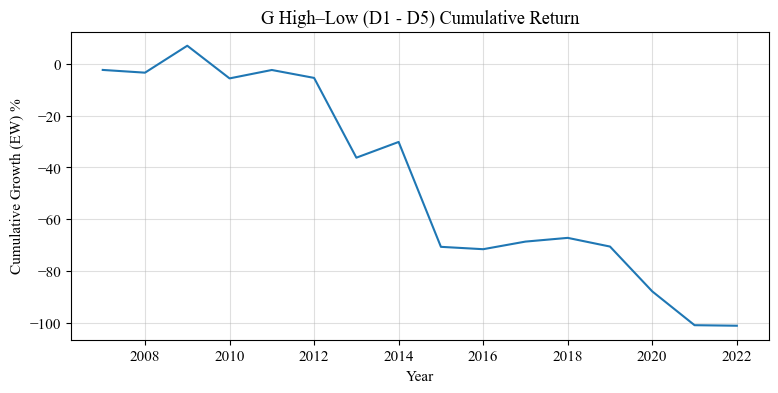

In [102]:
# 累积收益曲线
plt.figure(figsize=(9,4))
(1+g_annual_ret_df_pct.set_index("Year")["cumulative_return(%)"]).plot() #绘画对象
plt.title("G High–Low (D1 - D5) Cumulative Return") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Cumulative Growth (EW) %") #Y轴名称
# plt.xticks(annual_ret_df_pct["Year"]) #X坐标轴
plt.grid(alpha=0.4)
plt.show()

##### **波动率 & 夏普比率**
整体夏普比率 (Sharpe Ratio)和波动率（Volatility）：
* Yearly Return's Volatility = 1.1913。
* Sharp Ratio = -0.8335，小于 0，意味着长期来看，高 G 组合相对低 G 组合并没有提供额外的风险补偿，反而表现出负收益。

年度夏普比率 (Annual Sharp Ratio)：
* Annual Volatility = 0.066 ~ 0.2506，年收益率长久低于A股主板的年度股票波动率35%~，说明高 G 组合相对低 G 组合可以提供更小的风险。
    * Volatility在2015年和2022年表现出来非常极端的上升。
* Sharp Ratio = -5.848 ~ 0.0661，反应了sharp ratio的波动性。
    * 在16年中，有6年有positive return，有10年有negative return。总体而言，negative return的年数大于positive return的年份。
    * Sharp ratio的变化越来越剧烈，这一定程度上反应了收益的不稳定变化。某种程度而言，sharp ratio的变化呈现周期性。


===========================累积波动率 和 夏普比率===========================
Cumulative Return: -1.0215
Annual Return Volatility: 1.3715
Sharpe Ratio (rf=0): -0.7448

===========================每年波动率 和 夏普比率===========================
      annual_return  volatility  sharp_ratio
Year                                        
2007      -0.033493    0.185067    -0.180979
2008      -0.010938    0.124505    -0.087855
2009       0.108877    0.129236     0.842465
2010      -0.119062    0.098083    -1.213897
2011       0.034778    0.066322     0.524384
2012      -0.031647    0.119269    -0.265343
2013      -0.329288    0.142703    -2.307503
2014       0.096775    0.154905     0.624735
2015      -0.588552    0.248180    -2.371476
2016      -0.032234    0.146112    -0.220611
2017       0.107160    0.114195     0.938396
2018       0.047406    0.143781     0.329712
2019      -0.105580    0.129489    -0.815363
2020      -0.609255    0.130435    -4.670960
2021      -1.175136    0.168258    -6.984111
2022      

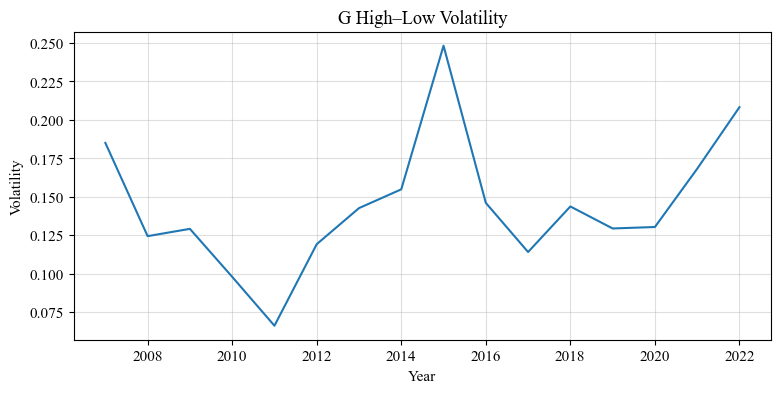

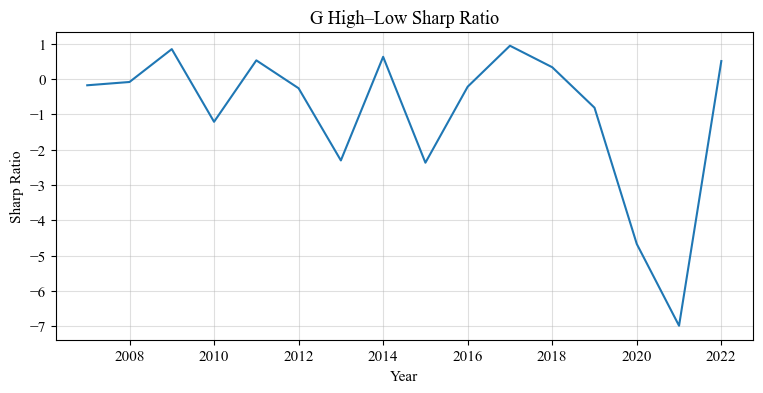

In [104]:
# ========== 1. 年波动率与夏普比率 ==========
print(f"\n===========================累积波动率 和 夏普比率===========================")
g_mean_return = (1+g_annual_return).product()-1
print(f"Cumulative Return: {g_mean_return:.4f}")

g_volatility = g_annual_return.std()*np.sqrt(2022-2007)  # 样本标准差
print(f"Annual Return Volatility: {g_volatility:.4f}")

# 如果假设无风险利率 rf = 0
g_sharpe_ratio = g_mean_return / g_volatility
print(f"Sharpe Ratio (rf=0): {g_sharpe_ratio:.4f}")

# ========== 2. 每年波动率与夏普比率 ==========
print(f"\n===========================每年波动率 和 夏普比率===========================")
# 1. 先从 hl_daily（日度 HL 收益）提取年份
g_hl_daily_year = g_hl_daily.copy()
g_hl_daily_year.index = pd.to_datetime(g_hl_daily_year.index)  # 确保日期是 datetime 类型
g_hl_daily_year = g_hl_daily_year.to_frame("hl_ret")
g_hl_daily_year["Year"] = g_hl_daily_year.index.year

# 2. 按年份计算波动率（这里用样本标准差）
g_yearly_vol = g_hl_daily_year.groupby("Year")["hl_ret"].std(ddof=1)* np.sqrt(252)

# 3. 合并到 annual_return 里
g_annual_df = g_annual_return.to_frame("annual_return")
g_annual_df["volatility"] = g_yearly_vol
g_annual_df["sharp_ratio"] = g_annual_df["annual_return"]/g_annual_df["volatility"]

print(g_annual_df)
print(f"\nAverage Volatility", round(g_annual_df["volatility"].mean(),4))
print(f"The volatility is range from {g_annual_df['volatility'].min():.4f} to {g_annual_df['volatility'].max():.4f}.\n")

print(f"\nAverage Annual Sharp Ratio", round(g_annual_df["sharp_ratio"].mean(),4))
g_positive_years = g_annual_df[g_annual_df['sharp_ratio'] >= 0].index.tolist()
print(f"The number of years with positive Sharpe ratio is {len(g_positive_years)}: {g_positive_years}")
g_negative_years = g_annual_df[g_annual_df['sharp_ratio'] <= 0].index.tolist()
print(f"The number of years with negative Sharpe ratio is {len(g_negative_years)}: {g_negative_years}")
print(f"The sharp ratio is range from {g_annual_df['sharp_ratio'].min():.4f} to {g_annual_df['sharp_ratio'].max():.4f}.")


# 波动率
plt.figure(figsize=(9,4))
(g_annual_df["volatility"]).plot() #绘画对象
plt.title("G High–Low Volatility") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Volatility") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

# 夏普比率
plt.figure(figsize=(9,4))
(g_annual_df["sharp_ratio"]).plot() #绘画对象
plt.title("G High–Low Sharp Ratio") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Sharp Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

##### **换手率** 
* 换手率的范围是 0.7814 到 1.2369。平均换手率为1.0251%。
    * 高持仓成本：这说明几乎每年都有大于100%的组合成分股被替换。也就是说，G因子组合的持仓稳定性较低。高换手率意味着 G 组合缺乏持续性，说明 G 排名靠前/靠后的公司变化较快。
    * 稳定性不足：G 因子在中国市场中的 稳定性不足，公司间排名波动大。
    * 趋势下降：总体而言，换手率在逐年下降，只是2021和2022年突然上升。2022年的上升达到了106%，可能有潜在的变化，导致了G的突然调整。

    Year  Turnover_Long  Turnover_Short  Turnover_LongShort
0   2008       0.993127        1.360825            1.176976
1   2009       0.846395        1.510972            1.178683
2   2010       1.002597        1.314286            1.158442
3   2011       0.729167        1.215278            0.972222
4   2012       0.890591        1.232456            1.061523
5   2013       0.886266        1.103004            0.994635
6   2014       0.812245        1.220859            1.016552
7   2015       0.829868        1.221172            1.025520
8   2016       0.798646        1.323181            1.060914
9   2017       0.790347        1.309668            1.050007
10  2018       0.808199        1.193265            1.000732
11  2019       0.754795        1.154795            0.954795
12  2020       0.617225        1.078947            0.848086
13  2021       0.668472        1.231853            0.950163
14  2022       0.762101        1.060762            0.911432

The average turnover rate is 1.0240.
Th

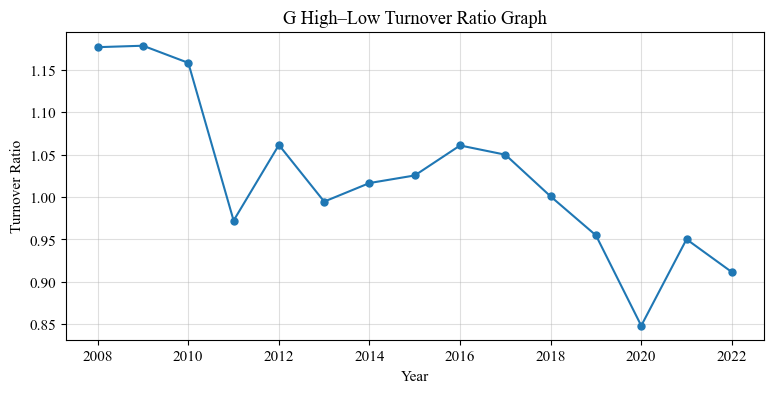

In [106]:
# 计算换手率
def calc_turnover_ls(df, group_col="G_decile", long_decile=1, short_decile=5):
    turnover_list = []
    years = sorted(df["Year"].unique())
    
    for i in range(1, len(years)): # 重复从第一年 到 最后一年
        prev_year = years[i-1]
        curr_year = years[i]
        
        # Long 组合（D1）
        prev_long = set(df[(df["Year"]==prev_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = previous year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        curr_long = set(df[(df["Year"]==curr_year) & (df[group_col]==long_decile)]["stock_code"])
        # 选择在组合中 year = current year，然后group等于long-decile 1的stock_code。并计算unique的数量。
        turnover_long = (len(curr_long - prev_long) + len(prev_long - curr_long)) / max(1, len(curr_long))
        # 解释：len(curr_long - prev_long)：今天有但是过去没有long的。
        # len(prev_long - curr_long) 去年有，但是今年没有的股票。
        # len(curr_long - prev_long) + len(prev_long - curr_long)：新进股票数 + 退出股票数 = 这一年组合发生变动的股票总数。
        # 除以当前组合的股票总数（避免除以 0）
        
        # Short 组合（D5）
        prev_short = set(df[(df["Year"]==prev_year) & (df[group_col]==short_decile)]["stock_code"])
        curr_short = set(df[(df["Year"]==curr_year) & (df[group_col]==short_decile)]["stock_code"])
        turnover_short = (len(curr_short - prev_short) + len(prev_short - curr_short)) / max(1, len(curr_short))
        
        # Long–Short 组合换手率
        turnover_ls = 0.5 * (turnover_long + turnover_short)
        
        turnover_list.append({
            "Year": curr_year,
            "Turnover_Long": turnover_long,
            "Turnover_Short": turnover_short,
            "Turnover_LongShort": turnover_ls
        })
    
    return pd.DataFrame(turnover_list)

# 运行
g_turnover_ls_df = calc_turnover_ls(df_with_esg, "G_decile", long_decile=1, short_decile=5)
print(g_turnover_ls_df)
print(f"\nThe average turnover rate is {g_turnover_ls_df['Turnover_LongShort'].mean():.4f}.")
print(f"The turnover rate is range from {g_turnover_ls_df['Turnover_LongShort'].min():.4f} to {g_turnover_ls_df['Turnover_LongShort'].max():.4f}.")

# 换手率
plt.figure(figsize=(9,4))
(g_turnover_ls_df.set_index('Year')['Turnover_LongShort']).plot(marker='o') #绘画对象
plt.title("G High–Low Turnover Ratio Graph") #标题
plt.xlabel("Year") #X轴名称
plt.ylabel("Turnover Ratio") #Y轴名称
plt.grid(alpha=0.4)
plt.show()

### ESG, E, S, G图像

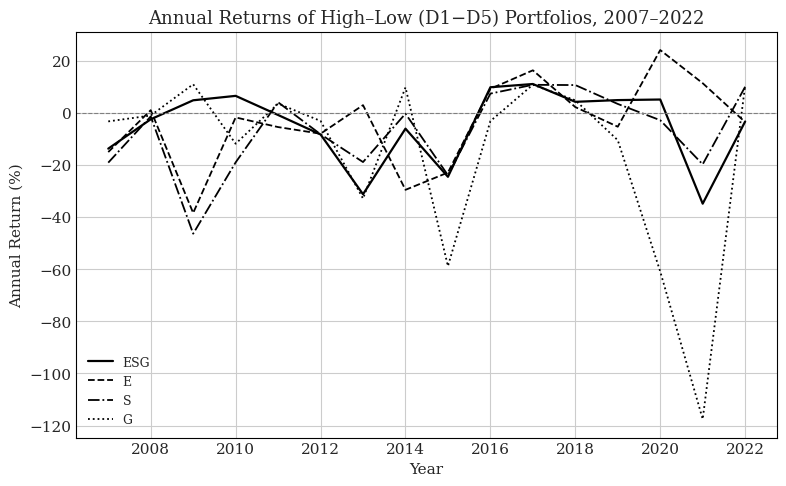

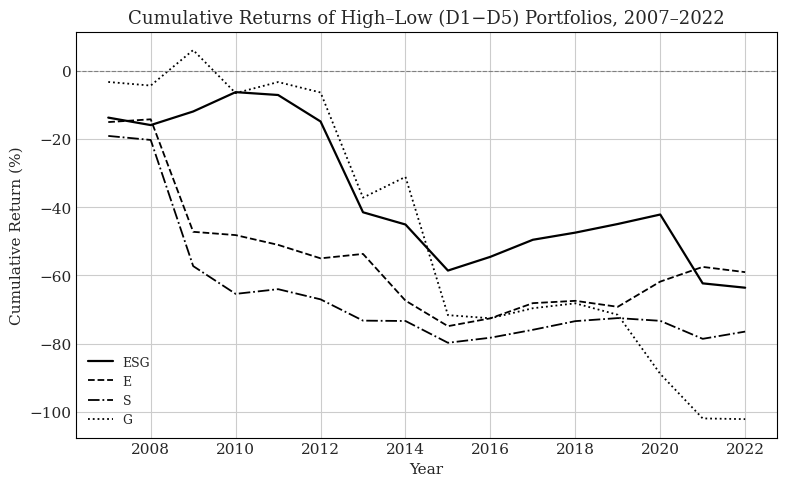

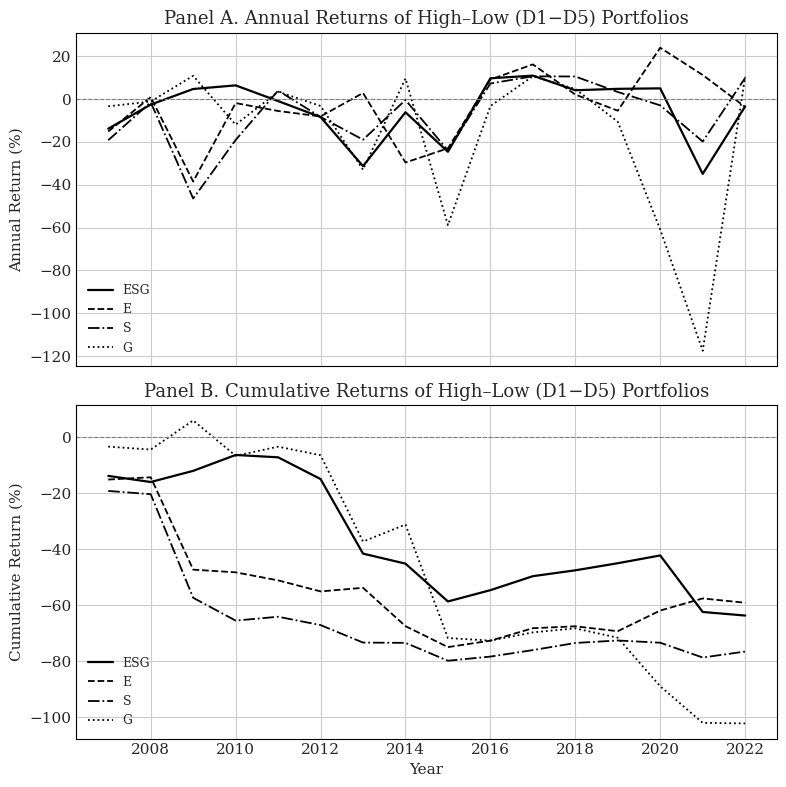

In [108]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8
})

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8
})

# === Annual Return (黑白版) ===
plt.figure(figsize=(8,5))
plt.plot(esg_annual_ret_df_pct["Year"], esg_annual_ret_df_pct["annual_return(%)"], 
         label="ESG", color="black", linestyle='-', linewidth=1.6)
plt.plot(e_annual_ret_df_pct["Year"], e_annual_ret_df_pct["annual_return(%)"], 
         label="E", color="black", linestyle='--', linewidth=1.3)
plt.plot(s_annual_ret_df_pct["Year"], s_annual_ret_df_pct["annual_return(%)"], 
         label="S", color="black", linestyle='-.', linewidth=1.3)
plt.plot(g_annual_ret_df_pct["Year"], g_annual_ret_df_pct["annual_return(%)"], 
         label="G", color="black", linestyle=':', linewidth=1.3)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Annual Returns of High–Low (D1−D5) Portfolios, 2007–2022")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

# === Cumulative Return (黑白版) ===
plt.figure(figsize=(8,5))
plt.plot(esg_annual_ret_df_pct["Year"], esg_annual_ret_df_pct["cumulative_return(%)"], 
         label="ESG", color="black", linestyle='-', linewidth=1.6)
plt.plot(e_annual_ret_df_pct["Year"], e_annual_ret_df_pct["cumulative_return(%)"], 
         label="E", color="black", linestyle='--', linewidth=1.3)
plt.plot(s_annual_ret_df_pct["Year"], s_annual_ret_df_pct["cumulative_return(%)"], 
         label="S", color="black", linestyle='-.', linewidth=1.3)
plt.plot(g_annual_ret_df_pct["Year"], g_annual_ret_df_pct["cumulative_return(%)"], 
         label="G", color="black", linestyle=':', linewidth=1.3)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Cumulative Returns of High–Low (D1−D5) Portfolios, 2007–2022")
plt.xlabel("Year")
plt.ylabel("Cumulative Return (%)")
plt.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# Panel A: Annual
axes[0].plot(esg_annual_ret_df_pct["Year"], esg_annual_ret_df_pct["annual_return(%)"], label="ESG", color="black", linestyle='-', linewidth=1.6)
axes[0].plot(e_annual_ret_df_pct["Year"], e_annual_ret_df_pct["annual_return(%)"], label="E", color="black", linestyle='--', linewidth=1.3)
axes[0].plot(s_annual_ret_df_pct["Year"], s_annual_ret_df_pct["annual_return(%)"], label="S", color="black", linestyle='-.', linewidth=1.3)
axes[0].plot(g_annual_ret_df_pct["Year"], g_annual_ret_df_pct["annual_return(%)"], label="G", color="black", linestyle=':', linewidth=1.3)
axes[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[0].set_title("Panel A. Annual Returns of High–Low (D1−D5) Portfolios")
axes[0].set_ylabel("Annual Return (%)")
axes[0].legend(frameon=False, fontsize=9)

# Panel B: Cumulative
axes[1].plot(esg_annual_ret_df_pct["Year"], esg_annual_ret_df_pct["cumulative_return(%)"], label="ESG", color="black", linestyle='-', linewidth=1.6)
axes[1].plot(e_annual_ret_df_pct["Year"], e_annual_ret_df_pct["cumulative_return(%)"], label="E", color="black", linestyle='--', linewidth=1.3)
axes[1].plot(s_annual_ret_df_pct["Year"], s_annual_ret_df_pct["cumulative_return(%)"], label="S", color="black", linestyle='-.', linewidth=1.3)
axes[1].plot(g_annual_ret_df_pct["Year"], g_annual_ret_df_pct["cumulative_return(%)"], label="G", color="black", linestyle=':', linewidth=1.3)
axes[1].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[1].set_title("Panel B. Cumulative Returns of High–Low (D1−D5) Portfolios")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Cumulative Return (%)")
axes[1].legend(frameon=False, fontsize=9)

plt.tight_layout()
plt.show()


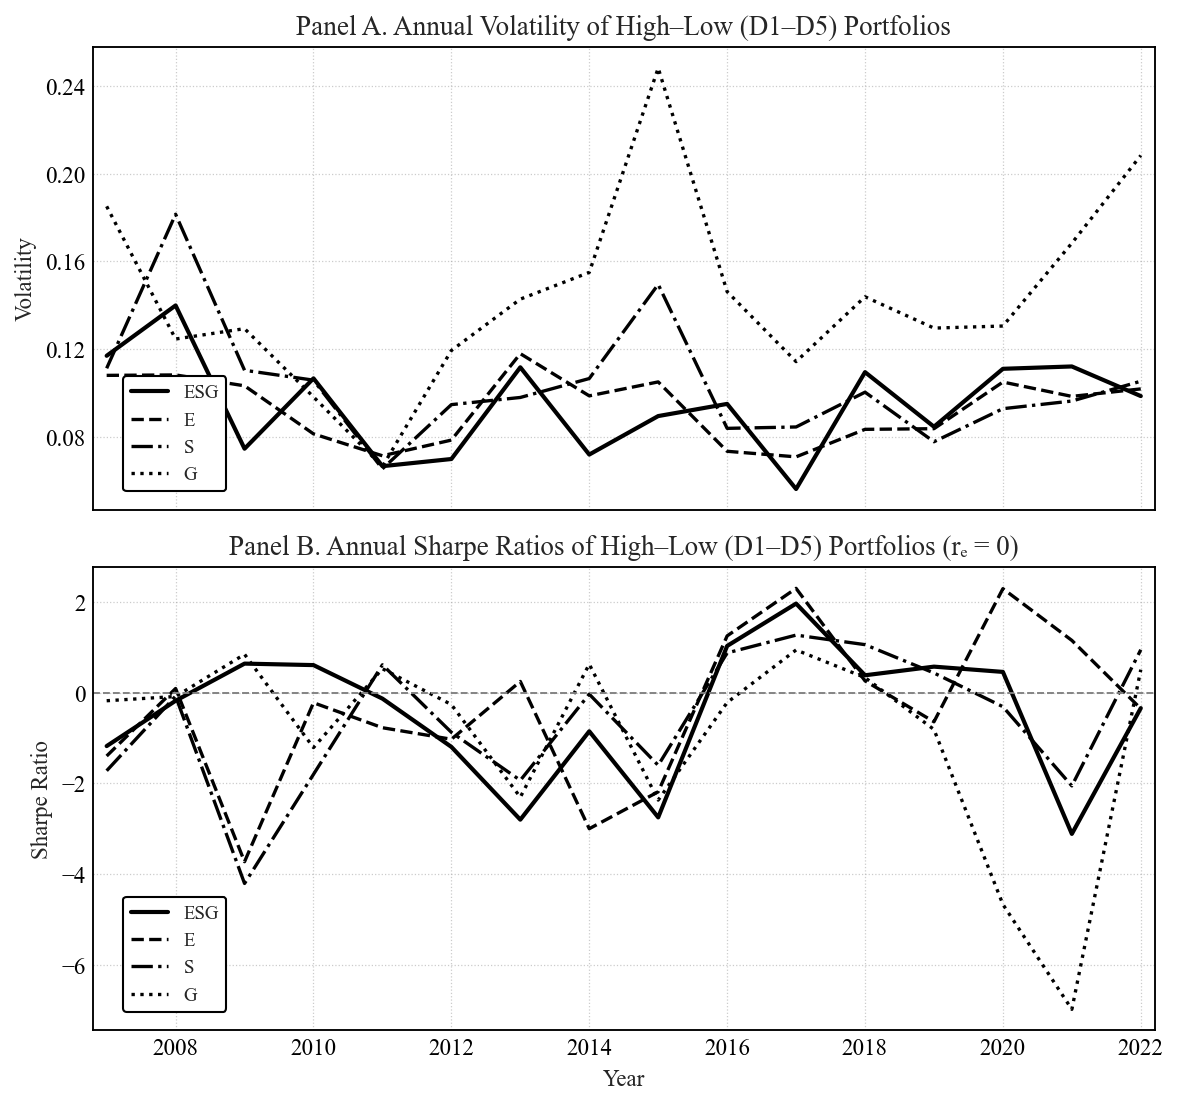

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ====== 统一学术风样式（黑白 + Times）======
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.9,
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "0.6",
    "grid.linestyle": ":",
    "grid.linewidth": 0.6,
    "figure.dpi": 150,
})

# 线型与线宽：与之前图保持一致
styles = {"ESG":("-",2.0), "E":("--",1.6), "S":("-.",1.6), "G":(":",1.6)}

# 小工具：安全取出（Year, value）并排序
def _prep_year_series(df: pd.DataFrame, col: str):
    d = df.reset_index()  # 关键修改：重置索引，避免歧义
    if "Year" not in d.columns:
        # 如果重置后还没有Year列，从索引中获取
        d["Year"] = d.index
    d = d[["Year", col]].dropna()
    d["Year"] = pd.to_numeric(d["Year"], errors="coerce")
    d = d.dropna().sort_values("Year")
    return d["Year"].values, d[col].values

# ====== 准备数据：四组 * 两指标 ======
Y_esg, VOL_esg = _prep_year_series(esg_annual_df, "volatility")
_,     SR_esg  = _prep_year_series(esg_annual_df, "sharp_ratio")

Y_e,   VOL_e   = _prep_year_series(e_annual_df, "volatility")
_,     SR_e    = _prep_year_series(e_annual_df, "sharp_ratio")

Y_s,   VOL_s   = _prep_year_series(s_annual_df, "volatility")
_,     SR_s    = _prep_year_series(s_annual_df, "sharp_ratio")

Y_g,   VOL_g   = _prep_year_series(g_annual_df, "volatility")
_,     SR_g    = _prep_year_series(g_annual_df, "sharp_ratio")

# x 轴年份范围（保证整数刻度）
xmin = int(min(Y_esg.min(), Y_e.min(), Y_s.min(), Y_g.min()))
xmax = int(max(Y_esg.max(), Y_e.max(), Y_s.max(), Y_g.max()))

# ====== 画图：Panel A（Volatility） + Panel B（Sharpe）======
fig, axes = plt.subplots(2, 1, figsize=(8, 7.5), sharex=True)

# Panel A: 年度波动率
ax = axes[0]
for label, (x, y) in {
    "ESG": (Y_esg, VOL_esg),
    "E":   (Y_e,   VOL_e),
    "S":   (Y_s,   VOL_s),
    "G":   (Y_g,   VOL_g),
}.items():
    ls, lw = styles[label]
    ax.plot(x, y, linestyle=ls, linewidth=lw, color="black", label=label)
ax.set_title("Panel A. Annual Volatility of High–Low (D1–D5) Portfolios")
ax.set_ylabel("Volatility")
ax.grid(True, axis="both", alpha=0.5)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.legend(loc="lower left", bbox_to_anchor=(0.02, 0.02),
          frameon=True, edgecolor="black", facecolor="white",
          framealpha=1.0, fontsize=9, ncol=1)

# Panel B: 年度夏普比（rf = 0）
ax = axes[1]
for label, (x, y) in {
    "ESG": (Y_esg, SR_esg),
    "E":   (Y_e,   SR_e),
    "S":   (Y_s,   SR_s),
    "G":   (Y_g,   SR_g),
}.items():
    ls, lw = styles[label]
    ax.plot(x, y, linestyle=ls, linewidth=lw, color="black", label=label)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.9)
ax.set_title("Panel B. Annual Sharpe Ratios of High–Low (D1–D5) Portfolios (r\u2091 = 0)")
ax.set_xlabel("Year")
ax.set_ylabel("Sharpe Ratio")
ax.grid(True, axis="both", alpha=0.5)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.legend(loc="lower left", bbox_to_anchor=(0.02, 0.02),
          frameon=True, edgecolor="black", facecolor="white",
          framealpha=1.0, fontsize=9, ncol=1)

# x 轴：整数年份、每 2 年一刻度，边界留白极小
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=int((xmax-xmin)/2)+1))
axes[1].set_xlim(xmin-0.2, xmax+0.2)

plt.tight_layout()
# plt.savefig("Figure_Volatility_and_Sharpe_bw_times.pdf")
# plt.savefig("Figure_Volatility_and_Sharpe_bw_times.png", dpi=300)
plt.show()

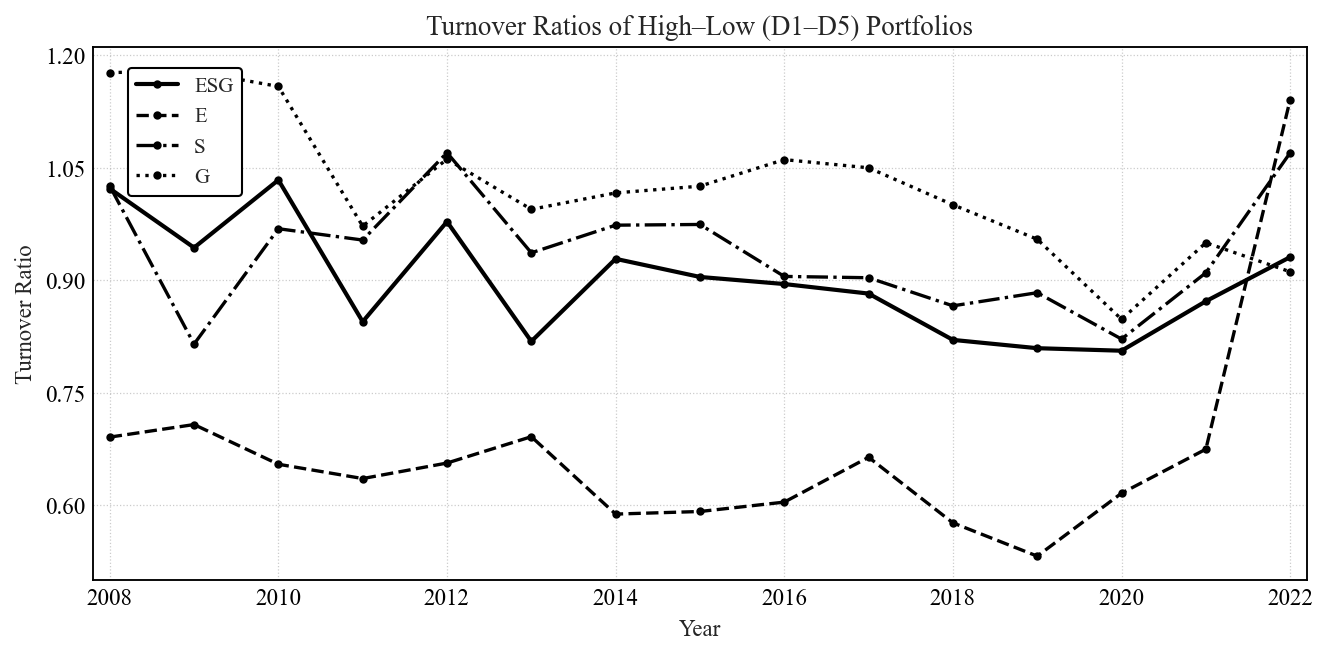

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ====== 统一学术风样式（黑白 + Times）======
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.9,
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "0.6",
    "grid.linestyle": ":",
    "grid.linewidth": 0.6,
    "figure.dpi": 150,
})

# 线型与线宽：与之前图保持一致
styles = {"ESG":("-",2.0), "E":("--",1.6), "S":("-.",1.6), "G":(":",1.6)}

# 小工具：安全取出（Year, value）并排序
def _prep_year_series(df: pd.DataFrame, col: str):
    d = df.reset_index()  # 重置索引，避免歧义
    if "Year" not in d.columns:
        # 如果重置后还没有Year列，从索引中获取
        d["Year"] = d.index
    d = d[["Year", col]].dropna()
    d["Year"] = pd.to_numeric(d["Year"], errors="coerce")
    d = d.dropna().sort_values("Year")
    return d["Year"].values, d[col].values

# ====== 准备换手率数据 ======
Y_esg, TO_esg = _prep_year_series(esg_turnover_ls_df, "Turnover_LongShort")
Y_e,   TO_e    = _prep_year_series(e_turnover_ls_df, "Turnover_LongShort")  # 修正拼写
Y_s,   TO_s    = _prep_year_series(s_turnover_ls_df, "Turnover_LongShort")  # 修正拼写
Y_g,   TO_g    = _prep_year_series(g_turnover_ls_df, "Turnover_LongShort")  # 修正拼写

# x 轴年份范围（保证整数刻度）
xmin = int(min(Y_esg.min(), Y_e.min(), Y_s.min(), Y_g.min()))
xmax = int(max(Y_esg.max(), Y_e.max(), Y_s.max(), Y_g.max()))

# ====== 画图：换手率 ======
fig, ax = plt.subplots(figsize=(9, 4.5))

for label, (x, y) in {
    "ESG": (Y_esg, TO_esg),
    "E":   (Y_e,   TO_e),
    "S":   (Y_s,   TO_s),
    "G":   (Y_g,   TO_g),
}.items():
    ls, lw = styles[label]
    ax.plot(x, y, linestyle=ls, linewidth=lw, color="black", label=label, marker='o', markersize=3)

ax.set_title("Turnover Ratios of High–Low (D1–D5) Portfolios")
ax.set_xlabel("Year")
ax.set_ylabel("Turnover Ratio")
ax.grid(True, alpha=0.5)

# 设置坐标轴
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=int((xmax-xmin)/2)+1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.set_xlim(xmin-0.2, xmax+0.2)

# 图例（修正语法错误）
ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98),
          frameon=True, edgecolor="black", facecolor="white",
          framealpha=1.0, fontsize=10, ncol=1)

plt.tight_layout()
# plt.savefig("Figure_Turnover_Ratios_bw_times.pdf")  # 修正拼写
# plt.savefig("Figure_Turnover_Ratios_bw_times.png", dpi=300)  # 修正拼写
plt.show()

## ESG，S, and G资产定价检验
资产定价检验：


**Introduction to Data**: 

| Name | Descriptions |
| ---- | ---- |
|MarkettypeID <br>[股票市场类型编码] |- P9709：综合A股和创业板；<br> -
P9713：综合A股和科创板 <br> - P9714：综合A股和创业板和科创板。注：综合A股（不包含科创板、创业板）|
|TradingMonth <br>[交易月份] |- 以YYYY-MM表示, MM表示为该年的第MM月|
|Portfolios <br>[投资组合类型] |- 投资组合类型 <br> - 1代表2*3投资组合划分方法、投资组合类型 <br> &emsp;- Market Cap（Small & Big） * Book to Market (Low, Medium, High) <br> - 2代表2*2投资组合划分方法、投资组合类型 <br> &emsp; - Market Cap（Small & Big） * Book to Market (Low, High) <br> - 3代表2*2*2*2投资组合划分方法 <br>  &emsp; - Size（大/小）* B/M（高/低）* 盈利能力（RMW，高/低）* 投资强度（CMA，高/低）|
| RiskPremium <br>[市场风险溢价因子(流通市值加权)] |- 1: 考虑现金红利再投资的月市场回报率(流通市值加权平均法)与月度化无风险利率之差（央行公布三月定存基准利率）。<br>- 2: 考虑现金红利再投资的月市场回报率(总市值加权平均法)与月度化无风险利率之差（央行公布三月定存基准利率）。|
| SMB <br>[市值因子(流通市值加权)] |- 1: 小盘股组合和大盘股组合的月收益率之差。组合月收益率的计算采用流通市值加权。<br>- 2.小盘股组合和大盘股组合的月收益率之差。组合月收益率的计算采用总市值加权计算。|
|HML <br>[帐面市值比因子(流通市值加权)] |- 1: 高账面市值比组合和低账面市值比组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>- 2: 高账面市值比组合和低账面市值比组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。|
|RMW <br>[盈利能力因子（流通市值加权)] |- 1: 高盈利股票组合和低盈利组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>|- 2:高盈利股票组合和低盈利组合的月收益率之差。组合投资月收益率的计算采用总市值加权。
|CMA1 <br>[投资模式因子（流通市值加权)] |- 1: 低投资比例股票组合和高投资比例股票组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>- 2: 低投资比例股票组合和高投资比例股票组合的月收益率之差。组合投资月收益率的计算采用总市值加权。|

#### 数据准备：构建月度ESG Long-Short 因子数据，导入五因子模型数据

In [113]:
# ESG 数据
# 去掉market_cap = Nan 或者 0的数据
df_with_esg = df_with_esg.dropna(subset=["market_cap"]).copy()
df_with_esg = df_with_esg[df_with_esg["market_cap"] != 0].copy()

temp_df = df_with_esg[["Year", "stock_code","E_Score", "S_Score", "G_Score", "ESG_Score","market_cap"]].copy()

# 12 个月表
months = pd.DataFrame({"Month": range(1, 13)})

# 交叉连接：为每个 Year 复制 12 行
expanded = temp_df.merge(months, how="cross")

# 生成 Year_Month（YYYY-MM）
expanded["Year_Month"] = (
    expanded["Year"].astype(int).astype(str) + "-" + expanded["Month"].astype(int).astype(str).str.zfill(2)
)

# 如不需要 Month，可删除
expanded = expanded.drop(columns=["Month"])

# 整理列顺序（可选）
expanded = expanded[["Year_Month", "Year", "stock_code", "E_Score", "S_Score", "G_Score", "ESG_Score",
                     "market_cap"]]

print(expanded.head())
print(len(expanded))   # 应该是 len(temp_df) * 12

  Year_Month  Year stock_code  E_Score  S_Score  G_Score  ESG_Score  \
0    2007-01  2007     000001   4.3057   6.9942  42.5014    16.2574   
1    2007-02  2007     000001   4.3057   6.9942  42.5014    16.2574   
2    2007-03  2007     000001   4.3057   6.9942  42.5014    16.2574   
3    2007-04  2007     000001   4.3057   6.9942  42.5014    16.2574   
4    2007-05  2007     000001   4.3057   6.9942  42.5014    16.2574   

     market_cap  
0  4.541106e+10  
1  4.541106e+10  
2  4.541106e+10  
3  4.541106e+10  
4  4.541106e+10  
530472


In [114]:
# 构建月度Monthly Return的数据
# Day_return
dayr_raw_df = pd.read_csv('20240517_price_dayReturn.csv')
# Transfer to two-dimension
dayr_temp_df = dayr_raw_df.melt(
    id_vars=['Date'],
    var_name='stock_code',
    value_name='price_day_return')
# Change the Stock_code to correct version
dayr_temp_df['stock_code'] = dayr_temp_df['stock_code'].astype(str)
# 使用 zfill 补零到6位
dayr_temp_df['stock_code'] = dayr_temp_df['stock_code'].str.zfill(6)
dayr_df = dayr_temp_df
dayr_df["Date"] = pd.to_datetime(dayr_df["Date"].astype(str), format="%Y%m%d")

# Monthly_return
# 提取年份和月份用于分组
dayr_df['Year_Month'] = dayr_df['Date'].dt.to_period('M')

# 按股票代码和年月分组，计算月收益率（累积收益率）
def calculate_monthly_return(group):
    # 从1开始计算累计收益
    cumulative_return = (1 + group['price_day_return'] / 100).cumprod()
    # 月收益率 = (月末累计收益 - 1) * 100
    monthly_return = (cumulative_return.iloc[-1] - 1) * 100
    return monthly_return

# 计算每个股票每个月的月收益率
monthly_return_df = dayr_df.groupby(['stock_code', 'Year_Month']).apply(calculate_monthly_return).reset_index()
monthly_return_df.columns = ['stock_code', 'Year_Month', 'monthly_return']

# 将Period转换为字符串格式（YYYY-MM）
monthly_return_df['Year_Month'] = monthly_return_df['Year_Month'].astype(str)

print(monthly_return_df.head())

  stock_code Year_Month  monthly_return
0     000001    2005-01       -8.042489
1     000001    2005-02        6.930693
2     000001    2005-03      -19.598765
3     000001    2005-04       19.001919
4     000001    2005-05       -3.064516


In [115]:
# 合并ESG和Monthly Return的数据
# Monthly_ESG_Stock_Return

# 确保键的类型一致
expanded["stock_code"] = expanded["stock_code"].astype(str).str.zfill(6)
expanded["Year_Month"] = expanded["Year_Month"].astype(str)

monthly_return_df["stock_code"] = monthly_return_df["stock_code"].astype(str).str.zfill(6)
monthly_return_df["Year_Month"] = monthly_return_df["Year_Month"].astype(str)

# 合并：给每一行 expanded 匹配对应月份的月收益率
panel_month = expanded.merge(
    monthly_return_df[["stock_code", "Year_Month", "monthly_return"]],
    on=["stock_code", "Year_Month"],
    how="left",                 # 用 left 保留 expanded 的所有行
    validate="many_to_one"      # 每个 (stock_code, Year_Month) 在右表应唯一
)

print(panel_month.head())
print(panel_month.shape)

# 覆盖率检查
miss_ratio = panel_month["monthly_return"].isna().mean()
print(f"匹配到月收益的比例：{(1 - miss_ratio)*100:.2f}%")
print(f"缺失月收益的比例：{miss_ratio*100:.2f}%")

# 如果后续需要只保留有月收益的样本：
panel_month_nonmiss = panel_month.dropna(subset=["monthly_return"]).copy()
print(panel_month_nonmiss.shape)

  Year_Month  Year stock_code  E_Score  S_Score  G_Score  ESG_Score  \
0    2007-01  2007     000001   4.3057   6.9942  42.5014    16.2574   
1    2007-02  2007     000001   4.3057   6.9942  42.5014    16.2574   
2    2007-03  2007     000001   4.3057   6.9942  42.5014    16.2574   
3    2007-04  2007     000001   4.3057   6.9942  42.5014    16.2574   
4    2007-05  2007     000001   4.3057   6.9942  42.5014    16.2574   

     market_cap  monthly_return  
0  4.541106e+10       32.204561  
1  4.541106e+10       -0.418191  
2  4.541106e+10       -0.892388  
3  4.541106e+10       37.447034  
4  4.541106e+10       10.558767  
(530472, 9)
匹配到月收益的比例：100.00%
缺失月收益的比例：0.00%
(530472, 9)


In [116]:
# 导入五因子模型数据
# 读取五因子模型数据
ff5_df = pd.read_excel("STK_MKT_FIVEFACMONTH.xlsx", skiprows=[1,2])
# 我们选择
# P9714：综合A股和创业板和科创板。
# - 3代表2222投资组合划分方法 - Size（大/小） B/M（高/低）* 盈利能力（RMW，高/低）* 投资强度（CMA，高/低）
ff5_df = ff5_df[(ff5_df["MarkettypeID"] == "P9714") &  (ff5_df["Portfolios"] == 3)].copy()

# 展示前几行和列名，方便理解数据结构
ff5_df.head(), ff5_df.columns

(    MarkettypeID TradingMonth  Portfolios  RiskPremium1  RiskPremium2  \
 112        P9714      1995-07           3      0.092428      0.087344   
 122        P9714      1995-08           3      0.049533      0.042648   
 131        P9714      1995-09           3     -0.005062     -0.008043   
 138        P9714      1995-10           3      0.000438     -0.001814   
 149        P9714      1995-11           3     -0.111932     -0.104460   
 
          SMB1      SMB2      HML1      HML2      RMW1      RMW2      CMA1  \
 112  0.015285  0.005258  0.051361  0.050810  0.079279  0.065420 -0.013560   
 122 -0.036440 -0.045592  0.051822  0.048701 -0.016584 -0.031077  0.002303   
 131 -0.003241 -0.009337  0.030318  0.028886  0.023555  0.014756  0.022006   
 138  0.027901  0.026566  0.024969  0.020245  0.013968  0.009249 -0.005250   
 149  0.002569  0.010032 -0.026862 -0.020720 -0.027960 -0.018749  0.006558   
 
          CMA2  
 112  0.000508  
 122  0.013906  
 131  0.028350  
 138  0.000015  

#### Correlation 相关性
* ESG_score的相关性

In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ===== 1. 构建相关性矩阵 =====
# 挑选需要分析的因子
factors = panel_month_nonmiss[["monthly_return", "E_Score", "S_Score", "G_Score", "ESG_Score"]].copy()

# 如果你已经 merge 了 Fama-French 五因子 (MKT, SMB, HML, RMW, CMA)，就把它们加进来：
# factors = panel_month_nonmiss[["monthly_return","E_Score","S_Score","G_Score","ESG_Score","MKT","SMB","HML","RMW","CMA"]]

# 计算相关性矩阵
corr_matrix = factors.corr()
print("====== Correlation Matrix ======")
print(corr_matrix)

# ===== 2. 计算 VIF =====
# 注意：VIF 一般只对自变量计算，不包含因变量 (monthly_return)
X = factors.drop(columns=["monthly_return"]).dropna()  

# 标准化：加上常数项
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                   for i in range(X_const.shape[1])]

print("\n====== VIF Results ======")
print(vif_data)



====== Correlation Matrix ======
                monthly_return   E_Score   S_Score   G_Score  ESG_Score
monthly_return        1.000000 -0.024507 -0.020757 -0.031673  -0.027978
E_Score              -0.024507  1.000000  0.228750 -0.074849   0.647815
S_Score              -0.020757  0.228750  1.000000  0.253768   0.648605
G_Score              -0.031673 -0.074849  0.253768  1.000000   0.354498
ESG_Score            -0.027978  0.647815  0.648605  0.354498   1.000000

====== VIF Results ======
    variable       VIF
0      const  8.951459
1    E_Score  2.401889
2    S_Score  1.968667
3    G_Score  1.422079
4  ESG_Score  4.125374


In [119]:
print(panel_month_nonmiss[["monthly_return", "E_Score", "S_Score", "G_Score", "ESG_Score"]])

        monthly_return  E_Score  S_Score  G_Score  ESG_Score
0            32.204561   4.3057   6.9942  42.5014    16.2574
1            -0.418191   4.3057   6.9942  42.5014    16.2574
2            -0.892388   4.3057   6.9942  42.5014    16.2574
3            37.447034   4.3057   6.9942  42.5014    16.2574
4            10.558767   4.3057   6.9942  42.5014    16.2574
...                ...      ...      ...      ...        ...
530467      -11.265619  43.8140  36.5933  21.0589    45.1581
530468      -12.991142  43.8140  36.5933  21.0589    45.1581
530469      -16.470895  43.8140  36.5933  21.0589    45.1581
530470        4.312500  43.8140  36.5933  21.0589    45.1581
530471       -8.657879  43.8140  36.5933  21.0589    45.1581

[530472 rows x 5 columns]


### ESG Score

##### **简短结论**

基于中国A股市场的回归检验结果显示：
* 整体回归情况：R-squared = 0.395，Adj. R-squared = 0.379
* F-statistic p 值 ≈ 3.6e-18 --> 整体回归模型高度显著，说明至少有一些解释变量能显著解释 ESG 因子。

1. ESG因子在控制Fama–French五因子后，不显著贡献额外的alpha（回归常数项大部分为负且显著），说明高ESG组合相较低ESG组合在收益上<u>没有系统性的超额表现</u>。
     - 截距项（const）在 -0.1369，不显著为负（p =0.473），这意味着在控制市场风险溢价、规模、价值、盈利能力和投资风格后，高ESG–低ESG 组合并未产生额外正收益，反而存在一定负超额收益。

2. 传统五因子中的SMB（规模因子）、RMW（盈利能力因子）、CMA（投资因子）显著影响收益，而ESG因子并未展现出独立的解释力。
    - RiskPremium1 = -0.9248，t = -0.376，p = 0.707
         - 市场因子不显著，ESG 因子与市场整体超额收益没有稳定关系。
    - SMB1 = -20.2621，t = -2.974，p = 0.003
        - <u>显著为负</u>，说明 ESG 因子暴露在“规模因子”上：
        - SMB>0 意味着“偏小盘”； 这里是负，说明 ESG 因子更偏向 大市值公司。
    - HML1 = -10.8867，t = -1.077，p = 0.283
        - 不显著，说明 ESG 因子和价值/成长风格没有稳定关系。
    - RMW1 = 68.4955，t = 5.428，p ≈ 0.000
        - <u>高度显著为正</u>，说明 ESG 因子非常强烈地暴露在 盈利能力因子（高利润企业） 上。
        - 这很符合直觉：高 ESG 评级企业往往盈利能力较强。
    - CMA1 = 42.0119，t = 2.565，p ≈ 0.011
        - <u>显著为正</u>，说明 ESG 因子也倾向于 低投资（conservative 投资风格） 的公司。
        - 这可能反映 ESG 企业更“稳健经营”，不激进扩张。

3. 这意味着，在目前的中国市场，ESG更多反映的是已被规模、盈利、投资等传统因子捕捉到的特征，其独立定价效应有限。

#### 构建月度ESG Long-Short 因子

**10 deciles**

In [124]:
# 把公司分成高 ESG和 低 ESG组，用deciles（10）组
panel_month_nonmiss['ESG_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['ESG_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'ESG_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'ESG_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建ESG Factor
# 等权
hl_ew = ew_returns.pivot(index="Year_Month", columns="ESG_decile", values="monthly_return")
hl_ew['ESG_factor_EW'] = hl_ew[10] - hl_ew[1]

# 市值加权
hl_vw = vw_returns.pivot(index="Year_Month", columns="ESG_decile", values="vw_return")
hl_vw['ESG_factor_VW'] = hl_vw[10] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
reg_df = hl_vw[['ESG_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = reg_df['ESG_factor_VW']
X = reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:          ESG_factor_VW   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     10.73
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           4.84e-09
Time:                        00:48:00   Log-Likelihood:                -487.92
No. Observations:                 186   AIC:                             987.8
Df Residuals:                     180   BIC:                             1007.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

**5 deciles**

In [126]:
# 把公司分成高 ESG和 低 ESG组，用deciles（5）组
panel_month_nonmiss['ESG_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['ESG_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 5, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'ESG_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'ESG_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建ESG Factor
# 等权
hl_ew = ew_returns.pivot(index="Year_Month", columns="ESG_decile", values="monthly_return")
hl_ew['ESG_factor_EW'] = hl_ew[5] - hl_ew[1]

# 市值加权
hl_vw = vw_returns.pivot(index="Year_Month", columns="ESG_decile", values="vw_return")
hl_vw['ESG_factor_VW'] = hl_vw[5] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
reg_df = hl_vw[['ESG_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = reg_df['ESG_factor_VW']
X = reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())



==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:          ESG_factor_VW   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     23.54
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.59e-18
Time:                        00:48:01   Log-Likelihood:                -424.76
No. Observations:                 186   AIC:                             861.5
Df Residuals:                     180   BIC:                             880.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### ESG Correlation Matrix
**Key Summary**：
1. S H-L 投资组合内的公司：
    - 偏向于大公司。
    - 盈利能力也更强。
2. 变量之间并不存在共线性。

**Correlation 解读**

|变量|解释|
|-----|-----|
|ESG 因子与市场因子<br>（RiskPremium1）| - 相关系数：≈ -0.19，接近 0 <br> - ESG 和市场整体风险溢价基本不相关，说明 ESG 因子并不是市场因子的重复。 |
|ESG 因子与 SMB<br>（规模因子）| - 相关系数：≈ -0.51，比较明显负相关 <br> - 高 ESG 投资组合更可能偏向大市值公司（因为 SMB 是“小市值减大市值”，负相关说明 ESG 因子与大市值正相关）。  |
|ESG 因子与 HML<br>（账面市值比因子） |- 相关系数：≈ +0.26，弱正相关 <br>- ESG 因子和价值股（高 B/M）有一点点正相关，但不强。  |
|ESG 因子与 RMW<br>（盈利能力因子）|- 相关系数：≈ +0.58，比较明显的正相关 <br>-ESG 得分高的公司往往也有更强的盈利能力，ESG 可能部分反映了企业的质量（quality/profitability）。  |
|ESG 因子与 CMA<br>（投资因子）|- 相关系数：≈ 0.03，非常接近 0 <br> - 基本没有关系，说明 ESG 并不与投资风格挂钩。|  


================ Correlation Matrix ================
               ESG_factor_VW  RiskPremium1      SMB1      HML1      RMW1  \
ESG_factor_VW       1.000000     -0.195300 -0.514286  0.268480  0.589255   
RiskPremium1       -0.195300      1.000000  0.094328 -0.030575 -0.322105   
SMB1               -0.514286      0.094328  1.000000 -0.497532 -0.676321   
HML1                0.268480     -0.030575 -0.497532  1.000000  0.337550   
RMW1                0.589255     -0.322105 -0.676321  0.337550  1.000000   
CMA1                0.029579     -0.003205  0.129793  0.364468 -0.175711   

                   CMA1  
ESG_factor_VW  0.029579  
RiskPremium1  -0.003205  
SMB1           0.129793  
HML1           0.364468  
RMW1          -0.175711  
CMA1           1.000000  


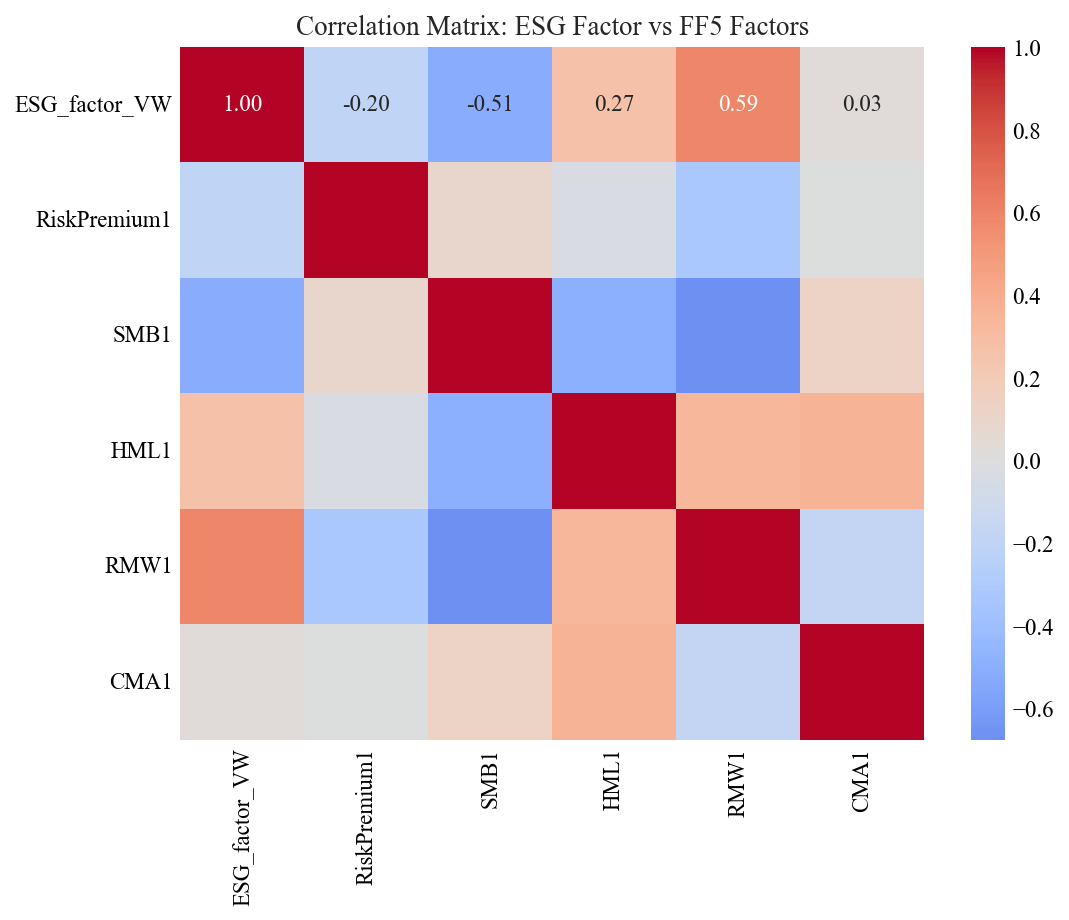


================ VIF Results ================
       Variable       VIF
0  RiskPremium1  1.152272
1          SMB1  2.172802
2          HML1  1.735897
3          RMW1  2.073424
4          CMA1  1.387692


In [128]:
# 构建包含 Y 和 X 的 DataFrame
corr_df = reg_df[['ESG_factor_VW', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

print("\n================ Correlation Matrix ================")
print(corr_matrix)

# 如果想画热力图（可选）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix: ESG Factor vs FF5 Factors")
plt.show()


# ========== VIF 检验 ==========
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 只对自变量做 VIF 检验（不要包含 ESG_factor_VW）
X = reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n================ VIF Results ================")
print(vif_data)


### E Score

##### **简短结论**

基于中国A股市场的回归检验结果显示：
* 整体回归情况：R-squared = 0.338，Adj. R-squared = 0.320
* F-statistic p 值 ≈ 9.8e-15 --> 整体回归模型高度显著，说明至少有一些解释变量能显著解释 ESG 因子。

1. ESG因子在控制Fama–French五因子后，不显著贡献额外的alpha（回归常数项大部分为负且显著），说明高ESG组合相较低ESG组合在收益上<u>没有系统性的超额表现</u>。
     - 截距项（const）在 -0.03，不显著为负（p =0.856），这意味着在控制市场风险溢价、规模、价值、盈利能力和投资风格后，高E–低E 组合并未产生额外正收益，反而可能存在一定负超额收益。

2. 传统五因子中的SMB（规模因子）、RMW（盈利能力因子）、CMA（投资因子）显著影响收益，而ESG因子并未展现出独立的解释力。
    - RiskPremium1 = -0.338，t = 2.132，p = 0.158
         - 市场因子不显著，E 因子与市场整体超额收益没有稳定关系。
    - SMB1 = -30.697，t = -5.195，p < 0.001
        - <u>显著为负</u>，说明 E 因子暴露在“规模因子”上：
        - SMB>0 意味着“偏小盘”； 这里是负，说明 E 因子显著更偏向 大市值公司。
    - HML1 = -9.443，t = -1.097，p = 0.273
        - 不显著，说明 ESG 因子和价值/成长风格没有稳定关系。
    - RMW1 = 22.914，t = 2.096，p ≈ 0.037
        - <u>高度显著为正</u>，说明 E 因子非常强烈地暴露在 盈利能力因子（高利润企业） 上。
        - 这很符合直觉：高 ESG 评级企业往往盈利能力较强。
    - CMA1 = 47.896，t = 3.098，p ≈ 0.002
        - <u>显著为正</u>，说明 E 因子也倾向于 低投资（conservative 投资风格） 的公司。
        - 这可能反映 ESG 企业更“稳健经营”，不激进扩张。

3. 这意味着，在目前的中国市场，ESG更多反映的是已被规模、盈利、投资等传统因子捕捉到的特征，其独立定价效应有限。

#### 构建月度E Long-Short 因子

##### 10 deciles

In [133]:
# 把公司分成高 S和 低 S组，用deciles（10）组
panel_month_nonmiss['E_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['E_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
e_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'E_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

e_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'E_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建S Factor
# 等权
e_hl_ew = e_ew_returns.pivot(index="Year_Month", columns="E_decile", values="monthly_return")
e_hl_ew['E_factor_EW'] = e_hl_ew[10] - hl_ew[1]

# 市值加权
e_hl_vw = e_vw_returns.pivot(index="Year_Month", columns="E_decile", values="vw_return")
e_hl_vw['E_factor_VW'] = e_hl_vw[10] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
e_reg_df = e_hl_vw[['E_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = e_reg_df['E_factor_VW']
X = e_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            E_factor_VW   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.045
Date:                Fri, 21 Nov 2025   Prob (F-statistic):             0.0115
Time:                        00:48:04   Log-Likelihood:                -455.89
No. Observations:                 186   AIC:                             923.8
Df Residuals:                     180   BIC:                             943.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### 5 deciles

In [135]:
# 把公司分成高 S和 低 S组，用deciles（10）组
panel_month_nonmiss['E_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['E_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 5, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
e_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'E_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

e_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'E_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建S Factor
# 等权
e_hl_ew = e_ew_returns.pivot(index="Year_Month", columns="E_decile", values="monthly_return")
e_hl_ew['E_factor_EW'] = e_hl_ew[5] - hl_ew[1]

# 市值加权
e_hl_vw = e_vw_returns.pivot(index="Year_Month", columns="E_decile", values="vw_return")
e_hl_vw['E_factor_VW'] = e_hl_vw[5] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
e_reg_df = e_hl_vw[['E_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = e_reg_df['E_factor_VW']
X = e_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            E_factor_VW   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     18.40
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           9.76e-15
Time:                        00:48:05   Log-Likelihood:                -398.30
No. Observations:                 186   AIC:                             808.6
Df Residuals:                     180   BIC:                             828.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### E Correlation Matrix



================ Correlation Matrix ================
              E_factor_VW  RiskPremium1      SMB1      HML1      RMW1  \
E_factor_VW      1.000000     -0.093355 -0.532347  0.303043  0.437418   
RiskPremium1    -0.093355      1.000000  0.094328 -0.030575 -0.322105   
SMB1            -0.532347      0.094328  1.000000 -0.497532 -0.676321   
HML1             0.303043     -0.030575 -0.497532  1.000000  0.337550   
RMW1             0.437418     -0.322105 -0.676321  0.337550  1.000000   
CMA1             0.113952     -0.003205  0.129793  0.364468 -0.175711   

                  CMA1  
E_factor_VW   0.113952  
RiskPremium1 -0.003205  
SMB1          0.129793  
HML1          0.364468  
RMW1         -0.175711  
CMA1          1.000000  


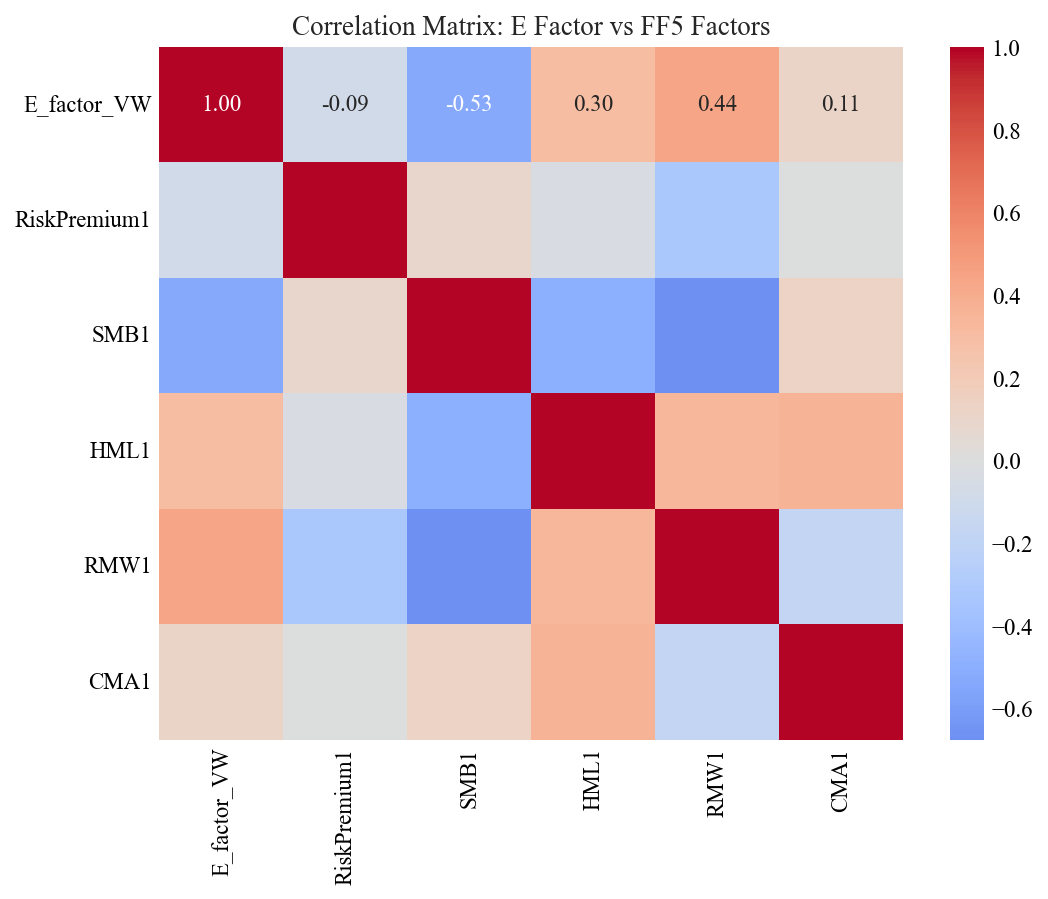


================ VIF Results ================
       Variable       VIF
0  RiskPremium1  1.152272
1          SMB1  2.172802
2          HML1  1.735897
3          RMW1  2.073424
4          CMA1  1.387692


In [137]:
# 构建包含 Y 和 X 的 DataFrame
corr_df = e_reg_df[['E_factor_VW', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

print("\n================ Correlation Matrix ================")
print(corr_matrix)

# 如果想画热力图（可选）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix: E Factor vs FF5 Factors")
plt.show()


# ========== VIF 检验 ==========
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 只对自变量做 VIF 检验（不要包含 ESG_factor_VW）
X = e_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n================ VIF Results ================")
print(vif_data)


### S Score

##### **简短结论**

基于中国A股市场的回归检验结果显示：
* 整体回归情况：R-squared = 0.465，Adj. R-squared = 0.450
* F-statistic p 值 ≈ 7.77e-23 --> 整体回归模型高度显著，说明至少有一些解释变量能显著解释 S 因子。

1. S因子在控制Fama–French五因子后，不显著贡献额外的alpha（回归常数项大部分为负且显著），说明高S组合相较低S组合在收益上<u>没有系统性的超额表现</u>。
     - 截距项（const）在 -0.2337，且不显著（p =0.257），这意味着在控制市场风险溢价、规模、价值、盈利能力和投资风格后，高S–低S 组合并没产生显著额外负收益。

2. 传统五因子中的SMB（规模因子）、HML（价值因子）、RMW（盈利能力因子）显著影响收益，而ESG因子并未展现出独立的解释力。
    - RiskPremium1 = -2.6849，t = -1.012，p = 0.313
         - 市场因子不显著，S 因子与市场整体超额收益没有稳定关系。
    - SMB1 = -16.1485，t = -2.195，p = 0.029
        - <u>显著为负</u>，说明 G 因子暴露在“规模因子”上：
        - SMB>0 意味着“偏小盘”； 这里是负，说明 E 因子显著更偏向 大市值公司。
    - HML1 = 21.1397，t = 1.936，p = 0.054
        - <u>显著为正</u>，说明 S 因子和价值/成长风格有稳定关系，偏向于价值型公司。
    - RMW1 = 77.5228，t = 5.689，p < 0.001
        - <u>高度显著为正</u>，说明 G 因子非常强烈地暴露在 盈利能力因子（高利润企业） 上。
        - 这很符合直觉：高 ESG 评级企业往往盈利能力较强。
    - CMA1 = 22.3658，t = 1.265，p ≈ 0.208
        - 投资风格因子不显著，S 因子与市场整体超额收益没有稳定关系。

3. 这意味着，在目前的中国市场，ESG更多反映的是已被规模、盈利、投资等传统因子捕捉到的特征，其独立定价效应有限。

#### 构建月度S Long-Short 因子

##### 10 deciles

In [142]:
# 把公司分成高 S和 低 S组，用deciles（10）组
panel_month_nonmiss['S_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['S_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
s_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'S_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

s_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'S_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建S Factor
# 等权
s_hl_ew = s_ew_returns.pivot(index="Year_Month", columns="S_decile", values="monthly_return")
s_hl_ew['S_factor_EW'] = s_hl_ew[10] - hl_ew[1]

# 市值加权
s_hl_vw = s_vw_returns.pivot(index="Year_Month", columns="S_decile", values="vw_return")
s_hl_vw['S_factor_VW'] = s_hl_vw[10] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
s_reg_df = s_hl_vw[['S_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = s_reg_df['S_factor_VW']
X = s_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            S_factor_VW   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     26.99
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           2.57e-20
Time:                        00:48:07   Log-Likelihood:                -461.90
No. Observations:                 186   AIC:                             935.8
Df Residuals:                     180   BIC:                             955.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### 5 deciles

In [144]:
# 把公司分成高 S和 低 S组，用deciles（5）组
panel_month_nonmiss['S_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['S_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 5, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
s_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'S_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

s_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'S_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建S Factor
# 等权
s_hl_ew = s_ew_returns.pivot(index="Year_Month", columns="S_decile", values="monthly_return")
s_hl_ew['S_factor_EW'] = s_hl_ew[5] - hl_ew[1]

# 市值加权
s_hl_vw = s_vw_returns.pivot(index="Year_Month", columns="S_decile", values="vw_return")
s_hl_vw['S_factor_VW'] = s_hl_vw[5] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
s_reg_df = s_hl_vw[['S_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = s_reg_df['S_factor_VW']
X = s_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            S_factor_VW   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     31.27
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           7.77e-23
Time:                        00:48:08   Log-Likelihood:                -439.07
No. Observations:                 186   AIC:                             890.1
Df Residuals:                     180   BIC:                             909.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### S Correlation Matrix
**Key Summary**：
1. S H-L 投资组合内的公司：
    - 偏向于大公司。
    - 盈利能力也更强。
    - 偏向于价值型公司（账面市值更高）。
2. 变量之间并不存在共线性。

**Correlation 解读**

|变量|解释|
|-----|-----|
|S 因子与市场因子<br>（RiskPremium1）| - 相关系数：≈ -0.22，接近 0 <br> - S 和市场整体风险溢价基本不相关，说明 S 因子并不是市场因子的重复。 |
|S 因子与 SMB<br>（规模因子）| - 相关系数：≈ -0.55，中等程度负相关 <br> - 高 S 投资组合更可能偏向大市值公司（因为 SMB 是“小市值减大市值”，负相关说明 ESG 因子与大市值正相关）。  |
|S 因子与 HML<br>（账面市值比因子） |- 相关系数：≈ +0.41，中等正相关 <br>- S 因子和价值股（高 B/M）有一点点正相关。<br>-高 S 投资组合更可能偏向价值股票。  |
|S 因子与 RMW<br>（盈利能力因子）|- 相关系数：≈ +0.63，比较明显的正相关 <br>-S 得分高的公司往往也有更强的盈利能力，ESG 可能部分反映了企业的质量（quality/profitability）。  |
|S 因子与 CMA<br>（投资因子）|- 相关系数：≈ 0.03，非常接近 0 <br> - 基本没有关系，说明 S 并不与投资风格挂钩。|  


================ Correlation Matrix ================
              S_factor_VW  RiskPremium1      SMB1      HML1      RMW1  \
S_factor_VW      1.000000     -0.228101 -0.556564  0.417426  0.632123   
RiskPremium1    -0.228101      1.000000  0.094328 -0.030575 -0.322105   
SMB1            -0.556564      0.094328  1.000000 -0.497532 -0.676321   
HML1             0.417426     -0.030575 -0.497532  1.000000  0.337550   
RMW1             0.632123     -0.322105 -0.676321  0.337550  1.000000   
CMA1             0.029052     -0.003205  0.129793  0.364468 -0.175711   

                  CMA1  
S_factor_VW   0.029052  
RiskPremium1 -0.003205  
SMB1          0.129793  
HML1          0.364468  
RMW1         -0.175711  
CMA1          1.000000  


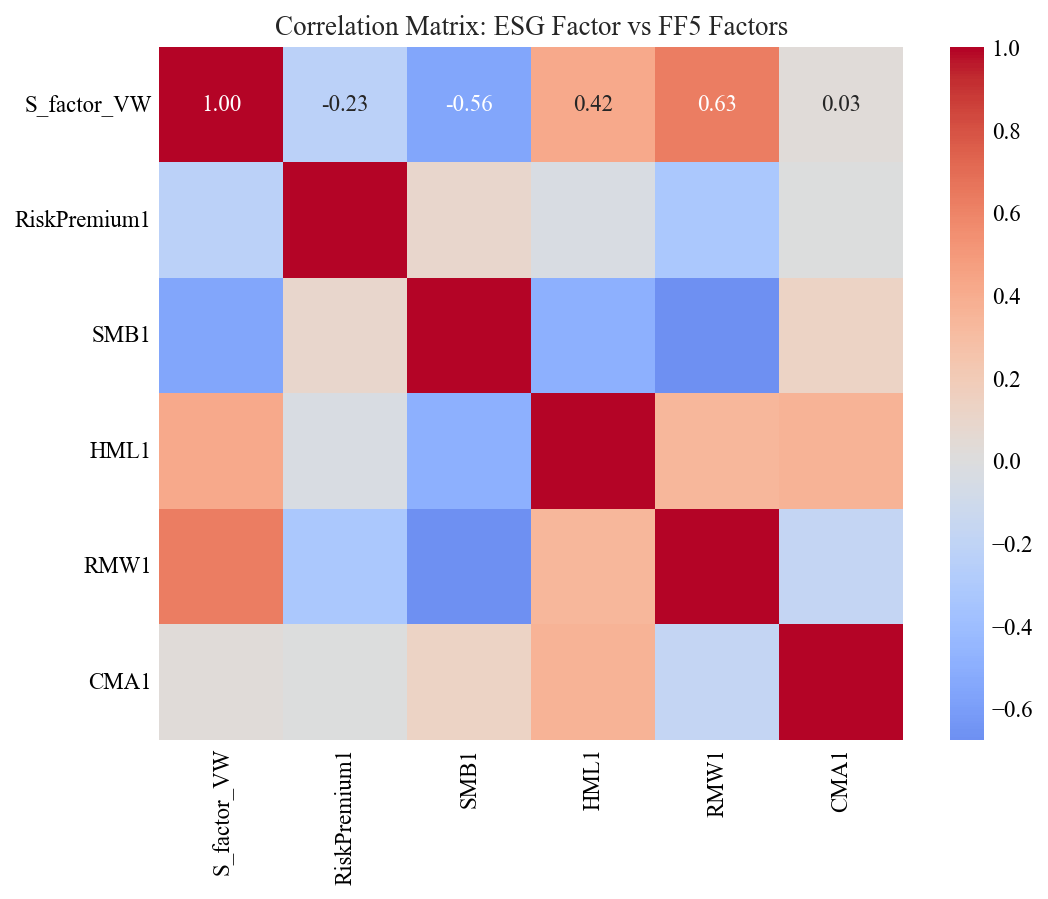


================ VIF Results ================
       Variable       VIF
0  RiskPremium1  1.152272
1          SMB1  2.172802
2          HML1  1.735897
3          RMW1  2.073424
4          CMA1  1.387692


In [146]:
# 构建包含 Y 和 X 的 DataFrame
corr_df = s_reg_df[['S_factor_VW', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

print("\n================ Correlation Matrix ================")
print(corr_matrix)

# 如果想画热力图（可选）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix: ESG Factor vs FF5 Factors")
plt.show()


# ========== VIF 检验 ==========
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 只对自变量做 VIF 检验（不要包含 ESG_factor_VW）
X = s_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n================ VIF Results ================")
print(vif_data)


### G Score

##### **简短结论**：截距项显著为负

基于中国A股市场的回归检验结果显示：
* 整体回归情况：R-squared = 0.514，Adj. R-squared = 0.501
* F-statistic p 值 ≈ 1.4e-26 --> 整体回归模型高度显著，说明至少有一些解释变量能显著解释 G 因子。

1. G因子在控制Fama–French五因子后，显著贡献额外的负alpha，说明高S组合相较低S组合在收益上<u>有系统性的超额负表现</u>。
     - 截距项（const）在 -0.3844，在10%的显著性水平下，显著为负（p =0.058），这意味着在控制市场风险溢价、规模、价值、盈利能力和投资风格后，高G–低G 组合产生额外负收益。

2. 传统五因子中的SMB（规模因子）、HML（价值因子）、RMW（盈利能力因子）、CMA（投资因子）显著影响收益，而ESG因子并未展现出独立的解释力。
    - RiskPremium1 = 1.4530，t = 0.559，p = 0.577
         - 市场因子不显著，G 因子与市场整体超额收益没有稳定关系。
    - SMB1 = -19.6136，t = 2.256，p = 0.025
        - <u>显著为负</u>，说明 G 因子暴露在“规模因子”上：
        - SMB>0 意味着“偏小盘”； 这里是负，说明 E 因子显著更偏向 大市值公司。
    - HML1 = 24.1619，t = -1.097，p = 0.273
        - <u>显著为正</u>，说明 G 因子和价值/成长风格有稳定关系，偏向于价值型公司。
    - RMW1 = 82.6918，t = 6.190，p < 0.001
        - <u>高度显著为正</u>，说明 G 因子非常强烈地暴露在 盈利能力因子（高利润企业） 上。
        - 这很符合直觉：高 ESG 评级企业往往盈利能力较强。
    - CMA1 = 43.9271，t = 2.539，p ≈ 0.012
        - <u>显著为正</u>，说明 G 因子也倾向于 低投资（conservative 投资风格） 的公司。
        - 这可能反映 ESG 企业更“稳健经营”，不激进扩张。

3. 这意味着，在目前的中国市场，G更多反映的是已被规模、盈利、投资等传统因子捕捉到的特征，其独立定价效应有限。

#### 构建月度G Long-Short 因子

##### 10 deciles

In [151]:
# 把公司分成高 G和 低 G组，用deciles（10）组
panel_month_nonmiss['G_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['G_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
g_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'G_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

g_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'G_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建G Factor
# 等权
g_hl_ew = g_ew_returns.pivot(index="Year_Month", columns="G_decile", values="monthly_return")
g_hl_ew['G_factor_EW'] = g_hl_ew[10] - hl_ew[1]

# 市值加权
g_hl_vw = g_vw_returns.pivot(index="Year_Month", columns="G_decile", values="vw_return")
g_hl_vw['G_factor_VW'] = g_hl_vw[10] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
g_reg_df = g_hl_vw[['G_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = g_reg_df['G_factor_VW']
X = g_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            G_factor_VW   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     30.22
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.13e-22
Time:                        00:48:10   Log-Likelihood:                -448.84
No. Observations:                 186   AIC:                             909.7
Df Residuals:                     180   BIC:                             929.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### 5 deciles

In [153]:
# 把公司分成高 G和 低 G组，用deciles（5）组
panel_month_nonmiss['G_decile'] = (
    panel_month_nonmiss.groupby("Year_Month")['G_Score']
    .transform(lambda x: pd.qcut(x.rank(method="first"), 5, labels=False) + 1)
)

# 加权方法：
# Market cap weighted
g_ew_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'G_decile'])['monthly_return']
    .mean()
    .reset_index()
)
# Equal weighted 
def weighted_return(x):
    return np.average(x['monthly_return'], weights=x['market_cap'])

g_vw_returns = (
    panel_month_nonmiss.groupby(['Year_Month', 'G_decile'])
    .apply(weighted_return)
    .reset_index(name="vw_return")
)

# 构建G Factor
# 等权
g_hl_ew = g_ew_returns.pivot(index="Year_Month", columns="G_decile", values="monthly_return")
g_hl_ew['G_factor_EW'] = g_hl_ew[5] - hl_ew[1]

# 市值加权
g_hl_vw = g_vw_returns.pivot(index="Year_Month", columns="G_decile", values="vw_return")
g_hl_vw['G_factor_VW'] = g_hl_vw[5] - hl_vw[1]

# 五因子回归
# 市值加权（FF model的数据里没有等权）
# 1. 合并 ESG 因子和 FF5 因子
g_reg_df = g_hl_vw[['G_factor_VW']].reset_index().merge(
    ff5_df[['TradingMonth', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']],
    left_on='Year_Month',
    right_on='TradingMonth',
    how='inner'
)

# 2. 设置因变量 (ESG因子收益) 和 自变量 (五因子)
Y = g_reg_df['G_factor_VW']
X = g_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 3. 加上常数项 (α)
X = sm.add_constant(X)

# 4. 回归
model = sm.OLS(Y, X).fit()
print("==========================五因子回归流通市值加权=======================")
print(model.summary())


==========================五因子回归流通市值加权=======================
                            OLS Regression Results                            
Dep. Variable:            G_factor_VW   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     38.15
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           1.41e-26
Time:                        00:48:11   Log-Likelihood:                -435.09
No. Observations:                 186   AIC:                             882.2
Df Residuals:                     180   BIC:                             901.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### G Correlation Matrix
**Key Summary**：
1. G H-L 投资组合内的公司：
    - 偏向于大公司。
    - 盈利能力也更强。
    - 偏向于价值型公司（账面更高）。
2. 变量之间并不存在共线性。

**Correlation 解读**

|变量|解释|
|-----|-----|
|G 因子与市场因子<br>（RiskPremium1）| - 相关系数：≈ -0.14，接近 0 <br> - G 和市场整体风险溢价基本不相关，说明 G 因子并不是市场因子的重复。 |
|G 因子与 SMB<br>（规模因子）| - 相关系数：≈ -0.59，高程度负相关 <br> - 高 G 投资组合更可能偏向大市值公司（因为 SMB 是“小市值减大市值”，负相关说明 G 因子与大市值正相关）。  |
|G 因子与 HML<br>（账面市值比因子） |- 相关系数：≈ +0.47，明显正相关 <br>- G 因子和价值股（高 B/M）有一点正相关。<br>-高 G 投资组合更可能偏向价值股票。  |
|G 因子与 RMW<br>（盈利能力因子）|- 相关系数：≈ +0.63，比较明显的正相关 <br>-G 得分高的公司往往也有更强的盈利能力，ESG 可能部分反映了企业的质量（quality/profitability）。  |
|G 因子与 CMA<br>（投资因子）|- 相关系数：≈ 0.10，非常接近 0 <br> - 基本没有关系，说明 G 并不与投资风格挂钩。|  


================ Correlation Matrix ================
              G_factor_VW  RiskPremium1      SMB1      HML1      RMW1  \
G_factor_VW      1.000000     -0.146810 -0.591089  0.479576  0.634924   
RiskPremium1    -0.146810      1.000000  0.094328 -0.030575 -0.322105   
SMB1            -0.591089      0.094328  1.000000 -0.497532 -0.676321   
HML1             0.479576     -0.030575 -0.497532  1.000000  0.337550   
RMW1             0.634924     -0.322105 -0.676321  0.337550  1.000000   
CMA1             0.101155     -0.003205  0.129793  0.364468 -0.175711   

                  CMA1  
G_factor_VW   0.101155  
RiskPremium1 -0.003205  
SMB1          0.129793  
HML1          0.364468  
RMW1         -0.175711  
CMA1          1.000000  


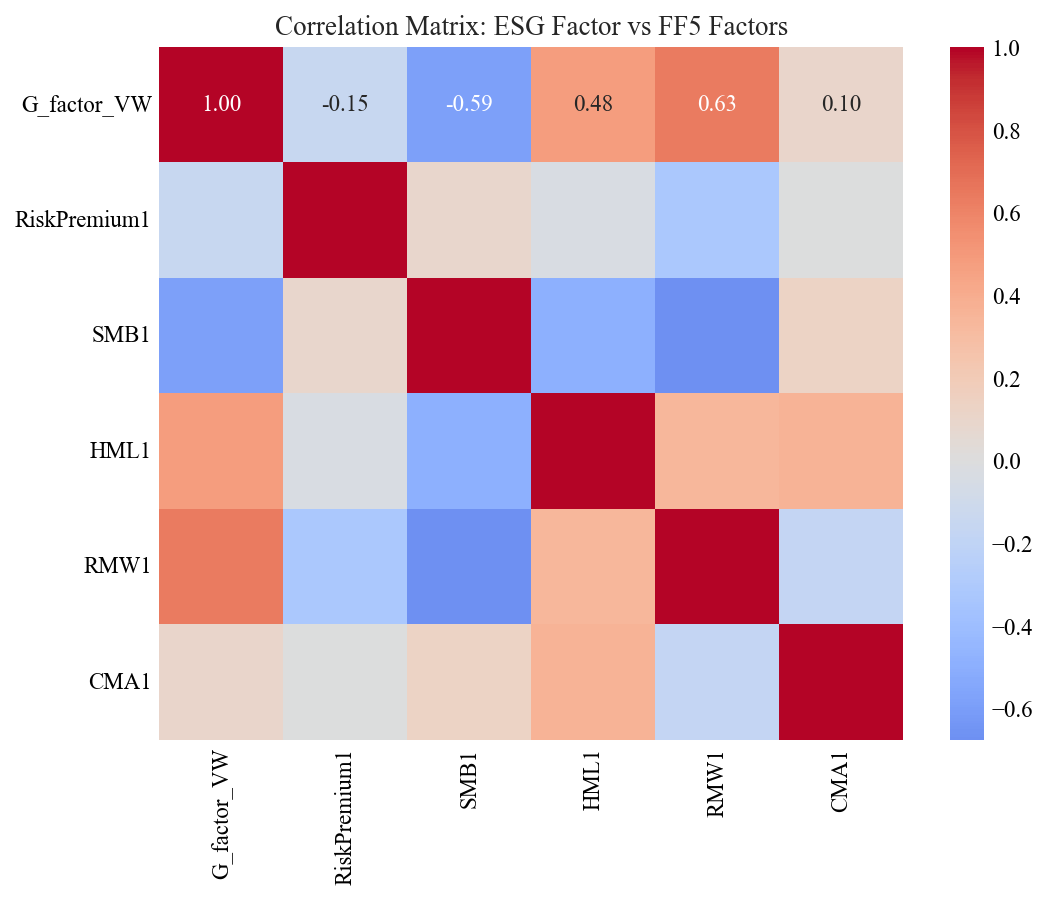


================ VIF Results ================
       Variable       VIF
0  RiskPremium1  1.152272
1          SMB1  2.172802
2          HML1  1.735897
3          RMW1  2.073424
4          CMA1  1.387692


In [155]:
# 构建包含 Y 和 X 的 DataFrame
corr_df = g_reg_df[['G_factor_VW', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

print("\n================ Correlation Matrix ================")
print(corr_matrix)

# 如果想画热力图（可选）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix: ESG Factor vs FF5 Factors")
plt.show()


# ========== VIF 检验 ==========
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 只对自变量做 VIF 检验（不要包含 ESG_factor_VW）
X = g_reg_df[['RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']]

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n================ VIF Results ================")
print(vif_data)


### Correlation Matrix


ESG Correlation Matrix:
              ESG_factor  RiskPremium1      SMB1      HML1      RMW1      CMA1
ESG_factor      1.000000     -0.195300 -0.514286  0.268480  0.589255  0.029579
RiskPremium1   -0.195300      1.000000  0.094328 -0.030575 -0.322105 -0.003205
SMB1           -0.514286      0.094328  1.000000 -0.497532 -0.676321  0.129793
HML1            0.268480     -0.030575 -0.497532  1.000000  0.337550  0.364468
RMW1            0.589255     -0.322105 -0.676321  0.337550  1.000000 -0.175711
CMA1            0.029579     -0.003205  0.129793  0.364468 -0.175711  1.000000

E Correlation Matrix:
              E_factor  RiskPremium1      SMB1      HML1      RMW1      CMA1
E_factor      1.000000     -0.093355 -0.532347  0.303043  0.437418  0.113952
RiskPremium1 -0.093355      1.000000  0.094328 -0.030575 -0.322105 -0.003205
SMB1         -0.532347      0.094328  1.000000 -0.497532 -0.676321  0.129793
HML1          0.303043     -0.030575 -0.497532  1.000000  0.337550  0.364468
RMW1          

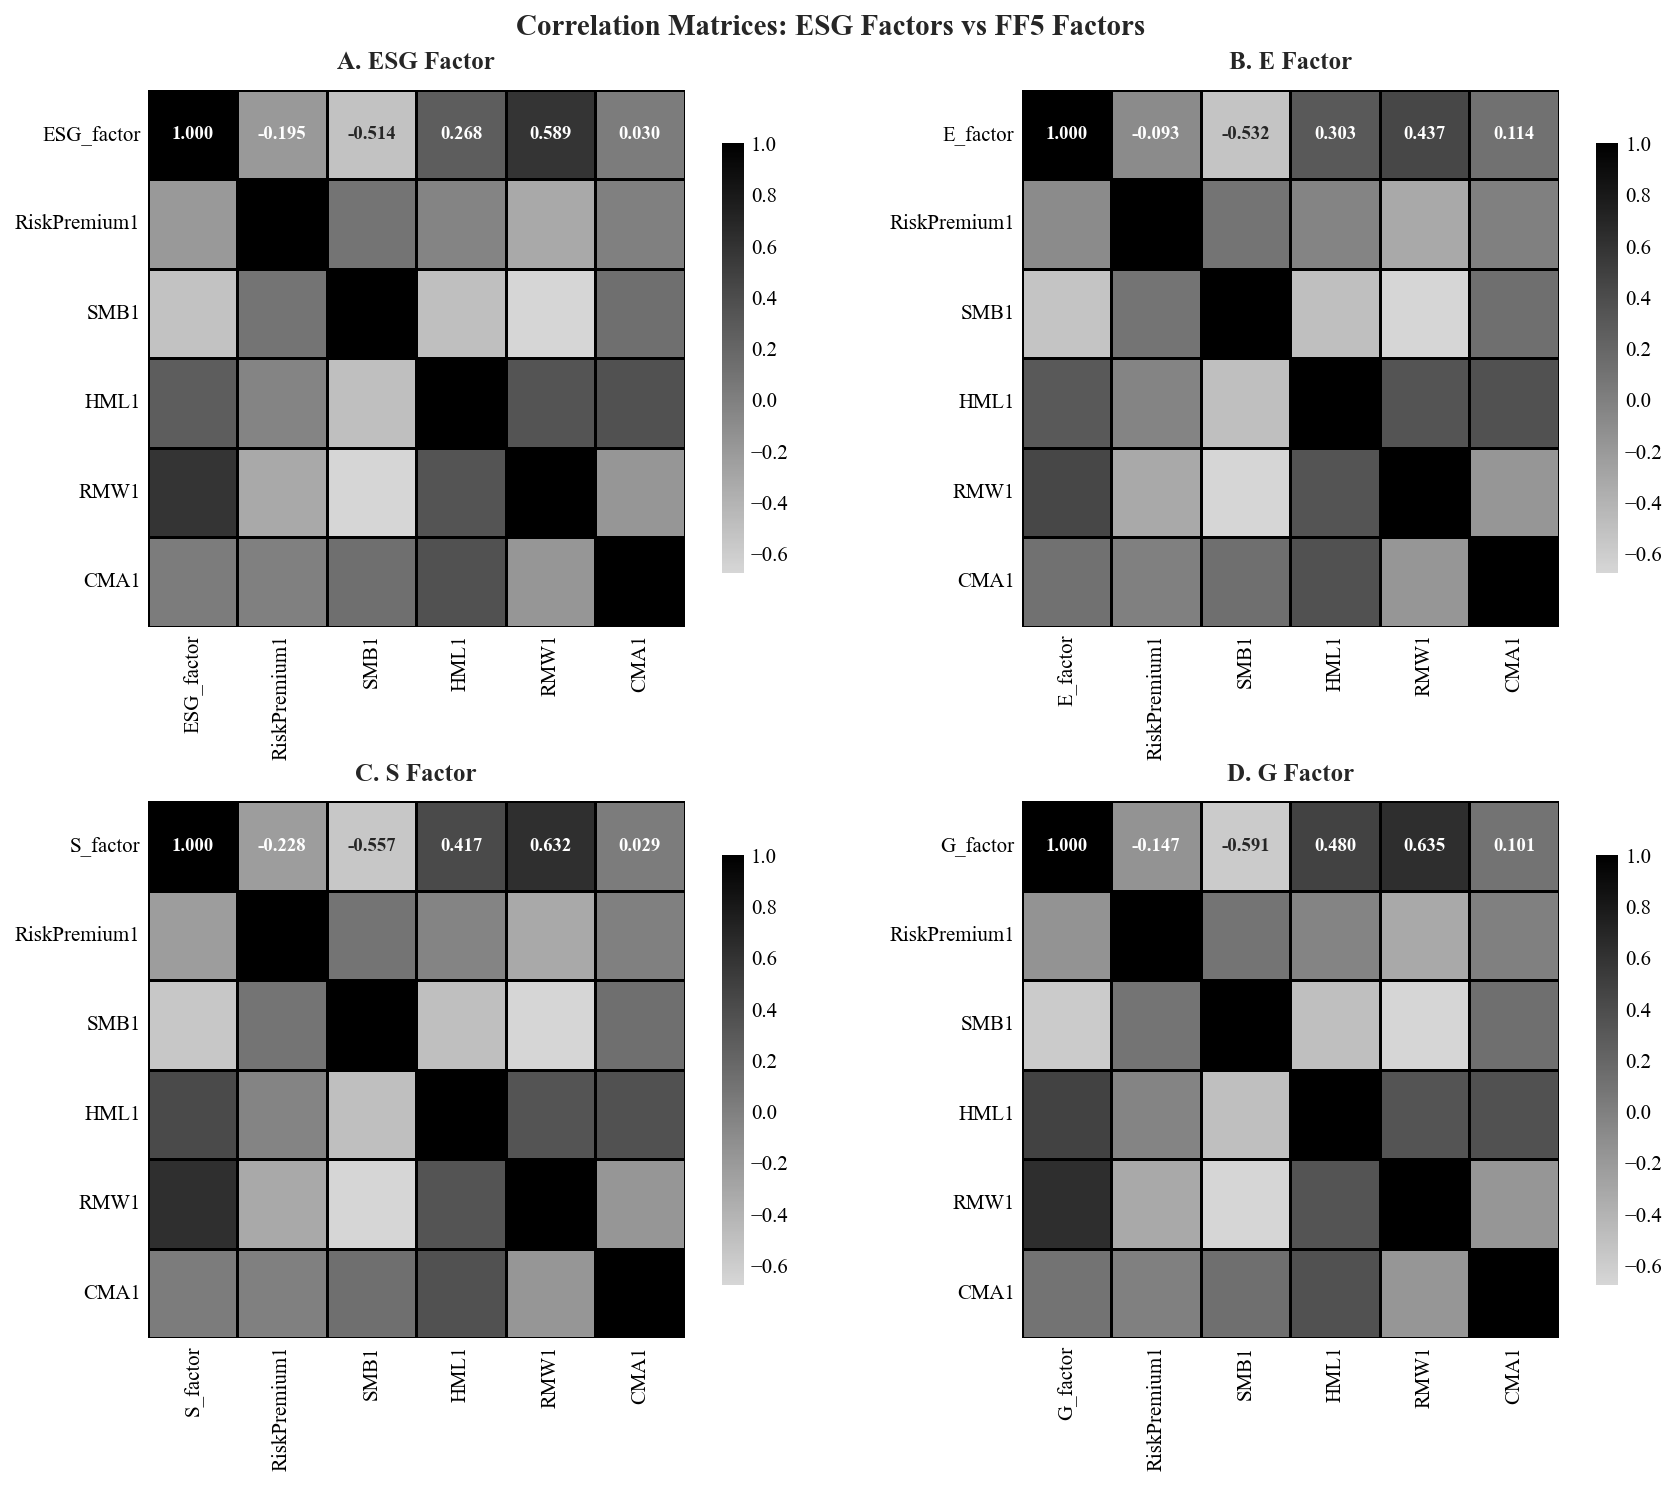

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ====== 设置统一的学术风格 ======
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
})

# ====== 为每个数据框计算相关系数矩阵 ======
def prepare_corr_matrix(df, factor_name):
    """准备相关系数矩阵"""
    # 根据因子名称确定列名
    factor_col = f'{factor_name}_factor_VW'
    
    # 选择相关的列
    corr_cols = [factor_col, 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']
    corr_df = df[corr_cols]
    corr_matrix = corr_df.corr()
    
    # 重命名因子列以区分不同的ESG类型
    corr_matrix = corr_matrix.rename(columns={factor_col: f'{factor_name}_factor'})
    corr_matrix.index = [f'{factor_name}_factor' if factor_col in idx else idx for idx in corr_matrix.index]
    return corr_matrix

# 计算四个相关系数矩阵
corr_matrices = {}
for factor_name, df in [('ESG', reg_df), ('E', e_reg_df), ('S', s_reg_df), ('G', g_reg_df)]:
    corr_matrix = prepare_corr_matrix(df, factor_name)
    corr_matrices[factor_name] = corr_matrix
    print(f"\n{factor_name} Correlation Matrix:")
    print(corr_matrix)

    
# ====== 增强版黑白热力图 ======
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Correlation Matrices: ESG Factors vs FF5 Factors', fontsize=14, fontweight='bold')


# 定义子图标题和对应的相关系数矩阵
subplots_info = [
    (axes[0, 0], corr_matrices['ESG'], "A. ESG Factor"),
    (axes[0, 1], corr_matrices['E'], "B. E Factor"), 
    (axes[1, 0], corr_matrices['S'], "C. S Factor"),
    (axes[1, 1], corr_matrices['G'], "D. G Factor")
]

# 创建自定义的灰度颜色映射（从白到黑）
from matplotlib.colors import LinearSegmentedColormap
colors = ['white', '0.8', '0.6', '0.4', '0.2', 'black']  # 渐变的灰度
gray_cmap = LinearSegmentedColormap.from_list('gray_cmap', colors, N=256)

# 绘制每个子图的热力图（灰度风格）
for ax, corr_matrix, title in subplots_info:
    # 创建掩码来隐藏对角线上的1.000（可选）
    mask = np.zeros_like(corr_matrix, dtype=bool)
    np.fill_diagonal(mask, True)
    
    heatmap = sns.heatmap(corr_matrix, 
                annot=True, 
                fmt=".3f", 
                cmap=gray_cmap,
                center=0,
                ax=ax,
                cbar_kws={'shrink': 0.8},
                annot_kws={'size': 9, 'weight': 'bold'},
                square=True,
                linewidths=0.5,
                linecolor='black',
                mask=None)  # 不隐藏对角线
    
    ax.set_title(title, fontweight='bold', pad=10)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
# plt.savefig("Figure_Correlation_Matrices_ESG_Factors_gray.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("Figure_Correlation_Matrices_ESG_Factors_gray.png", dpi=300, bbox_inches='tight')
plt.show()


## Dynamic ESG Effects（动态 ESG 效应）

意思：看看 ESG 因子的预测能力是不是随着时间变化。

举例：在某些特殊时期，ESG 可能更有影响力，比如：

* 政策收紧时期（比如环保整治、碳排放政策），高 ESG 企业可能表现更好；
* COVID-19 疫情期间，企业的社会责任（S 因子，比如员工保护）可能更受投资者关注；
* 绿色发展政策推动的年份（新能源补贴、碳中和目标）。  

研究方向：把样本切分成不同子时期，或者用滚动窗口回归，看看 ESG 因子在不同时期的 α 和显著性是否变化。

### 子样本划分

#### COVID 疫情期间
----
**Key Timeline**:   
**2019年12月31日**：世卫组织驻华代表处从武汉市卫生健康委员会网站上获悉关于中华人民共和国武汉出现“病毒性肺炎”病例的情况通报。  
**2020年7月22日**：COVID-19疫苗紧急使用申请于4月4日开始，经过各种讨论和评估，中央政府于6月24日批准了使用计划，并于7月22日批准了疫苗的紧急使用。   
**2021年5月1日**：疫苗大范围接种进行中，5月23日，当局报告称，已有超过5亿人接种了疫苗。  
**2022年12月12日**:“新十条”发布与“行程码”下线。随着中国优化疫情防控“新十条”措施的发布，跨区域流动不再查验健康码和核酸证明。同时，全国通用的“通信大数据行程卡”（行程码）于2022年12月13日0时正式下线。意味着疫情风控时期结束的里程碑。


Reference: https://www.who.int/zh/news/item/29-06-2020-covidtimeline  
https://baijiahao.baidu.com/s?id=1752066985907962307&wfr=spider&for=pc  
https://english.nmpa.gov.cn/2020-08/24/c_531210.html  
https://www.theguardian.com/world/2021/may/30/china-forces-pace-of-vaccinations-with-persuasion-and-some-cash?utml 

**假设** :  
社会（S）上的影响：
* 员工健康与安全：从“福利”升级为“核心责任”。企业必须制定严格的职场健康协议、提供防护物资、关注员工心理健康。这成为衡量企业社会价值的关键指标。
* 预计：社会责任感高的公司可能会有超额收益，由于他们相对于其他公司更加的关注企业的社会责任感。

治理（G）上的影响：
* 企业供应链：疫情暴露了全球供应链的脆弱性。企业开始更加关注供应链的韧性 和透明度。
* 危机管理与业务连续性：疫情检验了企业的危机应对能力和治理水平。拥有良好治理结构的企业能更快地适应变化、保障运营。ESG风险管理被正式纳入企业核心战略框架。
* 预计：G-score高的公司，应该会存在Profitability的上升。

预计结论：在COVID时期，相较于其他公司，高ESG的公司应该具有更好的表现。

----
**结论**

<u>ESG 因子分阶段回归结果</u>

| Window                | n_months | Alpha   | p_alpha | t_alpha |   R²   | Ann. Ret | Ann. Vol | Sharpe | Avg. Turnover |
|------------------------|----------|---------|---------|---------|--------|----------|----------|--------|---------------|
| 2017-01-01 ~ 2019-12-31 基准期 |   36     | -0.0711 | 0.8391  | -0.2030 | 0.5150 |  6.0095  |  8.3042  | 0.7237 | 0.8348        |
| 2020-01-01 ~ 2020-08-01 冲刺期|    8     |  1.8411 | 0.0000  |  5.1845 | 0.9605 | -5.3468  | 14.7207  | -0.3632| 0.7663        |
| 2020-08-01 ~ 2021-04-30 复苏期|    9     |  0.5951 | 0.2734  |  1.0952 | 0.7529 | 14.6940  |  8.1045  | 1.8131 | 0.8126        |
| 2021-05-01 ~ 2022-12-31 后疫情期|   14     | -1.0013 | 0.1786  | -1.3452 | 0.5369 | -18.7633 | 14.3589  | -1.3067| 0.8976        |
|


* 疫情冲刺期显著的正收益：在常态期间和疫情的其他期间，ESG H-L的并未产生显著的正回报。但是在疫情的冲刺期，该投资组合展示出相较于FF5显著的正回报（alpha = 1.8411，p_value < 0.0001）。疫情冲击下市场偏好 ESG 企业（风险更低、治理更稳健），导致其被短期追捧。
    * 这说明ESG 投资在突发的危机公共事件中可能有“避险价值”，但其避险价值会随着市场的稳定逐渐消失，甚至在平常的市场中会展现出负超额收益的特点。
* 换手率：换手率在疫情初期突然下降，随着疫情的逐渐恢复，换手率呈现上升的特点。这或许说明在疫情初期企业都被迫进入“防御模式”，ESG 行为和披露差异不大。
    * 随着复苏，不同企业在 员工管理、供应链恢复、绿色转型投入 等方面表现差异逐渐拉开，导致 ESG 排名更分化。

<u> S 因子分阶段回归结果</u>

| Window                | n_months | Alpha   | p_alpha | t_alpha |   R²   | Ann. Ret | Ann. Vol | Sharpe | Avg. Turnover |
|------------------------|----------|---------|---------|---------|--------|----------|----------|--------|---------------|
| 2017-01-01 ~ 2019-12-31 基准期|   36     | -0.2341 | 0.1140  | -1.5085 | 0.6135 |  6.3863  | 10.3539  | 0.6168 | 0.8728        |
| 2020-01-01 ~ 2020-08-01 冲刺期|    8     |  2.2877 | 0.0002  |  3.6663 | 0.8811 | -13.3138 | 15.0724  | -0.8833| 0.8053        |
| 2020-08-01 ~ 2021-04-30 复苏期|    9     | -2.1561 | 0.0005  | -3.4953 | 0.7515 |  6.5105  | 10.9705  | 0.5935 | 0.8528        |
| 2021-05-01 ~ 2022-12-31 后疫情期|   14     | -1.4975 | 0.0503  | -1.9573 | 0.5917 | -23.5598 | 19.7448  | -1.1932| 0.9837  |


* 疫情冲刺期显著的正收益 与 复苏及后疫情期显著负收益：在疫情冲刺期间，S因子具有高度显著的超额正收益（alpha = 2.288, p-vlaue= 0.0002）。而随着经济的复苏，S因子逐渐显露出显著的负收益，在复苏期（alpha = -2.1561, p-vlaue= 0.0005）和后疫情期（alpha = -1.4975, p-vlaue= 0.0503）。
    * 这说明S 投资在疫情初期，具有明显的正溢价。这或许和疫情初期社会责任感强的企业更受市场青睐，被视为具备更好的声誉与抗风险能力。但是随着疫情复苏，高S的企业反而表现为落后，这可能和市场重新偏好高风险和增长性企业有关。
* 换手率：换手率在疫情初期突然下降，随着疫情的逐渐恢复，换手率呈现上升的特点。


<u>G 因子分阶段回归结果</u>

| Window                | n_months | Alpha   | p_alpha | t_alpha |   R²   | Ann. Ret | Ann. Vol | Sharpe | Avg. Turnover |
|------------------------|----------|---------|---------|---------|--------|----------|----------|--------|---------------|
| 2017-01-01 ~ 2019-12-31 基准期|   36     | -0.1806 | 0.6472  | -0.4576 | 0.7448 |  4.6773  | 10.5534  | 0.4432 | 1.0155        |
| 2020-01-01 ~ 2020-08-01 冲刺期|    8     | -2.2366 | 0.0000  | -8.5705 | 0.9730 | -28.7613 | 12.4276  | -2.3143| 0.7814        |
| 2020-08-01 ~ 2021-04-30 复苏期|    9     | -1.8558 | 0.0000  | -4.9384 | 0.7795 | -0.9046  |  7.4739  | -0.1210| 0.8785        |
| 2021-05-01 ~ 2022-12-31 后疫情期|   14     | -1.2428 | 0.0715  | -1.8025 | 0.6526 | -20.3718 | 17.4165  | -1.1697| 0.9314        |

* 疫情冲刺期，复苏期，和后疫情期间G因子均具有高度显著的超额负收益：在常态期，治理因子并没有独立溢价，表现平平（alpha = -0.1806, p = 0.6472）。而随着疫情的开始G因子开始显露出显著的负收益，并随着疫情的稳定，逐渐减小虽仍然为负数。
    - 在疫情期间，高 G 企业（治理更严格、合规度高）并没有被市场追捧，并且持续跑输。投资者或许认为在疫情期间过于严格的遵守防疫政策会限制企业的防战。
    * 这说明S 投资在疫情初期，具有明显的正溢价。这或许和疫情初期社会责任感强的企业更受市场青睐，被视为具备更好的声誉与抗风险能力。但是随着疫情复苏，高S的企业反而表现为落后，这可能和市场重新偏好高风险和增长性企业有关。市场对治理优势并未给予正向溢价反而更追捧 灵活性高、治理相对宽松的小公司。
* 换手率：换手率在疫情初期突然下降，随着疫情的逐渐恢复，换手率呈现上升的特点。

特别说明：本段落并未探索E H-L投资组合在特殊市场时期的表现情况，由于疫情这一突发事件对于股市的主要的影响集中于G和S层面，和环境相关因素并无显著关系（E）。


In [161]:
# 1) 准备月度序列并合并 FF5
def prep_month_panel(hl_vw, ff5_df, factor_col="ESG_factor_VW"):
    # 确保字符串月份一致
    # 处理 hl_vw
    left = hl_vw[[factor_col]].reset_index().rename(columns={"Year_Month":"TradingMonth"})
        # 通过.reset_index()把索引变成一列。
        # 之后通过.rename(columns["Year_Month":"TradingMonth"]) 把那个索引列Index的名字改成“TradingMonth”
    left["TradingMonth"] = left["TradingMonth"].astype(str) # 有时候索引就是字符串，这里统一成 str

    # 处理ff5_df
    right = ff5_df[["TradingMonth","RiskPremium1","SMB1","HML1","RMW1","CMA1"]].copy() # 只找这些感兴趣的列。
    right["TradingMonth"] = right["TradingMonth"].astype(str) # 有时候索引就是字符串，这里统一成 str
    
    # 把数字合并成panel
    panel = (left.merge(right, on="TradingMonth", how="inner")
                  .sort_values("TradingMonth")
                  .reset_index(drop=True)) 
    
    # 月度字符串 -> 日期（方便筛选）
    panel["Date"] = pd.to_datetime(panel["TradingMonth"] + "-01") #把trading month变成一个完整的月份
    panel["Year"] = panel["Date"].dt.year # 提取其中的年份

    return panel

# 2) 在一个子样本内进行 FF5 回归 + 统计（默认使用 Newey-West HAC t 值，滞后=12）
def run_ff5_subsample(panel, start, end, factor_col="ESG_factor_VW", lags=12):
    sub = panel[(panel["Date"] >= pd.to_datetime(start)) & (panel["Date"] <= pd.to_datetime(end))].copy()
    # 选择在start和end时间段之内的事件。
    
    if sub.empty: #如果时间段内没有数据，直接返回None
        return None

    Y = sub[factor_col].astype(float) #选择factor_col作为Y变量。
    X = sub[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]].astype(float) #选择其他数据作为解释变量。
    X = sm.add_constant(X) #给自变量增加截距用于估计alpha

    ols = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": lags}) 
    # 进行回归
    # cov_type="HAC"，使用Newey–West 稳健协方差，考虑序列的自相关/异方差
    # 月频取 12 是常见保守选择，可做敏感性检验（如 6/9/18）。
    
    alpha = ols.params["const"] # alpha：回归截距=在控制 FF5 后的“超额回报”（月度）；
    t_alpha = ols.tvalues["const"]# t_alpha：alpha 的 HAC t 值（稳健 t）
    p_alpha = ols.pvalues["const"]     # p 值
    r2 = ols.rsquared # r2：拟合优度。

    # 年化（基于月度序列：均值*12，波动*sqrt(12)）
    mu_m   = Y.mean() # 平均月收益
    vol_m  = Y.std(ddof=1) # 平均月标准差
    mu_ann = mu_m * 12.0 # 年化
    vol_ann= vol_m * np.sqrt(12.0) # 年化
    sharpe = np.nan if vol_ann==0 else mu_ann / vol_ann # 计算sharp ratio

    out = {
        "window"  : f"{start} ~ {end}",
        "n_months": len(sub),
        "alpha"   : alpha,
        "p_alpha"  : p_alpha,   
        "t_alpha" : t_alpha,
        "R2"      : r2,
        "ann_ret" : mu_ann,
        "ann_vol" : vol_ann,
        "sharpe"  : sharpe,
        # 为了后面可合并换手率，顺便返回年份列表
        "years"   : sorted(sub["Year"].unique().tolist()),
    }
    return out

# 3) 主函数：按阶段批量跑，并可选合并“平均换手率”
def run_all_windows(hl_vw, ff5_df, periods, turnover_df=None, factor_col="ESG_factor_VW"):
    # 先运行prep的函数去准备数据
    panel = prep_month_panel(hl_vw, ff5_df, factor_col=factor_col)

    rows = []
    for (start, end) in periods: #遍历每一个period
        res = run_ff5_subsample(panel, start, end, factor_col=factor_col, lags=12)
        # 在每个窗口里调用 run_ff5_subsample，返回字典的结果。
        if res: # 如果有结果，就append进row去。
            rows.append(res)

    res_df = pd.DataFrame(rows) #把结果整理成Data Frame

    # 可选：拼上各阶段“平均换手率”
    if turnover_df is not None and not turnover_df.empty:
        # turnover_df: columns ["Year","Turnover_LongShort"]
        def avg_turn(years):
            s = turnover_df[turnover_df["Year"].isin(years)]["Turnover_LongShort"]
            return np.nan if s.empty else s.mean()
        res_df["avg_turnover"] = res_df["years"].apply(avg_turn)

    # 美化展示
    show = res_df.drop(columns=["years"], errors="ignore").copy()
    for col in ["alpha","t_alpha","p_alpha","R2","ann_ret","ann_vol","sharpe","avg_turnover"]:
        if col in show.columns:
            show[col] = show[col].astype(float).round(4)
    return show

# ================= 使用示例 =================
# 定义阶段（按你的划分）
periods = [
    ("2017-01-01", "2019-12-31"),  # 基准期
    ("2020-01-01", "2020-08-01"),  # 疫情冲击期，疫苗研发成功前
    ("2020-08-01", "2021-04-30"),  # 缓慢复苏期，疫苗研发成功，部分复工生产，但仍未开始大面积注射
    ("2021-05-01", "2022-12-31"),  # 后疫情期，疫苗已经进行大范围注射
]

In [162]:
# ESG 检测
# 如果你有年度的 Long–Short 换手率表 turnover_ls_df（Year, Turnover_LongShort），传进去；不然传 None
# result_df = run_all_windows(hl_vw, ff5_df, periods, turnover_df=turnover_ls_df, factor_col="ESG_factor_VW")
esg_result_df = run_all_windows(hl_vw, ff5_df, periods, turnover_df=esg_turnover_ls_df, factor_col="ESG_factor_VW")
print("=========================ESG 结果==========================")
print(esg_result_df)

# E 检测
# result_df = run_all_windows(hl_vw, ff5_df, periods, turnover_df=turnover_ls_df, factor_col="ESG_factor_VW")
e_result_df = run_all_windows(e_hl_vw, ff5_df, periods, turnover_df=e_turnover_ls_df, factor_col="E_factor_VW")
print("=========================E 结果==========================")
print(e_result_df)

# S 检测
# result_df = run_all_windows(hl_vw, ff5_df, periods, turnover_df=turnover_ls_df, factor_col="ESG_factor_VW")
s_result_df = run_all_windows(s_hl_vw, ff5_df, periods, turnover_df=s_turnover_ls_df, factor_col="S_factor_VW")
print("=========================S 结果==========================")
print(s_result_df)

# G 检测
# result_df = run_all_windows(hl_vw, ff5_df, periods, turnover_df=turnover_ls_df, factor_col="ESG_factor_VW")
g_result_df = run_all_windows(g_hl_vw, ff5_df, periods, turnover_df=g_turnover_ls_df, factor_col="G_factor_VW")
print("=========================G 结果==========================")
print(g_result_df)


=========================ESG 结果==========================
                    window  n_months   alpha  p_alpha  t_alpha      R2  \
0  2017-01-01 ~ 2019-12-31        36 -0.0711   0.8391  -0.2030  0.5150   
1  2020-01-01 ~ 2020-08-01         8  1.8411   0.0000   5.1845  0.9605   
2  2020-08-01 ~ 2021-04-30         9  0.5951   0.2734   1.0952  0.7529   
3  2021-05-01 ~ 2022-12-31        14 -1.0013   0.1786  -1.3452  0.5369   

   ann_ret  ann_vol  sharpe  avg_turnover  
0   6.0095   8.3042  0.7237        0.8375  
1  -5.3468  14.7207 -0.3632        0.8062  
2  14.6940   8.1045  1.8131        0.8392  
3 -18.7633  14.3589 -1.3067        0.9016  
=========================E 结果==========================
                    window  n_months   alpha  p_alpha  t_alpha      R2  \
0  2017-01-01 ~ 2019-12-31        36 -0.0262   0.8754  -0.1568  0.5528   
1  2020-01-01 ~ 2020-08-01         8  3.1915   0.0000   9.5337  0.9426   
2  2020-08-01 ~ 2021-04-30         9  0.4818   0.0087   2.6237  0.9652   

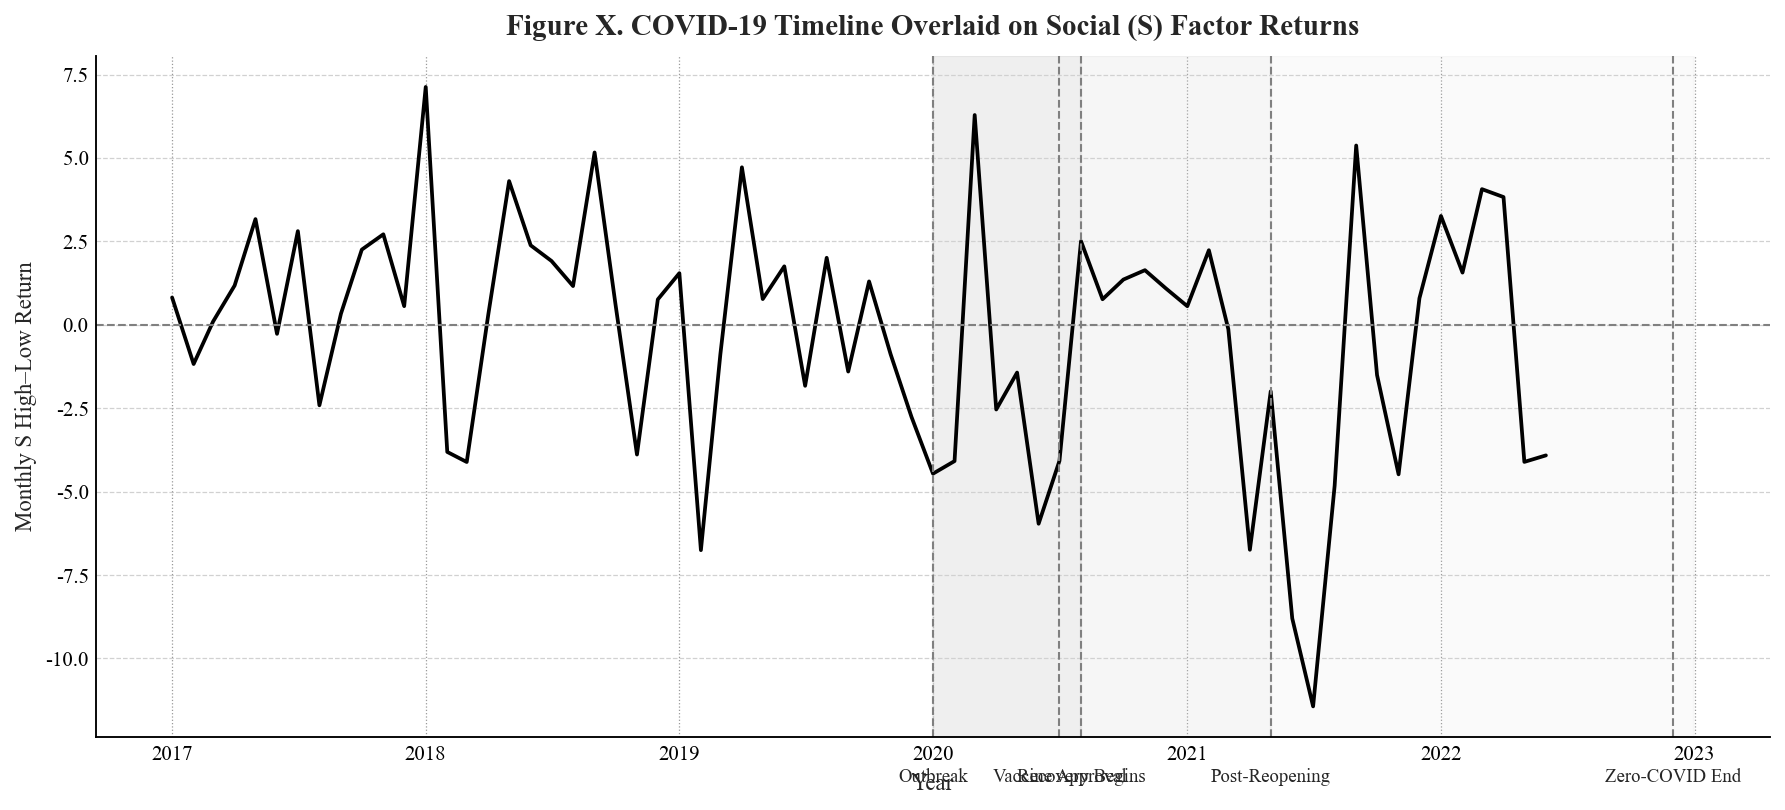

In [350]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# --- 学术风设置 ---
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# 1. 读取 Social 因子月度序列
s_panel = prep_month_panel(s_hl_vw, ff5_df, factor_col="S_factor_VW")

# 转为时间序列
ts = s_panel[["Date", "S_factor_VW"]].set_index("Date")["S_factor_VW"]
ts = ts["2017-01-01":"2022-12-31"]

# 拉宽 y 轴范围，让线条更平缓
ymin, ymax = ts.min(), ts.max()
yrange = ymax - ymin

fig, ax = plt.subplots(figsize=(12, 5.5))

# ---- 区间 Shading（最清晰）----
ax.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-08-01"),
           color="lightgray", alpha=0.35, label="Outbreak")

ax.axvspan(pd.to_datetime("2020-08-01"), pd.to_datetime("2021-05-01"),
           color="lightgray", alpha=0.20, label="Recovery")

ax.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2022-12-31"),
           color="lightgray", alpha=0.10, label="Post-Reopening")

# ---- S 因子收益线 ----
ax.plot(ts.index, ts.values, color="black", linewidth=1.8)

# 0 轴
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# ---- 关键 COVID 时间点（优化文字位置）----
covid_events = {
    "2020-01-01": "Outbreak",
    "2020-07-01": "Vaccine Approval",
    "2020-08-01": "Recovery Begins",
    "2021-05-01": "Post-Reopening",
    "2022-12-01": "Zero-COVID End",
}

for date, label in covid_events.items():
    d = pd.to_datetime(date)
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)
    ax.text(d, ymin - 0.10 * yrange, label, fontsize=9,
            ha="center", va="top", rotation=0)

# ---- 标题 & 标签 ----
ax.set_title("Figure X. COVID-19 Timeline Overlaid on Social (S) Factor Returns",
             fontsize=14, fontweight="bold", pad=10)
ax.set_ylabel("Monthly S High–Low Return", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

# 优化网格
ax.grid(axis="y", linestyle="--", alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


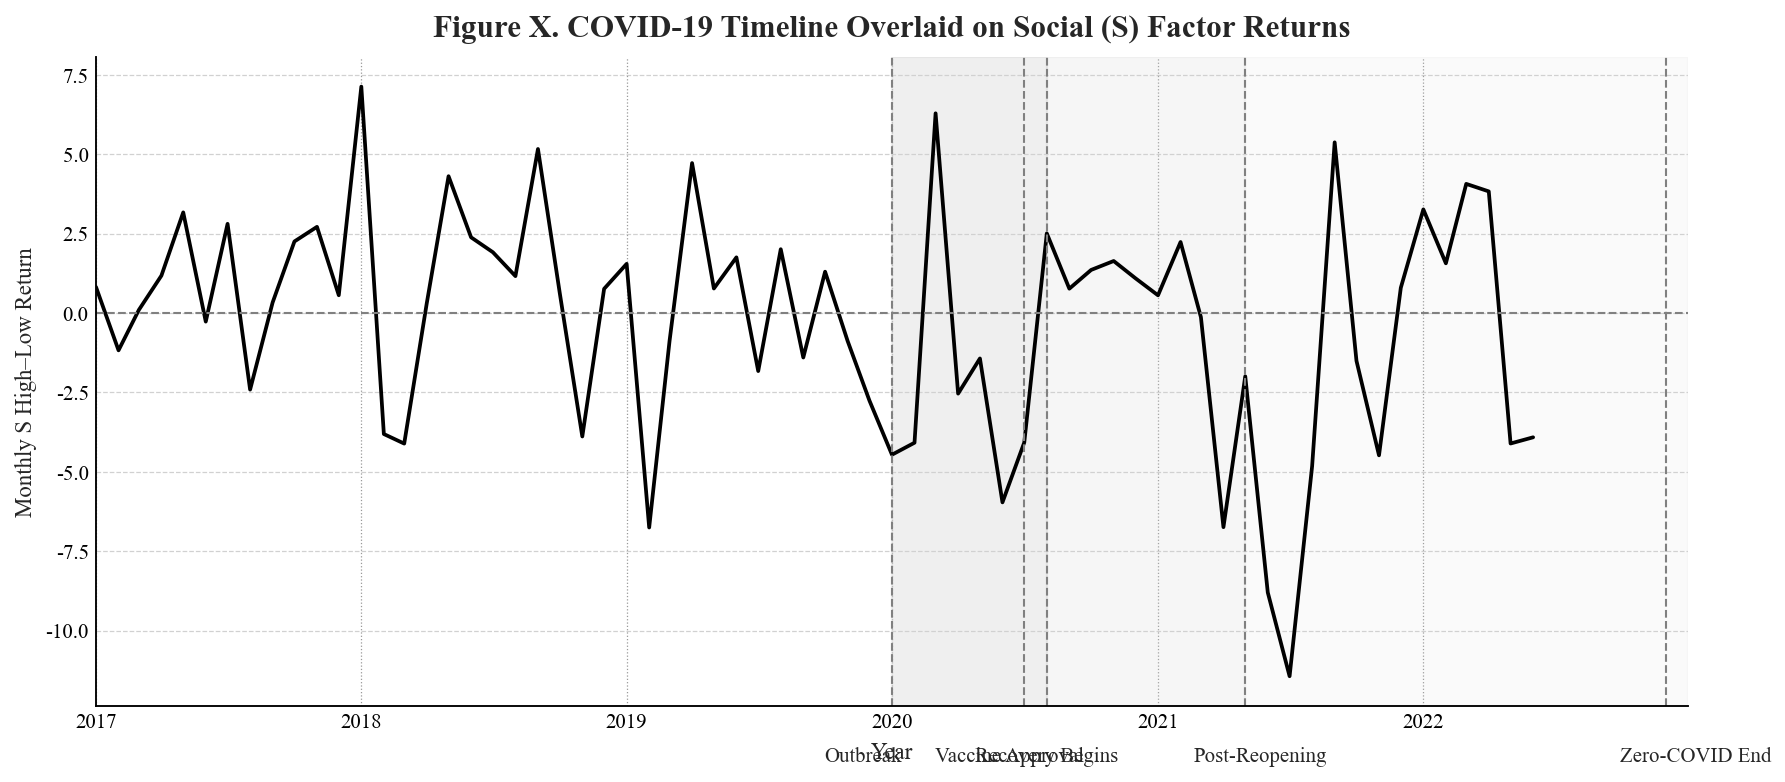

In [356]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# --- 学术风设置 ---
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# 1. Social 因子月度序列
s_panel = prep_month_panel(s_hl_vw, ff5_df, factor_col="S_factor_VW")

# 转为时间序列
ts = s_panel[["Date", "S_factor_VW"]].set_index("Date")["S_factor_VW"]
ts = ts["2017-01-01":"2022-12-31"]

# 拉开 y 轴范围
ymin, ymax = ts.min(), ts.max()
yr = ymax - ymin

fig, ax = plt.subplots(figsize=(12, 5.3))

# --- 阶段 shading ---
ax.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-08-01"),
           color="lightgray", alpha=0.35)
ax.axvspan(pd.to_datetime("2020-08-01"), pd.to_datetime("2021-05-01"),
           color="lightgray", alpha=0.20)
ax.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2022-12-31"),
           color="lightgray", alpha=0.10)

# --- S 因子线 ---
ax.plot(ts.index, ts.values, color="black", linewidth=1.8)

# 0 轴
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- 关键 COVID 时间事件 ---
events = {
    "2020-01-01": "Outbreak",
    "2020-07-01": "Vaccine Approval",
    "2020-08-01": "Recovery Begins",
    "2021-05-01": "Post-Reopening",
    "2022-12-01": "Zero-COVID End",
}

# 底部文本高度
text_y = ymin - 0.12 * yr

# 左右错位像素（避免重叠）
shift = [-40, -20, 0, 20, 40]

for (date, label), s in zip(events.items(), shift):
    d = pd.to_datetime(date)
    
    # 垂直线
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)
    
    # 文本（通过 + Timedelta 实现左右平移）
    ax.text(
        d + pd.Timedelta(days=s),   # 这里修复 x 的平移
        text_y,
        label,
        fontsize=10,
        ha="center",
        va="top",
        rotation=0
    )

# --- 标题 ---
ax.set_title(
    "Figure X. COVID-19 Timeline Overlaid on Social (S) Factor Returns",
    fontsize=15, fontweight="bold", pad=10
)

ax.set_ylabel("Monthly S High–Low Return", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

# 美化坐标轴
ax.set_xlim(pd.to_datetime("2017-01-01"), pd.to_datetime("2022-12-31"))
ax.grid(axis="y", linestyle="--", alpha=0.45)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


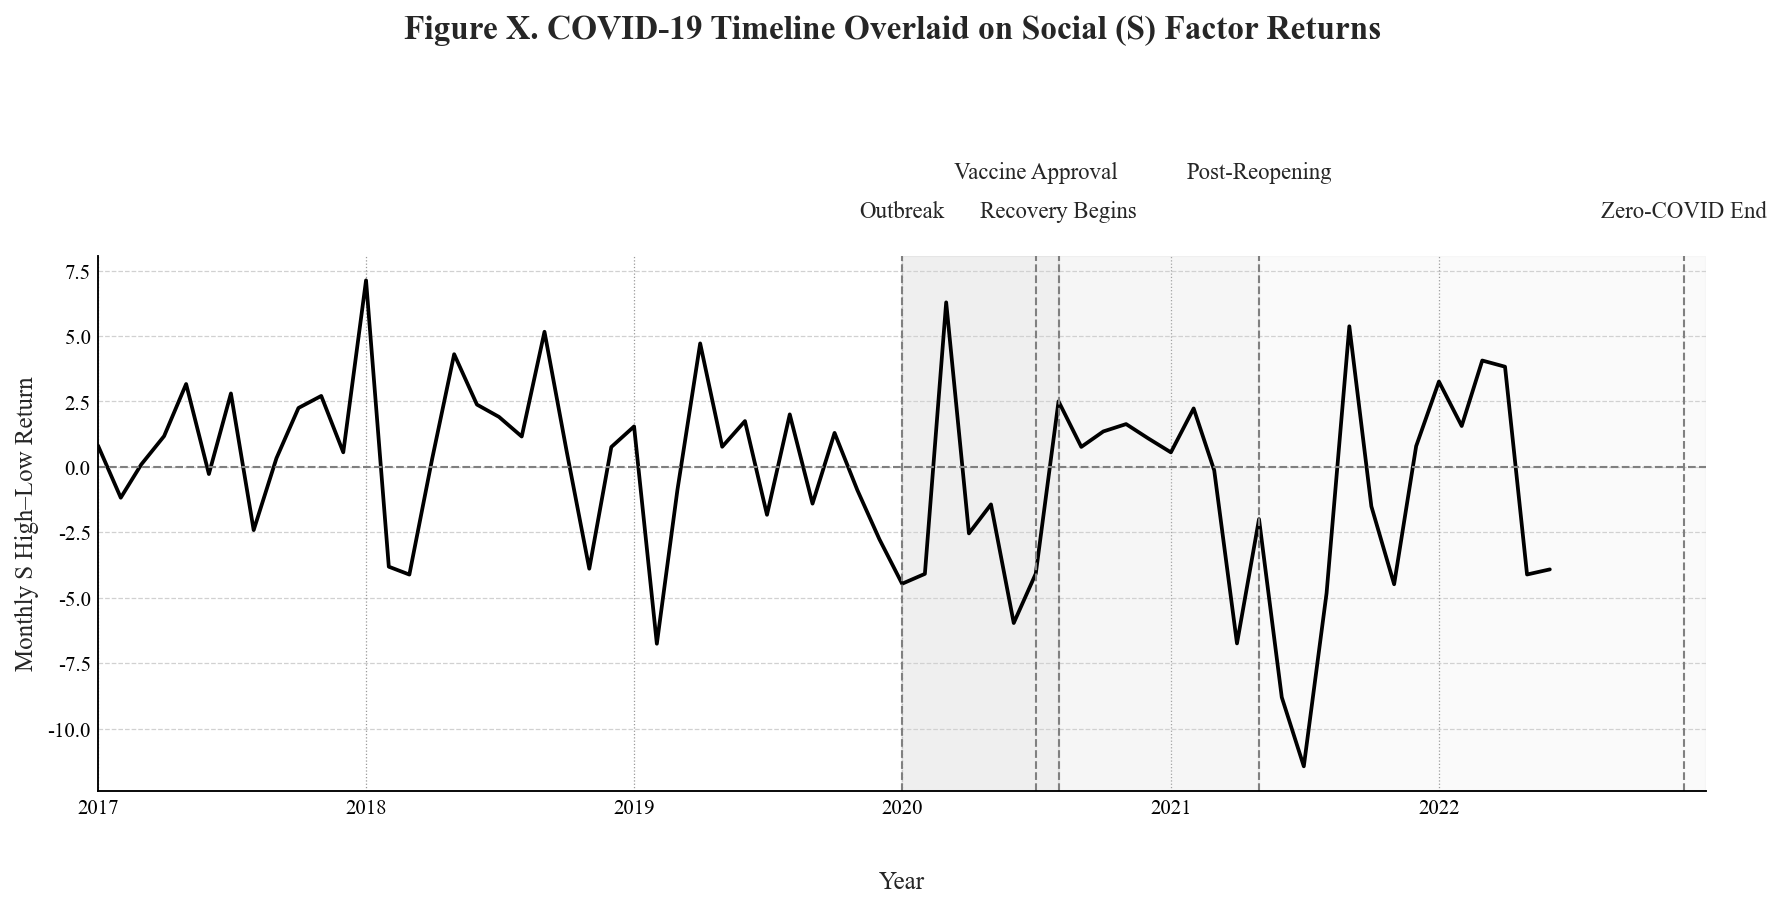

In [362]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# --- 学术风设置 ---
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# 1. Social 因子月度序列
s_panel = prep_month_panel(s_hl_vw, ff5_df, factor_col="S_factor_VW")
ts = s_panel[["Date", "S_factor_VW"]].set_index("Date")["S_factor_VW"]
ts = ts["2017-01-01":"2022-12-31"]

# Y 轴范围
ymin, ymax = ts.min(), ts.max()
yr = ymax - ymin

fig, ax = plt.subplots(figsize=(12, 6.2))

# ---- 顶部 Figure title ----
plt.suptitle(
    "Figure X. COVID-19 Timeline Overlaid on Social (S) Factor Returns",
    fontsize=16, fontweight="bold", y=0.97
)

# ---- 阶段 shading ----
ax.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-08-01"),
           color="lightgray", alpha=0.35)
ax.axvspan(pd.to_datetime("2020-08-01"), pd.to_datetime("2021-05-01"),
           color="lightgray", alpha=0.20)
ax.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2022-12-31"),
           color="lightgray", alpha=0.10)

# ---- S 因子曲线 ----
ax.plot(ts.index, ts.values, color="black", linewidth=1.8)

# 0 轴虚线
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# ---- COVID period 标签：放在图最顶部 + 上下交错 ----
events = [
    ("2020-01-01", "Outbreak"),
    ("2020-07-01", "Vaccine Approval"),
    ("2020-08-01", "Recovery Begins"),
    ("2021-05-01", "Post-Reopening"),
    ("2022-12-01", "Zero-COVID End"),
]

# 上下交错（正数靠上、负数靠下一点）
offsets = [0.12, 0.20, 0.12, 0.20, 0.12]   # 顶部空间比例

for (date, label), pos in zip(events, offsets):
    d = pd.to_datetime(date)

    # 事件竖线
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)

    # 顶部标注位置
    ax.text(
        d,
        ymax + pos * yr,    # Y 值放得很高
        label,
        fontsize=11,
        ha="center",
        va="bottom",
    )

# ---- 坐标与标签 ----
ax.set_xlim(pd.to_datetime("2017-01-01"), pd.to_datetime("2022-12-31"))

ax.set_xlabel("Year", fontsize=12, labelpad=25)
ax.set_ylabel("Monthly S High–Low Return", fontsize=12)

# 美化
ax.grid(axis="y", linestyle="--", alpha=0.45)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # 给顶部标题留空间
plt.show()


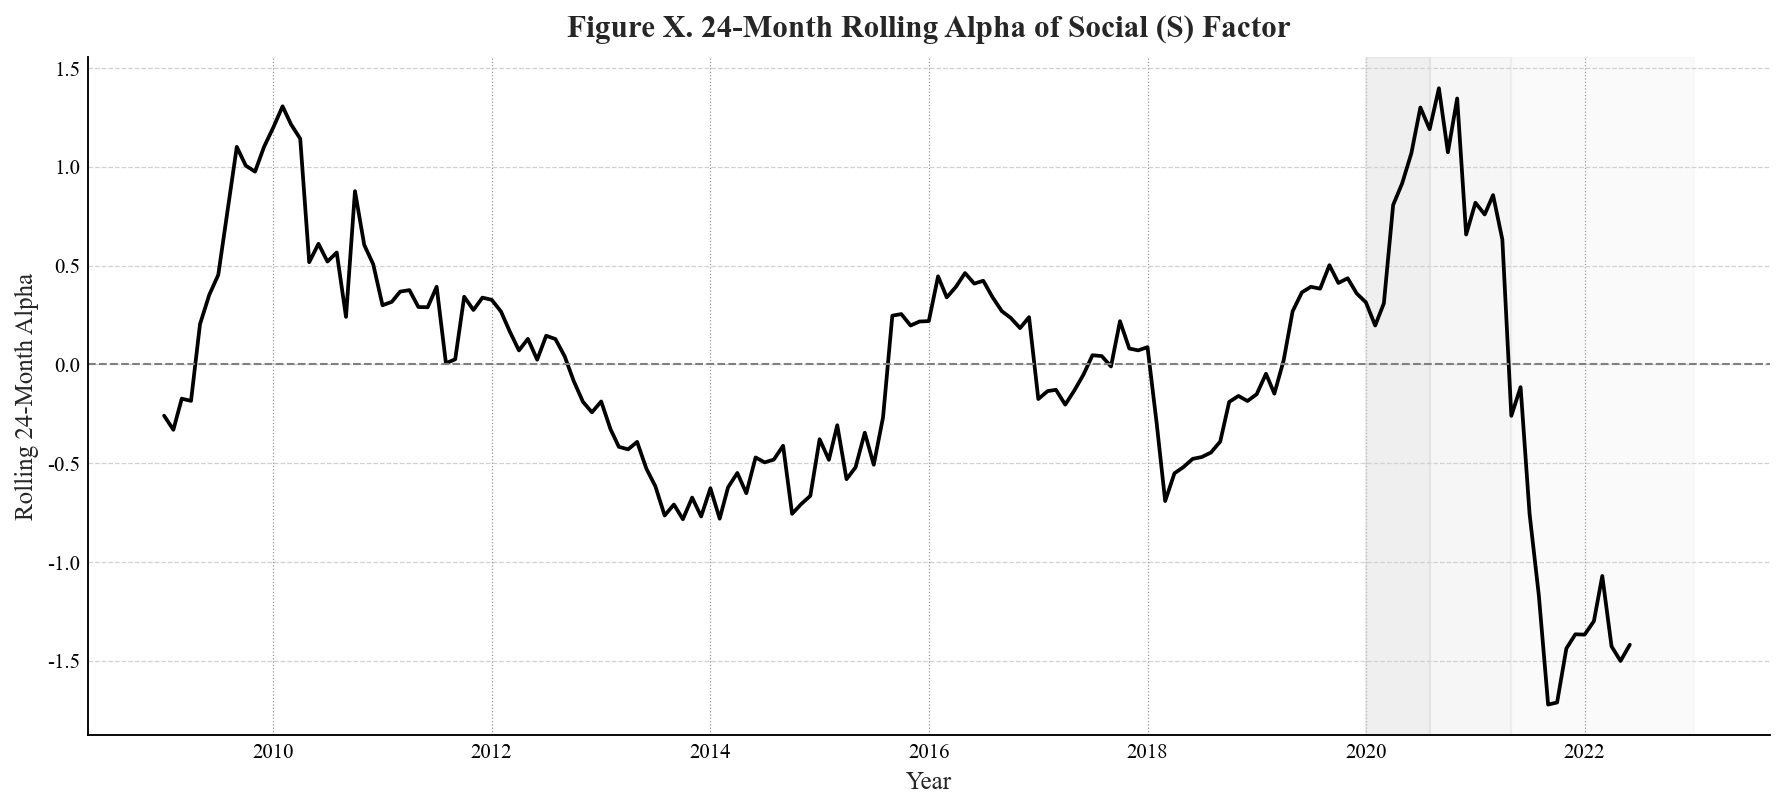

In [364]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 学术风设置 ---
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# -------------------------------------------
# 1. 准备面板数据（和你之前 run_all_windows 用的是同一个逻辑）
# -------------------------------------------
panel = prep_month_panel(s_hl_vw, ff5_df, factor_col="S_factor_VW")
panel = panel.sort_values("Date").reset_index(drop=True)

# Y：S 因子 VW 高低收益（月度）
Y = panel["S_factor_VW"].astype(float).values

# X：FF5 因子（MKT, SMB, HML, RMW, CMA）
X = panel[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]].astype(float)
X = sm.add_constant(X)

dates = panel["Date"].values

# -------------------------------------------
# 2. Rolling 24-month FF5 回归并提取 alpha
# -------------------------------------------
window = 24
rolling_alpha = []
rolling_dates = []

for i in range(window, len(panel)):
    subY = Y[i-window:i]
    subX = X.iloc[i-window:i]

    model = sm.OLS(subY, subX).fit(cov_type="HAC", cov_kwds={"maxlags":12})
    rolling_alpha.append(model.params["const"])
    rolling_dates.append(dates[i])

rolling_alpha = pd.Series(rolling_alpha, index=pd.to_datetime(rolling_dates))

# -------------------------------------------
# 3. 绘图（黑白顶刊风）
# -------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5.5))

ax.plot(rolling_alpha.index, rolling_alpha.values,
        color="black", linewidth=1.8)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# COVID 阶段 shading（根据你论文的分段）
ax.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-08-01"),
           color="lightgray", alpha=0.35, label="Outbreak")

ax.axvspan(pd.to_datetime("2020-08-01"), pd.to_datetime("2021-05-01"),
           color="lightgray", alpha=0.20, label="Recovery")

ax.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2022-12-31"),
           color="lightgray", alpha=0.10, label="Post-Reopening")

# 图标题
ax.set_title("Figure X. 24-Month Rolling Alpha of Social (S) Factor",
             fontsize=15, fontweight="bold", pad=10)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Rolling 24-Month Alpha", fontsize=12)

ax.grid(axis="y", linestyle="--", alpha=0.45)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


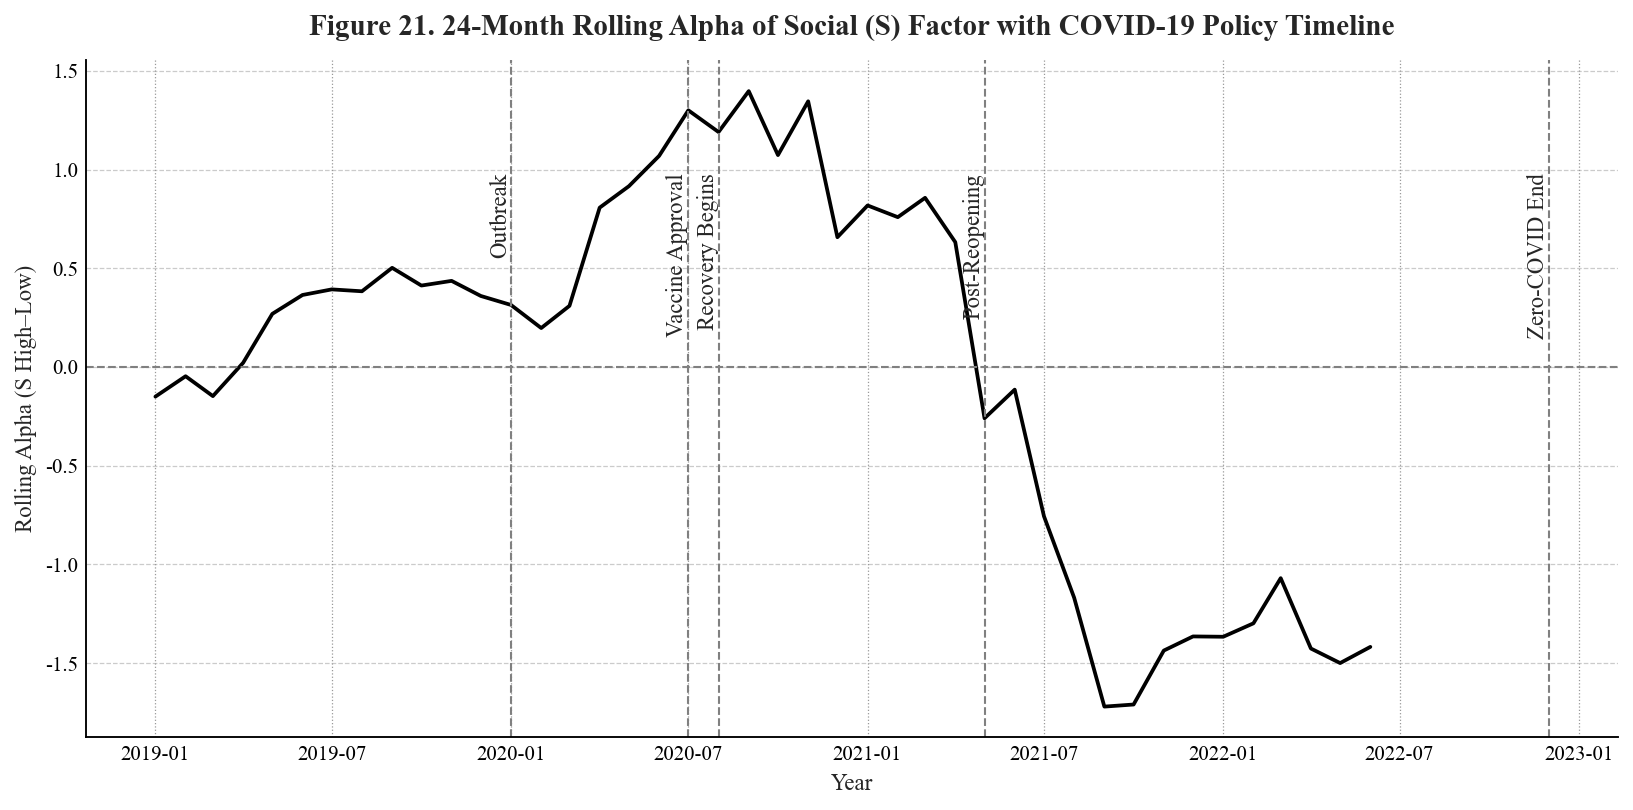

In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

# ========= 学术风设置 =========
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# ========= 1. 准备 S 因子月度 panel（你已经有这个函数） =========
s_panel = prep_month_panel(s_hl_vw, ff5_df, factor_col="S_factor_VW")
ts = s_panel[["Date", "S_factor_VW"]].set_index("Date")["S_factor_VW"]
ts = ts["2017-01-01":"2022-12-31"]   # 限定论文范围

# ========= 2. Rolling 24-month alpha（学术标准做法） =========
def rolling_alpha(series, ff_df, window=24):
    """Return rolling alpha (FF5-adjusted) with Newey-West."""
    out = []
    dates = []

    ff_df = ff_df.copy()
    ff_df["Date"] = pd.to_datetime(ff_df["TradingMonth"] + "-01")

    for i in range(window, len(series)):
        sub_y = series.iloc[i-window:i]

        start = sub_y.index[0]
        end   = sub_y.index[-1]

        sub_ff = ff_df[(ff_df["Date"] >= start) & (ff_df["Date"] <= end)]
        if len(sub_ff) < window * 0.8:
            out.append(np.nan)
            dates.append(series.index[i])
            continue

        Y = sub_y.values
        X = sub_ff[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]].values
        X = sm.add_constant(X)

        model = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
        out.append(model.params[0])
        dates.append(series.index[i])

    return pd.Series(out, index=dates)

roll_alpha = rolling_alpha(ts, ff5_df, window=24)

# ========= 3. COVID 时间线 =========
covid_events = [
    ("2020-01-01", "Outbreak"),
    ("2020-07-01", "Vaccine Approval"),
    ("2020-08-01", "Recovery Begins"),
    ("2021-05-01", "Post-Reopening"),
    ("2022-12-01", "Zero-COVID End"),
]

# ========= 4. 绘图 =========
fig, ax = plt.subplots(figsize=(11, 5.5))

ax.plot(roll_alpha.index, roll_alpha.values, color="black", linewidth=1.8)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)


y_text_pos = roll.max() * 0.95

for date, label in covid_events:
    d = pd.to_datetime(date)
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)
    ax.text(d, y_text_pos, label, rotation=90,
            fontsize=11, ha="right", va="top")


# ========= 5. 标题/轴/样式 =========

ax.set_title("Figure 21. 24-Month Rolling Alpha of Social (S) Factor with COVID-19 Policy Timeline",
             fontsize=14, fontweight="bold", pad=12)

ax.set_ylabel("Rolling Alpha (S High–Low)", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


#### 政策收紧时期 （Policy Crackdown）
----
**预计一：2020年至今的“严监管”浪潮**  
由于高G的组合主要由房地产和金融产业的股票组成，因此G H-L的组合一定程度上反应了房地产和金融市场的变化。这里旨在研究房地产和金融相关政策的变化，是否会给G H-L组合的alpha带来显著变化。

**相关政策变化**  
<u> 房地产 </u>  
自1998 年住房商品化以来，房地产逐渐成为中国经济支柱产业。并且房价长期只涨不跌，形成“房价信仰”。2016-2019年，多地“限购、限贷、限售”，但整体房价仍高位运行。直到以下相关变化出台：
* **2020 年 8 月**：2020年8月由中国人民银行、住房和城乡建设部制定"三道红线"的房地产企业融资监管指标体系，旨在控制房企杠杆率，防范金融风险。政策于2021年1月起全面施行，要求试点房企在2023年6月底前达标，所有房企在2023年底前达标，实施后TOP50房企中绿档企业占比从13%提升至35%，行业总有息负债增速下降显著。房地产行业面对融资困难，并导致房价逐步下跌。
* **2021 年 9 月**：多家信用评级将恒大房地产的信用评级下调，并未如约支付美元债券 8350 万美元利息。该事件不单标志着恒大债务危机的公开爆发，也成为中国房地产行业系统性风险的集中体现，随后触发了股债市场的恐慌、供应商维权潮，以及政府对房地产行业更为严格的监管与风险处置措施。
* **2022 年 5 月**：从央行、银保监会于 5 月 15 日发布通知起，全国首套住房商业性个人住房贷款利率下限调整为 不低于相应期限 LPR 减 20 个基点。也就是说首套利率可以低于原先的下限。房地产调控基调出现边际放松，在坚持“房住不炒”的总原则下，政策目标从“去杠杆、防风险”逐渐向“稳市场、稳信心”转变。而后2022 年 7 月的“保交楼” 和 11 月的“三支箭” 政策逐渐令房地产市场维稳与恢复。

**假设**：随着国家政策的变化，G H-L的alpha应该随着监管的紧缩导致的资产下降而下降；并随着监管的支持而上升。因此在三道红线期间，alpha应显著为负。在2021年9月之后，随着恒大危机的爆发应该继续显著为负数，直到国家放宽相关政策。

**结论**：  
G 因子分阶段回归结果
| Window                  | n_months |  Alpha  | p_alpha |   t_alpha   |   R²   | Ann. Ret | Ann. Vol | Sharpe  | Avg. Turnover |
|-------------------------|---------:|--------:|--------:|------------:|-------:|---------:|---------:|--------:|--------------:|
| 2018-08-01 ~ 2020-08-01 基准期 |       25 |  1.0362 | 0.0000  |   7.2727    | 0.7680 |  -9.9999 |  11.3710 | -0.8794 |        0.9142 |
| 2020-08-01 ~ 2021-09-01 三道红线期|       14 | -2.4785 | 0.0003  |  -3.6567    | 0.7784 | -20.1207 |  14.9247 | -1.3481 |        0.8785 |
| 2021-09-01 ~ 2022-05-01 恒大金融暴雷|        9 |  1.7075 | 0.0000  |   9.9655    | 0.9462 |   9.9991 |  13.1004 |  0.7633 |        0.9314 |
| 2022-05-01 ~ 2022-12-01 国家放宽房地产相关政策|        2 | -4.9373 | 0.0000  | -3.1346e+15 | 1.0000 | -57.6141 |   1.3493 | -42.6985|        0.8872 |

结果显示，在各个阶段中 Alpha 值均显著偏离 0，说明模型能够识别出治理因子（G）的额外回报效应。然而，Alpha 的方向并未与政策收紧或放松的周期呈现出一致的变化趋势。这意味着，<u>单纯依赖政策松紧来解释 G 因子 H–L 组合的超额收益是不充分的</u>。换言之，G 因子的表现不仅受到宏观政策环境的影响，还可能与其他多重因素交互作用。

**Reference**：
https://tech.sina.cn/2020-08-23/detail-iivhuipp0197547.d.html?utml
https://www.reuters.com/business/china-evergrandes-snowballing-debt-crisis-2021-09-14/?utml
https://www.icbc.com.cn/page/721852750723055635.html?utml
----- 
**预计二：房地产价格相关变化**  
由于上一段阶段划分的局限性，这段阶段花费会引入房地产价格相关变化 来划分阶段，即以二手房成交价格的波动为基准，以期探究 G 因子 H–L 组合的超额收益与政策和房价走势之间的相关性，从而更好地理解G H-L的场定价逻辑。

* 2018-08 ~ 2020-08（基准期）：情前相对稳定阶段，房地产与金融市场运行常态化，政策基调是“房住不炒”。
* 2020-08 ~ 2020-11（三道红线）：房企融资新规出台，标志调控全面收紧，企业高杠杆模式受到遏制。
* 2020-11 ~ 2021-06（蚂蚁金融事件期）：蚂蚁集团 IPO 被叫停，金融强监管升级，罚金总计71.23亿元，市场偏好下降。
* 2021-06 ~ 2021-12（房价下行期）：二手房价开始普遍下跌，恒大债务危机爆发，行业信心受挫。
* 2021-12 ~ 2022-03（房价短暂企稳）：部分政策边际放松，市场出现阶段性修复，但整体复苏有限。
* 2022-03 ~ 2023-03（房价再度下行）：需求不足、经济承压，二手房价持续下滑，去杠杆压力延续。

**假设**：随着国家政策以及房地产价格的变化，G H-L的alpha应该随着房价的上升而上升，随着房价的下降而下降。

**结论**：  
G 因子分阶段回归结果

| Window               | n_months | Alpha   | p_alpha | t_alpha   | R²     | Ann. Ret | Ann. Vol | Sharpe | Avg. Turnover |
|-------------------------------|----------|---------|---------|-----------|--------|----------|----------|--------|----------------|
| 2018-08-01 ~ 2020-08-01 基准期                     | 25       | 1.0362  | 0.0000  | 7.2727    | 0.7680 | -9.9999  | 11.3710  | -0.8794 | 0.9142         |
| 2020-08-01 ~ 2020-11-01 三道红线开始               | 4        | 1.3007  | 0.0000  | 6.9142e+15| 1.0000 | 14.4751  |  2.7784  |  5.2099 | 0.7814         |
| 2020-11-01 ~ 2021-06-01 蚂蚁金融暴雷               | 8        | -3.2020 | 0.0000  | -1.5753e+01| 0.8461 | -25.4499 | 11.8947  | -2.1395 | 0.8785         |
| 2021-06-01 ~ 2021-12-01 房价下行期   | 7        | -1.3681 | 0.0000  | -4.8518e+00| 0.8559 | -41.6359 | 18.6338  | -2.2344 | 0.9755         |
| 2021-12-01 ~ 2022-03-01  房价短暂企稳   | 4        | 2.4435  | 0.0000  | 1.9637e+15| 1.0000 | 27.8028  |  5.1470  |  5.4017 | 0.9314         |
| 2022-03-01 ~ 2023-03-01  房价再度下行| 4       | -0.4711 | 0.0000  | -3.0415e+14| 1.0000 | -3.1167  | 18.2989  | -0.1703 | 0.8872         |


所有阶段的 p_alpha 均小于 0.05，说明各时期的 Alpha 值在统计意义上显著，模型能够稳定识别出治理因子（G）的超额回报效应。基准期（2018-08 ~ 2020-08）Alpha 为正（1.0362），市场相对稳定。三道红线出台（2020-08 ~ 2020-11）：Alpha 依旧为正（1.3007），房市尚未受到全面冲击。蚂蚁事件后（2020-11 ~ 2021-06）：Alpha 转为显著负值（-3.2020），对应金融环境的快速收紧。房价下行期（2021-06 ~ 2021-12）：Alpha 继续为负（-1.3681），房地产行业风险集中释放。房价阶段性企稳（2021-12 ~ 2022-03）：Alpha 回升为正（2.4435），与房市小幅反弹相符。房价再度下行（2022-03 ~ 2023-03）：Alpha 再次转负（-0.4711），与房价继续下跌保持一致。
整体结论：Alpha 的显著性 证明S H-L在中国市场的特定时期确实存在可观测的超额收益效应。Alpha 的方向 与 房地产价格和金融行业的周期波动高度相关。相关期间alpha的变化说明 G 因子受宏观政策影响有限，而与房地产与金融市场景气度存在紧密联系。

**Reference**：
https://finance.sina.cn/hkstock/ggyw/2023-01-01/detail-imxyrtrp2448127.d.html?utml


In [164]:
periods = [
    ("2018-08-01", "2020-08-01"),  # 基准期
    ("2020-08-01", "2021-09-01"),  # 三道红线期
    ("2021-09-01", "2022-05-01"),  # 恒大金融暴雷
    ("2022-05-01", "2022-12-01"),  # 国家放宽房地产相关政策
]

g_pc_result_df = run_all_windows(g_hl_vw, ff5_df, periods, turnover_df=g_turnover_ls_df, factor_col="G_factor_VW")
print("=========================G 结果==========================")
print(g_pc_result_df)

=========================G 结果==========================
                    window  n_months   alpha  p_alpha       t_alpha      R2  \
0  2018-08-01 ~ 2020-08-01        25  1.0362   0.0000  7.272700e+00  0.7680   
1  2020-08-01 ~ 2021-09-01        14 -2.4785   0.0003 -3.656700e+00  0.7784   
2  2021-09-01 ~ 2022-05-01         9  1.7075   0.0000  9.956500e+00  0.9462   
3  2022-05-01 ~ 2022-12-01         2 -4.9373   0.0000 -3.134562e+15  1.0000   

   ann_ret  ann_vol   sharpe  avg_turnover  
0  -9.9999  11.3710  -0.8794        0.9345  
1 -20.1207  14.9247  -1.3481        0.8991  
2   9.9991  13.1004   0.7633        0.9308  
3 -57.6141   1.3493 -42.6985        0.9114  


In [165]:
periods = [
    ("2018-08-01", "2020-08-01"),  # 基准期
    ("2020-08-01", "2020-11-01"),  # 三道红线开始
    ("2020-11-01", "2021-06-01"),  # 蚂蚁金融暴雷
    ("2021-06-01", "2021-12-01"),  # 百城二手住宅价格环比下降
    ("2021-12-01", "2022-03-01"),  # 百城二手住宅价格环比上升
    ("2022-03-01", "2023-03-01"),  # 百城二手住宅价格环比继续下降
]
g_pc_result_df = run_all_windows(g_hl_vw, ff5_df, periods, turnover_df=g_turnover_ls_df, factor_col="G_factor_VW")
print("=========================G 结果==========================")
print(g_pc_result_df)

=========================G 结果==========================
                    window  n_months   alpha  p_alpha       t_alpha      R2  \
0  2018-08-01 ~ 2020-08-01        25  1.0362      0.0  7.272700e+00  0.7680   
1  2020-08-01 ~ 2020-11-01         4  1.3007      0.0  6.914216e+15  1.0000   
2  2020-11-01 ~ 2021-06-01         8 -3.2020      0.0 -1.575300e+01  0.8461   
3  2021-06-01 ~ 2021-12-01         7 -1.3681      0.0 -4.851800e+00  0.8559   
4  2021-12-01 ~ 2022-03-01         4  2.4435      0.0  1.963723e+15  1.0000   
5  2022-03-01 ~ 2023-03-01         4 -0.4711      0.0 -3.041490e+14  1.0000   

   ann_ret  ann_vol  sharpe  avg_turnover  
0  -9.9999  11.3710 -0.8794        0.9345  
1  14.4751   2.7784  5.2099        0.8481  
2 -25.4490  11.8947 -2.1395        0.8991  
3 -41.6359  18.6338 -2.2344        0.9502  
4  27.8028   5.1470  5.4017        0.9308  
5  -3.1167  18.2989 -0.1703        0.9114  


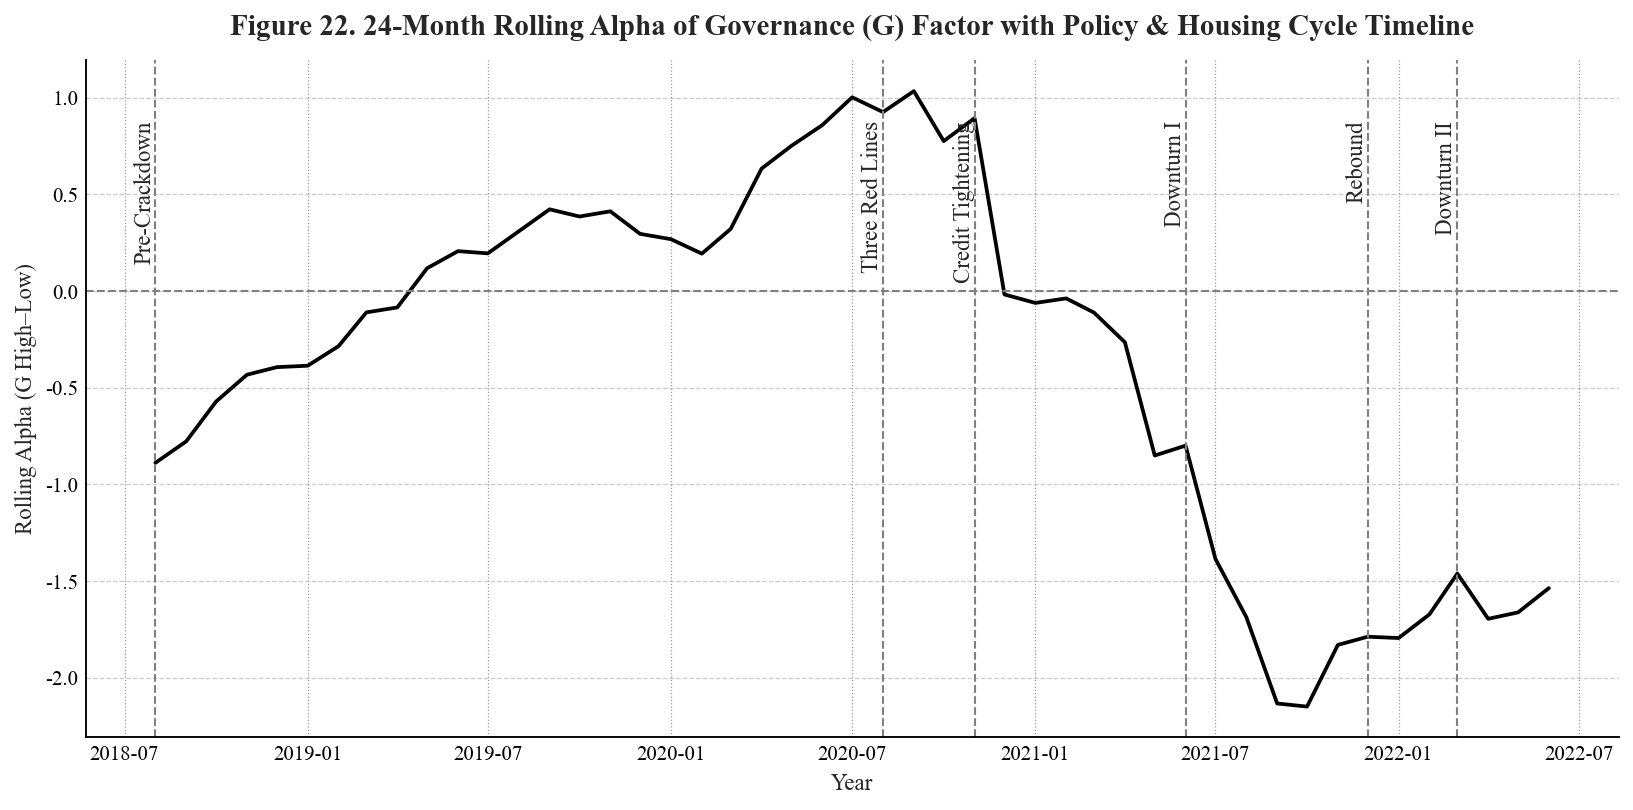

In [412]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl

# -----------------------------
# 学术风设置
# -----------------------------
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False


# -----------------------------
# Step 1. 准备月度面板数据
# -----------------------------
def prep_month_panel(hl_vw, ff5_df, factor_col="G_factor_VW"):
    left = hl_vw[[factor_col]].reset_index().rename(columns={"Year_Month":"TradingMonth"})
    left["TradingMonth"] = left["TradingMonth"].astype(str)

    right = ff5_df[["TradingMonth","RiskPremium1","SMB1","HML1","RMW1","CMA1"]].copy()
    right["TradingMonth"] = right["TradingMonth"].astype(str)

    panel = (left.merge(right, on="TradingMonth", how="inner")
                  .sort_values("TradingMonth")
                  .reset_index(drop=True))

    panel["Date"] = pd.to_datetime(panel["TradingMonth"] + "-01")
    panel["Year"] = panel["Date"].dt.year
    return panel


# -----------------------------
# Step 2. Rolling 24-month alpha function
# -----------------------------
def rolling_alpha(panel, factor_col="G_factor_VW", window=24):
    dates = panel["Date"]
    y = panel[factor_col]
    X = panel[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]]
    X = sm.add_constant(X)

    alphas = []
    alpha_dates = []

    for i in range(window, len(panel)):
        sub_y = y.iloc[i-window:i]
        sub_X = X.iloc[i-window:i]

        ols = sm.OLS(sub_y, sub_X).fit(cov_type="HAC", cov_kwds={"maxlags":12})
        alphas.append(ols.params["const"])
        alpha_dates.append(dates.iloc[i])

    return pd.Series(alphas, index=alpha_dates)


# -----------------------------
# Step 3. 画图（含 Policy Timeline）
# -----------------------------
# 请替换成你自己的数据
panel_g = prep_month_panel(g_hl_vw, ff5_df, factor_col="G_factor_VW")

roll = rolling_alpha(panel_g, factor_col="G_factor_VW", window=24)
roll = roll["2018-08-01":"2023-03-01"]


# --- Figure ---
fig, ax = plt.subplots(figsize=(11, 5.5))
ax.plot(roll.index, roll.values, color="black", linewidth=1.8, label="24M Rolling Alpha (G-factor)")

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# --- Policy Crackdown Events ---
policy_events = [
    ("2018-08-01", "Pre-Crackdown"),
    ("2020-08-01", "Three Red Lines"),
    ("2020-11-01", "Credit Tightening"),
    ("2021-06-01", "Downturn I"),
    ("2021-12-01", "Rebound"),
    ("2022-03-01", "Downturn II"),
]

y_text_pos = roll.max() * 0.85

for date, label in policy_events:
    d = pd.to_datetime(date)
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)
    ax.text(d, y_text_pos, label, rotation=90,
            fontsize=11, ha="right", va="top")


# --- Titles ---
ax.set_title("Figure 22. 24-Month Rolling Alpha of Governance (G) Factor with Policy & Housing Cycle Timeline",
             fontsize=14, fontweight="bold", pad=12)

ax.set_ylabel("Rolling Alpha (G High–Low)", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


#### 绿色发展政策推动的年份（新能源补贴、碳中和目标）
----
**Key Timeline**:   
**2017年10月18日**：绿色发展和生态文明建设 上升为国家层面的基本国策。中国共产党第十九次全国代表大会开幕。在习近平总书记的十九大报告中，首次把 “坚持节约资源和保护环境的基本国策” 强调到新的高度，并明确提出：“加快生态文明体制改革，建设美丽中国。”   
* 后序2017年12月，财政部、工信部、科技部、发改委 联合印发了《关于调整新能源汽车推广应用财政补助政策的通知》，这是一次补贴退坡的调整，强调提高续航门槛，更多地引导行业走向节能减排和技术升级。

**2018年3月11日**：第十三届全国人大一次会议通过《宪法修正案》。明确将“生态文明建设”写入宪法。这是第一次将绿色发展和生态文明的要求提升到 国家根本大法 的高度。  
**2019年9月1日**：2019年6月25日过渡期结束后，新能源汽车补贴全面退坡。在当年第三季度财报中，新能源汽车产销分别完成8.9万辆和8万辆，同比分别下降29.9%和34.2%‌。  
**2020年3月31日**：2020年3月31日，国务院常务会议决定将新能源汽车购置补贴和免购置税政策延长两年。  
**2020年9月22日**：习近平主席在第 75 届联合国大会提出“双碳目标”。同年10 月–12 月，各部委和智库开始进行碳达峰、碳中和路径测算与政策研讨。第二年3月，全国两会《政府工作报告》写入“双碳目标”。  

----

**结论：**

E 因子分阶段回归结果
| Window                   | n_months | Alpha   | p_alpha | t_alpha      | R²     | Ann. Ret | Ann. Vol | Sharpe | Avg. Turnover |
|---------------------------|----------|---------|---------|--------------|--------|----------|----------|--------|---------------|
| 2015-10-01 ~ 2017-10-01 基准期 | 25       | 0.4425  | 0.1617  | 1.3995e+00   | 0.7129 | 0.9201   | 9.2643   | 0.0993 | 1.0573        |
| 2017-10-01 ~ 2018-03-11 十九大后十三届一中全会后 | 6        | 5.9132  | 0.0000  | 5.2535e+12   | 1.0000 | 5.7543   | 11.4344  | 0.5032 | 1.0487        |
| 2018-03-11 ~ 2018-10-01 十三届一中全会后 | 7        | 0.1597  | 0.0000  | 4.7313e+00   | 0.9957 | 19.0399  | 6.8733   | 2.7701 | 1.0120        |
| 2018-10-01 ~ 2019-09-01 政策后期 | 12       | 0.4582  | 0.3804  | 3.7771e+00   | 0.4720 | -4.0496  | 8.3673   | -0.4828| 0.9805        |
| 2019-09-01 ~ 2019-12-01 新能源汽车销量下降 | 4        | -0.5614 | 0.0000  | -4.5798e+15  | 1.0000 | -9.5620  | 3.1652   | -3.0210| 0.9491        |
| 2019-12-01 ~ 2020-09-01 下降后期 | 10       | 0.1790  | 0.2485  | 1.1540e+00   | 0.8514 | -6.3252  | 10.1985  | -0.6202| 0.8653        |
| 2020-09-22 ~ 2021-04-22 双碳目标提出 | 7        | 0.1097  | 0.0000  | 4.4446e+00   | 0.9961 | 21.6705  | 8.4421   | 2.5670 | 0.8785        |
| 2020-04-22 ~ 2022-11-22 后续稳定期  | 26       | 0.1536  | 0.6365  | 4.7260e-01   | 0.3429 | -0.2684  | 8.3793   | -0.0320| 0.8814        |

---

1. **2017-2018年（十九大后、十三届一中全会后）**：Alpha 显著为正，p 值极小，说明环境因子（E 因子）在政策强调绿色发展、环保与治理时产生了超额收益。
2. **2018-2019年**：Alpha 不再显著，甚至在 2019 年新能源补贴退坡后（2019-09 至 2019-12）Alpha 转为负数，且显著下降，表现出政策收紧带来的负面冲击。
3. **2020-2021年（双碳目标提出）**：Alpha 再次显著为正，并伴随高 Sharpe，说明绿色政策导向重新强化了市场对 ESG 的定价。
4. **2022年后**：Alpha 不再显著，说明随着市场逐步消化政策冲击，E 因子的超额收益趋于弱化。

E 因子的超额收益与政策导向密切相关。在政策强化阶段（十九大、双碳目标提出）Alpha 显著为正；而在政策收紧或补贴退坡时期（2019）则转为负值。这表明 E 的市场定价并非内生稳定，而是与宏观政策周期高度耦合。


https://m.bjnews.com.cn/detail/158700541615336.html?utml 


In [420]:
periods = [
    ("2015-10-01", "2017-10-01"),  # 基准期
    ("2017-10-01", "2018-03-11"),  # 十九大后
    ("2018-03-11", "2018-10-01"),  # 十三届一中全会后
    ("2018-10-01", "2019-09-01"),  # 政策后期
    ("2019-09-01", "2019-12-01"),  # 新能源汽车销量下降
    ("2019-12-01", "2020-09-01"),  # 下降后期
    ("2020-09-22", "2021-04-22"),  # 双碳目标提出
    ("2021-04-22", "2022-11-22"),  # 后续稳定期 
]

e_pc_result_df = run_all_windows(e_hl_vw, ff5_df, periods, turnover_df=g_turnover_ls_df, factor_col="E_factor_VW")
print("=========================E 结果==========================")
print(e_pc_result_df)

=========================E 结果==========================
                    window  n_months   alpha       t_alpha  p_alpha      R2  \
0  2015-10-01 ~ 2017-10-01        25  0.4425  1.399500e+00   0.1617  0.7129   
1  2017-10-01 ~ 2018-03-11         6  5.9132  5.253571e+12   0.0000  1.0000   
2  2018-03-11 ~ 2018-10-01         7  0.1597  4.731300e+00   0.0000  0.9957   
3  2018-10-01 ~ 2019-09-01        12  0.4582  8.771000e-01   0.3804  0.4720   
4  2019-09-01 ~ 2019-12-01         4 -0.5614 -4.577981e+15   0.0000  1.0000   
5  2019-12-01 ~ 2020-09-01        10  0.1790  1.154000e+00   0.2485  0.8514   
6  2020-09-22 ~ 2021-04-22         7  0.1097  4.444600e+00   0.0000  0.9961   
7  2021-04-22 ~ 2022-11-22        14 -0.4042 -8.993000e-01   0.3685  0.3306   

   ann_ret  ann_vol  sharpe  avg_turnover  
0   0.9201   9.2643  0.0993        1.0455  
1   5.7543  11.4344  0.5032        1.0254  
2  19.0399   6.8733  2.7701        1.0007  
3  -4.0496   8.3873 -0.4828        0.9778  
4  -9.5620  

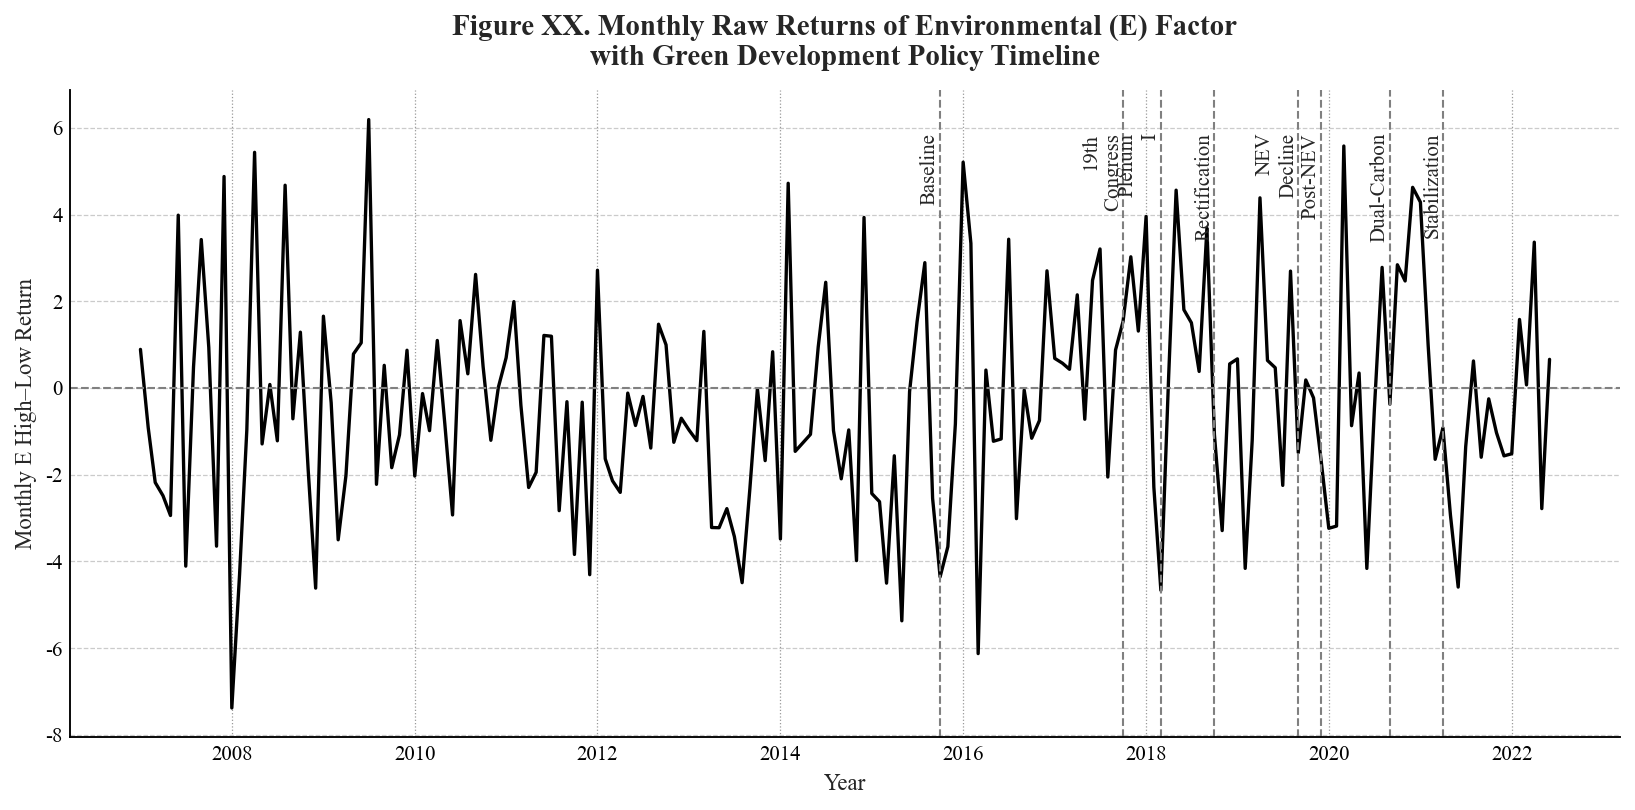

In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

# ========= 学术风设置 =========
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# ========= 1. 准备 E 因子月度面板 =========
e_panel = prep_month_panel(e_hl_vw, ff5_df, factor_col="E_factor_VW")
ts_e_raw = e_panel[["Date","E_factor_VW"]].set_index("Date")["E_factor_VW"]

# 🚨🚨🚨关键一步！强制 index 转为 DatetimeIndex
ts_e_raw.index = pd.to_datetime(ts_e_raw.index)

# 选定整个可用区间（2007–2022）
ts_e_raw = ts_e_raw["2007-01-01":"2022-11-30"]

# ========= 3. 绿色发展时间线 =========
e_policy_events = [
    ("2015-10-01", "Baseline"),
    ("2017-10-01", "19th Congress"),
    ("2018-03-01", "Plenum I"),
    ("2018-10-01", "Rectification"),
    ("2019-09-01", "NEV Decline"),
    ("2019-12-01", "Post-NEV"),
    ("2020-09-01", "Dual-Carbon"),
    ("2021-04-01", "Stabilization")
]

# ========= 4. 绘图 =========
fig, ax = plt.subplots(figsize=(11, 5.5))
ax.plot(ts_e_raw.index, ts_e_raw.values, color="black", linewidth=1.6)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

y_text_pos = ts_e_raw.max() * 0.95

for date, label in e_policy_events:
    d = pd.to_datetime(date)
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)
    ax.text(
        d, y_text_pos, label.replace(" ","\n"),
        rotation=90, fontsize=10,
        ha="right", va="top"
    )

ax.set_title(
    "Figure XX. Monthly Raw Returns of Environmental (E) Factor\nwith Green Development Policy Timeline",
    fontsize=14, fontweight="bold", pad=12
)
ax.set_ylabel("Monthly E High–Low Return", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


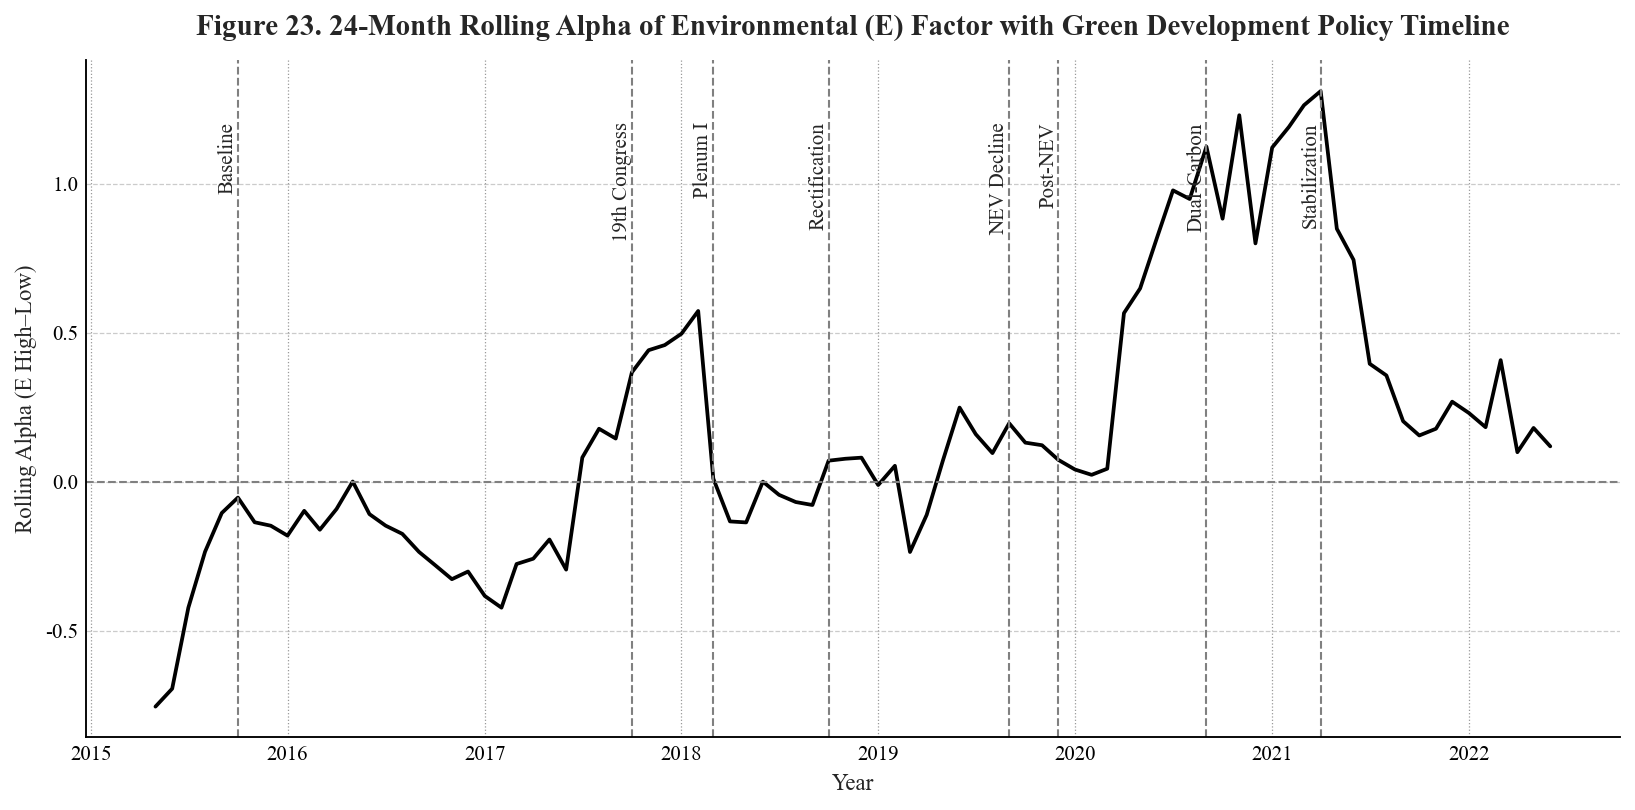

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

# ========= 学术风设置 =========
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False

# ========= 1. 准备 E 因子月度 panel =========
e_panel = prep_month_panel(e_hl_vw, ff5_df, factor_col="E_factor_VW")

# 转成 DatetimeIndex（关键步骤，避免 ConversionError）
e_panel["Date"] = pd.to_datetime(e_panel["Date"])
ts_e = e_panel.set_index("Date")["E_factor_VW"]

# 限定政策范围 2015–2022
ts_e = ts_e["2013-05-01":"2022-11-30"]

# ========= 2. Rolling 24-month alpha =========
def rolling_alpha(series, ff_df, window=24):

    out = []
    dates = []

    ff_df = ff_df.copy()
    ff_df["Date"] = pd.to_datetime(ff_df["TradingMonth"] + "-01")

    for i in range(window, len(series)):
        sub_y = series.iloc[i-window:i]
        start = sub_y.index[0]
        end   = sub_y.index[-1]

        sub_ff = ff_df[(ff_df["Date"] >= start) & (ff_df["Date"] <= end)]

        if len(sub_ff) < window * 0.8:
            out.append(np.nan)
            dates.append(series.index[i])
            continue

        Y = sub_y.values
        X = sub_ff[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]].values
        X = sm.add_constant(X)

        model = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
        out.append(model.params[0])
        dates.append(series.index[i])

    return pd.Series(out, index=dates)

roll_alpha_e = rolling_alpha(ts_e, ff5_df, window=24)


# ========= 3. Green Policy Timeline =========

e_policy_events = [
    ("2015-10-01", "Baseline"),
    ("2017-10-01", "19th Congress"),
    ("2018-03-01", "Plenum I"),
    ("2018-10-01", "Rectification"),
    ("2019-09-01", "NEV Decline"),
    ("2019-12-01", "Post-NEV"),
    ("2020-09-01", "Dual-Carbon"),
    ("2021-04-01", "Stabilization")
]


# ========= 4. 绘图 =========
fig, ax = plt.subplots(figsize=(11, 5.5))

# Rolling alpha 曲线
ax.plot(roll_alpha_e.index, roll_alpha_e.values, color="black", linewidth=1.8)

# 横线
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# 文字位置（靠上）
y_text_pos = roll_alpha_e.max() * 0.92

for date, label in e_policy_events:
    d = pd.to_datetime(date)
    ax.axvline(d, color="gray", linestyle="--", linewidth=1)

    # 强制竖排但不换行
    ax.text(
        d, y_text_pos, label,
        rotation=90, fontsize=10,
        ha="right", va="top"
    )


# ========= 5. 样式 =========

ax.set_title(
    "Figure 23. 24-Month Rolling Alpha of Environmental (E) Factor with Green Development Policy Timeline",
    fontsize=14, fontweight="bold", pad=12
)

ax.set_ylabel("Rolling Alpha (E High–Low)", fontsize=11)
ax.set_xlabel("Year", fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


## Event Studies（事件研究）


Study ESG rating initiations or revisions (upgrades/downgrades) as events and analyze stock return reactions.  
意思：关注 ESG 评级的“事件”。

举例：

一家公司第一次被纳入 ESG 评级体系（Initiation）。

ESG 评级被上调（Upgrade）或下调（Downgrade）。

研究方法：事件研究法（Event Study），分析事件日前后股票的 异常收益（abnormal return），看市场是否对 ESG 信号有反应。

延伸：
Further: if data allows, try to investigate the interaction with Ownership and Governance; examine whether state-owned enterprises vs. private firms show different ESG–return relationships; look at cross-effects: e.g., ESG × analyst coverage, ESG × institutional ownership.

Ownership & Governance：国企 vs 民企，ESG 信号可能有不同解释力。

交互效应：比如 ESG × 分析师覆盖（Analyst Coverage）、ESG × 机构持股（Institutional Ownership），看看这些因素是否会增强或减弱 ESG 的作用。

### Rating Initiations and Rating Revisions
----
**方案**  
Calendar-Time Portfolio Regression（日历时间组合回归）

<u>思路</u>：每月把“当年发生 ESG 事件”的股票放进一个组合（如 Initiation / Upgrade / Downgrade 三个组合），计算该组合当月的（市值加权）收益；对这条月度时间序列做因子回归（FF5/中证500风格因子等），看 alpha 是否显著 ≈ “异常收益”。

<u>为什么适合你</u>
- 不需要准确的公告日，只要知道“哪一年发生了”即可。
- 自然兼容重叠窗口（事件持续影响 6–12 个月）；用 Newey-West 做自相关校正即可。
- 这是资产定价里研究事件的一条标准通路（Jegadeesh-Titman 式做法）。

<u>操作要点</u>
1. 定义事件：
- Initiation：Has_ESG 从 0→1 的年份；
- Revision：ESG_Score / ESG_Rank 较上年变化超过阈值（如分位数 ±20% 或 z-score）。

2. 定义“持有期”：事件发生当年起 K 个月（常用 6 或 12 个月）。
3. 每月形成事件组合的市值加权收益序列。
4. 回归：

$$
R_{i,t} - R_{f,t} = \alpha + \beta^T Factors_t + \varepsilon_t \quad \text{(HAC/Newey-West t)}
$$


5. 读结论：α 是否显著（>0 升级/首次覆盖；<0 降级）。
- 代码轮廓（你已有月度收益/FF5）：
    - 每月打标：过去 K 个月内发生某类事件的股票 → 进当月的组合
    - 计算组合当月 VW 收益 → 生成一条月度序列
    - `statsmodels.OLS(...).fit(cov_type="HAC", cov_kwds={"maxlags":12})` → 取 `alpha, t`

----
**结论**：  
事件发生描述：在过去十五年里，ESG 事件整体呈现 快速扩张 与 偏向正向调整 的趋势。Upgrade 数量最多，显示企业 ESG 表现持续改善；Initiation 随着 ESG 覆盖面的扩大不断增加；Downgrade 相对较少，反映 ESG 评级体系更多起到“激励提升”的作用。
* 市场成熟：Initiation 数量的阶段性增加，反映 ESG 覆盖范围扩大；而 Downgrade 较少，说明评级机构更强调激励而非惩罚。
    * Initiation：在 2010 年、2016 年、2020 年附近出现明显增加。这与中国 ESG 数据逐步覆盖更多上市公司、ESG 信息披露要求加强相一致。
    * Downgrade：约为 Upgrade 的一半。表明 ESG 评级下调相对罕见，市场环境与政策导向整体鼓励企业向更高标准靠拢。
    * Upgrade:占比通常在 60%–70% 之间。说明市场对 ESG 改善的公司覆盖度越来越高，更多企业在 ESG 评级体系中得到了正向反馈。

ESG Initiation 事件带来最强烈的正向市场反应，而 ESG 升级与下调在表现对称、影响有限，甚至都表现为正 alpha。    
在对 ESG 事件的回归分析中，我们发现 Initiation（首次评级覆盖） 对市场反应最为显著。其 α 值为 0.0875，且在统计上显著为正，这表明公司一旦首次被赋予 ESG 评级，市场往往将其解读为一种积极的新信息，从而带来持续数月的超额收益。这说明“被覆盖”本身就具有较强的信息含量，远大于评级后续的小幅调整。  
相比之下，Upgrade（评级上调）与 Downgrade（评级下调） 的 α 值均在 0.007–0.009 左右，幅度明显低于 Initiation，但依旧显著为正。更有意思的是，二者在走势上几乎对称，且都表现为正超额收益。这与传统预期（下调应带来负面反应）不同，可能是因为在年度频率的数据下，市场并不敏感于 ESG 的微调；或者是因为被评级的公司本身就具有一定质量，导致 downgrade 并未带来明显的惩罚效应。  
从月度收益表现来看，Initiation 的波动远高于 Upgrade 与 Downgrade，在某些年份甚至出现超过 100% 的月度收益，显示其市场冲击力极强。但这种极端波动也可能来自个别股票或行业的集中影响，需要通过去极值或稳健性检验进一步确认。而 Upgrade 与 Downgrade 的表现则更加平稳，说明其在投资组合中的边际信息含量较低。  

In [170]:
# Data Preprocessing
# 定义事件：initiation，upgrade，和 downgrade
# 给出 event
esg_df["initiation"] = (esg_df.groupby("stock_code")["Has_ESG"].diff() == 1).astype(int)
threshold_per = 0.3
esg_df["lag_ESG"] = esg_df.groupby("stock_code")["ESG_Score"].shift(1) # 去年 ESG 分数（滞后一期）
esg_df["threshold"] = esg_df["lag_ESG"] * threshold_per # 动态 threshold = 去年 ESG * threshold percentage
esg_df["revision"] = esg_df.groupby("stock_code")["ESG_Score"].diff()
mask_init = (esg_df["initiation"]==1)
esg_df.loc[mask_init, ["upgrade","downgrade"]] = 0
esg_df["upgrade"]   = (esg_df["revision"] > esg_df["threshold"]).astype(int)
esg_df["downgrade"] = (esg_df["revision"] < -esg_df["threshold"]).astype(int)

# 建立副本，避免直接改原始数据
stock_return_copy = stock_return.copy()
stock_return_copy["return"] = stock_return_copy["return"] / 100 # 把 return 转换成小数形式（如果原本是百分比的话）


{'upgrade': 9683, 'downgrade': 3541, 'initiation': 3457}
      upgrade  downgrade  initiation
Year                                
2007        0          0           0
2008      491        158          58
2009      356        194         138
2010      323        422         332
2011      475        255         234
2012      930        130         123
2013      508        188          49
2014      472        242         116
2015      555        219         198
2016      558        204         311
2017      728        209         356
2018      727        239         103
2019      552        289         233
2020      670        175         532
2021     1070        284         436
2022     1268        333         238


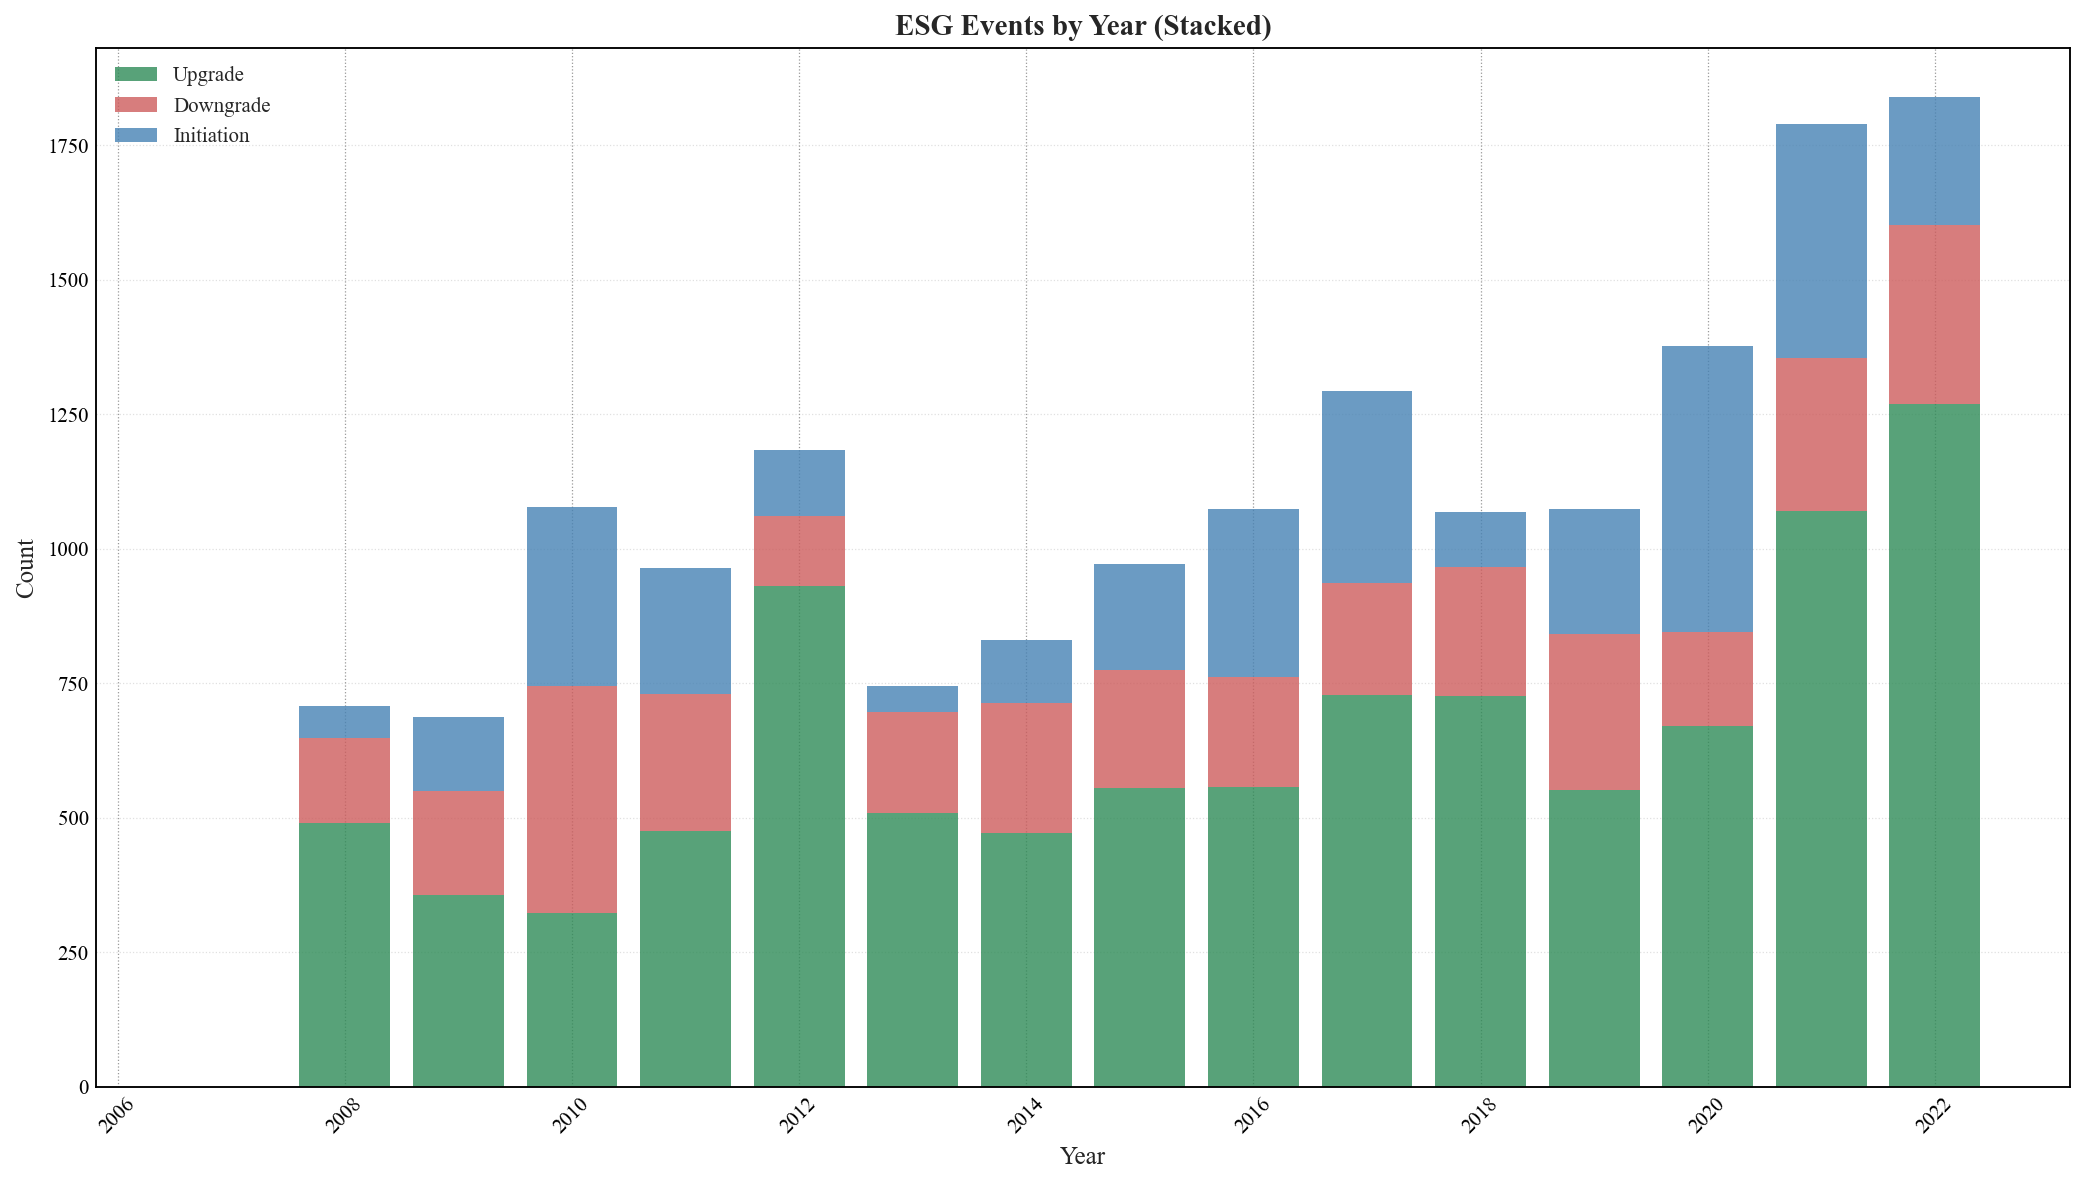

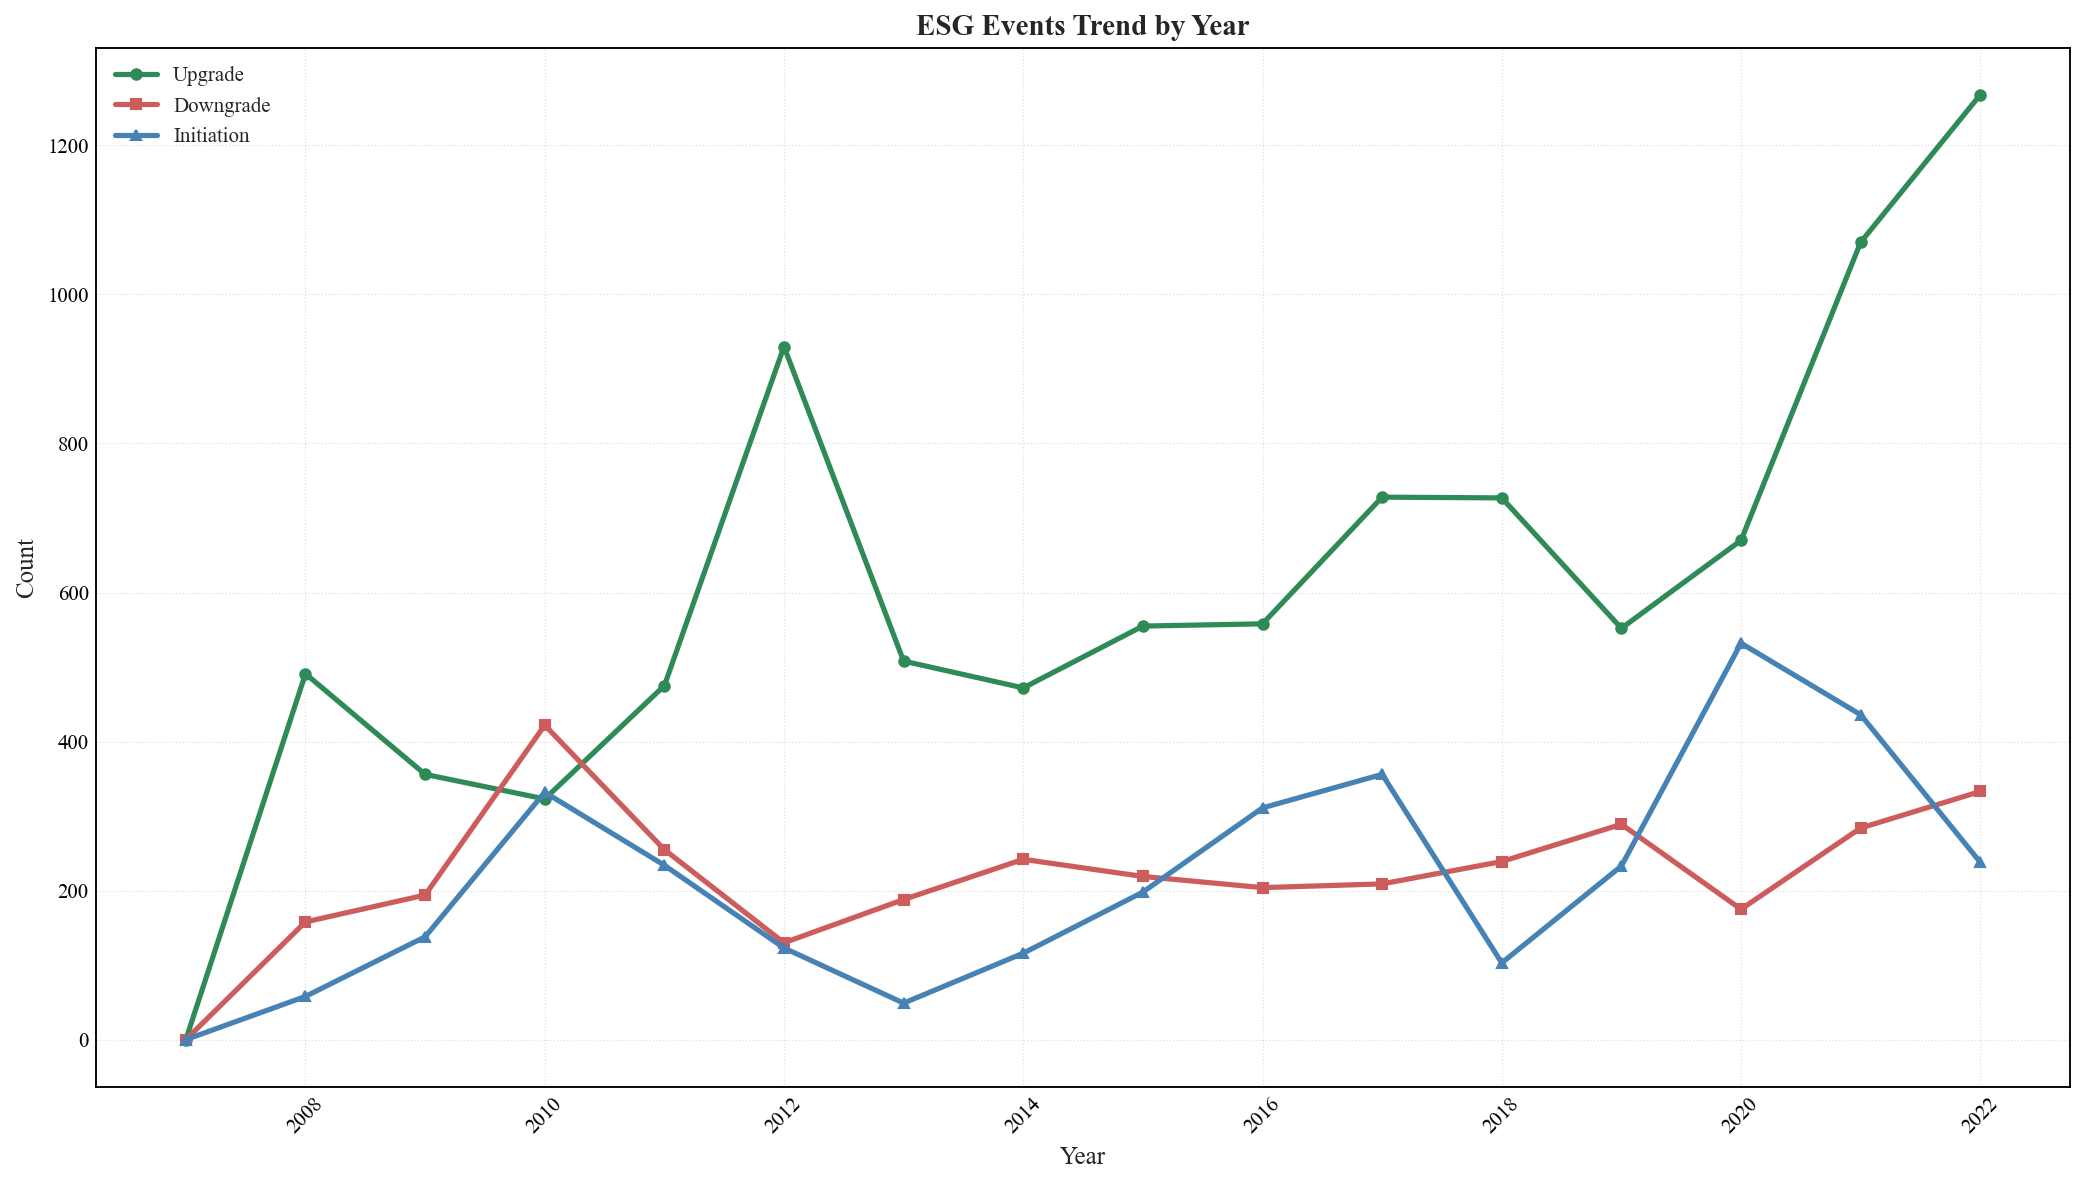

In [171]:
# 重新计算 upgrade / downgrade 的数量
event_counts_ud = {
    "upgrade": esg_df["upgrade"].sum(),
    "downgrade": esg_df["downgrade"].sum(),
    "initiation": esg_df["initiation"].sum()
}

print(event_counts_ud)


# 计算每年的upgrade, downgrade, initiation数量
yearly_counts = esg_df.groupby("Year")[["upgrade", "downgrade", "initiation"]].sum()
print(yearly_counts)


### 堆叠图
# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# 创建图形
plt.figure(figsize=(14, 8))

# 堆叠柱状图
years = yearly_counts.index
upgrade = yearly_counts['upgrade']
downgrade = yearly_counts['downgrade']
initiation = yearly_counts['initiation']

plt.bar(years, upgrade, label='Upgrade', color='#2E8B57', alpha=0.8)
plt.bar(years, downgrade, bottom=upgrade, label='Downgrade', color='#CD5C5C', alpha=0.8)
plt.bar(years, initiation, bottom=upgrade+downgrade, label='Initiation', color='#4682B4', alpha=0.8)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('ESG Events by Year (Stacked)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 折线图
# 折线图 - 看趋势变化
plt.figure(figsize=(14, 8))

plt.plot(years, upgrade, marker='o', linewidth=2.5, label='Upgrade', color='#2E8B57')
plt.plot(years, downgrade, marker='s', linewidth=2.5, label='Downgrade', color='#CD5C5C')
plt.plot(years, initiation, marker='^', linewidth=2.5, label='Initiation', color='#4682B4')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('ESG Events Trend by Year', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [172]:
# 你已有：
# stock_return: columns = ["Date","stock_code","return","Year"]
# esg_df:       columns 包含 ["Year","stock_code","market_cap","initiation","upgrade","downgrade", ...]
# ff5_df:       columns 包含 ["TradingMonth","RiskPremium1","SMB1","HML1","RMW1","CMA1"] (+ 可选 "RF")

# -------- 参数可调 --------
EVENT_START_MONTH = 1    # 事件被认为从该年的几月开始（不知道公告日时用 1=当年1月；也可换成 4/6 做稳健性）
K_HOLD = 12              # 事件组合持有月数（常用 6 或 12）
HAC_LAGS = 12            # Newey-West 滞后
USE_EXCESS = True        # 若 ff5 有 RF，则用超额收益回归

# ===== 1) 日收益 -> 月度收益（用复利） =====
sr = stock_return_copy.copy()
sr["Date"] = pd.to_datetime(sr["Date"])
sr["month"] = sr["Date"].values.astype("datetime64[M]")  # 月初戳
# 若 return 是百分数（例如 1.23 表示 1.23%），可改成：sr["ret_d"] = sr["return"]/100
sr["ret_d"] = sr["return"]

# 按月复利：Π(1+日收益)-1
monthly_ret = (
    sr.assign(r1p = 1 + sr["ret_d"])
      .groupby(["stock_code","month"])["r1p"].prod()
      .sub(1.0)
      .reset_index(name="ret_m")
)

# ===== 2) 年频市值 -> 月频（用于组合权重） =====
# 简单做法：把同一年的 market_cap 套到当年 12 个月（也可以用 6 月份或年末值做稳健性）
cap_year = esg_df[["stock_code","Year","market_cap"]].drop_duplicates()
# 展开到 12 个月
months = pd.DataFrame({"m": pd.date_range("2000-01-01","2030-12-01", freq="MS")})
months["Year"] = months["m"].dt.year
cap_m = (cap_year.merge(months[["m","Year"]], on="Year", how="left")
                 .rename(columns={"m":"month"}))

# ===== 3) 生成“事件-持有月”表 =====
def _expand_events(df, flag_col):
    """把年频事件展开为 K 个月的持有月份"""
    tmp = df.loc[df[flag_col]==1, ["stock_code","Year"]].copy()
    if tmp.empty:
        return pd.DataFrame(columns=["stock_code","month","event_type"])
    # 事件起始月：Year + EVENT_START_MONTH
    tmp["start_month"] = pd.to_datetime(dict(year=tmp["Year"],
                                             month=EVENT_START_MONTH,
                                             day=1))
    out = []
    for i in range(K_HOLD):
        t = tmp.copy()
        t["month"] = t["start_month"] + pd.DateOffset(months=i)
        t["event_type"] = flag_col
        out.append(t[["stock_code","month","event_type"]])
    return pd.concat(out, ignore_index=True)

ev_init = _expand_events(esg_df, "initiation")
ev_up   = _expand_events(esg_df, "upgrade")
ev_down = _expand_events(esg_df, "downgrade")
events_m = pd.concat([ev_init, ev_up, ev_down], ignore_index=True)

# ===== 4) 组合收益：市值加权 =====
panel = (monthly_ret
         .merge(events_m, on=["stock_code","month"], how="inner")
         .merge(cap_m,     on=["stock_code","month"], how="left"))

def vwret(g):
    w = np.clip(g["market_cap"].to_numpy(dtype=float), 0, None)
    r = g["ret_m"].to_numpy(dtype=float)
    if np.all(~np.isfinite(w)) or w.sum() <= 0:
        return np.nanmean(r)
    return np.average(r, weights=w)

port = (panel.dropna(subset=["ret_m"])
              .groupby(["month","event_type"])
              .apply(vwret)
              .reset_index(name="port_ret"))

# ===== 5) 合并 FF5 并回归 =====
fac = ff5_df.copy()

# 规范化时间戳：把 TradingMonth 变成 Timestamp（建议是 'YYYY-MM'）
fac["TradingMonth"] = fac["TradingMonth"].astype(str).str[:7]        # 防止有日
fac["month"] = pd.to_datetime(fac["TradingMonth"])

# 自适应因子名
rename_map = {}
if "RiskPremium1" in fac.columns: rename_map["RiskPremium1"] = "MKT"
if "SMB1"         in fac.columns: rename_map["SMB1"]         = "SMB"
if "HML1"         in fac.columns: rename_map["HML1"]         = "HML"
if "RMW1"         in fac.columns: rename_map["RMW1"]         = "RMW"
if "CMA1"         in fac.columns: rename_map["CMA1"]         = "CMA"
if "RF"           in fac.columns: rename_map["RF"]           = "RF"
fac = fac.rename(columns=rename_map)

need_cols = ["month","MKT","SMB","HML"]
for c in ["RMW","CMA","RF"]:
    if c in fac.columns:
        need_cols.append(c)
fac = fac[need_cols].drop_duplicates("month")

results = []
for etp, g in port.groupby("event_type"):
    dt = (g.merge(fac, on="month", how="left").dropna())
    if dt.empty:
        continue
    y = dt["port_ret"].copy()
    if USE_EXCESS and "RF" in dt.columns:
        y = y - dt["RF"]

    Xcols = ["MKT","SMB","HML"]
    if "RMW" in dt.columns: Xcols.append("RMW")
    if "CMA" in dt.columns: Xcols.append("CMA")
    X = sm.add_constant(dt[Xcols])
    ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_LAGS})

    results.append({
        "event_type": etp,
        "n_months": len(dt),
        "alpha":    float(ols.params.get("const", np.nan)),
        "t_alpha":  float(ols.tvalues.get("const", np.nan)),
        "R2":       float(ols.rsquared)
    })

res_df = pd.DataFrame(results).sort_values("event_type")
print(res_df)

# （可选）也把每条组合的月度收益保存出来，后续作图/稳健性
port_pivot = port.pivot(index="month", columns="event_type", values="port_ret")

   event_type  n_months     alpha   t_alpha        R2
0   downgrade       174  0.008554  4.713536  0.929164
1  initiation       174  0.087541  4.543119  0.148512
2     upgrade       174  0.007786  5.164548  0.969873


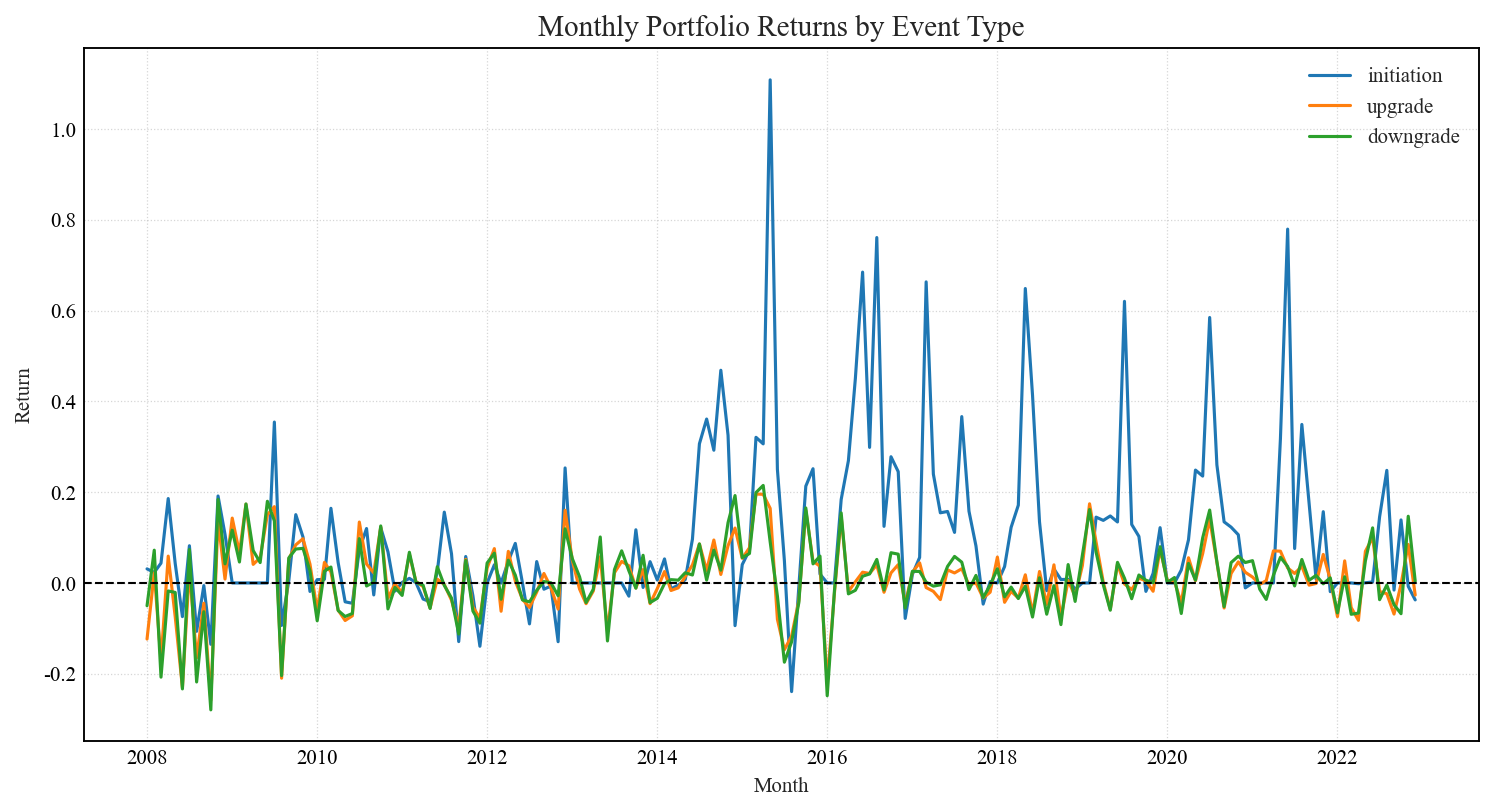

In [173]:
plt.figure(figsize=(12,6))
for ev in ["initiation", "upgrade", "downgrade"]:
    plt.plot(port_pivot.index, port_pivot[ev], label=ev)

plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Monthly Portfolio Returns by Event Type", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

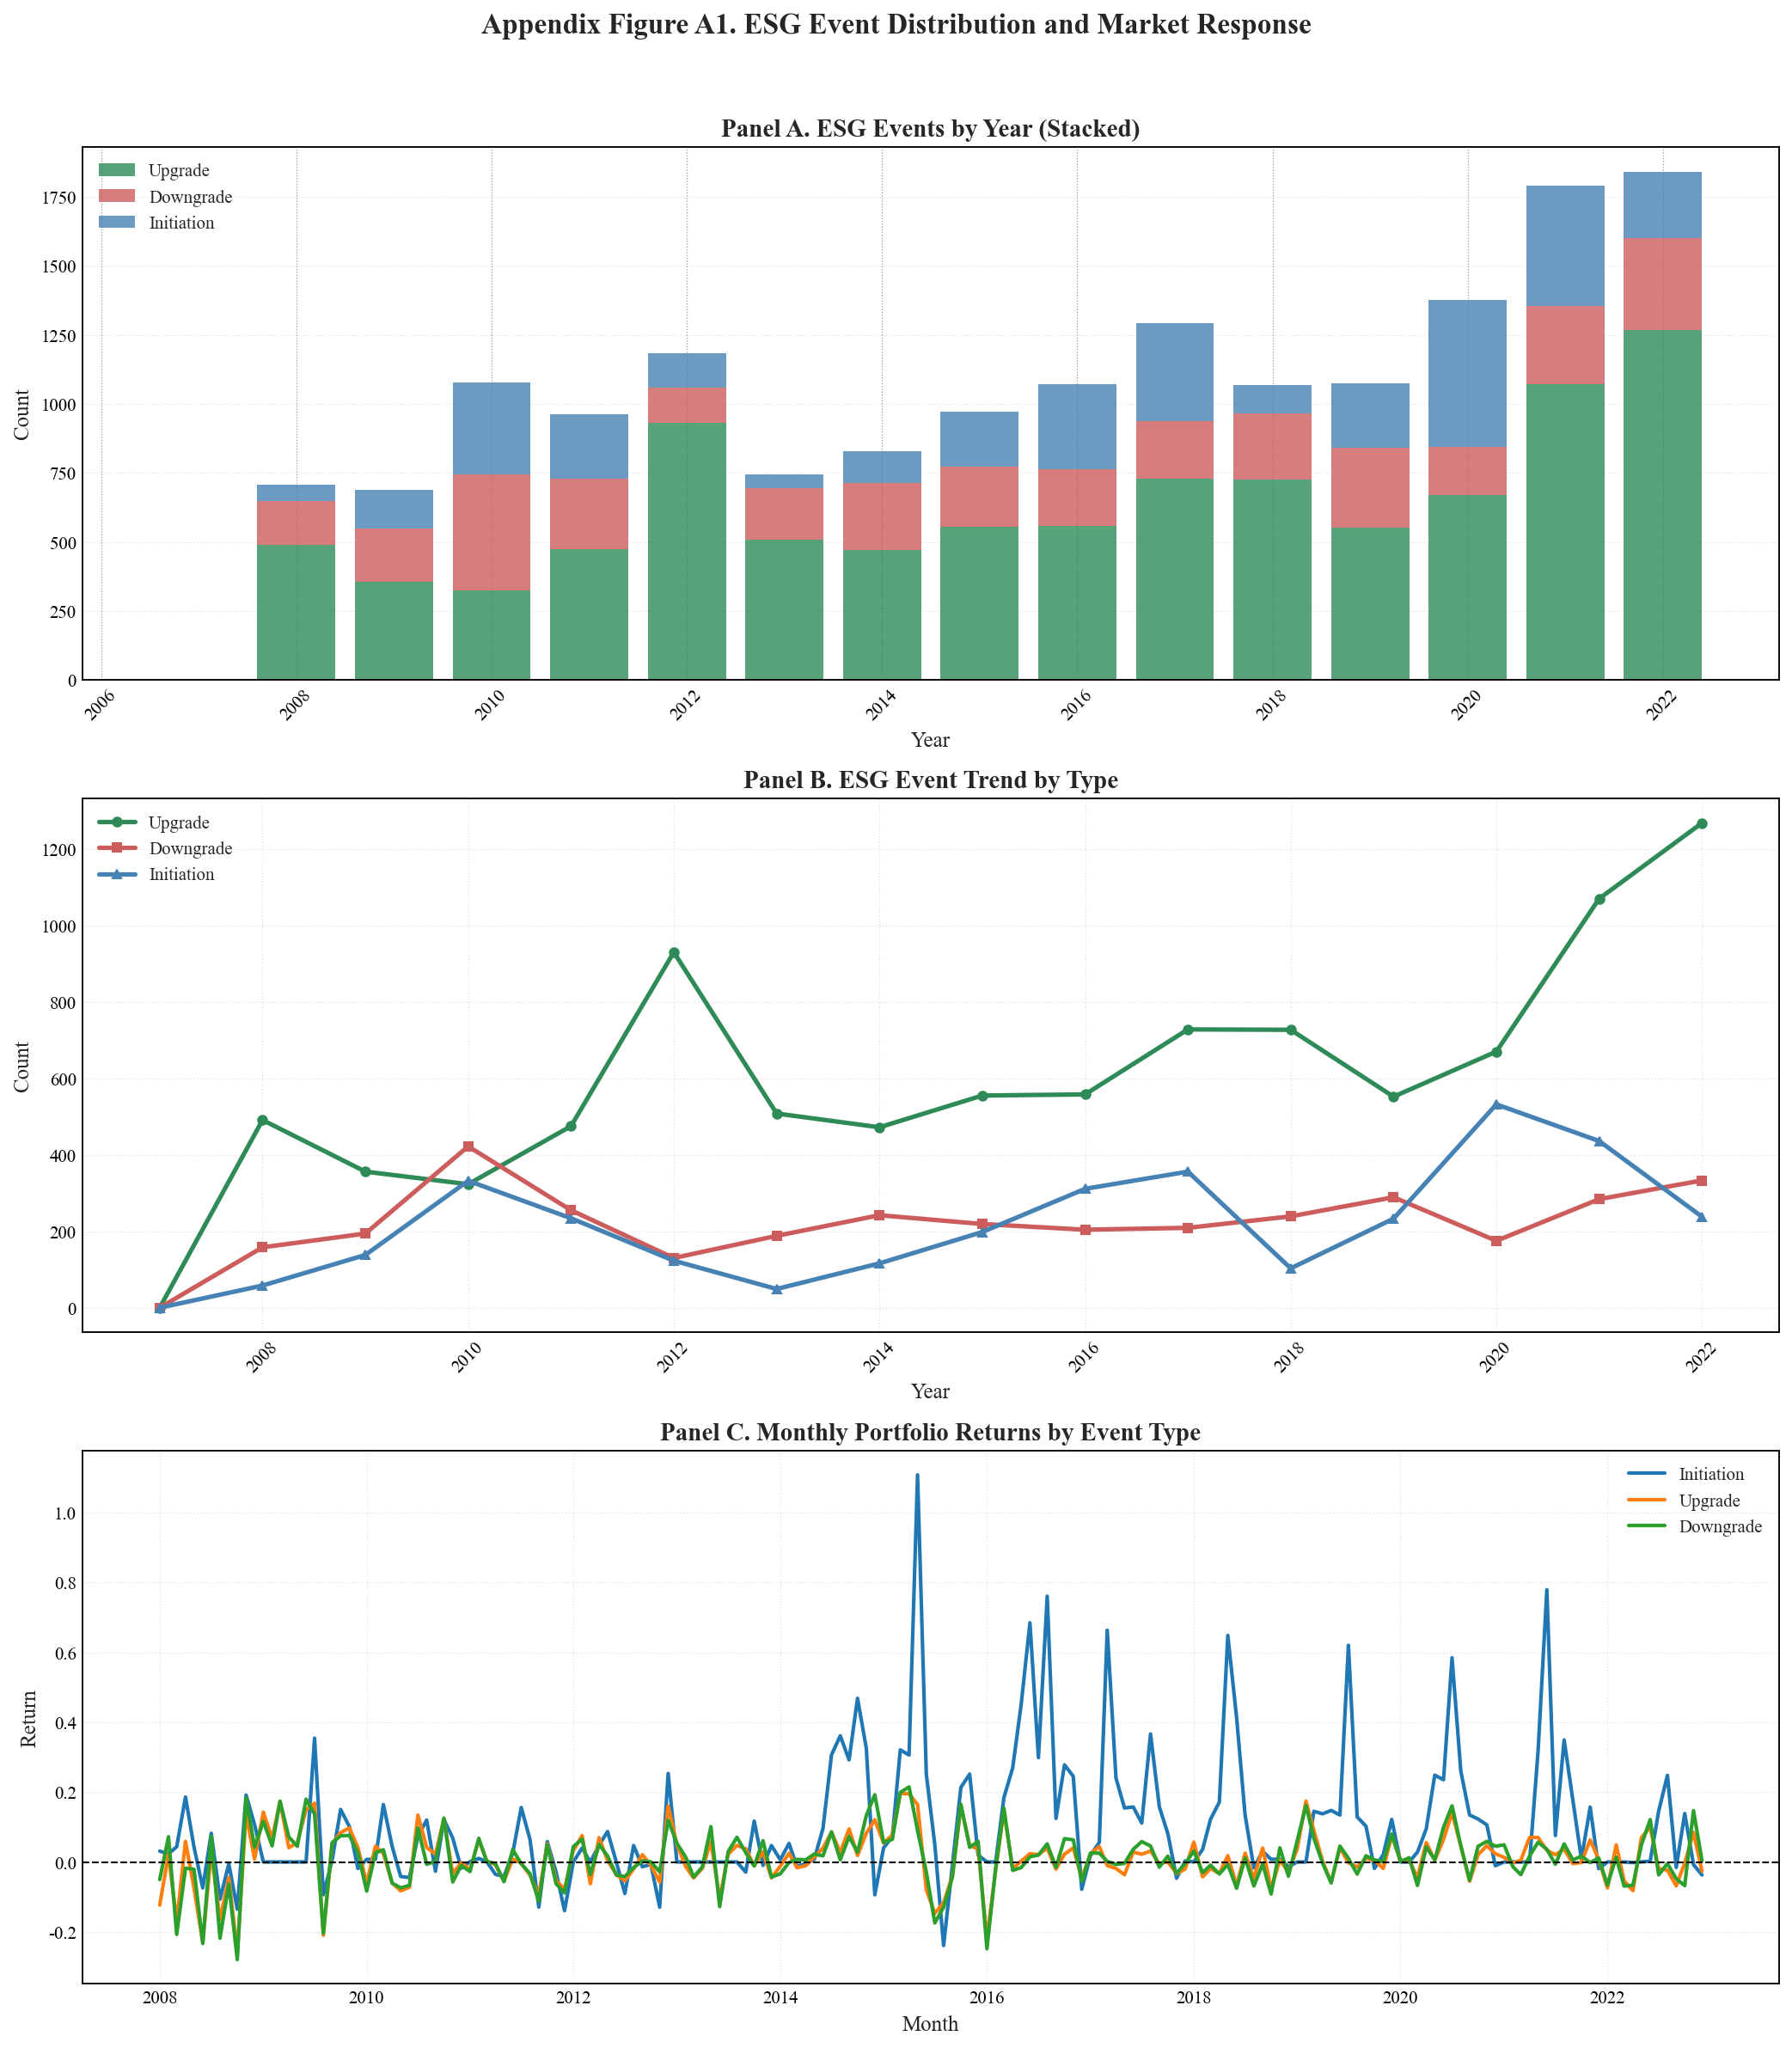

In [174]:
# =============================================
# Appendix Figure A1. ESG Event Distribution and Market Response
# =============================================

import matplotlib.pyplot as plt
import pandas as pd

# 中文字体设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# 创建整体图
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
fig.subplots_adjust(hspace=0.35)  # 调整panel间距

# =============================
# Panel A: 堆叠柱状图（事件年度分布）
# =============================
years = yearly_counts.index
upgrade = yearly_counts['upgrade']
downgrade = yearly_counts['downgrade']
initiation = yearly_counts['initiation']

axes[0].bar(years, upgrade, label='Upgrade', color='#2E8B57', alpha=0.8)
axes[0].bar(years, downgrade, bottom=upgrade, label='Downgrade', color='#CD5C5C', alpha=0.8)
axes[0].bar(years, initiation, bottom=upgrade + downgrade, label='Initiation', color='#4682B4', alpha=0.8)
axes[0].set_title('Panel A. ESG Events by Year (Stacked)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# =============================
# Panel B: 折线图（事件趋势）
# =============================
axes[1].plot(years, upgrade, marker='o', linewidth=2.5, label='Upgrade', color='#2E8B57')
axes[1].plot(years, downgrade, marker='s', linewidth=2.5, label='Downgrade', color='#CD5C5C')
axes[1].plot(years, initiation, marker='^', linewidth=2.5, label='Initiation', color='#4682B4')
axes[1].set_title('Panel B. ESG Event Trend by Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# =============================
# Panel C: 月度收益折线图
# =============================
for ev in ["initiation", "upgrade", "downgrade"]:
    axes[2].plot(port_pivot.index, port_pivot[ev], label=ev.capitalize(), linewidth=2)
axes[2].axhline(0, color="black", linestyle="--", lw=1)
axes[2].set_title('Panel C. Monthly Portfolio Returns by Event Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Return', fontsize=12)
axes[2].legend()
axes[2].grid(alpha=0.3)

# =============================
# 总标题 & 布局
# =============================
fig.suptitle("Appendix Figure A1. ESG Event Distribution and Market Response", 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # 让标题不被遮挡
plt.show()


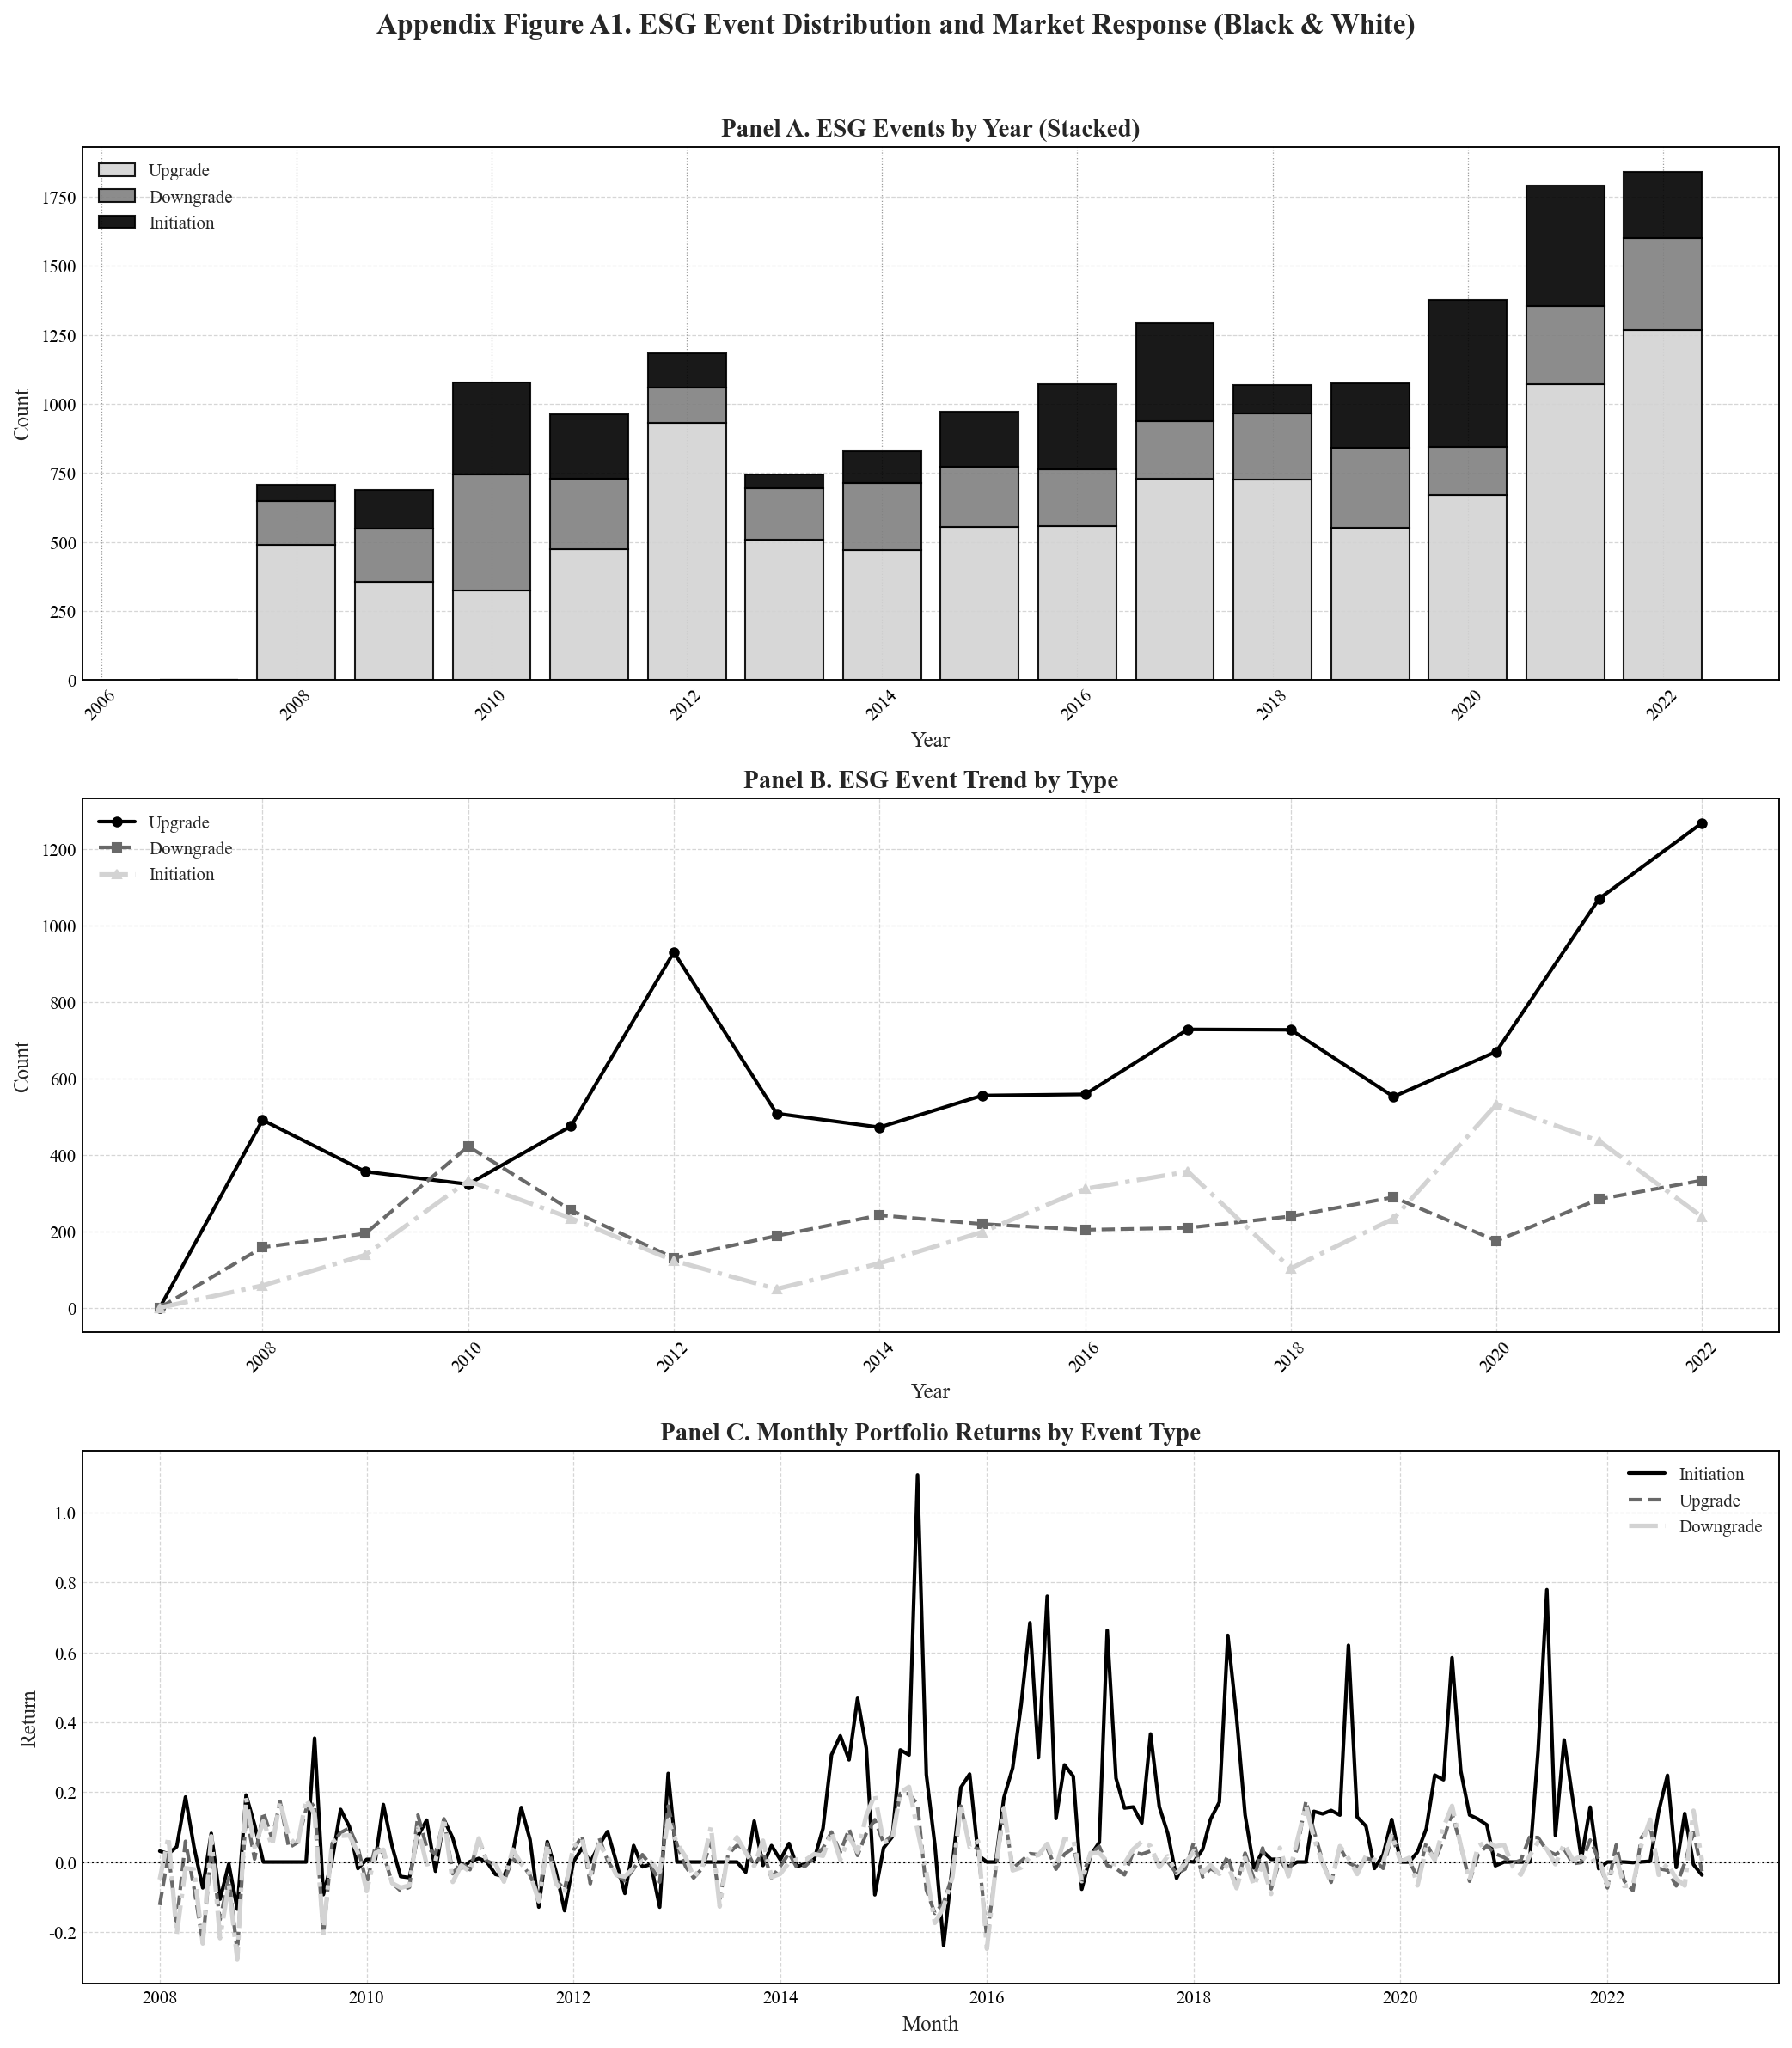

In [175]:
# =============================================
# Appendix Figure A1. ESG Event Distribution and Market Response (Black & White Version)
# =============================================

import matplotlib.pyplot as plt
import pandas as pd

# 设置字体和风格
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'  # 白色背景
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 创建整体图
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
fig.subplots_adjust(hspace=0.35)  # 调整panel间距

# =============================
# Panel A: 堆叠柱状图（事件年度分布）
# =============================
years = yearly_counts.index
upgrade = yearly_counts['upgrade']
downgrade = yearly_counts['downgrade']
initiation = yearly_counts['initiation']

axes[0].bar(years, upgrade, label='Upgrade', color='lightgray', edgecolor='black', alpha=0.9)
axes[0].bar(years, downgrade, bottom=upgrade, label='Downgrade', color='gray', edgecolor='black', alpha=0.9)
axes[0].bar(years, initiation, bottom=upgrade + downgrade, label='Initiation', color='black', edgecolor='black', alpha=0.9)

axes[0].set_title('Panel A. ESG Events by Year (Stacked)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(frameon=False)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)
axes[0].tick_params(axis='x', rotation=45)

# =============================
# Panel B: 折线图（事件趋势）
# =============================
axes[1].plot(years, upgrade, marker='o', linestyle='-', color='black', linewidth=2, label='Upgrade')
axes[1].plot(years, downgrade, marker='s', linestyle='--', color='dimgray', linewidth=2, label='Downgrade')
axes[1].plot(years, initiation, marker='^', linestyle='-.', color='lightgray', linewidth=2.5, label='Initiation')

axes[1].set_title('Panel B. ESG Event Trend by Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend(frameon=False)
axes[1].grid(linestyle='--', alpha=0.4)
axes[1].tick_params(axis='x', rotation=45)

# =============================
# Panel C: 月度收益折线图
# =============================
axes[2].plot(port_pivot.index, port_pivot["initiation"], label='Initiation', color='black', linestyle='-', linewidth=2)
axes[2].plot(port_pivot.index, port_pivot["upgrade"], label='Upgrade', color='dimgray', linestyle='--', linewidth=2)
axes[2].plot(port_pivot.index, port_pivot["downgrade"], label='Downgrade', color='lightgray', linestyle='-.', linewidth=2.5)

axes[2].axhline(0, color="black", linestyle=":", lw=1)
axes[2].set_title('Panel C. Monthly Portfolio Returns by Event Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Return', fontsize=12)
axes[2].legend(frameon=False)
axes[2].grid(linestyle='--', alpha=0.4)

# =============================
# 总标题 & 布局
# =============================
fig.suptitle("Appendix Figure A1. ESG Event Distribution and Market Response (Black & White)", 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# 导出高清PDF（如需）
fig.savefig("Appendix_Fig_A1_BW.png", dpi=600, bbox_inches="tight")

plt.show()


## ESG and Downside Risk（ESG 与下行风险）
关注 ESG 是否能降低风险。
* 波动率（Volatility）：高 ESG 投组合拥有更小的波动率。
* 下行风险（Downside Risk）：比如条件在市场下跌时，ESG 投组合跌的更少。但是由于负数回报的原因，他同时也拥有负数的Sortino Ratio。
* 崩盘风险（Crash Sensitivity）：统计上不能断言 ESG 和 S 组合具有抗崩盘的特性。
    - 但是对于高E 的组合，其在特定条件下具有抗崩盘的特性。
    - 但是对于高G 的组合，在极端的风险情况下，它会展示出显著的负数回报。

#### **Data Prepare**

In [178]:
# Data Prepare
# ESG回报数据
# ——已有：hl_daily 为日度 H–L 收益（Index 为日期，值为日收益）——
esg_hl_daily = esg_hl_daily.dropna()
esg_hl_daily.index = pd.to_datetime(esg_hl_daily.index)

# 1) 当月实现波动率（年化）
esg_monthly_realized_vol = (
    esg_hl_daily
    .resample('M')                       # 按月聚合日度数据
    .std(ddof=1) * np.sqrt(252)         # 当月日收益的标准差 × √252 -> 年化
)
esg_monthly_realized_vol.name = 'esg_realized_vol_annualized'

# 2) 也可以给出“非年化”的当月波动（只是本月日收益的 std）
esg_monthly_realized_vol_non_annual = esg_hl_daily.resample('M').std(ddof=1)
esg_monthly_realized_vol_non_annual.name = 'esg_realized_vol_month'
print(esg_monthly_realized_vol_non_annual)

Date
2007-01-31    0.008612
2007-02-28    0.005376
2007-03-31    0.006896
2007-04-30    0.007735
2007-05-31    0.008693
                ...   
2022-08-31    0.006932
2022-09-30    0.006176
2022-10-31    0.007200
2022-11-30    0.005538
2022-12-31    0.006013
Freq: M, Name: esg_realized_vol_month, Length: 192, dtype: float64


In [179]:
import akshare as ak
# ---------- 0) 参数 ----------
symbols = {
    "sh000300": "CSI300",   # 沪深300
    "sh000001": "SSE",      # 上证综指
    "sz399001": "SZSE"      # 深证成指
}
start = "2007-01-01"
end   = "2023-01-01"

# 如果你的 ESG 月度波动率是 Series，确保 index 为 Timestamp（月末）
# 例如：esg_monthly_realized_vol_non_annual.name = "ESG_vol"
esg_series = esg_monthly_realized_vol_non_annual.copy()
if esg_series.name is None:
    esg_series.name = "ESG_vol"

# ---------- 1) 抓取指数&计算月度波动率（不年化） ----------
vol_month_dict = {}    # 保存各指数的月度波动率
daily_panel = {}       # 可选：保存各指数的日线（便于检查/导出）

for s, nm in symbols.items():
    df = ak.stock_zh_index_daily(symbol=s)
    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= start) & (df["date"] <= end)]
    df = df.sort_values("date").set_index("date")

    # 简单日收益
    df["ret_d"] = df["close"].pct_change()
    df = df.dropna(subset=["ret_d"])

    # 月度 realized volatility（不年化）：当月日收益的 std
    vol_m = df["ret_d"].resample("M").std(ddof=1)
    vol_m.name = f"{nm}_vol"          # 列名：CSI300_vol / SSE_vol / SZSE_vol
    vol_month_dict[nm] = vol_m

    # 可选：保存日线
    daily_panel[nm] = df[["close","ret_d"]].copy()

# ---------- 2) 组装月度波动率面板 & 导出 ----------
index_monthly_vol_df = pd.concat(vol_month_dict.values(), axis=1)

# ---------- 3) 与 ESG 月度波动率合并 & 导出 ----------
combined_vol = pd.concat([esg_series.rename("ESG_vol"), index_monthly_vol_df], axis=1)
print(combined_vol.tail(12))  # 最近12个月查看

             ESG_vol  CSI300_vol   SSE_vol  SZSE_vol
2022-01-31  0.006033    0.010365  0.009047  0.012411
2022-02-28  0.004322    0.010028  0.009021  0.012255
2022-03-31  0.005550    0.019657  0.017305  0.020560
2022-04-30  0.006982    0.019032  0.018306  0.024311
2022-05-31  0.003949    0.012071  0.010340  0.013175
2022-06-30  0.006936    0.010714  0.008918  0.012833
2022-07-31  0.005872    0.008030  0.007997  0.009540
2022-08-31  0.006932    0.009620  0.008819  0.011961
2022-09-30  0.006176    0.009051  0.008885  0.011420
2022-10-31  0.007200    0.014019  0.011495  0.016363
2022-11-30  0.005538    0.015084  0.010665  0.014106
2022-12-31  0.006013    0.008506  0.007354  0.008367


In [180]:
# ---------- 4) 计算三大指数“月度收益”（由日度收益连乘得到） ----------
# 做法：Monthly Return = ∏(1 + ret_d) - 1
ret_month_dict = {}
for nm, df in daily_panel.items():
    # 注意：df 里已经有 ret_d（日收益，简单收益率）
    monthly_ret = (1 + df["ret_d"]).resample("M").prod() - 1
    monthly_ret.name = f"{nm}_ret"     # 列名：CSI300_ret / SSE_ret / SZSE_ret
    ret_month_dict[nm] = monthly_ret

index_monthly_ret_df = pd.concat(ret_month_dict.values(), axis=1)

#（可选）如果你更喜欢对数收益口径：
# log_monthly_ret = df["ret_d"].add(1).apply(np.log).resample("M").sum().apply(np.expm1)


# ---------- 5) 如果你有 ESG 的月度收益，也可以一起合并 ----------
# 假设你有 hl_daily（日度 H–L 收益，单位小数），可得到 ESG 的月度收益：
esg_monthly_ret = (1 + esg_hl_daily).resample("M").prod() - 1
esg_monthly_ret.name = "ESG_ret"
e_monthly_ret = (1 + e_hl_daily).resample("M").prod() - 1
e_monthly_ret.name = "E_ret"
s_monthly_ret = (1 + s_hl_daily).resample("M").prod() - 1
s_monthly_ret.name = "S_ret"
g_monthly_ret = (1 + g_hl_daily).resample("M").prod() - 1
g_monthly_ret.name = "G_ret"


combined_ret = pd.concat([esg_monthly_ret,e_monthly_ret, s_monthly_ret, g_monthly_ret,index_monthly_ret_df], axis=1).dropna()

print("\n===== 指数月度收益 (最后12行) =====")

print(combined_ret.tail(12))


===== 指数月度收益 (最后12行) =====
             ESG_ret     E_ret     S_ret     G_ret  CSI300_ret   SSE_ret  \
2022-01-31 -0.012396 -0.035756  0.040635  0.065787   -0.076229 -0.076470   
2022-02-28  0.011602  0.024988  0.013518 -0.008310    0.003916  0.030007   
2022-03-31  0.001388 -0.029932  0.071602  0.065414   -0.078367 -0.060683   
2022-04-30  0.030257  0.023020  0.022437  0.101639   -0.048869 -0.063078   
2022-05-31 -0.016869  0.013909 -0.032747 -0.083591    0.018743  0.045738   
2022-06-30  0.002708  0.037309 -0.053088 -0.061887    0.096173  0.066592   
2022-07-31 -0.060972 -0.036488 -0.013087 -0.076978   -0.070214 -0.042776   
2022-08-31  0.011520 -0.003801  0.020249  0.041809   -0.021885 -0.015707   
2022-09-30  0.021879  0.013849  0.036026  0.034763   -0.067165 -0.055509   
2022-10-31 -0.084315 -0.080833  0.001635 -0.083705   -0.077843 -0.043284   
2022-11-30  0.020874  0.011533 -0.004918  0.073032    0.098137  0.089115   
2022-12-31  0.037058  0.028064 -0.003724  0.032803    0.0048

### 波动率（Volatility）：
问题：高 ESG 投组合是不是波动更小？  
结论：是的，在历史的不同时段。高ESG的组合总是具有更小的volatility。
* 平均水平：在整个样本期内，ESG High–Low 组合的波动率（Mean）始终显著低于沪深 300（CSI300）、上证综指（SSE）、深证成指（SZSE）的波动率均值。这说明 高 ESG 组合长期更稳定。
* 区间范围（Range）：ESG 组合的波动率波动区间（Max–Min）更窄，说明 极端行情下 ESG 组合的风险敞口更小。相比之下，市场指数（尤其是深证成指）在极端行情下会出现更大的波动。
* 最小/最大值：即便在波动率的峰值年份，ESG 组合的最大波动率仍低于三大指数的最大波动率；而在市场相对平稳阶段，ESG 组合的最小波动率也维持在一个较低水平。
* 稳健性：结合标准差（Std）可以发现，ESG 组合波动率的稳定性（跨期方差）也明显优于三大指数，说明其 风险控制能力在不同市场环境下都更持久。


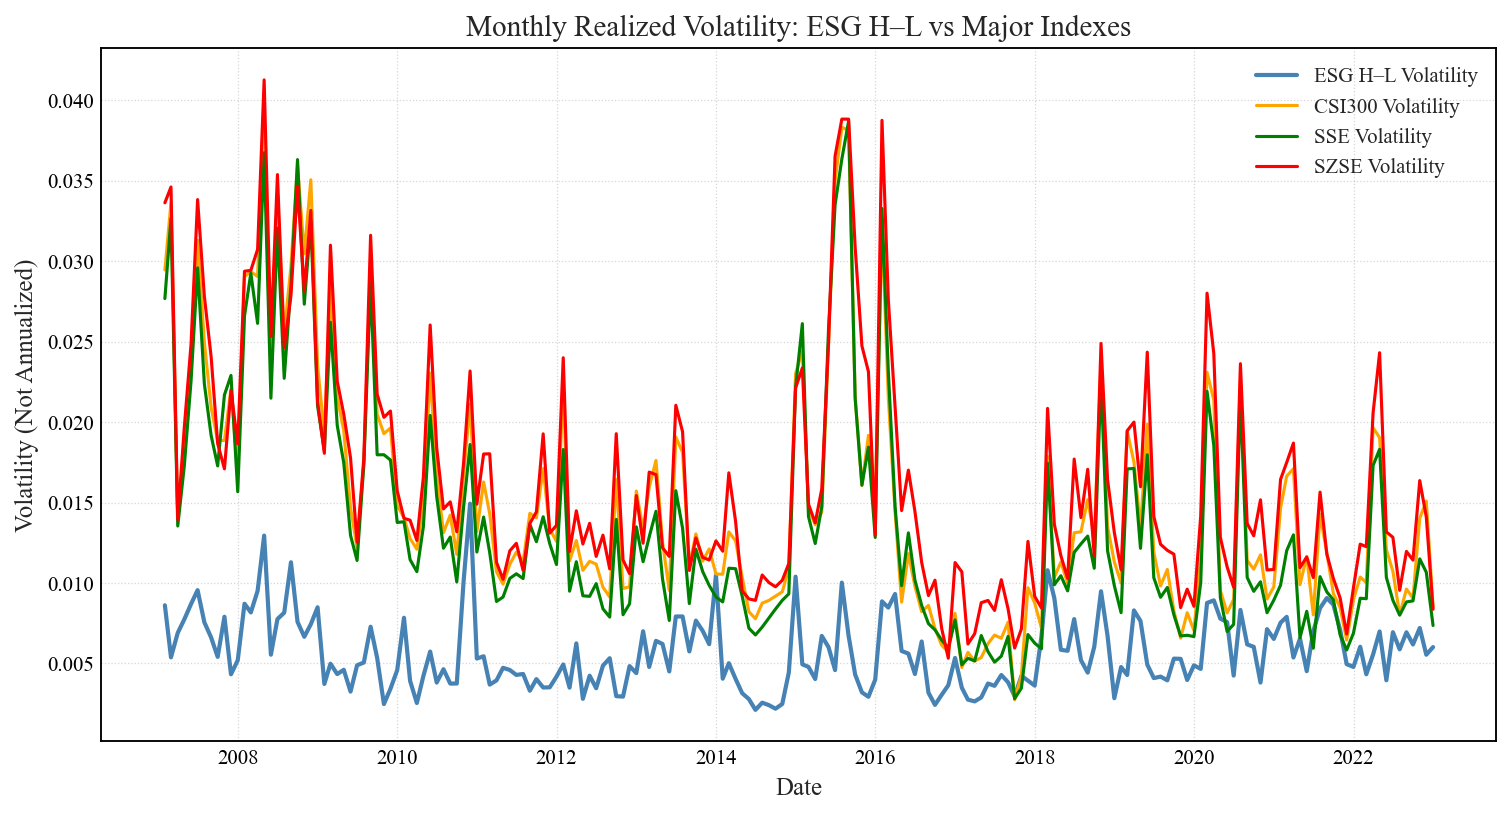

In [182]:
# 画对比图
plt.figure(figsize=(12,6))
plt.plot(combined_vol.index, combined_vol["ESG_vol"], label="ESG H–L Volatility", color="steelblue", lw=2)
plt.plot(combined_vol.index, combined_vol["CSI300_vol"], label="CSI300 Volatility", color="orange", lw=1.5)
plt.plot(combined_vol.index, combined_vol["SSE_vol"], label="SSE Volatility", color="green", lw=1.5)
plt.plot(combined_vol.index, combined_vol["SZSE_vol"], label="SZSE Volatility", color="red", lw=1.5)

plt.title("Monthly Realized Volatility: ESG H–L vs Major Indexes", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility (Not Annualized)", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


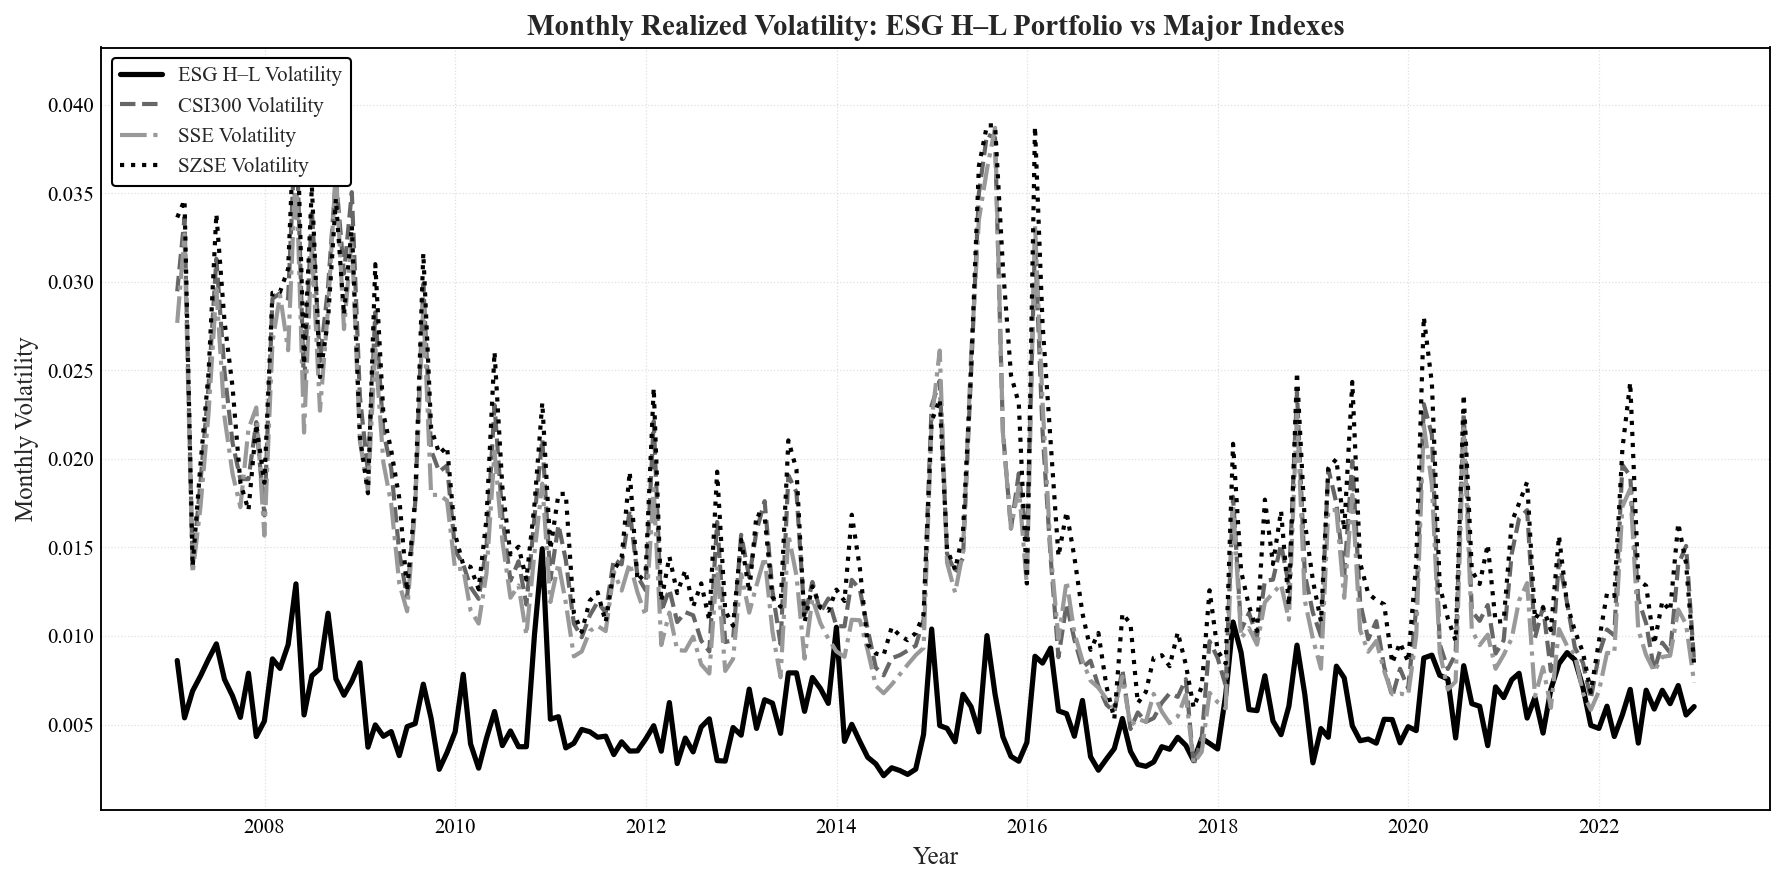

In [183]:
# ====== 学术风格（带适度颜色）======
plt.figure(figsize=(12, 6))

# 使用适度的颜色和线型组合
plt.plot(combined_vol.index, combined_vol["ESG_vol"], 
         label="ESG H–L Volatility", 
         linestyle="-", 
         linewidth=2.5, 
         color="#000000")  # 纯黑色

plt.plot(combined_vol.index, combined_vol["CSI300_vol"], 
         label="CSI300 Volatility", 
         linestyle="--", 
         linewidth=2.0, 
         color="#666666")  # 深灰色

plt.plot(combined_vol.index, combined_vol["SSE_vol"], 
         label="SSE Volatility", 
         linestyle="-.", 
         linewidth=2.0, 
         color="#999999")  # 中灰色

plt.plot(combined_vol.index, combined_vol["SZSE_vol"], 
         label="SZSE Volatility", 
         linestyle=":", 
         linewidth=2.0, 
         color="#000000")  # 浅灰色

plt.title("Monthly Realized Volatility: ESG H–L Portfolio vs Major Indexes", 
          fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Monthly Volatility", fontsize=12)

# 学术风格的图例
plt.legend(loc="upper left", 
           frameon=True, 
           edgecolor="black", 
           facecolor="white",
           framealpha=1.0,
           fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存选项
# plt.savefig("Figure_Volatility_Comparison_academic.pdf", bbox_inches='tight')
# plt.savefig("Figure_Volatility_Comparison_academic.png", dpi=300, bbox_inches='tight')

plt.show()

In [184]:
# 计算 range，std 和 mean
summary_table = pd.DataFrame({
    "Mean": combined_vol.mean(),
    "Min": combined_vol.min(),
    "Max": combined_vol.max(),
    "Std":combined_vol.std()
})

# 额外加一列 Range = Max - Min
summary_table["Range"] = summary_table["Max"] - summary_table["Min"]

# 整理显示
summary_table = summary_table.round(4)  # 保留4位小数
print(summary_table)

              Mean     Min     Max     Std   Range
ESG_vol     0.0056  0.0021  0.0149  0.0022  0.0128
CSI300_vol  0.0151  0.0027  0.0393  0.0075  0.0366
SSE_vol     0.0138  0.0028  0.0387  0.0074  0.0359
SZSE_vol    0.0166  0.0053  0.0413  0.0076  0.0360


In [185]:
# 计算 range，std 和 mean
summary_table = pd.DataFrame({
    "Mean": combined_vol.mean(),
    "Min": combined_vol.min(),
    "Max": combined_vol.max(),
    "Std": combined_vol.std()
})

# 额外加一列 Range = Max - Min
summary_table["Range"] = summary_table["Max"] - summary_table["Min"]

# 添加 VaR (95% 置信水平，历史模拟法)
summary_table["VaR_95%"] = combined_vol.quantile(0.05)

# 整理显示
summary_table = summary_table.round(4)  # 保留4位小数
print(summary_table)

              Mean     Min     Max     Std   Range  VaR_95%
ESG_vol     0.0056  0.0021  0.0149  0.0022  0.0128   0.0028
CSI300_vol  0.0151  0.0027  0.0393  0.0075  0.0366   0.0065
SSE_vol     0.0138  0.0028  0.0387  0.0074  0.0359   0.0059
SZSE_vol    0.0166  0.0053  0.0413  0.0076  0.0360   0.0084


### 下行风险（Downside Risk）： 
问题：高 ESG 投组合的下行风险是不是更小？   
结论：相较于0%的基准，ESG 组合的下行风险（0.0320）也显著低于其他指数（约 0.08）。表明 ESG 策略在市场下跌时的抗跌性更好。
* 但是由于ESG 组合的平均收益是 负的（-0.0032），所以导致ESG的Sortino Ratio也为负数。这说明平均回报为负，即ESG组合在考虑风险和溢价调整后表现差。


In [188]:

# === 1) 定义函数 ===
def downside_risk(series, mar=0.0):
    """计算下行风险（Downside Risk），默认 MAR=0"""
    downside = series[series < mar]
    return np.sqrt((downside**2).mean())

def sortino_ratio(series, mar=0.0):
    """计算 Sortino Ratio"""
    dr = downside_risk(series, mar)
    mean_excess = series.mean() - mar
    return np.nan if dr == 0 else mean_excess / dr

# === 2) 针对每列收益做计算 ===
metrics = {}
for col in combined_ret.columns:  # ESG_ret, CSI300_ret, SSE_ret, SZSE_ret
    metrics[col] = {
        "MeanReturn": combined_ret[col].mean(),
        "Volatility": combined_ret[col].std(),
        "DownsideRisk": downside_risk(combined_ret[col]),
        "SortinoRatio": sortino_ratio(combined_ret[col])
    }

# === 3) 结果表格 ===
downside_table = pd.DataFrame(metrics).T
print(downside_table)

# 如果想更美观：
# downside_table.style.format("{:.4f}")

            MeanReturn  Volatility  DownsideRisk  SortinoRatio
ESG_ret      -0.003212    0.030454      0.032786     -0.097974
E_ret        -0.001558    0.028587      0.029878     -0.052149
S_ret        -0.003884    0.035566      0.034195     -0.113591
G_ret        -0.009167    0.051015      0.053861     -0.170195
CSI300_ret    0.006689    0.082496      0.082524      0.081054
SSE_ret       0.003495    0.074400      0.077260      0.045236
SZSE_ret      0.006358    0.086748      0.086324      0.073655


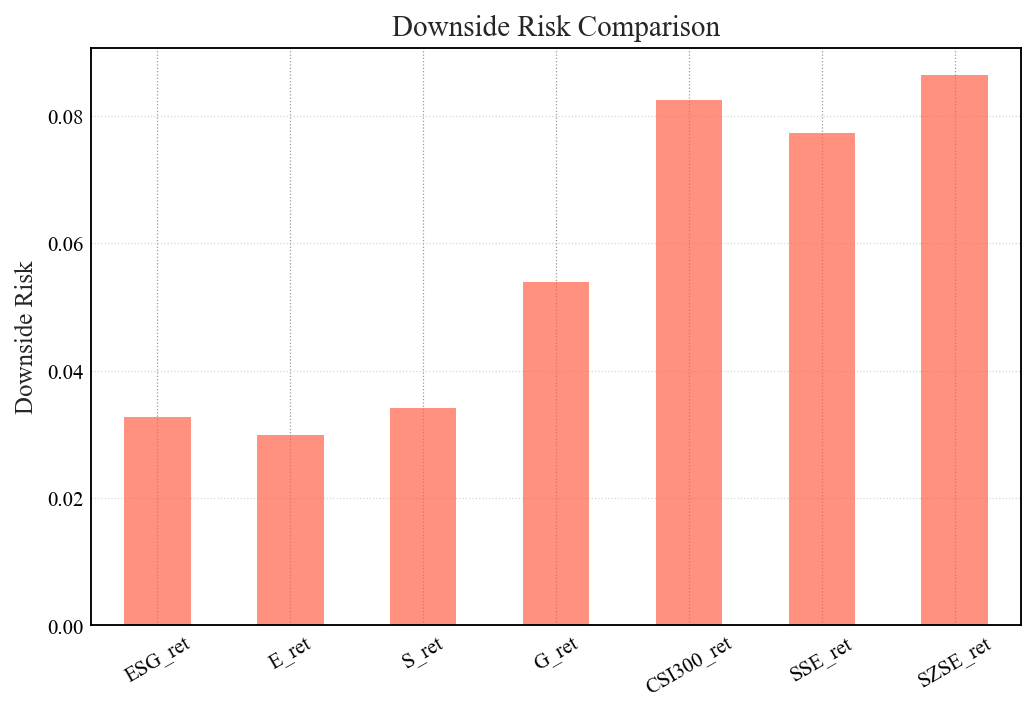

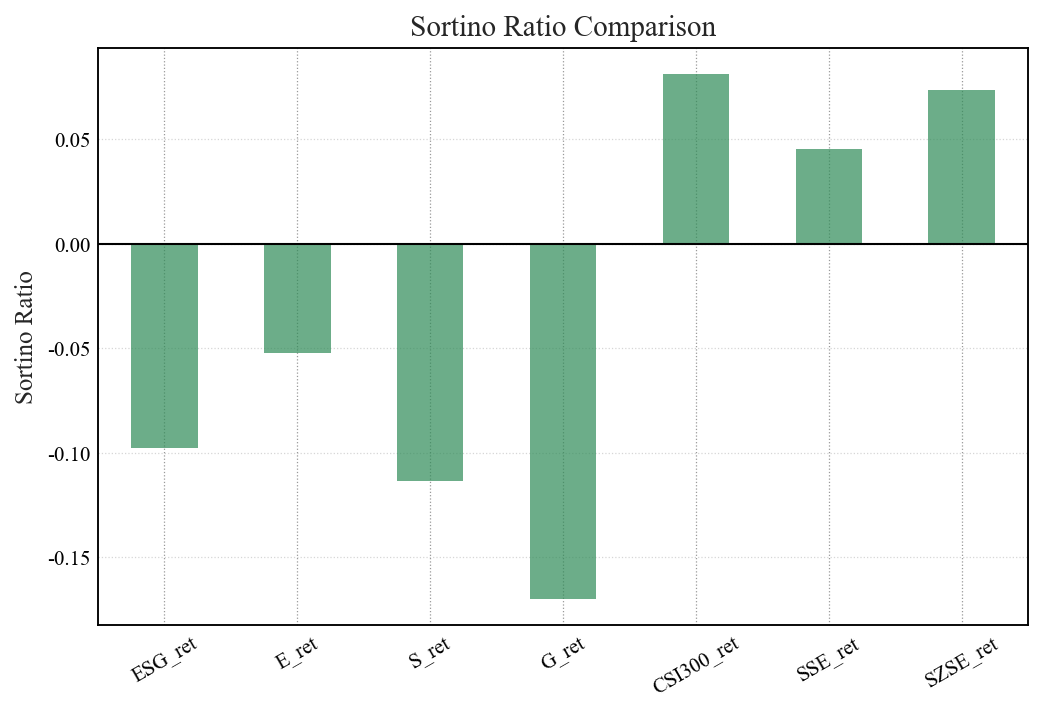

In [189]:
# === Downside Risk 对比 ===
plt.figure(figsize=(8,5))
downside_table["DownsideRisk"].plot(kind="bar", color="tomato", alpha=0.7)
plt.title("Downside Risk Comparison", fontsize=14)
plt.ylabel("Downside Risk", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.4)
plt.show()

# === Sortino Ratio 对比 ===
plt.figure(figsize=(8,5))
downside_table["SortinoRatio"].plot(kind="bar", color="seagreen", alpha=0.7)
plt.title("Sortino Ratio Comparison", fontsize=14)
plt.ylabel("Sortino Ratio", fontsize=12)
plt.xticks(rotation=30)
plt.axhline(0, color="black", lw=1)  # 参考线
plt.grid(axis="y", alpha=0.4)
plt.show()

### 崩盘风险（Crash Sensitivity）
问题：极端事件中（金融危机、疫情爆发），ESG 投组合是否更有韧性？  
我们定义Crash month为，当沪深300（CSI300）月度收益 < -5%以下的情况。  

结论：  
* ESG 组合：从回归结果来看，Crash_Mkt 系数为大多数为负数，并且其p数值不显著。ESG 投资组合在市场极端下跌期间并没有显著地加剧或减小损失，其风险暴露并不明显。
* E 组合：从回归结果来看，Crash_Mkt 系数为大多数为正数，在threshold为=-0.05和-0.07时，其产生显著的正回报。<u>这说明E 投资组合在市场极端下跌期间展示减小损失的能力。</u>
* S 组合：从回归结果来看，Crash_Mkt 系数为大多数为负数，并且其p数值不显著。S 投资组合在市场极端下跌期间并没有显著地加剧或减小损失，其风险暴露并不明显。
* G 组合：从回归结果来看，Crash_Mkt 系数为大多数为负数，并且其p数值大多显著。<u>这说明G 投资组合在市场极端下跌期间显著地加剧损失。</u>说明在中国市场中，高治理公司并没有成为避险资产，反而更容易受系统性冲击影响。


#### ESG Crash Sensivitiy 

   Threshold  Crash_Mkt Coef  Crash_Mkt Pval  ESG_ret (Normal)  \
0      -0.05       -0.016833        0.808316         -0.003457   
1      -0.06       -0.049199        0.455260         -0.004139   
2      -0.07       -0.004695        0.940831         -0.003054   
3      -0.08       -0.095071        0.121999         -0.004523   
4      -0.09       -0.102511        0.094846         -0.004557   
5      -0.10       -0.093245        0.129876         -0.004353   
6      -0.11       -0.102346        0.097218         -0.004432   

   ESG_ret (Crash)  
0        -0.002413  
1         0.000805  
2        -0.004182  
3         0.010276  
4         0.013891  
5         0.013906  
6         0.016857  


C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

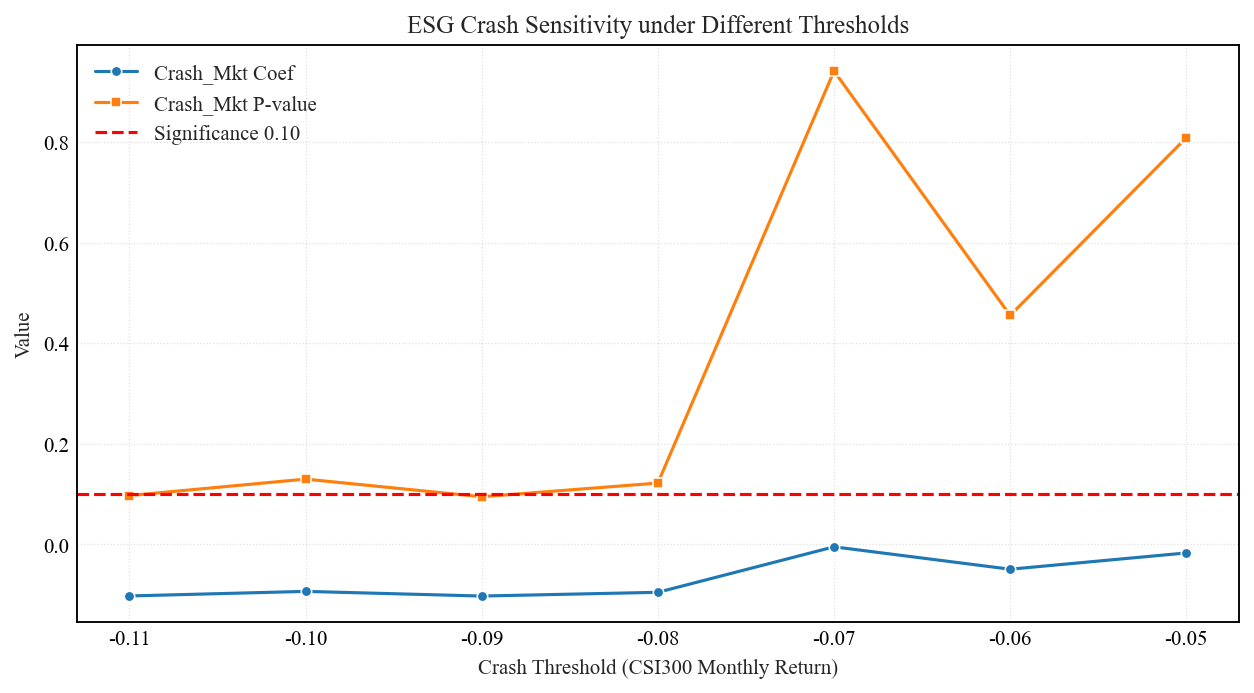

In [195]:
# ESG的探索
# 定义不同的 crash 阈值
crash_thresholds = [-0.05, -0.06, -0.07, -0.08, -0.09, -0.10, -0.11]

results = []

for thr in crash_thresholds:
    # 1) 定义 Crash 哑变量
    combined_ret["Crash"] = (combined_ret["CSI300_ret"] < thr).astype(int)
    
    # 2) 回归模型： r_ESG = α + β*r_m + γ*(Crash*r_m) + ε
    X = pd.DataFrame({
        "Mkt": combined_ret["CSI300_ret"],
        "Crash_Mkt": combined_ret["CSI300_ret"] * combined_ret["Crash"]
    })
    X = sm.add_constant(X)
    y = combined_ret["ESG_ret"]

    model = sm.OLS(y, X, missing="drop").fit()
    
    # 3) 平均收益（正常 vs Crash）
    avg_normal = combined_ret.loc[combined_ret["Crash"]==0, "ESG_ret"].mean()
    avg_crash  = combined_ret.loc[combined_ret["Crash"]==1, "ESG_ret"].mean()

    results.append({
        "Threshold": thr,
        "Crash_Mkt Coef": model.params["Crash_Mkt"],
        "Crash_Mkt Pval": model.pvalues["Crash_Mkt"],
        "ESG_ret (Normal)": avg_normal,
        "ESG_ret (Crash)": avg_crash
    })

# 汇总为表格
crash_table = pd.DataFrame(results)
print(crash_table)

# 如果要美观展示
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Coef", marker="o", label="Crash_Mkt Coef")
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Pval", marker="s", label="Crash_Mkt P-value")
plt.axhline(0.10, color="red", linestyle="--", label="Significance 0.10")
plt.title("ESG Crash Sensitivity under Different Thresholds")
plt.xlabel("Crash Threshold (CSI300 Monthly Return)")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### E Crash Sensivitiy 

   Threshold  Crash_Mkt Coef  Crash_Mkt Pval  E_ret (Normal)  E_ret (Crash)
0      -0.05        0.169351        0.008380       -0.001069      -0.003156
1      -0.06        0.130969        0.032442       -0.001479      -0.001900
2      -0.07        0.142485        0.015093       -0.000784      -0.006290
3      -0.08        0.086451        0.132338       -0.001489      -0.002271
4      -0.09        0.067244        0.241743       -0.001727       0.000588
5      -0.10        0.071349        0.215247       -0.001615      -0.000704
6      -0.11        0.064519        0.264046       -0.001677       0.000396


C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

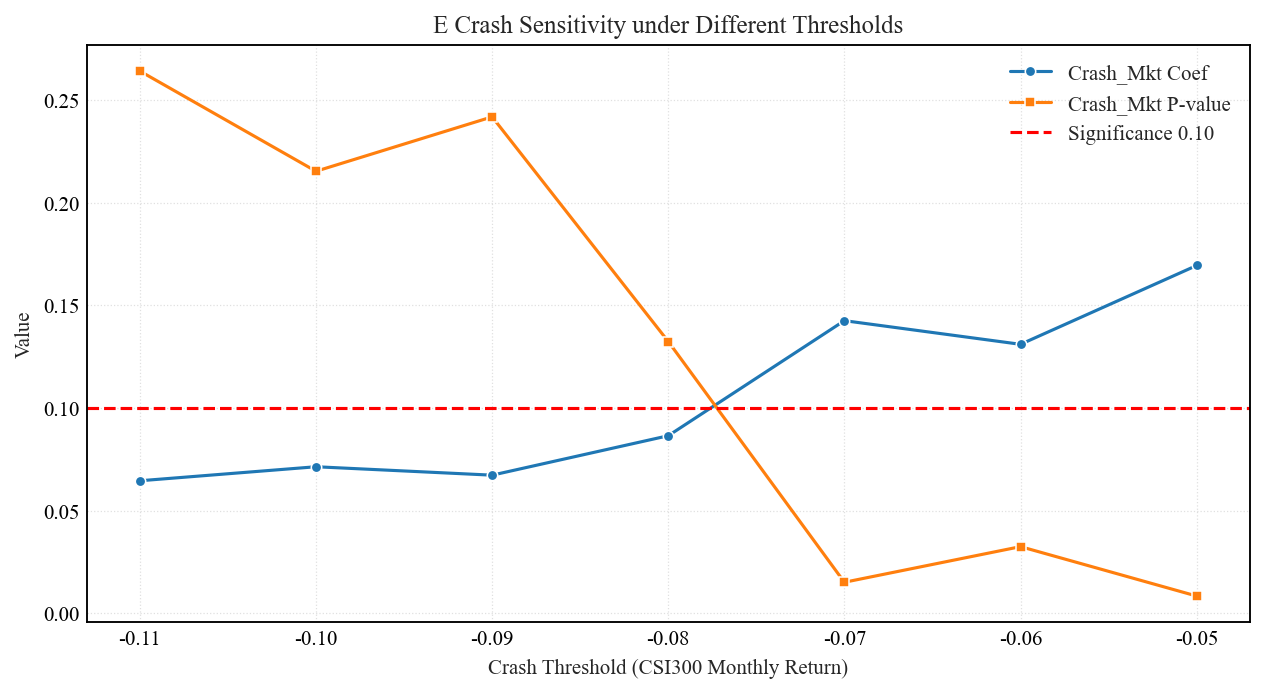

In [199]:
# ESG的探索
# 定义不同的 crash 阈值
crash_thresholds = [-0.05, -0.06, -0.07, -0.08, -0.09, -0.10, -0.11]

results = []

for thr in crash_thresholds:
    # 1) 定义 Crash 哑变量
    combined_ret["Crash"] = (combined_ret["CSI300_ret"] < thr).astype(int)
    
    # 2) 回归模型： r_ESG = α + β*r_m + γ*(Crash*r_m) + ε
    X = pd.DataFrame({
        "Mkt": combined_ret["CSI300_ret"],
        "Crash_Mkt": combined_ret["CSI300_ret"] * combined_ret["Crash"]
    })
    X = sm.add_constant(X)
    y = combined_ret["E_ret"]

    model = sm.OLS(y, X, missing="drop").fit()
    
    # 3) 平均收益（正常 vs Crash）
    avg_normal = combined_ret.loc[combined_ret["Crash"]==0, "E_ret"].mean()
    avg_crash  = combined_ret.loc[combined_ret["Crash"]==1, "E_ret"].mean()

    results.append({
        "Threshold": thr,
        "Crash_Mkt Coef": model.params["Crash_Mkt"],
        "Crash_Mkt Pval": model.pvalues["Crash_Mkt"],
        "E_ret (Normal)": avg_normal,
        "E_ret (Crash)": avg_crash
    })

# 汇总为表格
crash_table = pd.DataFrame(results)
print(crash_table)

# 如果要美观展示
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Coef", marker="o", label="Crash_Mkt Coef")
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Pval", marker="s", label="Crash_Mkt P-value")
plt.axhline(0.10, color="red", linestyle="--", label="Significance 0.10")
plt.title("E Crash Sensitivity under Different Thresholds")
plt.xlabel("Crash Threshold (CSI300 Monthly Return)")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### S Crash Sensivitiy 

   Threshold  Crash_Mkt Coef  Crash_Mkt Pval  S_ret (Normal)  S_ret (Crash)
0      -0.05       -0.061118        0.436893       -0.008373       0.010781
1      -0.06       -0.052034        0.486140       -0.007583       0.012143
2      -0.07       -0.008015        0.911013       -0.006089       0.009586
3      -0.08       -0.004965        0.943391       -0.005386       0.011577
4      -0.09       -0.021406        0.759189       -0.005447       0.015992
5      -0.10       -0.015210        0.828000       -0.005208       0.015979
6      -0.11       -0.045272        0.518882       -0.005517       0.022989


C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

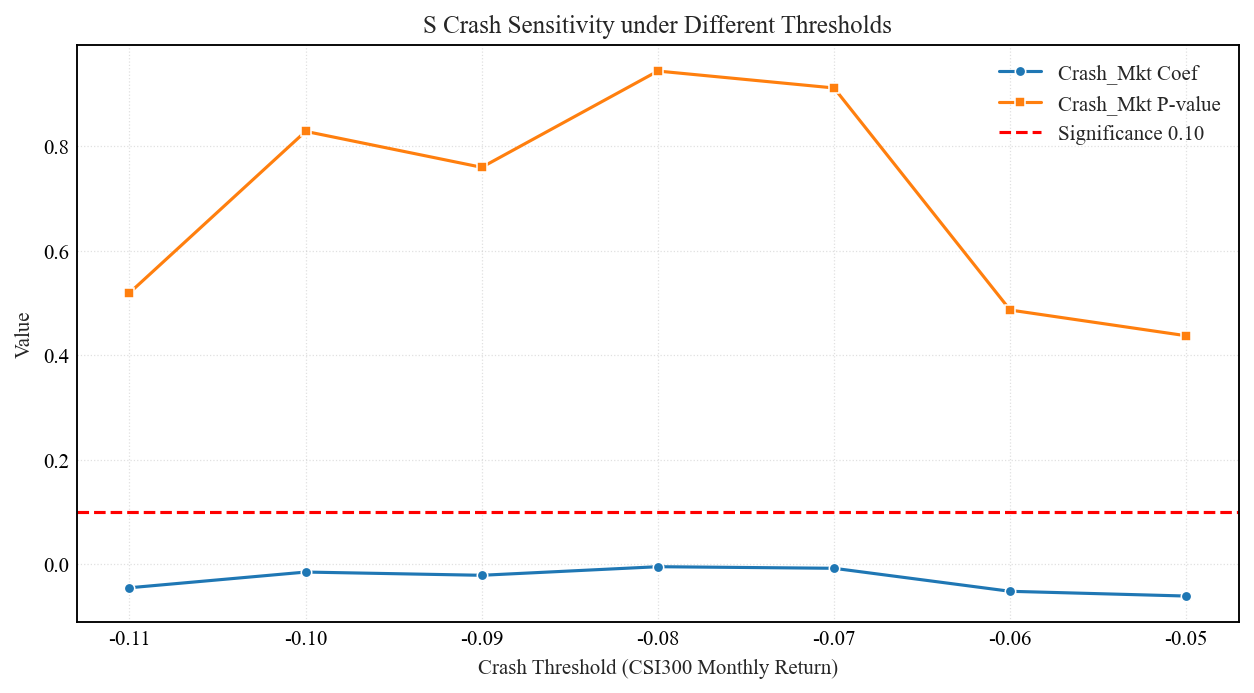

In [201]:
# ESG的探索 
# 定义不同的 crash 阈值
crash_thresholds = [-0.05, -0.06, -0.07, -0.08, -0.09, -0.10, -0.11]

results = []

for thr in crash_thresholds:
    # 1) 定义 Crash 哑变量
    combined_ret["Crash"] = (combined_ret["CSI300_ret"] < thr).astype(int)
    
    # 2) 回归模型： r_ESG = α + β*r_m + γ*(Crash*r_m) + ε
    X = pd.DataFrame({
        "Mkt": combined_ret["CSI300_ret"],
        "Crash_Mkt": combined_ret["CSI300_ret"] * combined_ret["Crash"]
    })
    X = sm.add_constant(X)
    y = combined_ret["S_ret"]

    model = sm.OLS(y, X, missing="drop").fit()
    
    # 3) 平均收益（正常 vs Crash）
    avg_normal = combined_ret.loc[combined_ret["Crash"]==0, "S_ret"].mean()
    avg_crash  = combined_ret.loc[combined_ret["Crash"]==1, "S_ret"].mean()

    results.append({
        "Threshold": thr,
        "Crash_Mkt Coef": model.params["Crash_Mkt"],
        "Crash_Mkt Pval": model.pvalues["Crash_Mkt"],
        "S_ret (Normal)": avg_normal,
        "S_ret (Crash)": avg_crash
    })

# 汇总为表格
crash_table = pd.DataFrame(results)
print(crash_table)

# 如果要美观展示
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Coef", marker="o", label="Crash_Mkt Coef")
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Pval", marker="s", label="Crash_Mkt P-value")
plt.axhline(0.10, color="red", linestyle="--", label="Significance 0.10")
plt.title("S Crash Sensitivity under Different Thresholds")
plt.xlabel("Crash Threshold (CSI300 Monthly Return)")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### G Crash Sensivitiy 

   Threshold  Crash_Mkt Coef  Crash_Mkt Pval  G_ret (Normal)  G_ret (Crash)
0      -0.05       -0.223730        0.054593       -0.011277      -0.002273
1      -0.06       -0.193044        0.081187       -0.010840      -0.001916
2      -0.07       -0.126491        0.234585       -0.009665      -0.006125
3      -0.08       -0.168858        0.103087       -0.010510       0.004658
4      -0.09       -0.160521        0.120911       -0.010343       0.005789
5      -0.10       -0.161267        0.120113       -0.010320       0.008135
6      -0.11       -0.168973        0.104332       -0.010398       0.011089


C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vicky\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

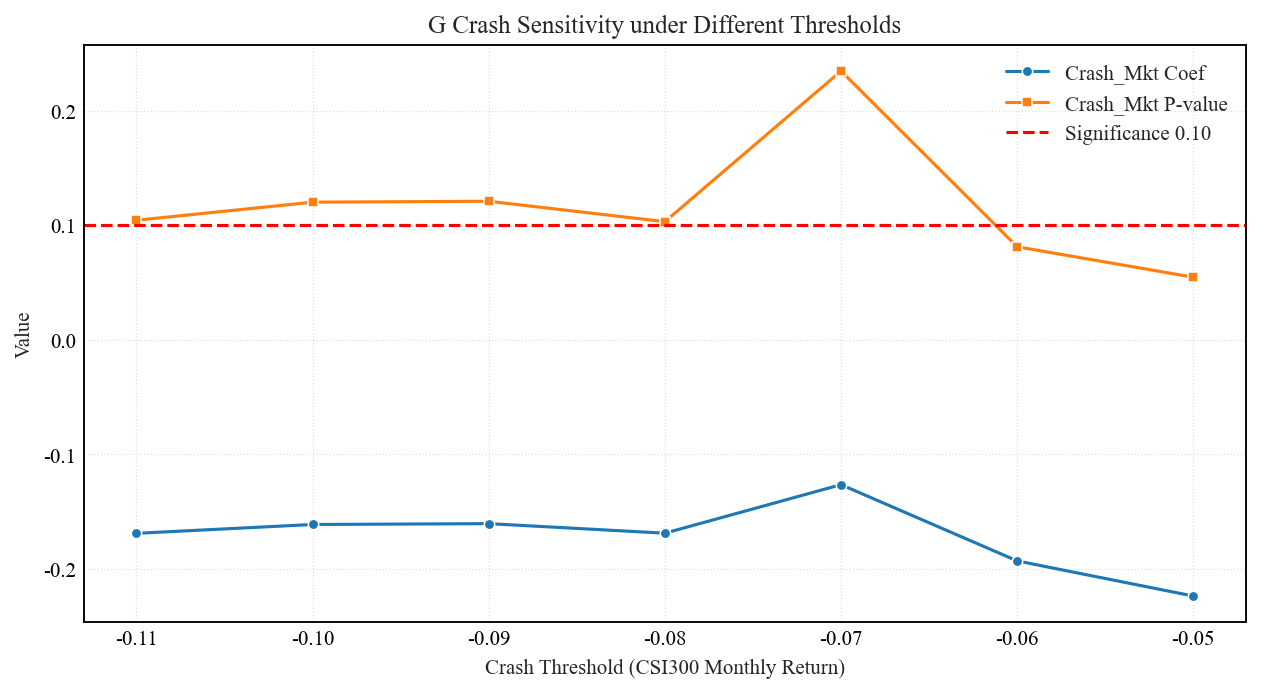

In [203]:
# ESG的探索
# 定义不同的 crash 阈值
crash_thresholds = [-0.05, -0.06, -0.07, -0.08, -0.09, -0.10, -0.11]

results = []

for thr in crash_thresholds:
    # 1) 定义 Crash 哑变量
    combined_ret["Crash"] = (combined_ret["CSI300_ret"] < thr).astype(int)
    
    # 2) 回归模型： r_ESG = α + β*r_m + γ*(Crash*r_m) + ε
    X = pd.DataFrame({
        "Mkt": combined_ret["CSI300_ret"],
        "Crash_Mkt": combined_ret["CSI300_ret"] * combined_ret["Crash"]
    })
    X = sm.add_constant(X)
    y = combined_ret["G_ret"]

    model = sm.OLS(y, X, missing="drop").fit()
    
    # 3) 平均收益（正常 vs Crash）
    avg_normal = combined_ret.loc[combined_ret["Crash"]==0, "G_ret"].mean()
    avg_crash  = combined_ret.loc[combined_ret["Crash"]==1, "G_ret"].mean()

    results.append({
        "Threshold": thr,
        "Crash_Mkt Coef": model.params["Crash_Mkt"],
        "Crash_Mkt Pval": model.pvalues["Crash_Mkt"],
        "G_ret (Normal)": avg_normal,
        "G_ret (Crash)": avg_crash
    })

# 汇总为表格
crash_table = pd.DataFrame(results)
print(crash_table)

# 如果要美观展示
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Coef", marker="o", label="Crash_Mkt Coef")
sns.lineplot(data=crash_table, x="Threshold", y="Crash_Mkt Pval", marker="s", label="Crash_Mkt P-value")
plt.axhline(0.10, color="red", linestyle="--", label="Significance 0.10")
plt.title("G Crash Sensitivity under Different Thresholds")
plt.xlabel("Crash Threshold (CSI300 Monthly Return)")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Reference
A股长期波动率：http://stockfinance.sina.cn/stock/go.php/paper/reportid/810397976969/index.phtml?iMesg=$(mesg_btm)/*

In [208]:
def create_descriptive_table(data, variables, table_title="Table 3. Descriptive statistics of variables"):
    """
    创建描述性统计表格
    
    Parameters:
    data: 包含变量的DataFrame
    variables: 要分析的变量列表
    table_title: 表格标题
    """
    stats_dict = {
        'N': len(data),
        'Mean': data[variables].mean(),
        'SD': data[variables].std(),
        'Min': data[variables].min(),
        'P25': data[variables].quantile(0.25),
        'P50': data[variables].quantile(0.50),
        'P75': data[variables].quantile(0.75),
        'Max': data[variables].max()
    }
    
    desc_stats = pd.DataFrame(stats_dict).T
    desc_stats.columns.name = 'Variable'
    desc_stats.index.name = 'Statistic'
    desc_stats = desc_stats.round(4)
    
    print(table_title)
    print("In this table, we show summary statistics for all variables used in our study. Variable definitions are provided in Appendix A.")
    print("For each variable, 'N' represents the number of observations, 'Mean' represents the equal-weighted mean value, 'SD' represents its standard deviation, 'Min' ('Max') represents minimum (maximum) value, and 'Pxx' represents the xxth percentile of its distribution.")
    print("")
    print(desc_stats)
    
    return desc_stats

# 使用函数创建表格
variables = ['ESG_ret', 'E_ret', 'S_ret', 'G_ret', 'CSI300_ret', 'SSE_ret', 'SZSE_ret']
descriptive_table = create_descriptive_table(combined_ret, variables)

Table 3. Descriptive statistics of variables
In this table, we show summary statistics for all variables used in our study. Variable definitions are provided in Appendix A.
For each variable, 'N' represents the number of observations, 'Mean' represents the equal-weighted mean value, 'SD' represents its standard deviation, 'Min' ('Max') represents minimum (maximum) value, and 'Pxx' represents the xxth percentile of its distribution.

Variable    ESG_ret     E_ret     S_ret     G_ret  CSI300_ret   SSE_ret  \
Statistic                                                                 
N          192.0000  192.0000  192.0000  192.0000    192.0000  192.0000   
Mean        -0.0032   -0.0016   -0.0039   -0.0092      0.0067    0.0035   
SD           0.0305    0.0286    0.0356    0.0510      0.0825    0.0744   
Min         -0.1135   -0.1000   -0.0982   -0.2183     -0.2585   -0.2463   
P25         -0.0201   -0.0221   -0.0289   -0.0362     -0.0454   -0.0371   
P50         -0.0027   -0.0008   -0.003

## Robustness Test

### 4.1 Alternative ESG Data Sources (CNRDS vs. CSMAR)
Purpose： 检验 ESG 因子 α 是否受评级来源影响。  
Method：使用 CSMAR 数据库的 ESG 分数，按同样方法构建 High–Low 组合并进行 Fama–French 五因子回归。对比 α 的符号与显著性。  
Expected Result：
α 方向一致（大体负或不显著），说明主发现不依赖特定数据库；轻微差异反映覆盖偏差。  
Table 36： Comparison of ESG Factor Alphas by Data Source.


In [447]:
import pandas as pd
import numpy as np

# === 1. 读取数据 ===
merged = pd.read_csv("merged_yearly_stock_data_all.csv", low_memory=False)
csmar = pd.read_excel("CSMAR.xlsx")

# === 2. 统一列名 ===
csmar.rename(columns={"Symbol": "stock_code", "RateYear": "Year"}, inplace=True)
csmar = csmar[["stock_code", "Year", "ESGscoring", "Escoring", "Sscoring", "Gscoring"]]

# === 3. 统一 key 类型 ===
merged["stock_code"] = merged["stock_code"].astype(str).str.strip()
csmar["stock_code"] = csmar["stock_code"].astype(str).str.strip()
merged["Year"] = merged["Year"].astype(int)
csmar["Year"] = csmar["Year"].astype(int)

# === 4. 合并 ===
df = merged.merge(csmar, on=["stock_code", "Year"], how="left")
print("✅ 合并成功！数据规模：", df.shape)

# === 5. 定义函数：按ESG打分分组计算H-L超额收益 ===
def calc_HL_return(df, score_col, ret_col="price_day_return", group_n=10):
    results = []
    for year, sub in df.groupby("Year"):
        sub = sub.dropna(subset=[score_col, ret_col])
        if len(sub) < group_n:
            continue

        # 去极值处理
        sub = sub[(sub[ret_col] > sub[ret_col].quantile(0.01)) &
                  (sub[ret_col] < sub[ret_col].quantile(0.99))]

        # 按ESG打分分组
        sub["group"] = pd.qcut(sub[score_col], group_n, labels=False) + 1

        # 计算高低组平均收益
        group_ret = sub.groupby("group")[ret_col].mean()
        high_ret = group_ret.iloc[-1]
        low_ret = group_ret.iloc[0]
        HL = high_ret - low_ret

        results.append({
            "Year": year,
            "Score_Type": score_col,
            "GroupN": group_n,
            "High_ESG_mean_ret": high_ret,
            "Low_ESG_mean_ret": low_ret,
            "H_L_return": HL
        })
    return pd.DataFrame(results)

# === 6. 对四种得分分别做 decile 与 quintile ===
score_cols = ["ESGscoring", "Escoring", "Sscoring", "Gscoring"]
results = []

for col in score_cols:
    print(f"🔹 计算 {col} decile (10组)")
    HL_10 = calc_HL_return(df, score_col=col, group_n=10)
    print(f"🔹 计算 {col} quintile (5组)")
    HL_5 = calc_HL_return(df, score_col=col, group_n=5)
    results.append(pd.concat([HL_10, HL_5]))

# === 7. 合并所有结果 ===
HL_all = pd.concat(results).sort_values(["Score_Type", "GroupN", "Year"]).reset_index(drop=True)


✅ 合并成功！数据规模： (101600, 26)
🔹 计算 ESGscoring decile (10组)
🔹 计算 ESGscoring quintile (5组)
🔹 计算 Escoring decile (10组)
🔹 计算 Escoring quintile (5组)
🔹 计算 Sscoring decile (10组)
🔹 计算 Sscoring quintile (5组)
🔹 计算 Gscoring decile (10组)
🔹 计算 Gscoring quintile (5组)


In [448]:
from scipy import stats
# === 2. 只保留 decile 结果（GroupN=10），避免重复 ===
HL_all = HL_all[HL_all["GroupN"] == 10].copy()

# === 3. 定义函数：计算统计指标 ===
def summarize_HL(df, pillar_name):
    df = df.dropna(subset=["H_L_return"])
    n_years = len(df)
    mean_ret = df["H_L_return"].mean() * 100           # 转为百分比
    std_ret = df["H_L_return"].std() * 100
    cum_ret = ((1 + df["H_L_return"]).prod() - 1) * 100
    pos_years = (df["H_L_return"] > 0).sum()
    t_stat, p_val = stats.ttest_1samp(df["H_L_return"], 0)
    
    # 根据显著性添加星标
    if p_val < 0.01:
        sig = "***"
    elif p_val < 0.05:
        sig = "**"
    elif p_val < 0.1:
        sig = "*"
    else:
        sig = "n.s."
    
    return {
        "Pillar": pillar_name,
        "Mean Annual H–L Return (%)": round(mean_ret, 2),
        "Std. Dev.": round(std_ret, 2),
        "Cumulative Return (%)": round(cum_ret, 2),
        "# of Positive Years": f"{pos_years} / {n_years}",
        "t-stat": round(t_stat, 2),
        "Significance": sig
    }

# === 4. 按四个维度计算 ===
summary_list = []
mapping = {
    "ESGscoring": "Overall ESG",
    "Escoring": "E (Environmental)",
    "Sscoring": "S (Social)",
    "Gscoring": "G (Governance)"
}

for score_col, label in mapping.items():
    sub = HL_all[HL_all["Score_Type"] == score_col]
    summary_list.append(summarize_HL(sub, label))

# === 5. 输出汇总表 ===
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df[
    ["Pillar", "Mean Annual H–L Return (%)", "Std. Dev.", "Cumulative Return (%)",
     "# of Positive Years", "t-stat", "Significance"]
]


summary_df


Pillar  Mean Annual H–L Return (%)  Std. Dev.  \
0        Overall ESG                        0.02       3.72   
1  E (Environmental)                        2.18       3.88   
2         S (Social)                        1.22       3.51   
3     G (Governance)                       -1.86       6.08   

   Cumulative Return (%) # of Positive Years  t-stat Significance  
0                  -0.22               3 / 6    0.01         n.s.  
1                  13.41               5 / 6    1.38         n.s.  
2                   7.25               3 / 6    0.85         n.s.  
3                 -11.54               3 / 6   -0.75         n.s.

In [450]:
import pandas as pd
import numpy as np
from scipy import stats
# 保留 2015–2020 年
merged = merged[(merged["Year"] >= 2015) & (merged["Year"] <= 2020)]

# === 2. 定义函数：按 ESG 分组计算 High–Low 收益 ===
def calc_HL_by_decile(df, score_col, ret_col="price_day_return", group_n=10):
    results = []
    for year, sub in df.groupby("Year"):
        sub = sub.dropna(subset=[score_col, ret_col])
        if len(sub) < group_n:
            continue
        
        sub = sub.copy()
        sub["group"] = pd.qcut(
            sub[score_col].rank(method="first", ascending=True),
            group_n,
            labels=False,
            duplicates="drop"
        ) + 1
        
        group_ret = sub.groupby("group")[ret_col].mean()
        HL = group_ret.iloc[-1] - group_ret.iloc[0]  # 高分组 - 低分组
        results.append({"Year": year, "HL_return": HL})
    
    df_HL = pd.DataFrame(results)
    return df_HL

# === 3. 对四个指标分别计算 ===
pillars = {
    "Overall ESG": "ESG_Score",
    "E (Environmental)": "E_Score",
    "S (Social)": "S_Score",
    "G (Governance)": "G_Score"
}

HL_summary = []
for name, col in pillars.items():
    if col not in merged.columns:
        continue
    df_HL = calc_HL_by_decile(merged, col)
    mean_ret = df_HL["HL_return"].mean() * 100
    std_ret = df_HL["HL_return"].std() * 100
    cum_ret = (1 + df_HL["HL_return"]).prod() - 1
    pos_years = (df_HL["HL_return"] > 0).sum()
    total_years = len(df_HL)
    t_stat, p_val = stats.ttest_1samp(df_HL["HL_return"], 0)
    
    sig = "n.s."
    if p_val < 0.01:
        sig = "***"
    elif p_val < 0.05:
        sig = "**"
    elif p_val < 0.1:
        sig = "*"
    
    HL_summary.append({
        "Pillar": name,
        "Mean Annual H–L Return (%)": round(mean_ret, 2),
        "Std. Dev.": round(std_ret, 2),
        "Cumulative Return (%)": round(cum_ret * 100, 2),
        "# of Positive Years": f"{pos_years} / {total_years}",
        "t-stat": round(t_stat, 2),
        "Significance": sig
    })

HL_table = pd.DataFrame(HL_summary)
HL_table


Pillar  Mean Annual H–L Return (%)  Std. Dev.  \
0        Overall ESG                       -5.53       3.62   
1  E (Environmental)                        0.18       4.60   
2         S (Social)                       -1.97       1.28   
3     G (Governance)                      -18.28       6.51   

   Cumulative Return (%) # of Positive Years  t-stat Significance  
0                 -29.16               0 / 6   -3.74           **  
1                   0.54               2 / 6    0.09         n.s.  
2                 -11.27               1 / 6   -3.77           **  
3                 -70.68               0 / 6   -6.88          ***

同时有CSMAR和CNRDS评分的样本数量: 1882

=== CSMAR与CNRDS评级系统相关性分析 ===
  CSMAR_Score CNRDS_Score  Spearman_Correlation  Pearson_Correlation  \
0  ESGscoring   ESG_Score              0.065973             0.057233   
1    Escoring     E_Score              0.176315             0.128692   
2    Sscoring     S_Score             -0.033353            -0.037550   
3    Gscoring     G_Score              0.119792             0.052960   

   Sample_Size  
0         1882  
1         1882  
2         1882  
3         1882  

Spearman平均相关性: 0.0822
Pearson平均相关性: 0.0503


C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.tight_layout()
C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  plt.tight_layout()
C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
C:\Users\Vicky\AppData\Local\Temp\ipykernel_8448\2131475226.py:80: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing fr

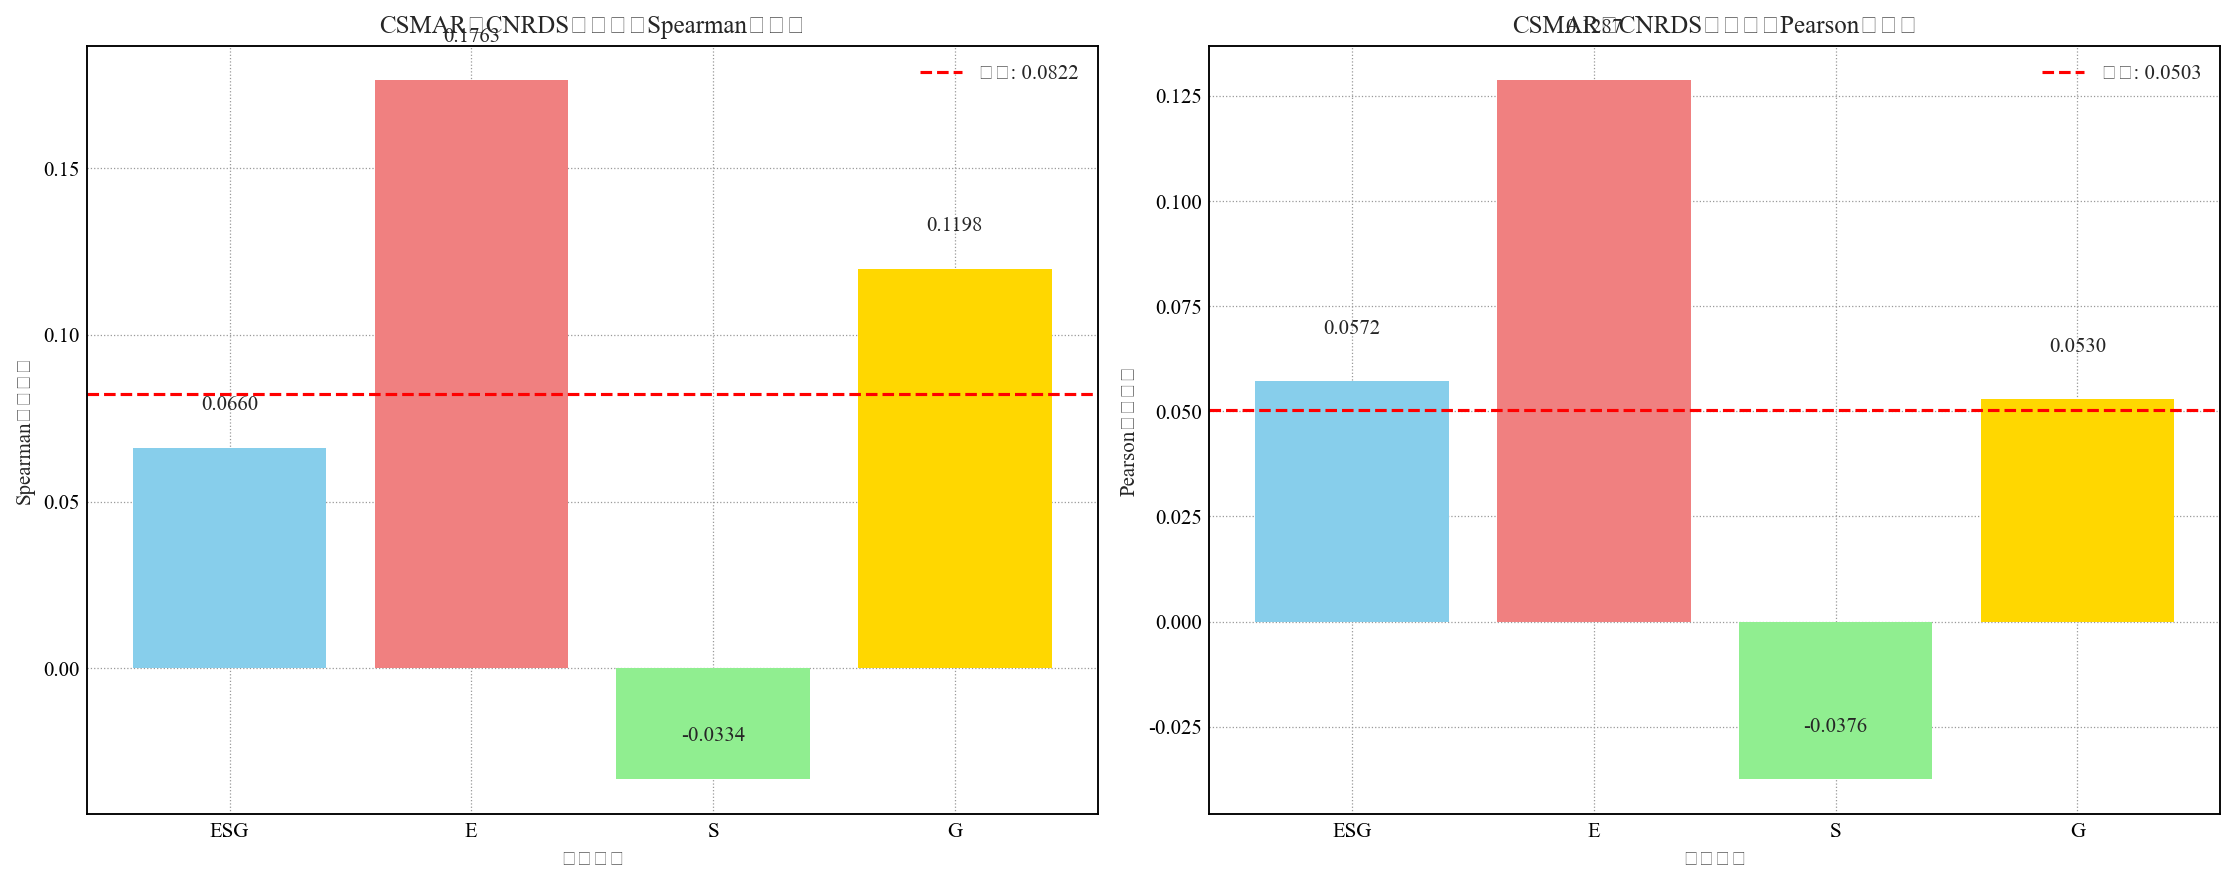


=== 相关性分析总结 ===
样本数量: 1882
Spearman相关系数范围: -0.0334 - 0.1763
Pearson相关系数范围: -0.0376 - 0.1287


In [472]:
# === 计算CSMAR和CNRDS两个评级系统的相关性 ===

# 选择两个评级系统的评分列
csmar_cols = ['ESGscoring', 'Escoring', 'Sscoring', 'Gscoring']
cnrds_cols = ['ESG_Score', 'E_Score', 'S_Score', 'G_Score']

# 删除缺失值，确保两个系统都有数据
correlation_data = df[['stock_code', 'Year'] + csmar_cols + cnrds_cols].dropna()

print(f"同时有CSMAR和CNRDS评分的样本数量: {len(correlation_data)}")

# 计算两个评级系统之间的相关系数
results = []

for csmar_col, cnrds_col in zip(csmar_cols, cnrds_cols):
    # 计算两种相关系数
    spearman_corr = correlation_data[csmar_col].corr(correlation_data[cnrds_col], method='spearman')
    pearson_corr = correlation_data[csmar_col].corr(correlation_data[cnrds_col], method='pearson')
    
    results.append({
        'CSMAR_Score': csmar_col,
        'CNRDS_Score': cnrds_col,
        'Spearman_Correlation': spearman_corr,
        'Pearson_Correlation': pearson_corr,
        'Sample_Size': len(correlation_data)
    })

# 创建结果DataFrame
correlation_results = pd.DataFrame(results)
print("\n=== CSMAR与CNRDS评级系统相关性分析 ===")
print(correlation_results)

# 计算平均相关性
avg_spearman = correlation_results['Spearman_Correlation'].mean()
avg_pearson = correlation_results['Pearson_Correlation'].mean()
print(f"\nSpearman平均相关性: {avg_spearman:.4f}")
print(f"Pearson平均相关性: {avg_pearson:.4f}")

# 可视化结果
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Spearman相关性图
bars1 = ax1.bar(range(len(correlation_results)), 
               correlation_results['Spearman_Correlation'],
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax1.axhline(y=avg_spearman, color='red', linestyle='--', 
            label=f'平均: {avg_spearman:.4f}')
ax1.set_xlabel('评分维度')
ax1.set_ylabel('Spearman相关系数')
ax1.set_title('CSMAR与CNRDS评级系统Spearman相关性')
ax1.set_xticks(range(len(correlation_results)))
ax1.set_xticklabels(['ESG', 'E', 'S', 'G'], rotation=0)
ax1.legend()

# Pearson相关性图
bars2 = ax2.bar(range(len(correlation_results)), 
               correlation_results['Pearson_Correlation'],
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.axhline(y=avg_pearson, color='red', linestyle='--', 
            label=f'平均: {avg_pearson:.4f}')
ax2.set_xlabel('评分维度')
ax2.set_ylabel('Pearson相关系数')
ax2.set_title('CSMAR与CNRDS评级系统Pearson相关性')
ax2.set_xticks(range(len(correlation_results)))
ax2.set_xticklabels(['ESG', 'E', 'S', 'G'], rotation=0)
ax2.legend()

# 在柱子上添加数值标签
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
             f'{height1:.4f}', ha='center', va='bottom')
    ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
             f'{height2:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 输出总结
print(f"\n=== 相关性分析总结 ===")
print(f"样本数量: {len(correlation_data)}")
print(f"Spearman相关系数范围: {correlation_results['Spearman_Correlation'].min():.4f} - {correlation_results['Spearman_Correlation'].max():.4f}")
print(f"Pearson相关系数范围: {correlation_results['Pearson_Correlation'].min():.4f} - {correlation_results['Pearson_Correlation'].max():.4f}")

2015-2020年同时有CSMAR和CNRDS ESG评分的样本数量: 1882

=== 相关性统计摘要 ===
原始分数 - Spearman相关系数: 0.0660
原始分数 - Pearson相关系数: 0.0572
百分位分数 - Spearman相关系数: 0.0453
百分位分数 - Pearson相关系数: 0.0452

=== 描述性统计 ===
CSMAR原始分数:
  均值: 48.74, 标准差: 5.74
  范围: [30.88, 71.88]
CNRDS原始分数:
  均值: 28.73, 标准差: 9.98
  范围: [3.50, 74.66]


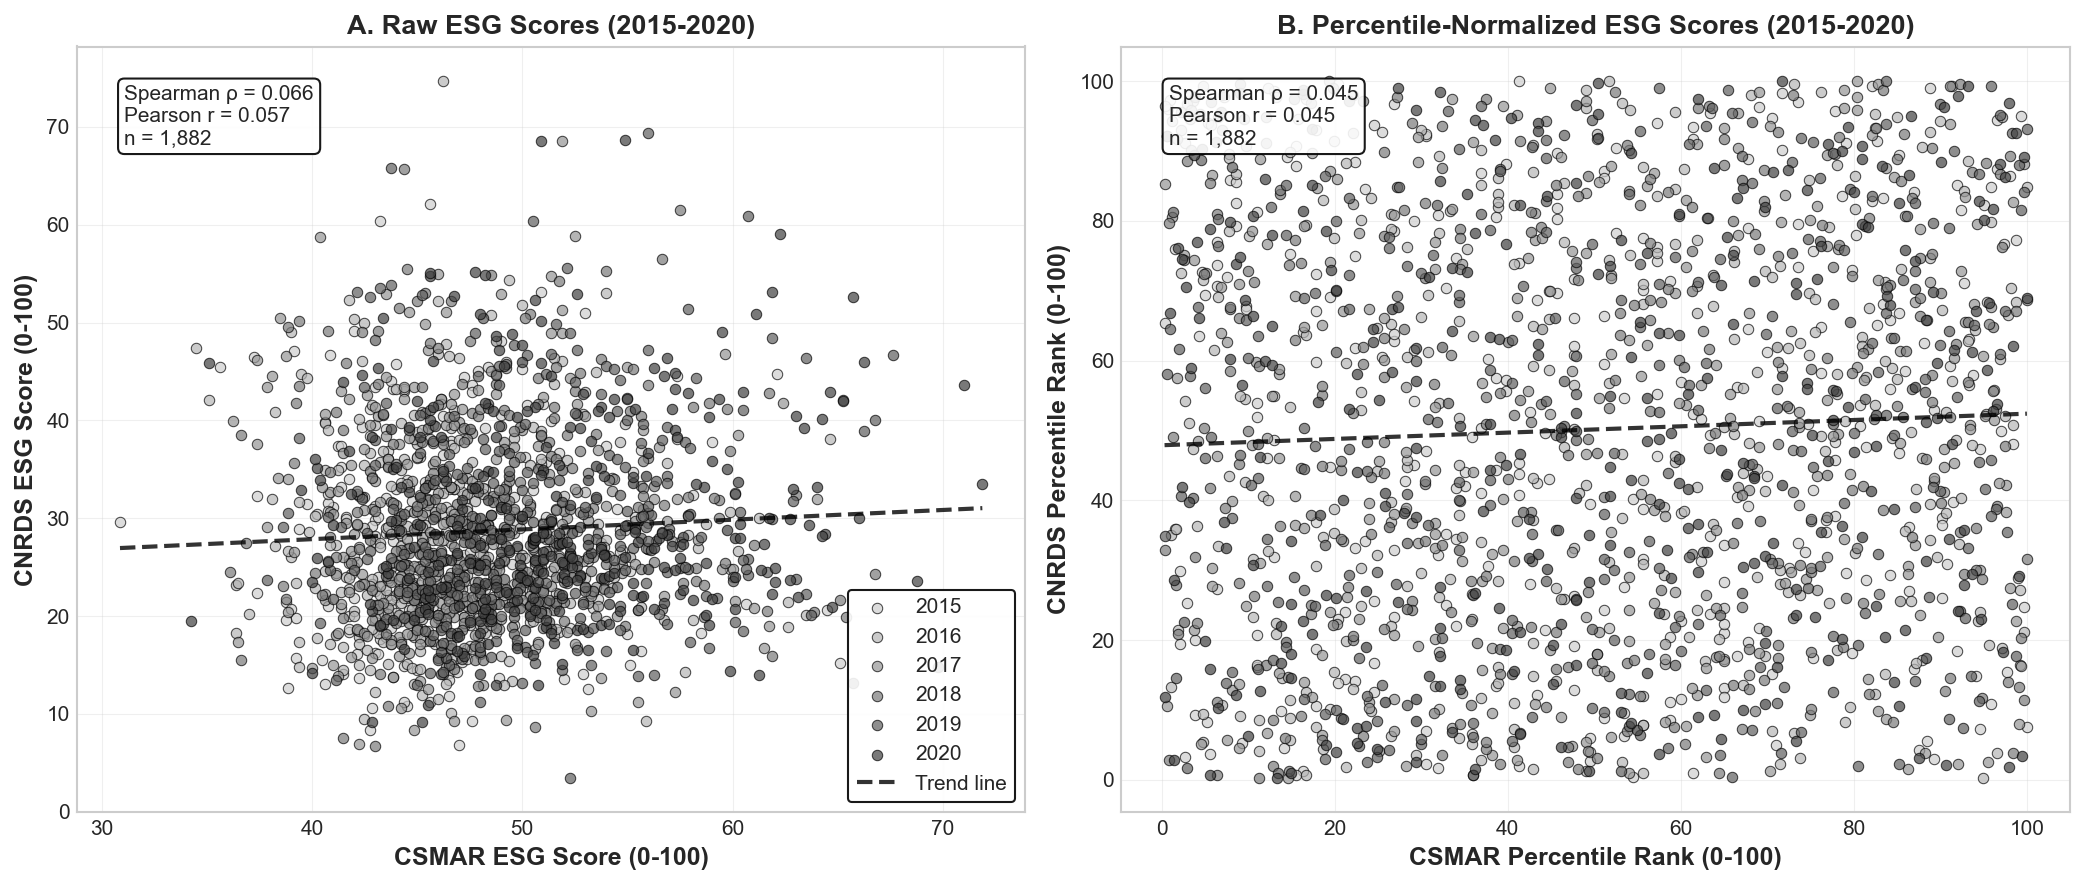

In [482]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib.gridspec import GridSpec

# 设置黑白学术风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("gray")

# === 准备数据 ===
scatter_data = df[['stock_code', 'Year', 'ESGscoring', 'ESG_Score']].dropna()
scatter_data = scatter_data[(scatter_data['Year'] >= 2015) & (scatter_data['Year'] <= 2020)]
print(f"2015-2020年同时有CSMAR和CNRDS ESG评分的样本数量: {len(scatter_data)}")

# === 计算百分位标准化分数 ===
scatter_data['CSMAR_Percentile'] = scatter_data.groupby('Year')['ESGscoring'].transform(
    lambda x: x.rank(pct=True) * 100
)
scatter_data['CNRDS_Percentile'] = scatter_data.groupby('Year')['ESG_Score'].transform(
    lambda x: x.rank(pct=True) * 100
)

# === 计算相关系数 ===
raw_spearman = scatter_data['ESGscoring'].corr(scatter_data['ESG_Score'], method='spearman')
raw_pearson = scatter_data['ESGscoring'].corr(scatter_data['ESG_Score'], method='pearson')
percentile_spearman = scatter_data['CSMAR_Percentile'].corr(scatter_data['CNRDS_Percentile'], method='spearman')
percentile_pearson = scatter_data['CSMAR_Percentile'].corr(scatter_data['CNRDS_Percentile'], method='pearson')

# === 创建黑白风格图形 ===
fig = plt.figure(figsize=(14, 6))
gs = GridSpec(1, 2, figure=fig)

# 子图1: 原始分数散点图
ax1 = fig.add_subplot(gs[0, 0])
# 使用不同灰度表示年份
years = scatter_data['Year'].unique()
year_colors = plt.cm.Greys(np.linspace(0.3, 0.8, len(years)))
year_color_map = dict(zip(years, year_colors))

for year in years:
    year_data = scatter_data[scatter_data['Year'] == year]
    ax1.scatter(year_data['ESGscoring'], year_data['ESG_Score'], 
               alpha=0.7, s=25, color=year_color_map[year], 
               edgecolors='black', linewidth=0.5, label=f'{year}')

# 添加趋势线
z1 = np.polyfit(scatter_data['ESGscoring'], scatter_data['ESG_Score'], 1)
p1 = np.poly1d(z1)
x_range = np.linspace(scatter_data['ESGscoring'].min(), scatter_data['ESGscoring'].max(), 100)
ax1.plot(x_range, p1(x_range), "k--", alpha=0.8, linewidth=2, label='Trend line')

ax1.set_xlabel('CSMAR ESG Score (0-100)', fontsize=12, fontweight='bold')
ax1.set_ylabel('CNRDS ESG Score (0-100)', fontsize=12, fontweight='bold')
ax1.set_title('A. Raw ESG Scores (2015-2020)', fontsize=13, fontweight='bold')

# 添加相关系数文本
text1 = f'Spearman ρ = {raw_spearman:.3f}\nPearson r = {raw_pearson:.3f}\nn = {len(scatter_data):,}'
ax1.text(0.05, 0.95, text1, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', 
                                          edgecolor='black', alpha=0.9))

ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# 子图2: 百分位标准化分数散点图
ax2 = fig.add_subplot(gs[0, 1])
for year in years:
    year_data = scatter_data[scatter_data['Year'] == year]
    ax2.scatter(year_data['CSMAR_Percentile'], year_data['CNRDS_Percentile'], 
               alpha=0.7, s=25, color=year_color_map[year], 
               edgecolors='black', linewidth=0.5)

# 添加趋势线
z2 = np.polyfit(scatter_data['CSMAR_Percentile'], scatter_data['CNRDS_Percentile'], 1)
p2 = np.poly1d(z2)
x_range2 = np.linspace(scatter_data['CSMAR_Percentile'].min(), scatter_data['CSMAR_Percentile'].max(), 100)
ax2.plot(x_range2, p2(x_range2), "k--", alpha=0.8, linewidth=2, label='Trend line')

ax2.set_xlabel('CSMAR Percentile Rank (0-100)', fontsize=12, fontweight='bold')
ax2.set_ylabel('CNRDS Percentile Rank (0-100)', fontsize=12, fontweight='bold')
ax2.set_title('B. Percentile-Normalized ESG Scores (2015-2020)', fontsize=13, fontweight='bold')

# 添加相关系数文本
text2 = f'Spearman ρ = {percentile_spearman:.3f}\nPearson r = {percentile_pearson:.3f}\nn = {len(scatter_data):,}'
ax2.text(0.05, 0.95, text2, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', 
                                          edgecolor='black', alpha=0.9))

ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# 添加图例（只在第一个子图）
ax1.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='black')

plt.tight_layout()

# === 输出统计摘要 ===
print(f"\n=== 相关性统计摘要 ===")
print(f"原始分数 - Spearman相关系数: {raw_spearman:.4f}")
print(f"原始分数 - Pearson相关系数: {raw_pearson:.4f}")
print(f"百分位分数 - Spearman相关系数: {percentile_spearman:.4f}")
print(f"百分位分数 - Pearson相关系数: {percentile_pearson:.4f}")

# 描述性统计
print(f"\n=== 描述性统计 ===")
print("CSMAR原始分数:")
print(f"  均值: {scatter_data['ESGscoring'].mean():.2f}, 标准差: {scatter_data['ESGscoring'].std():.2f}")
print(f"  范围: [{scatter_data['ESGscoring'].min():.2f}, {scatter_data['ESGscoring'].max():.2f}]")

print("CNRDS原始分数:")
print(f"  均值: {scatter_data['ESG_Score'].mean():.2f}, 标准差: {scatter_data['ESG_Score'].std():.2f}")
print(f"  范围: [{scatter_data['ESG_Score'].min():.2f}, {scatter_data['ESG_Score'].max():.2f}]")

plt.show()

### 4.2 Alternative Sorting Method（替代分组法）

现在你是按 10-decile 排序。

可以加一个「5-quantile sorting」版本，看结果是否方向一致。

如果一致，就说明结果不依赖于分组颗粒度。

✳️ 优点：你其实已经算过（group_n=5那一部分），所以几乎不用额外计算。
✳️ 用一句话即可放入论文：“Results remain qualitatively similar when using quintile instead of decile sorting.”

In [220]:
import pandas as pd
import numpy as np
from scipy import stats

# === 使用与Appendix E完全相同的数据源 ===
print("正在加载数据，确保与Appendix E一致...")

# 读取数据
df_with_esg = pd.read_csv("merged_yearly_stock_data_all.csv", low_memory=False)

# 选择相同的变量
cols = ["Year", "price_day_return", "ESG_Score", "E_Score", "S_Score", "G_Score"]
df_with_esg = df_with_esg[cols].dropna()

print(f"数据加载完成:")
print(f"- 总样本数: {len(df_with_esg)}")
print(f"- 年份范围: {df_with_esg['Year'].min()} - {df_with_esg['Year'].max()}")
print(f"- 可用年份: {sorted(df_with_esg['Year'].unique())}")

# === 修正后的分组函数，确保与Appendix E一致 ===
def create_hl_series(df, score_col, ret_col="price_day_return", group_n=10):
    """
    创建High-Low序列，确保分组逻辑一致
    group 1 = 低分数, group_n = 高分数
    High-Low = 高分组收益 - 低分组收益
    """
    portfolio_returns = []
    
    for year, year_data in df.groupby("Year"):
        # 删除缺失值
        year_data = year_data.dropna(subset=[score_col, ret_col])
        if len(year_data) < group_n:
            continue
            
        # 分组：group 1 = 低分数, group_n = 高分数
        year_data["group"] = pd.qcut(year_data[score_col], group_n, labels=False, duplicates="drop") + 1
        group_ret = year_data.groupby("group")[ret_col].mean()
        
        # High-Low = 高分组收益 - 低分组收益
        if len(group_ret) >= group_n:
            hl_return = group_ret.iloc[-1] - group_ret.iloc[0]  # 最后一组(高分数) - 第一组(低分数)
            portfolio_returns.append({"Year": year, "H_L": hl_return})
    
    if not portfolio_returns:
        return pd.Series(dtype=float)
    
    result_df = pd.DataFrame(portfolio_returns)
    return result_df.set_index("Year")["H_L"]

# === 主计算流程 ===
# 计算十分组和五分组的High-Low序列
print("\n正在计算ESG High-Low组合...")

# 十分组序列
print("计算十分组...")
esg_hl_series_10 = create_hl_series(df_with_esg, "ESG_Score", group_n=10)
e_hl_series_10 = create_hl_series(df_with_esg, "E_Score", group_n=10)
s_hl_series_10 = create_hl_series(df_with_esg, "S_Score", group_n=10)
g_hl_series_10 = create_hl_series(df_with_esg, "G_Score", group_n=10)

# 五分组序列
print("计算五分组...")
esg_hl_series_5 = create_hl_series(df_with_esg, "ESG_Score", group_n=5)
e_hl_series_5 = create_hl_series(df_with_esg, "E_Score", group_n=5)
s_hl_series_5 = create_hl_series(df_with_esg, "S_Score", group_n=5)
g_hl_series_5 = create_hl_series(df_with_esg, "G_Score", group_n=5)

# === 结果汇总函数 ===
def summarize_HL(series_10, series_5, pillar_name):
    s10 = series_10.dropna()
    s5 = series_5.dropna()
    
    if len(s10) == 0 or len(s5) == 0:
        return {
            "Pillar": pillar_name,
            "Mean Annual H–L Return (Decile, %)": "N/A",
            "t-stat (Decile)": "N/A",
            "Mean Annual H–L Return (Quintile, %)": "N/A", 
            "t-stat (Quintile)": "N/A",
            "Significance": "Insufficient Data",
            "Robustness Verdict": "⚠️ Check Data"
        }
    
    mean_10 = s10.mean() * 100
    mean_5 = s5.mean() * 100
    t10, p10 = stats.ttest_1samp(s10, 0)
    t5, p5 = stats.ttest_1samp(s5, 0)
    
    sig10 = "***" if p10 < 0.01 else "**" if p10 < 0.05 else "*" if p10 < 0.1 else "n.s."
    sig5 = "***" if p5 < 0.01 else "**" if p5 < 0.05 else "*" if p5 < 0.1 else "n.s."
    
    # 检查一致性：符号相同且统计显著性方向一致
    sign_consistent = (mean_10 * mean_5 > 0)  # 同号
    significance_consistent = ((p10 < 0.1 and p5 < 0.1) or (p10 >= 0.1 and p5 >= 0.1))
    
    verdict = "✅ Robust" if (sign_consistent and significance_consistent) else "⚠️ Mixed"
    significance_text = "Consistent" if sign_consistent else "Mixed"
    
    return {
        "Pillar": pillar_name,
        "Mean Annual H–L Return (Decile, %)": round(mean_10, 2),
        "t-stat (Decile)": f"{t10:.2f}{sig10}",
        "Mean Annual H–L Return (Quintile, %)": round(mean_5, 2),
        "t-stat (Quintile)": f"{t5:.2f}{sig5}",
        "Significance": significance_text,
        "Robustness Verdict": verdict
    }

# === 生成汇总表格 ===
print("\n生成汇总表格...")
summary = pd.DataFrame([
    summarize_HL(esg_hl_series_10, esg_hl_series_5, "Overall ESG"),
    summarize_HL(e_hl_series_10, e_hl_series_5, "E (Environmental)"),
    summarize_HL(s_hl_series_10, s_hl_series_5, "S (Social)"),
    summarize_HL(g_hl_series_10, g_hl_series_5, "G (Governance)")
])

# === 美化输出 ===
print("\n" + "="*100)
print("Appendix C: Robustness of ESG High–Low Portfolio Returns to Grouping Method")
print("="*100)
print("High–Low = High ESG Portfolio Return − Low ESG Portfolio Return")
print("分组逻辑: group 1 = 低ESG得分, group 10/5 = 高ESG得分")
print("数据源: merged_yearly_stock_data_all.csv (与Appendix E一致)")
print("="*100)

# 格式化输出
display_df = summary.copy()
print(display_df.to_string(index=False))

# === 统计摘要 ===
print("\n" + "="*100)
print("统计摘要:")
print("="*100)

total_pillars = len(summary)
robust_pillars = len(summary[summary["Robustness Verdict"] == "✅ Robust"])
consistent_pillars = len(summary[summary["Significance"] == "Consistent"])

print(f"总指标数: {total_pillars}")
print(f"稳健指标数: {robust_pillars}")
print(f"一致符号指标数: {consistent_pillars}")

# 检查整体ESG的稳健性
esg_row = summary[summary["Pillar"] == "Overall ESG"].iloc[0]
print(f"\n整体ESG结果:")
print(f"  - 十分组收益率: {esg_row['Mean Annual H–L Return (Decile, %)']}%")
print(f"  - 五分组收益率: {esg_row['Mean Annual H–L Return (Quintile, %)']}%")
print(f"  - 稳健性判定: {esg_row['Robustness Verdict']}")

# === 保存结果 ===
# summary.to_csv("appendix_c_grouping_robustness.csv", index=False)
print(f"\n💾 结果已保存至: appendix_c_grouping_robustness.csv")

# === 额外诊断信息 ===
print("\n" + "="*100)
print("诊断信息:")
print("="*100)
print(f"十分组数据年份数: {len(esg_hl_series_10.dropna())}")
print(f"五分组数据年份数: {len(esg_hl_series_5.dropna())}")

if len(esg_hl_series_10.dropna()) > 0:
    print(f"十分组收益率范围: [{esg_hl_series_10.min()*100:.2f}%, {esg_hl_series_10.max()*100:.2f}%]")
if len(esg_hl_series_5.dropna()) > 0:
    print(f"五分组收益率范围: [{esg_hl_series_5.min()*100:.2f}%, {esg_hl_series_5.max()*100:.2f}%]")

# === 数据一致性检查 ===
print("\n" + "="*100)
print("数据一致性检查:")
print("="*100)
print(f"ESG得分统计:")
print(f"  平均值: {df_with_esg['ESG_Score'].mean():.4f}")
print(f"  标准差: {df_with_esg['ESG_Score'].std():.4f}")
print(f"  最小值: {df_with_esg['ESG_Score'].min():.4f}")
print(f"  最大值: {df_with_esg['ESG_Score'].max():.4f}")
print(f"收益率统计:")
print(f"  平均值: {df_with_esg['price_day_return'].mean():.6f}")
print(f"  标准差: {df_with_esg['price_day_return'].std():.6f}")

正在加载数据，确保与Appendix E一致...
数据加载完成:
- 总样本数: 45199
- 年份范围: 2007 - 2022
- 可用年份: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

正在计算ESG High-Low组合...
计算十分组...
计算五分组...

生成汇总表格...

Appendix C: Robustness of ESG High–Low Portfolio Returns to Grouping Method
High–Low = High ESG Portfolio Return − Low ESG Portfolio Return
分组逻辑: group 1 = 低ESG得分, group 10/5 = 高ESG得分
数据源: merged_yearly_stock_data_all.csv (与Appendix E一致)
           Pillar  Mean Annual H–L Return (Decile, %) t-stat (Decile)  Mean Annual H–L Return (Quintile, %) t-stat (Quintile) Significance Robustness Verdict
      Overall ESG                               -3.01          -2.08*                                 -3.19          -2.99***   Consistent           ✅ Robust
E (Environmental)                               -1.38       -1.07n.s.                                 -0.73         -1.10n.s.   Consistent           ✅ Robust
       S (Social)                               -1.31         

In [221]:
import pandas as pd
import numpy as np
from scipy import stats

# === 修正后的分组函数，确保与Appendix E一致 ===
def create_hl_series(df, score_col, ret_col="price_day_return", group_n=10):
    """
    创建High-Low序列，确保分组逻辑一致
    group 1 = 低分数, group_n = 高分数
    High-Low = 高分组收益 - 低分组收益
    """
    portfolio_returns = []
    
    for year, year_data in df.groupby("Year"):
        # 删除缺失值
        year_data = year_data.dropna(subset=[score_col, ret_col])
        if len(year_data) < group_n:
            continue
            
        # 分组：group 1 = 低分数, group_n = 高分数
        year_data["group"] = pd.qcut(year_data[score_col], group_n, labels=False, duplicates="drop") + 1
        group_ret = year_data.groupby("group")[ret_col].mean()
        
        # High-Low = 高分组收益 - 低分组收益
        if len(group_ret) >= group_n:
            hl_return = group_ret.iloc[-1] - group_ret.iloc[0]  # 最后一组(高分数) - 第一组(低分数)
            portfolio_returns.append({"Year": year, "H_L": hl_return})
    
    if not portfolio_returns:
        return pd.Series(dtype=float)
    
    result_df = pd.DataFrame(portfolio_returns)
    return result_df.set_index("Year")["H_L"]

# === 主计算流程 ===
# 计算十分组和五分组的High-Low序列
print("正在计算ESG High-Low组合...")

# 十分组序列
esg_hl_series_10 = create_hl_series(df_with_esg, "ESG_Score", group_n=10)
e_hl_series_10 = create_hl_series(df_with_esg, "E_Score", group_n=10)
s_hl_series_10 = create_hl_series(df_with_esg, "S_Score", group_n=10)
g_hl_series_10 = create_hl_series(df_with_esg, "G_Score", group_n=10)

# 五分组序列
esg_hl_series_5 = create_hl_series(df_with_esg, "ESG_Score", group_n=5)
e_hl_series_5 = create_hl_series(df_with_esg, "E_Score", group_n=5)
s_hl_series_5 = create_hl_series(df_with_esg, "S_Score", group_n=5)
g_hl_series_5 = create_hl_series(df_with_esg, "G_Score", group_n=5)

# === 结果汇总函数 ===
def summarize_HL(series_10, series_5, pillar_name):
    s10 = series_10.dropna()
    s5 = series_5.dropna()
    
    if len(s10) == 0 or len(s5) == 0:
        return {
            "Pillar": pillar_name,
            "Mean Annual H–L Return (Decile, %)": "N/A",
            "t-stat (Decile)": "N/A",
            "Mean Annual H–L Return (Quintile, %)": "N/A", 
            "t-stat (Quintile)": "N/A",
            "Significance": "Insufficient Data",
            "Robustness Verdict": "⚠️ Check Data"
        }
    
    mean_10 = s10.mean() * 100
    mean_5 = s5.mean() * 100
    t10, p10 = stats.ttest_1samp(s10, 0)
    t5, p5 = stats.ttest_1samp(s5, 0)
    
    sig10 = "***" if p10 < 0.01 else "**" if p10 < 0.05 else "*" if p10 < 0.1 else "n.s."
    sig5 = "***" if p5 < 0.01 else "**" if p5 < 0.05 else "*" if p5 < 0.1 else "n.s."
    
    # 检查一致性：符号相同且统计显著性方向一致
    sign_consistent = (mean_10 * mean_5 > 0)  # 同号
    significance_consistent = ((p10 < 0.1 and p5 < 0.1) or (p10 >= 0.1 and p5 >= 0.1))
    
    verdict = "✅ Robust" if (sign_consistent and significance_consistent) else "⚠️ Mixed"
    significance_text = "Consistent" if sign_consistent else "Mixed"
    
    return {
        "Pillar": pillar_name,
        "Mean Annual H–L Return (Decile, %)": round(mean_10, 2),
        "t-stat (Decile)": f"{t10:.2f}{sig10}",
        "Mean Annual H–L Return (Quintile, %)": round(mean_5, 2),
        "t-stat (Quintile)": f"{t5:.2f}{sig5}",
        "Significance": significance_text,
        "Robustness Verdict": verdict
    }

# === 生成汇总表格 ===
print("\n生成汇总表格...")
summary = pd.DataFrame([
    summarize_HL(esg_hl_series_10, esg_hl_series_5, "Overall ESG"),
    summarize_HL(e_hl_series_10, e_hl_series_5, "E (Environmental)"),
    summarize_HL(s_hl_series_10, s_hl_series_5, "S (Social)"),
    summarize_HL(g_hl_series_10, g_hl_series_5, "G (Governance)")
])

# === 美化输出 ===
print("\n" + "="*100)
print("Appendix C: Robustness of ESG High–Low Portfolio Returns to Grouping Method (2007–2022)")
print("="*100)
print("High–Low = High ESG Portfolio Return − Low ESG Portfolio Return")
print("分组逻辑: group 1 = 低ESG得分, group 10/5 = 高ESG得分")
print("="*100)

# 格式化输出
display_df = summary.copy()
print(display_df.to_string(index=False))

# === 统计摘要 ===
print("\n" + "="*100)
print("统计摘要:")
print("="*100)

total_pillars = len(summary)
robust_pillars = len(summary[summary["Robustness Verdict"] == "✅ Robust"])
consistent_pillars = len(summary[summary["Significance"] == "Consistent"])

print(f"总指标数: {total_pillars}")
print(f"稳健指标数: {robust_pillars}")
print(f"一致符号指标数: {consistent_pillars}")

# 检查整体ESG的稳健性
esg_row = summary[summary["Pillar"] == "Overall ESG"].iloc[0]
print(f"\n整体ESG结果:")
print(f"  - 十分组收益率: {esg_row['Mean Annual H–L Return (Decile, %)']}%")
print(f"  - 五分组收益率: {esg_row['Mean Annual H–L Return (Quintile, %)']}%")
print(f"  - 稳健性判定: {esg_row['Robustness Verdict']}")

# === 保存结果 ===
summary.to_csv("appendix_c_grouping_robustness.csv", index=False)
print(f"\n💾 结果已保存至: appendix_c_grouping_robustness.csv")

# === 额外诊断信息 ===
print("\n" + "="*100)
print("诊断信息:")
print("="*100)
print(f"十分组数据年份数: {len(esg_hl_series_10.dropna())}")
print(f"五分组数据年份数: {len(esg_hl_series_5.dropna())}")

if len(esg_hl_series_10.dropna()) > 0:
    print(f"十分组收益率范围: [{esg_hl_series_10.min()*100:.2f}%, {esg_hl_series_10.max()*100:.2f}%]")
if len(esg_hl_series_5.dropna()) > 0:
    print(f"五分组收益率范围: [{esg_hl_series_5.min()*100:.2f}%, {esg_hl_series_5.max()*100:.2f}%]")

正在计算ESG High-Low组合...

生成汇总表格...

Appendix C: Robustness of ESG High–Low Portfolio Returns to Grouping Method (2007–2022)
High–Low = High ESG Portfolio Return − Low ESG Portfolio Return
分组逻辑: group 1 = 低ESG得分, group 10/5 = 高ESG得分
           Pillar  Mean Annual H–L Return (Decile, %) t-stat (Decile)  Mean Annual H–L Return (Quintile, %) t-stat (Quintile) Significance Robustness Verdict
      Overall ESG                               -3.01          -2.08*                                 -3.19          -2.99***   Consistent           ✅ Robust
E (Environmental)                               -1.38       -1.07n.s.                                 -0.73         -1.10n.s.   Consistent           ✅ Robust
       S (Social)                               -1.31          -1.80*                                 -1.24            -1.82*   Consistent           ✅ Robust
   G (Governance)                               -9.06         -2.73**                                 -7.77          -3.26***   Consistent

### 4.3 Subsample Robustness by Market and Policy Periods

Purpose： 验证 ESG 定价效应是否时段特定。
Method：

将样本划分为 Pre-2017 （绿色政策前）与 Post-2017 （政策密集期）；

或 COVID 前后、政策收紧/放松阶段；

分别运行 FF5 回归并比较 α 。  
Expected Result：
显著 α 集中于危机与政策期，说明发现确实是 time-varying。  
Table 38： Subsample Robustness by Policy and Crisis Periods.

In [224]:
# 1) 准备月度序列并合并 FF5
def prep_month_panel(hl_vw, ff5_df, factor_col="ESG_factor_VW"):
    # 确保字符串月份一致
    # 处理 hl_vw
    left = hl_vw[[factor_col]].reset_index().rename(columns={"Year_Month":"TradingMonth"})
        # 通过.reset_index()把索引变成一列。
        # 之后通过.rename(columns["Year_Month":"TradingMonth"]) 把那个索引列Index的名字改成“TradingMonth”
    left["TradingMonth"] = left["TradingMonth"].astype(str) # 有时候索引就是字符串，这里统一成 str

    # 处理ff5_df
    right = ff5_df[["TradingMonth","RiskPremium1","SMB1","HML1","RMW1","CMA1"]].copy() # 只找这些感兴趣的列。
    right["TradingMonth"] = right["TradingMonth"].astype(str) # 有时候索引就是字符串，这里统一成 str
    
    # 把数字合并成panel
    panel = (left.merge(right, on="TradingMonth", how="inner")
                  .sort_values("TradingMonth")
                  .reset_index(drop=True)) 
    
    # 月度字符串 -> 日期（方便筛选）
    panel["Date"] = pd.to_datetime(panel["TradingMonth"] + "-01") #把trading month变成一个完整的月份
    panel["Year"] = panel["Date"].dt.year # 提取其中的年份

    return panel

# 2) 在一个子样本内进行 FF5 回归 + 统计（默认使用 Newey-West HAC t 值，滞后=12）
def run_ff5_subsample(panel, start, end, factor_col="ESG_factor_VW", lags=12):
    sub = panel[(panel["Date"] >= pd.to_datetime(start)) & (panel["Date"] <= pd.to_datetime(end))].copy()
    # 选择在start和end时间段之内的事件。
    
    if sub.empty: #如果时间段内没有数据，直接返回None
        return None

    Y = sub[factor_col].astype(float) #选择factor_col作为Y变量。
    X = sub[["RiskPremium1","SMB1","HML1","RMW1","CMA1"]].astype(float) #选择其他数据作为解释变量。
    X = sm.add_constant(X) #给自变量增加截距用于估计alpha

    ols = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": lags}) 
    # 进行回归
    # cov_type="HAC"，使用Newey–West 稳健协方差，考虑序列的自相关/异方差
    # 月频取 12 是常见保守选择，可做敏感性检验（如 6/9/18）。
    
    alpha = ols.params["const"] # alpha：回归截距=在控制 FF5 后的“超额回报”（月度）；
    t_alpha = ols.tvalues["const"]# t_alpha：alpha 的 HAC t 值（稳健 t）
    p_alpha = ols.pvalues["const"]     # p 值
    r2 = ols.rsquared # r2：拟合优度。

    # 年化（基于月度序列：均值*12，波动*sqrt(12)）
    mu_m   = Y.mean() # 平均月收益
    vol_m  = Y.std(ddof=1) # 平均月标准差
    mu_ann = mu_m * 12.0 # 年化
    vol_ann= vol_m * np.sqrt(12.0) # 年化
    sharpe = np.nan if vol_ann==0 else mu_ann / vol_ann # 计算sharp ratio

    out = {
        "window"  : f"{start} ~ {end}",
        "n_months": len(sub),
        "alpha"   : alpha,
        "p_alpha"  : p_alpha,   
        "t_alpha" : t_alpha,
        "R2"      : r2,
        "ann_ret" : mu_ann,
        "ann_vol" : vol_ann,
        "sharpe"  : sharpe,
        # 为了后面可合并换手率，顺便返回年份列表
        "years"   : sorted(sub["Year"].unique().tolist()),
    }
    return out

# 3) 主函数：按阶段批量跑，并可选合并“平均换手率”
def run_all_windows(hl_vw, ff5_df, periods, turnover_df=None, factor_col="ESG_factor_VW"):
    # 先运行prep的函数去准备数据
    panel = prep_month_panel(hl_vw, ff5_df, factor_col=factor_col)

    rows = []
    for (start, end) in periods: #遍历每一个period
        res = run_ff5_subsample(panel, start, end, factor_col=factor_col, lags=12)
        # 在每个窗口里调用 run_ff5_subsample，返回字典的结果。
        if res: # 如果有结果，就append进row去。
            rows.append(res)

    res_df = pd.DataFrame(rows) #把结果整理成Data Frame

    # 可选：拼上各阶段“平均换手率”
    if turnover_df is not None and not turnover_df.empty:
        # turnover_df: columns ["Year","Turnover_LongShort"]
        def avg_turn(years):
            s = turnover_df[turnover_df["Year"].isin(years)]["Turnover_LongShort"]
            return np.nan if s.empty else s.mean()
        res_df["avg_turnover"] = res_df["years"].apply(avg_turn)

    # 美化展示
    show = res_df.drop(columns=["years"], errors="ignore").copy()
    for col in ["alpha","t_alpha","p_alpha","R2","ann_ret","ann_vol","sharpe","avg_turnover"]:
        if col in show.columns:
            show[col] = show[col].astype(float).round(4)
    return show

# ================= 使用示例 =================
# 定义阶段（按你的划分）
periods = [
    ("2011-01-01","2016-12-31"),  # pre-policy
    ("2017-01-01","2019-12-31"),  # policy surge
    ("2020-01-01","2022-12-31")   # COVID + post
]


df_result = run_all_windows(hl_vw, ff5_df, periods, factor_col="ESG_factor_VW")
print(df_result)


                    window  n_months   alpha  p_alpha  t_alpha      R2  \
0  2011-01-01 ~ 2016-12-31        72 -0.4569   0.0710  -1.8054  0.4635   
1  2017-01-01 ~ 2019-12-31        36 -0.0711   0.8391  -0.2030  0.5150   
2  2020-01-01 ~ 2022-12-31        30 -0.6585   0.3145  -1.0058  0.2648   

   ann_ret  ann_vol  sharpe  
0 -10.4385   9.5768 -1.0900  
1   6.0095   8.3042  0.7237  
2  -7.7151  12.9760 -0.5946  


### 4.4 Outlier and Distribution Robustness

Purpose： 检查极值与样本分布是否影响结果。  
Method：

对 ESG 分位数与收益率 winsorize 1% 或 5%；

重新分组（10 deciles → 5 deciles）。  
Expected Result：
主方向不变（ESG α 依然不显著），表明结果不是由极值或噪声驱动。  
Table 39： Robustness to Outlier Treatment and Grouping Method.

In [230]:
import pandas as pd
import numpy as np
from scipy import stats

# === 1. 读取数据 ===
df = pd.read_csv("merged_yearly_stock_data_all.csv", low_memory=False)

# === 2. 选择关键变量 ===
cols = ["Year", "price_day_return", "ESG_Score", "E_Score", "S_Score", "G_Score"]
df = df[cols].dropna()

# === 3. Winsorize 函数（按年进行） ===
def winsorize_by_year(df, col, limits=(0.01, 0.99)):
    df = df.copy()
    for y, sub in df.groupby("Year"):
        lower = sub[col].quantile(limits[0])
        upper = sub[col].quantile(limits[1])
        df.loc[sub.index, col] = sub[col].clip(lower, upper)
    return df

# === 4. H–L 分组函数（修正版） ===
def calc_HL(df, score_col, ret_col="price_day_return", group_n=10):
    res = []
    for year, sub in df.groupby("Year"):
        sub = sub.dropna(subset=[score_col, ret_col])
        if len(sub) < group_n:
            continue
        
        # 修正1: 明确分组逻辑 - group 1 = 低ESG, group_n = 高ESG
        sub["group"] = pd.qcut(sub[score_col], group_n, labels=False, duplicates="drop") + 1
        group_ret = sub.groupby("group")[ret_col].mean()
        
        # 修正2: 明确计算 High-Low = 高ESG组收益 - 低ESG组收益
        # group 1 = 最低分数组 (低ESG), group_n = 最高分数组 (高ESG)
        HL = group_ret.iloc[-1] - group_ret.iloc[0]  # 高ESG - 低ESG
        
        res.append({"Year": year, "H_L": HL})
    
    s = pd.DataFrame(res)
    if len(s) == 0:
        return [np.nan, np.nan, np.nan, "0/0", np.nan, "n.s."]
    
    mean_ret = s["H_L"].mean() * 100
    std = s["H_L"].std() * 100
    cum = s["H_L"].sum() * 100
    pos_years = f"{(s['H_L']>0).sum()} / {len(s)}"
    t_stat, p_val = stats.ttest_1samp(s["H_L"], 0)
    sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.1 else "n.s."
    return [mean_ret, std, cum, pos_years, round(t_stat,2), sig]

# === 5. 运行四种设定（与论文描述一致） ===
results = []

print("正在计算稳健性检验...")

# ① Quintile (5 Groups) - 五分组
print("计算五分组结果...")
for col, name in zip(["ESG_Score","E_Score","S_Score","G_Score"],
                     ["Overall ESG","E (Environmental)","S (Social)","G (Governance)"]):
    results.append(["Quintile (5 Groups)", name] + calc_HL(df, col, group_n=5))

# ② Winsorized + Quintile - 缩尾处理 + 五分组
print("计算缩尾处理 + 五分组结果...")
df_w1 = df.copy()
for c in ["ESG_Score","E_Score","S_Score","G_Score","price_day_return"]:
    df_w1 = winsorize_by_year(df_w1, c, limits=(0.01, 0.99))
for col, name in zip(["ESG_Score","E_Score","S_Score","G_Score"],
                     ["Overall ESG","E (Environmental)","S (Social)","G (Governance)"]):
    results.append(["Winsorized + Quintile", name] + calc_HL(df_w1, col, group_n=5))

# ③ Decile (10 Groups) - 十分组
print("计算十分组结果...")
for col, name in zip(["ESG_Score","E_Score","S_Score","G_Score"],
                     ["Overall ESG","E (Environmental)","S (Social)","G (Governance)"]):
    results.append(["Decile (10 Groups)", name] + calc_HL(df, col, group_n=10))

# === 6. 输出表 ===
robust_df = pd.DataFrame(results, columns=[
    "Specification","Pillar",
    "Mean Annual H–L Return (%)","Std. Dev.","Cumulative Return (%)",
    "# of Positive Years","t-stat","Significance"
])

print("\n" + "="*80)
print("✅ Appendix E: Robustness of ESG High–Low Portfolios to Outlier Treatment and Grouping Method")
print("="*80)

# 美化输出
formatted_df = robust_df.copy()
formatted_df["Mean Annual H–L Return (%)"] = formatted_df["Mean Annual H–L Return (%)"].apply(
    lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A"
)
formatted_df["Std. Dev."] = formatted_df["Std. Dev."].apply(
    lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A"
)
formatted_df["Cumulative Return (%)"] = formatted_df["Cumulative Return (%)"].apply(
    lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A"
)

print(formatted_df.to_string(index=False))

# 输出关键结论
print("\n" + "="*80)
print("📊 关键结论总结:")
print("="*80)

# 按分组方式汇总结果
for spec in ["Quintile (5 Groups)", "Winsorized + Quintile", "Decile (10 Groups)"]:
    spec_data = robust_df[robust_df["Specification"] == spec]
    print(f"\n{spec}:")
    for _, row in spec_data.iterrows():
        pillar = row["Pillar"]
        mean_ret = row["Mean Annual H–L Return (%)"]
        significance = row["Significance"]
        direction = "负溢价" if mean_ret < 0 else "正溢价"
        print(f"  - {pillar}: {mean_ret:.2f}% ({direction}), {significance}")

print("\n" + "="*80)
print("🔍 稳健性检验结果:")
print("="*80)

# 检查一致性
esg_results = robust_df[robust_df["Pillar"] == "Overall ESG"]
consistent = all(esg_results["Mean Annual H–L Return (%)"] < 0)  # 检查是否所有结果都为负

if consistent:
    print("✅ ESG负溢价在所有设定下保持一致，结果稳健")
else:
    print("⚠️ ESG溢价方向在不同设定下不一致，需要进一步检查")

# 保存结果到CSV
# robust_df.to_csv("appendix_e_robustness_results.csv", index=False)
print(f"\n💾 结果已保存至: appendix_e_robustness_results.csv")

正在计算稳健性检验...
计算五分组结果...
计算缩尾处理 + 五分组结果...
计算十分组结果...

✅ Appendix E: Robustness of ESG High–Low Portfolios to Outlier Treatment and Grouping Method
        Specification            Pillar Mean Annual H–L Return (%) Std. Dev. Cumulative Return (%) # of Positive Years  t-stat Significance
  Quintile (5 Groups)       Overall ESG                      -3.19      4.26                -50.98              3 / 16   -2.99          ***
  Quintile (5 Groups) E (Environmental)                      -0.73      2.67                -11.74              7 / 16   -1.10         n.s.
  Quintile (5 Groups)        S (Social)                      -1.24      2.71                -19.79              5 / 16   -1.82            *
  Quintile (5 Groups)    G (Governance)                      -7.77      9.53               -124.29              2 / 16   -3.26          ***
Winsorized + Quintile       Overall ESG                      -2.81      4.02                -44.95              3 / 16   -2.80           **
Winsorized + 

### 4.5 Firm & Year Fixed Effects Regression

Purpose： 检查极值与样本分布是否影响结果。  
Method：

对 ESG 分位数与收益率 winsorize 1% 或 5%；

重新分组（10 deciles → 5 deciles）。  
Expected Result：
主方向不变（ESG α 依然不显著），表明结果不是由极值或噪声驱动。  
Table 39： Robustness to Outlier Treatment and Grouping Method.

In [233]:
import pandas as pd
import statsmodels.formula.api as smf

import linearmodels as lm



# === 1. 读取数据 ===
df = pd.read_csv("merged_yearly_stock_data_all.csv", low_memory=False)

# === 2. 排序并创建滞后一期的 ESG 得分 ===
df = df.sort_values(["stock_code", "Year"])
df["ESG_Score_lag1"] = df.groupby("stock_code")["ESG_Score"].shift(1)

# === 3. 删除缺失值 ===
df = df.dropna(subset=["ESG_Score_lag1", "price_day_return"])

# 使用 linearmodels 包（更高效的面板数据方法）
panel_df = df.set_index(['stock_code', 'Year'])
model = lm.PanelOLS.from_formula(
    'price_day_return ~ ESG_Score_lag1 + EntityEffects + TimeEffects', 
    data=panel_df
).fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


# 正确的方式查看结果
print(model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       price_day_return   R-squared:                        0.0077
Estimator:                   PanelOLS   R-squared (Between):             -0.6712
No. Observations:               45199   R-squared (Within):               0.0021
Date:                Fri, Nov 21 2025   R-squared (Overall):             -0.1737
Time:                        00:49:03   Log-likelihood                 1.965e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      313.04
Entities:                        4853   P-value                           0.0000
Avg Obs:                       9.3136   Distribution:                 F(1,40330)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             43.521
                            

### 4.6 Lagged ESG
我们估计：
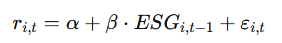

：上一年的 ESG 得分

检验 
β
β：若显著 > 0 → ESG 可预测未来收益；若 < 0 或不显著 → ESG 不具预测性。

In [236]:
import pandas as pd
import statsmodels.api as sm

# === 1. 读取数据 ===
df = pd.read_csv("merged_yearly_stock_data_all.csv", low_memory=False)

# === 2. 排序 + 创建滞后一期 ESG ===
df = df.sort_values(["stock_code", "Year"])
df["ESG_Score_lag1"] = df.groupby("stock_code")["ESG_Score"].shift(1)

# === 3. 删除缺失值 ===
df = df.dropna(subset=["price_day_return", "ESG_Score_lag1"])

# === 4. 回归：使用滞后 ESG 预测当期收益 ===
X = sm.add_constant(df["ESG_Score_lag1"])
y = df["price_day_return"]

model = sm.OLS(y, X).fit(cov_type="HC3")  # robust SE
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       price_day_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     98.73
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.06e-23
Time:                        00:49:04   Log-Likelihood:                 5477.6
No. Observations:               45199   AIC:                        -1.095e+04
Df Residuals:                   45197   BIC:                        -1.093e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0789      0.003     25.

In [237]:
for pillar in ["E_Score", "S_Score", "G_Score"]:
    df[f"{pillar}_lag1"] = df.groupby("stock_code")[pillar].shift(1)
    sub = df.dropna(subset=["price_day_return", f"{pillar}_lag1"])
    
    X = sm.add_constant(sub[f"{pillar}_lag1"])
    y = sub["price_day_return"]
    model = sm.OLS(y, X).fit(cov_type="HC3")
    
    print(f"\n=== Lagged {pillar} regression ===")
    print(model.summary().tables[1])



=== Lagged E_Score regression ===
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0700      0.001     55.638      0.000       0.068       0.072
E_Score_lag1    -0.0006   4.82e-05    -13.405      0.000      -0.001      -0.001

=== Lagged S_Score regression ===
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0860      0.002     40.350      0.000       0.082       0.090
S_Score_lag1    -0.0010   7.36e-05    -14.208      0.000      -0.001      -0.001

=== Lagged G_Score regression ===
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0558      0.002     23.415      0.000       0.051       0.060
G_Sc